# Comparison between different models for the Kaggle challenge "SETI Breakthrough Listen" 

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn import metrics
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sn
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
from efficientnet_pytorch import model as enet
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import codecs
from PIL import Image

In [2]:
def set_seed(seed = 0):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random_state = np.random.RandomState(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    return random_state

random_state = set_seed(2021)

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


complete folder "train/0" -> 3713 samples, ~3.1 GB

In [4]:
df_train=pd.read_csv('./train_labels_shorted.csv')
df_train.head()

,id,target
0,0000799a2b2c42d,0
1,00042890562ff68,0
2,0005364cdcb8e5b,0
3,0007a5a46901c56,0
4,0009283e145448e,0


In [5]:
df_train['img_path']=df_train['id'].apply(lambda x:f'./train/selectiontrain/{x}.npy')
df_train.head()

,id,target,img_path
0,0000799a2b2c42d,0,./train/selectiontrain/0000799a2b2c42d.npy
1,00042890562ff68,0,./train/selectiontrain/00042890562ff68.npy
2,0005364cdcb8e5b,0,./train/selectiontrain/0005364cdcb8e5b.npy
3,0007a5a46901c56,0,./train/selectiontrain/0007a5a46901c56.npy
4,0009283e145448e,0,./train/selectiontrain/0009283e145448e.npy


3713


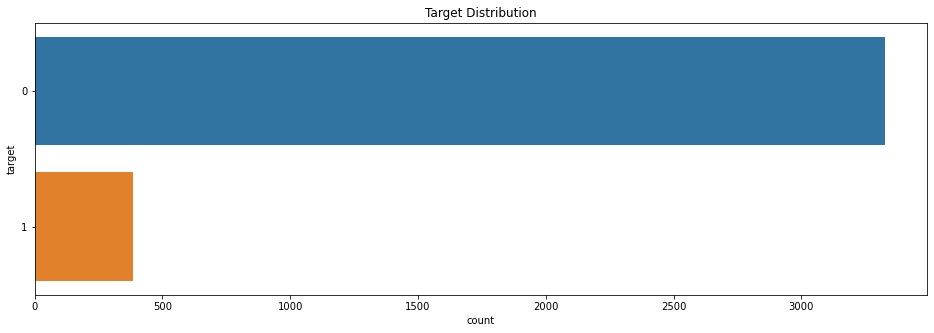

In [6]:
plt.figure(figsize=(16, 5))
sn.countplot(y="target", data=df_train)
plt.title("Target Distribution");
print(len(df_train))

In [7]:
class ClassificationDataset:
    
    def __init__(self, image_paths, targets, augment=False): 
        self.image_paths = image_paths
        self.targets = targets
        self.augment = augment

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, item):      
        image = np.load(self.image_paths[item]).astype(float)
        
        targets = self.targets[item]
        
        if self.augment:
            image = np.vstack(image).transpose((1, 0))
            
            img_pl = Image.fromarray(image).resize((512, 512), resample=Image.BICUBIC)
            image = np.array(img_pl)
                
        return {
            "image": torch.tensor(image, dtype=torch.float) if not self.augment else torch.from_numpy(image).unsqueeze(dim=0),
            "targets": torch.tensor(targets, dtype=torch.long),
        }

In [8]:
class enetv2(nn.Module):
    def __init__(self, backbone, pretrained=False, out_dim=1):
        super(enetv2, self).__init__()
        self.enet = enet.EfficientNet.from_name(backbone)
        if pretrained:
            self.enet.load_state_dict(torch.load(pretrained_model[backbone]))
        self.myfc = nn.Linear(self.enet._fc.in_features, out_dim)
        self.enet._fc = nn.Identity()
        self.conv1 = nn.Conv2d(6, 3, kernel_size=3, stride=1, padding=3, bias=False)
        self.conv1Norm = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=3, bias=False)
        self.poolNorm = nn.MaxPool2d(2, 2)
        self.conv2Norm = nn.Conv2d(32, 3, kernel_size=3, bias=False)

    def extract(self, x):
        return self.enet(x)

    def forward(self, x):
        flag = x[0][0].shape == (512, 512)
        if flag:
            x = self.conv1Norm(x)
            x = self.poolNorm(x)
            x = self.conv2Norm(x)
        else:
            x = self.conv1(x)
        x = self.extract(x)
        x = self.myfc(x)
        return x

In [9]:
class simpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(6, 3, kernel_size=3, stride=1, padding=3, bias=False)
        self.conv1Norm = nn.Conv2d(1, 3, kernel_size=3, stride=1, padding=3, bias=False)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(3, 16, 5)
        self.fc1 = nn.Linear(67536, 120)
        self.fc1Norm = nn.Linear(258064, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)
        
    def forward(self, x):
        flag = x[0][0].shape == (512, 512)
        if flag:
            x = self.pool(F.relu(self.conv1Norm(x)))
        else:
            x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        if flag:
            x = F.relu(self.fc1Norm(x))
        else:
            x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [10]:
def train(data_loader, model, optimizer, device):
    
    model.train() # Sets to train mode
    
    loss_sum = 0
    
    for data in tqdm(data_loader, position=0, leave=True, desc='Training'):
        inputs = data["image"]
        targets = data['targets']
        
        # Cast
        inputs = inputs.to(device, dtype=torch.float)
        targets = targets.to(device, dtype=torch.float)
        
        optimizer.zero_grad() # Gradient Descent
        outputs = model(inputs) # Output Weights
        loss = nn.BCEWithLogitsLoss()(outputs, targets.view(-1, 1)) # Loss-Berechnung: BCE-Loss + Sigmoid
        loss_sum += loss
        loss.backward()
        optimizer.step()
        
    return loss_sum
        
def evaluate(data_loader, model, device):
    model.eval() # Sets to evaluation mode
    
    final_targets = []
    final_outputs = []
    
    with torch.no_grad():
        loss_sum = 0
        
        for data in tqdm(data_loader, position=0, leave=True, desc='Evaluating'):
            inputs = data["image"]
            targets = data["targets"]
            inputs = inputs.to(device, dtype=torch.float)
            targets = targets.to(device, dtype=torch.float)
            
            output = model(inputs)
            
            loss_sum += nn.BCEWithLogitsLoss()(output, targets.view(-1, 1))
            
            targets = targets.detach().cpu().numpy().tolist()
            output = output.detach().cpu().numpy().tolist()
            
            final_targets.extend(targets)
            final_outputs.extend(output)
            
    return final_outputs, final_targets, loss_sum

In [11]:
baseline_name = ['efficientnet-b1', 'efficientnet-b3'] # Die Architektur bzw. das Netz? Warum ausgerechnet das?
pretrained_model = {
    baseline_name[0]: './checkpoint/efficientnet-b1-dbc7070a.pth', # Checkpoint?
    baseline_name[1]: './checkpoint/efficientnet-b3-c8376fa2.pth'
}
models = []
device = "cuda"
Batch_Size = 16
X = df_train.img_path.values
Y = df_train.target.values
#skf = StratifiedKFold(n_splits=5) # Cross Validation 5-fold, mehrschichtig (stratified)
# -> https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py)
#fold = 0

starter_models = [simpleNet(), simpleNet(),
                  enetv2(baseline_name[0], pretrained=False, out_dim=1), enetv2(baseline_name[0], pretrained=False, out_dim=1),
                  enetv2(baseline_name[0], pretrained=True, out_dim=1), enetv2(baseline_name[0], pretrained=True, out_dim=1),
                  enetv2(baseline_name[1], pretrained=False, out_dim=1), enetv2(baseline_name[1], pretrained=False, out_dim=1),
                  enetv2(baseline_name[1], pretrained=True, out_dim=1), enetv2(baseline_name[1], pretrained=True, out_dim=1)]

names = ['simpleNet', 'simpleNet-Augment', 'efficientnet-b1', 'efficientnet-b1-augment',
         'efficientnet-b1-pretrained', 'efficientnet-b1-pretrained-augment','efficientnet-b3', 'efficientnet-b3-augment',
         'efficientnet-b3-pretrained', 'efficientnet-b3-pretrained-augment']

epochs = [0 for i in names]
train_losses = [[] for i in names]
valid_losses = [[] for i in names]
aurocs = [[] for i in names]

it = 0

In [12]:
#create log file
codecs.open('log2.log', 'w+');

In [13]:
for model in starter_models:
    train_images, valid_images, train_targets, valid_targets = train_test_split(X, Y, random_state=2021)
    #model = enetv2(baseline_name, out_dim=1)
    model.to(device)
    
    train_dataset = ClassificationDataset(image_paths=train_images, targets=train_targets, augment=it%2!=0)
    valid_dataset = ClassificationDataset(image_paths=valid_images, targets=valid_targets, augment=it%2!=0)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=Batch_Size,shuffle=True, num_workers=4)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=Batch_Size,shuffle=False, num_workers=4)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    best_roc_auc = 0.0
    last_roc_auc = 0.0
    roc_auc = 1.0
    row = 0
    last_loss = 0
    train_loss = 10
    valid_loss = 10

    #for epoch in range(epochs):
    #while abs(last_roc_auc - roc_auc) > 0.001 or row < 2:
    #    if abs(last_roc_auc - roc_auc) < 0.001:
    while (abs(last_loss - train_loss) > 0.01 or row < 2) and epochs[it] < 500:
        if abs(last_loss - train_loss) < 0.01:    
            row += 1
        else:
            row = 0
        last_loss = train_loss
        epochs[it] += 1
        last_roc_auc = roc_auc
        train_loss = train(train_loader, model, optimizer, device=device)
        predictions, valid_targets, valid_loss = evaluate(valid_loader, model, device=device)
        roc_auc = metrics.roc_auc_score(valid_targets, predictions)
        
        train_losses[it].append(train_loss.detach().cpu().numpy()) 
        valid_losses[it].append(valid_loss.detach().cpu().numpy())
        aurocs[it].append(roc_auc)
        #f1_score = metrics.f1_score(valid_targets, predictions)
        print(f"Epoch={epochs[it]}, Train Loss={train_loss}, Train Loss Diff={abs(last_loss - train_loss)} Validation Loss={valid_loss}, Validation ROC AUC={roc_auc}, Distance Actual/Last={abs(roc_auc - last_roc_auc)}")

        with codecs.open('log2.log', 'a') as up:
            up.write(f"Model={names[it]}, Epoch={epochs[it]}, Train Loss={train_loss}, Valid Loss={valid_loss} Valid ROC AUC={roc_auc}/{best_roc_auc}\n")

        
    print(f'Model {names[it]} converged after {epochs[it]} epochs.')
    torch.save(model.state_dict(), names[it] + '-' + str(it) + '.pt')
    models.append(model)
    it += 1
    
print('finished')
it = 0

Evaluating: 100%|███████████████████████████████| 30/30 [00:01<00:00, 23.10it/s]


Epoch=1, Train Loss=32.046566009521484, Train Loss Diff=22.046566009521484 Validation Loss=11.099381446838379, Validation ROC AUC=0.5201901506249332, Distance Actual/Last=0.47980984937506677


Evaluating: 100%|███████████████████████████████| 30/30 [00:01<00:00, 21.72it/s]


Epoch=2, Train Loss=27.852664947509766, Train Loss Diff=4.193901062011719 Validation Loss=11.414851188659668, Validation ROC AUC=0.5335754727059074, Distance Actual/Last=0.013385322080974205


Evaluating: 100%|███████████████████████████████| 30/30 [00:01<00:00, 23.25it/s]


Epoch=3, Train Loss=25.98433494567871, Train Loss Diff=1.8683300018310547 Validation Loss=11.262371063232422, Validation ROC AUC=0.532453797671189, Distance Actual/Last=0.0011216750347183835


Evaluating: 100%|███████████████████████████████| 30/30 [00:01<00:00, 21.41it/s]


Epoch=4, Train Loss=24.05940055847168, Train Loss Diff=1.9249343872070312 Validation Loss=11.674983978271484, Validation ROC AUC=0.5534985578463839, Distance Actual/Last=0.021044760175194854


Evaluating: 100%|███████████████████████████████| 30/30 [00:01<00:00, 22.85it/s]


Epoch=5, Train Loss=19.469816207885742, Train Loss Diff=4.5895843505859375 Validation Loss=14.073466300964355, Validation ROC AUC=0.5343232560623865, Distance Actual/Last=0.0191753017839974


Evaluating: 100%|███████████████████████████████| 30/30 [00:01<00:00, 21.66it/s]


Epoch=6, Train Loss=13.763647079467773, Train Loss Diff=5.706169128417969 Validation Loss=16.796369552612305, Validation ROC AUC=0.5396004700352527, Distance Actual/Last=0.005277213972866179


Evaluating: 100%|███████████████████████████████| 30/30 [00:01<00:00, 22.11it/s]


Epoch=7, Train Loss=9.796104431152344, Train Loss Diff=3.9675426483154297 Validation Loss=22.840160369873047, Validation ROC AUC=0.4986326247195813, Distance Actual/Last=0.04096784531567138


Evaluating: 100%|███████████████████████████████| 30/30 [00:01<00:00, 22.02it/s]


Epoch=8, Train Loss=6.041136741638184, Train Loss Diff=3.75496768951416 Validation Loss=26.29151725769043, Validation ROC AUC=0.5203290246768508, Distance Actual/Last=0.02169639995726952


Evaluating: 100%|███████████████████████████████| 30/30 [00:01<00:00, 21.86it/s]


Epoch=9, Train Loss=5.050471305847168, Train Loss Diff=0.9906654357910156 Validation Loss=24.094959259033203, Validation ROC AUC=0.5194850977459673, Distance Actual/Last=0.0008439269308835318


Evaluating: 100%|███████████████████████████████| 30/30 [00:01<00:00, 22.12it/s]


Epoch=10, Train Loss=4.888328552246094, Train Loss Diff=0.16214275360107422 Validation Loss=21.563674926757812, Validation ROC AUC=0.5164512338425381, Distance Actual/Last=0.0030338639034291903


Evaluating: 100%|███████████████████████████████| 30/30 [00:01<00:00, 22.24it/s]


Epoch=11, Train Loss=4.8693132400512695, Train Loss Diff=0.01901531219482422 Validation Loss=35.232421875, Validation ROC AUC=0.520296976818716, Distance Actual/Last=0.0038457429761779016


Evaluating: 100%|███████████████████████████████| 30/30 [00:01<00:00, 21.87it/s]


Epoch=12, Train Loss=5.047455310821533, Train Loss Diff=0.17814207077026367 Validation Loss=29.724838256835938, Validation ROC AUC=0.5339386817647687, Distance Actual/Last=0.013641704946052657


Evaluating: 100%|███████████████████████████████| 30/30 [00:01<00:00, 21.11it/s]


Epoch=13, Train Loss=3.16668438911438, Train Loss Diff=1.8807709217071533 Validation Loss=36.16564178466797, Validation ROC AUC=0.5240145283623545, Distance Actual/Last=0.009924153402414149


Evaluating: 100%|███████████████████████████████| 30/30 [00:01<00:00, 21.26it/s]


Epoch=14, Train Loss=1.6218905448913574, Train Loss Diff=1.5447938442230225 Validation Loss=39.277587890625, Validation ROC AUC=0.5327529110137806, Distance Actual/Last=0.008738382651426124


Evaluating: 100%|███████████████████████████████| 30/30 [00:01<00:00, 21.38it/s]


Epoch=15, Train Loss=0.4290510416030884, Train Loss Diff=1.192839503288269 Validation Loss=57.26631546020508, Validation ROC AUC=0.5278282234803974, Distance Actual/Last=0.004924687533383265


Evaluating: 100%|███████████████████████████████| 30/30 [00:01<00:00, 21.49it/s]


Epoch=16, Train Loss=0.1680690348148346, Train Loss Diff=0.2609820067882538 Validation Loss=54.256900787353516, Validation ROC AUC=0.5318448883666275, Distance Actual/Last=0.0040166648862300924


Evaluating: 100%|███████████████████████████████| 30/30 [00:01<00:00, 22.29it/s]


Epoch=17, Train Loss=0.27298450469970703, Train Loss Diff=0.10491546988487244 Validation Loss=60.1390266418457, Validation ROC AUC=0.5239611152654631, Distance Actual/Last=0.007883773101164393


Evaluating: 100%|███████████████████████████████| 30/30 [00:01<00:00, 22.20it/s]


Epoch=18, Train Loss=0.21581800282001495, Train Loss Diff=0.05716650187969208 Validation Loss=50.092926025390625, Validation ROC AUC=0.5465655378698856, Distance Actual/Last=0.022604422604422525


Evaluating: 100%|███████████████████████████████| 30/30 [00:01<00:00, 21.81it/s]


Epoch=19, Train Loss=0.15131618082523346, Train Loss Diff=0.0645018219947815 Validation Loss=59.7587776184082, Validation ROC AUC=0.5221130221130221, Distance Actual/Last=0.02445251575686347


Evaluating: 100%|███████████████████████████████| 30/30 [00:01<00:00, 22.09it/s]


Epoch=20, Train Loss=0.04448390379548073, Train Loss Diff=0.10683228075504303 Validation Loss=60.7181282043457, Validation ROC AUC=0.5207349642132251, Distance Actual/Last=0.0013780578997970583


Evaluating: 100%|███████████████████████████████| 30/30 [00:01<00:00, 22.15it/s]


Epoch=21, Train Loss=0.03142465651035309, Train Loss Diff=0.01305924728512764 Validation Loss=69.68014526367188, Validation ROC AUC=0.516718299326995, Distance Actual/Last=0.0040166648862300924


Evaluating: 100%|███████████████████████████████| 30/30 [00:01<00:00, 19.53it/s]


Epoch=22, Train Loss=0.012038848362863064, Train Loss Diff=0.01938580721616745 Validation Loss=69.7933578491211, Validation ROC AUC=0.519004379873945, Distance Actual/Last=0.002286080546950009


Evaluating: 100%|███████████████████████████████| 30/30 [00:01<00:00, 21.06it/s]


Epoch=23, Train Loss=0.007327680010348558, Train Loss Diff=0.004711168352514505 Validation Loss=72.10940551757812, Validation ROC AUC=0.5185663924794359, Distance Actual/Last=0.0004379873945090651


Evaluating: 100%|███████████████████████████████| 30/30 [00:01<00:00, 20.98it/s]


Epoch=24, Train Loss=0.005498212296515703, Train Loss Diff=0.0018294677138328552 Validation Loss=73.56715393066406, Validation ROC AUC=0.5186198055763274, Distance Actual/Last=5.341309689144147e-05


Evaluating: 100%|███████████████████████████████| 30/30 [00:01<00:00, 20.71it/s]


Epoch=25, Train Loss=0.004429812543094158, Train Loss Diff=0.001068399753421545 Validation Loss=74.68444061279297, Validation ROC AUC=0.5185450272406794, Distance Actual/Last=7.477833564795144e-05
Model simpleNet converged after 25 epochs.


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.58it/s]


Epoch=1, Train Loss=37.36465072631836, Train Loss Diff=27.36465072631836 Validation Loss=10.96825122833252, Validation ROC AUC=0.5065765141007859, Distance Actual/Last=0.49342348589921414


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.40it/s]


Epoch=2, Train Loss=28.264936447143555, Train Loss Diff=9.099714279174805 Validation Loss=11.036752700805664, Validation ROC AUC=0.4983934350439204, Distance Actual/Last=0.008183079056865439


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.35it/s]


Epoch=3, Train Loss=25.82738494873047, Train Loss Diff=2.437551498413086 Validation Loss=10.682172775268555, Validation ROC AUC=0.5242949607027276, Distance Actual/Last=0.025901525658807212


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.36it/s]


Epoch=4, Train Loss=21.96451759338379, Train Loss Diff=3.8628673553466797 Validation Loss=13.286516189575195, Validation ROC AUC=0.5030744336569579, Distance Actual/Last=0.02122052704576971


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.25it/s]


Epoch=5, Train Loss=16.403013229370117, Train Loss Diff=5.561504364013672 Validation Loss=14.609660148620605, Validation ROC AUC=0.5135691169671752, Distance Actual/Last=0.010494683310217301


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.28it/s]


Epoch=6, Train Loss=10.810388565063477, Train Loss Diff=5.592624664306641 Validation Loss=17.19778823852539, Validation ROC AUC=0.5176953305594083, Distance Actual/Last=0.004126213592233086


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.39it/s]


Epoch=7, Train Loss=7.6469316482543945, Train Loss Diff=3.163456916809082 Validation Loss=20.337278366088867, Validation ROC AUC=0.5191516412390199, Distance Actual/Last=0.0014563106796116054


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.22it/s]


Epoch=8, Train Loss=5.045431613922119, Train Loss Diff=2.6015000343322754 Validation Loss=23.219411849975586, Validation ROC AUC=0.5255547850208044, Distance Actual/Last=0.006403143781784526


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.40it/s]


Epoch=9, Train Loss=2.5840413570404053, Train Loss Diff=2.461390256881714 Validation Loss=27.423166275024414, Validation ROC AUC=0.525624133148405, Distance Actual/Last=6.934812760051035e-05


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.26it/s]


Epoch=10, Train Loss=1.5456104278564453, Train Loss Diff=1.03843092918396 Validation Loss=32.452606201171875, Validation ROC AUC=0.5401756819232547, Distance Actual/Last=0.014551548774849765


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.24it/s]


Epoch=11, Train Loss=0.8699291348457336, Train Loss Diff=0.6756812930107117 Validation Loss=37.49259567260742, Validation ROC AUC=0.5333217753120666, Distance Actual/Last=0.006853906611188121


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.43it/s]


Epoch=12, Train Loss=0.7839821577072144, Train Loss Diff=0.08594697713851929 Validation Loss=36.55630874633789, Validation ROC AUC=0.5404068423485899, Distance Actual/Last=0.00708506703652334


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.37it/s]


Epoch=13, Train Loss=0.5851620435714722, Train Loss Diff=0.1988201141357422 Validation Loss=37.28878402709961, Validation ROC AUC=0.5348243180767452, Distance Actual/Last=0.005582524271844691


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.21it/s]


Epoch=14, Train Loss=0.5084370374679565, Train Loss Diff=0.07672500610351562 Validation Loss=45.22599792480469, Validation ROC AUC=0.530328247803976, Distance Actual/Last=0.004496070272769215


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.36it/s]


Epoch=15, Train Loss=0.28460896015167236, Train Loss Diff=0.22382807731628418 Validation Loss=45.91496276855469, Validation ROC AUC=0.539493758668516, Distance Actual/Last=0.009165510864539983


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.25it/s]


Epoch=16, Train Loss=0.4246993064880371, Train Loss Diff=0.14009034633636475 Validation Loss=44.90792465209961, Validation ROC AUC=0.5325473878871937, Distance Actual/Last=0.00694637078132232


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.32it/s]


Epoch=17, Train Loss=3.6124610900878906, Train Loss Diff=3.1877617835998535 Validation Loss=33.33296585083008, Validation ROC AUC=0.4875635691169672, Distance Actual/Last=0.0449838187702265


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.39it/s]


Epoch=18, Train Loss=2.498161792755127, Train Loss Diff=1.1142992973327637 Validation Loss=36.085166931152344, Validation ROC AUC=0.531287563569117, Distance Actual/Last=0.043723994452149806


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.68it/s]


Epoch=19, Train Loss=0.6394236087799072, Train Loss Diff=1.8587381839752197 Validation Loss=43.99925994873047, Validation ROC AUC=0.5306287563569116, Distance Actual/Last=0.0006588072122053479


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.78it/s]


Epoch=20, Train Loss=0.8155470490455627, Train Loss Diff=0.17612344026565552 Validation Loss=36.71632766723633, Validation ROC AUC=0.5089805825242719, Distance Actual/Last=0.021648173832639728


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.09it/s]


Epoch=21, Train Loss=0.9576060771942139, Train Loss Diff=0.14205902814865112 Validation Loss=39.1407470703125, Validation ROC AUC=0.5284674063800278, Distance Actual/Last=0.01948682385575584


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.44it/s]


Epoch=22, Train Loss=0.6348969340324402, Train Loss Diff=0.3227091431617737 Validation Loss=39.54115676879883, Validation ROC AUC=0.5121243643088302, Distance Actual/Last=0.016343042071197522


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.31it/s]


Epoch=23, Train Loss=0.06549067050218582, Train Loss Diff=0.569406270980835 Validation Loss=47.00596237182617, Validation ROC AUC=0.5152797041146555, Distance Actual/Last=0.0031553398058252746


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.43it/s]


Epoch=24, Train Loss=0.011350438930094242, Train Loss Diff=0.054140232503414154 Validation Loss=50.51416778564453, Validation ROC AUC=0.5154415164123902, Distance Actual/Last=0.00016181229773470918


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.24it/s]


Epoch=25, Train Loss=0.007212015800178051, Train Loss Diff=0.004138423129916191 Validation Loss=52.432247161865234, Validation ROC AUC=0.5163546000924641, Distance Actual/Last=0.0009130836800739228


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.38it/s]


Epoch=26, Train Loss=0.005401452071964741, Train Loss Diff=0.0018105637282133102 Validation Loss=53.68181610107422, Validation ROC AUC=0.5165742024965326, Distance Actual/Last=0.0002196024040684863


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.44it/s]


Epoch=27, Train Loss=0.004252211190760136, Train Loss Diff=0.001149240881204605 Validation Loss=54.77995681762695, Validation ROC AUC=0.5169556171983356, Distance Actual/Last=0.00038141470180297343
Model simpleNet-Augment converged after 27 epochs.


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.57it/s]


Epoch=1, Train Loss=32.91318893432617, Train Loss Diff=22.913188934326172 Validation Loss=10.175965309143066, Validation ROC AUC=0.5026791853379804, Distance Actual/Last=0.4973208146620196


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.73it/s]


Epoch=2, Train Loss=29.983118057250977, Train Loss Diff=2.9300708770751953 Validation Loss=10.423687934875488, Validation ROC AUC=0.4812101382269958, Distance Actual/Last=0.021469047110984574


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.27it/s]


Epoch=3, Train Loss=29.48096466064453, Train Loss Diff=0.5021533966064453 Validation Loss=10.1749849319458, Validation ROC AUC=0.4531972402020058, Distance Actual/Last=0.02801289802499002


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.39it/s]


Epoch=4, Train Loss=29.27898597717285, Train Loss Diff=0.2019786834716797 Validation Loss=10.362407684326172, Validation ROC AUC=0.4821940868245726, Distance Actual/Last=0.028996846622566796


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.63it/s]


Epoch=5, Train Loss=29.246158599853516, Train Loss Diff=0.03282737731933594 Validation Loss=10.440584182739258, Validation ROC AUC=0.4955900135144747, Distance Actual/Last=0.013395926689902082


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.53it/s]


Epoch=6, Train Loss=28.813764572143555, Train Loss Diff=0.43239402770996094 Validation Loss=10.793013572692871, Validation ROC AUC=0.5377575455817151, Distance Actual/Last=0.04216753206724039


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.25it/s]


Epoch=7, Train Loss=29.201427459716797, Train Loss Diff=0.3876628875732422 Validation Loss=10.73431396484375, Validation ROC AUC=0.5029992650022523, Distance Actual/Last=0.03475828057946273


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.47it/s]


Epoch=8, Train Loss=29.256237030029297, Train Loss Diff=0.0548095703125 Validation Loss=10.889996528625488, Validation ROC AUC=0.4923536524646134, Distance Actual/Last=0.01064561253763896


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.71it/s]


Epoch=9, Train Loss=29.092586517333984, Train Loss Diff=0.1636505126953125 Validation Loss=10.268495559692383, Validation ROC AUC=0.5290679754368495, Distance Actual/Last=0.03671432297223609


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.78it/s]


Epoch=10, Train Loss=29.234560012817383, Train Loss Diff=0.14197349548339844 Validation Loss=10.289655685424805, Validation ROC AUC=0.531510064727221, Distance Actual/Last=0.0024420892903714853


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.38it/s]


Epoch=11, Train Loss=28.970726013183594, Train Loss Diff=0.26383399963378906 Validation Loss=10.147741317749023, Validation ROC AUC=0.533430542712853, Distance Actual/Last=0.0019204779856319965


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.33it/s]


Epoch=12, Train Loss=28.84433364868164, Train Loss Diff=0.12639236450195312 Validation Loss=10.186572074890137, Validation ROC AUC=0.5254166963036726, Distance Actual/Last=0.008013846409180347


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.34it/s]


Epoch=13, Train Loss=28.961563110351562, Train Loss Diff=0.11722946166992188 Validation Loss=10.308262825012207, Validation ROC AUC=0.4894492258814046, Distance Actual/Last=0.035967470422268


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.39it/s]


Epoch=14, Train Loss=29.11194610595703, Train Loss Diff=0.15038299560546875 Validation Loss=10.383505821228027, Validation ROC AUC=0.47758256869857985, Distance Actual/Last=0.011866657182824758


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.46it/s]


Epoch=15, Train Loss=29.078805923461914, Train Loss Diff=0.03314018249511719 Validation Loss=10.09353256225586, Validation ROC AUC=0.5686867249922943, Distance Actual/Last=0.09110415629371449


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.50it/s]


Epoch=16, Train Loss=29.410459518432617, Train Loss Diff=0.3316535949707031 Validation Loss=10.198952674865723, Validation ROC AUC=0.47896958057709177, Distance Actual/Last=0.08971714441520257


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.53it/s]


Epoch=17, Train Loss=29.01401710510254, Train Loss Diff=0.3964424133300781 Validation Loss=10.407660484313965, Validation ROC AUC=0.512909879792304, Distance Actual/Last=0.03394029921521219


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.67it/s]


Epoch=18, Train Loss=29.24322509765625, Train Loss Diff=0.22920799255371094 Validation Loss=10.3424072265625, Validation ROC AUC=0.5155772103279038, Distance Actual/Last=0.0026673305355998655


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.32it/s]


Epoch=19, Train Loss=28.857337951660156, Train Loss Diff=0.38588714599609375 Validation Loss=10.180062294006348, Validation ROC AUC=0.4946949759347512, Distance Actual/Last=0.02088223439315262


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.40it/s]


Epoch=20, Train Loss=28.790773391723633, Train Loss Diff=0.06656455993652344 Validation Loss=10.157268524169922, Validation ROC AUC=0.5182089764563625, Distance Actual/Last=0.023514000521611345


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.58it/s]


Epoch=21, Train Loss=28.884267807006836, Train Loss Diff=0.09349441528320312 Validation Loss=10.333625793457031, Validation ROC AUC=0.5208407425848212, Distance Actual/Last=0.0026317661284586125


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.40it/s]


Epoch=22, Train Loss=29.034137725830078, Train Loss Diff=0.1498699188232422 Validation Loss=10.239030838012695, Validation ROC AUC=0.517023496218318, Distance Actual/Last=0.0038172463665031575


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.49it/s]


Epoch=23, Train Loss=28.948265075683594, Train Loss Diff=0.08587265014648438 Validation Loss=10.243998527526855, Validation ROC AUC=0.4718566991488251, Distance Actual/Last=0.04516679706949289


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.43it/s]


Epoch=24, Train Loss=28.925874710083008, Train Loss Diff=0.022390365600585938 Validation Loss=10.303427696228027, Validation ROC AUC=0.5110842402257154, Distance Actual/Last=0.039227541076890304


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.38it/s]


Epoch=25, Train Loss=28.856033325195312, Train Loss Diff=0.06984138488769531 Validation Loss=10.160932540893555, Validation ROC AUC=0.5110842402257154, Distance Actual/Last=0.0


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.39it/s]


Epoch=26, Train Loss=28.952585220336914, Train Loss Diff=0.09655189514160156 Validation Loss=10.314042091369629, Validation ROC AUC=0.41798847713208614, Distance Actual/Last=0.09309576309362927


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.66it/s]


Epoch=27, Train Loss=28.8884220123291, Train Loss Diff=0.0641632080078125 Validation Loss=10.256657600402832, Validation ROC AUC=0.44993716954738366, Distance Actual/Last=0.03194869241529752


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.42it/s]


Epoch=28, Train Loss=28.966943740844727, Train Loss Diff=0.078521728515625 Validation Loss=10.186094284057617, Validation ROC AUC=0.5063660288782985, Distance Actual/Last=0.05642885933091485


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.52it/s]


Epoch=29, Train Loss=29.325855255126953, Train Loss Diff=0.35891151428222656 Validation Loss=10.18567180633545, Validation ROC AUC=0.5166322877397633, Distance Actual/Last=0.010266258861464816


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.32it/s]


Epoch=30, Train Loss=28.749725341796875, Train Loss Diff=0.5761299133300781 Validation Loss=10.188676834106445, Validation ROC AUC=0.5235436375275624, Distance Actual/Last=0.006911349787799059


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.05it/s]


Epoch=31, Train Loss=28.885217666625977, Train Loss Diff=0.13549232482910156 Validation Loss=10.149574279785156, Validation ROC AUC=0.505897764184271, Distance Actual/Last=0.017645873343291374


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.50it/s]


Epoch=32, Train Loss=29.655929565429688, Train Loss Diff=0.7707118988037109 Validation Loss=13.653000831604004, Validation ROC AUC=0.520757758968158, Distance Actual/Last=0.014859994783886998


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.51it/s]


Epoch=33, Train Loss=29.16420555114746, Train Loss Diff=0.49172401428222656 Validation Loss=10.55395793914795, Validation ROC AUC=0.47755885909381884, Distance Actual/Last=0.04319889987433917


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.46it/s]


Epoch=34, Train Loss=28.870277404785156, Train Loss Diff=0.2939281463623047 Validation Loss=10.177862167358398, Validation ROC AUC=0.5226604547502193, Distance Actual/Last=0.04510159565640043


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.49it/s]


Epoch=35, Train Loss=28.943504333496094, Train Loss Diff=0.0732269287109375 Validation Loss=10.153494834899902, Validation ROC AUC=0.505417644687863, Distance Actual/Last=0.017242810062356284


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.39it/s]


Epoch=36, Train Loss=29.067750930786133, Train Loss Diff=0.12424659729003906 Validation Loss=11.64087963104248, Validation ROC AUC=0.4875761671052944, Distance Actual/Last=0.0178414775825686


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.60it/s]


Epoch=37, Train Loss=28.859455108642578, Train Loss Diff=0.2082958221435547 Validation Loss=10.180713653564453, Validation ROC AUC=0.5252270194655855, Distance Actual/Last=0.03765085236029109


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.58it/s]


Epoch=38, Train Loss=28.951433181762695, Train Loss Diff=0.09197807312011719 Validation Loss=10.164316177368164, Validation ROC AUC=0.5107819427650141, Distance Actual/Last=0.01444507670057138


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.50it/s]


Epoch=39, Train Loss=28.902395248413086, Train Loss Diff=0.049037933349609375 Validation Loss=10.252812385559082, Validation ROC AUC=0.4570737605804111, Distance Actual/Last=0.05370818218460299


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.09it/s]


Epoch=40, Train Loss=28.936277389526367, Train Loss Diff=0.03388214111328125 Validation Loss=10.160406112670898, Validation ROC AUC=0.5322213528700477, Distance Actual/Last=0.07514759228963658


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.55it/s]


Epoch=41, Train Loss=28.860759735107422, Train Loss Diff=0.07551765441894531 Validation Loss=10.295037269592285, Validation ROC AUC=0.4529127249448751, Distance Actual/Last=0.07930862792517257


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.15it/s]


Epoch=42, Train Loss=28.88066864013672, Train Loss Diff=0.019908905029296875 Validation Loss=10.33764362335205, Validation ROC AUC=0.48154800009483845, Distance Actual/Last=0.028635275149963335


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.00it/s]


Epoch=43, Train Loss=28.97836685180664, Train Loss Diff=0.09769821166992188 Validation Loss=10.233915328979492, Validation ROC AUC=0.4897278137373451, Distance Actual/Last=0.00817981364250664


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.33it/s]


Epoch=44, Train Loss=28.8818302154541, Train Loss Diff=0.09653663635253906 Validation Loss=10.165164947509766, Validation ROC AUC=0.5217002157574033, Distance Actual/Last=0.031972402020058244


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.33it/s]


Epoch=45, Train Loss=28.782255172729492, Train Loss Diff=0.09957504272460938 Validation Loss=10.243367195129395, Validation ROC AUC=0.49231808805747207, Distance Actual/Last=0.02938212769993126


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.56it/s]


Epoch=46, Train Loss=28.829504013061523, Train Loss Diff=0.04724884033203125 Validation Loss=10.205720901489258, Validation ROC AUC=0.5098513407781492, Distance Actual/Last=0.017533252720677128


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.37it/s]


Epoch=47, Train Loss=28.803882598876953, Train Loss Diff=0.025621414184570312 Validation Loss=10.177886962890625, Validation ROC AUC=0.48813334281717524, Distance Actual/Last=0.021717997960973956


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.44it/s]


Epoch=48, Train Loss=28.722503662109375, Train Loss Diff=0.08137893676757812 Validation Loss=10.264023780822754, Validation ROC AUC=0.46187495554449104, Distance Actual/Last=0.026258387272684203


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.62it/s]


Epoch=49, Train Loss=28.779539108276367, Train Loss Diff=0.05703544616699219 Validation Loss=10.186982154846191, Validation ROC AUC=0.5150437442207838, Distance Actual/Last=0.053168788676292766


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.53it/s]


Epoch=50, Train Loss=28.757980346679688, Train Loss Diff=0.021558761596679688 Validation Loss=10.182296752929688, Validation ROC AUC=0.4891469284207033, Distance Actual/Last=0.02589681580008052


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.44it/s]


Epoch=51, Train Loss=28.7630615234375, Train Loss Diff=0.0050811767578125 Validation Loss=11.340550422668457, Validation ROC AUC=0.5231820660549589, Distance Actual/Last=0.034035137634255586


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.25it/s]


Epoch=52, Train Loss=28.86642074584961, Train Loss Diff=0.10335922241210938 Validation Loss=10.322759628295898, Validation ROC AUC=0.49586267396922495, Distance Actual/Last=0.027319392085733918


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.30it/s]


Epoch=53, Train Loss=28.788610458374023, Train Loss Diff=0.07781028747558594 Validation Loss=10.231928825378418, Validation ROC AUC=0.5014166488844631, Distance Actual/Last=0.00555397491523818


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.80it/s]


Epoch=54, Train Loss=28.800344467163086, Train Loss Diff=0.0117340087890625 Validation Loss=10.169774055480957, Validation ROC AUC=0.48802072219456105, Distance Actual/Last=0.013395926689902082


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.17it/s]


Epoch=55, Train Loss=28.756696701049805, Train Loss Diff=0.04364776611328125 Validation Loss=10.173829078674316, Validation ROC AUC=0.46942646466083415, Distance Actual/Last=0.0185942575337269


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.56it/s]


Epoch=56, Train Loss=28.761707305908203, Train Loss Diff=0.0050106048583984375 Validation Loss=10.171995162963867, Validation ROC AUC=0.4931953434336249, Distance Actual/Last=0.02376887877279077


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.35it/s]


Epoch=57, Train Loss=28.847885131835938, Train Loss Diff=0.08617782592773438 Validation Loss=10.178014755249023, Validation ROC AUC=0.5067335277520923, Distance Actual/Last=0.013538184318467428


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.35it/s]


Epoch=58, Train Loss=28.789913177490234, Train Loss Diff=0.057971954345703125 Validation Loss=10.16581916809082, Validation ROC AUC=0.48453541029471037, Distance Actual/Last=0.022198117457381983


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.32it/s]


Epoch=59, Train Loss=28.85315704345703, Train Loss Diff=0.06324386596679688 Validation Loss=10.165648460388184, Validation ROC AUC=0.4684899352727791, Distance Actual/Last=0.016045475021931266


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.73it/s]


Epoch=60, Train Loss=28.820838928222656, Train Loss Diff=0.032318115234375 Validation Loss=10.175591468811035, Validation ROC AUC=0.5499679920335728, Distance Actual/Last=0.08147805676079373


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.36it/s]


Epoch=61, Train Loss=28.740211486816406, Train Loss Diff=0.08062744140625 Validation Loss=10.358442306518555, Validation ROC AUC=0.49343243948123383, Distance Actual/Last=0.056535552552339


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.70it/s]


Epoch=62, Train Loss=28.80965805053711, Train Loss Diff=0.06944656372070312 Validation Loss=10.185074806213379, Validation ROC AUC=0.4914171230765584, Distance Actual/Last=0.002015316404675449


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.44it/s]


Epoch=63, Train Loss=28.840816497802734, Train Loss Diff=0.031158447265625 Validation Loss=10.185349464416504, Validation ROC AUC=0.44654669606657654, Distance Actual/Last=0.04487042700998184


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.74it/s]


Epoch=64, Train Loss=28.765687942504883, Train Loss Diff=0.07512855529785156 Validation Loss=10.583023071289062, Validation ROC AUC=0.474761125732034, Distance Actual/Last=0.028214429665457452


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.38it/s]


Epoch=65, Train Loss=28.831499099731445, Train Loss Diff=0.0658111572265625 Validation Loss=10.302295684814453, Validation ROC AUC=0.5249662138132157, Distance Actual/Last=0.05020508808118174


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 11.76it/s]


Epoch=66, Train Loss=28.785198211669922, Train Loss Diff=0.04630088806152344 Validation Loss=10.217968940734863, Validation ROC AUC=0.5137871351684566, Distance Actual/Last=0.011179078644759088


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.05it/s]


Epoch=67, Train Loss=28.754650115966797, Train Loss Diff=0.030548095703125 Validation Loss=10.12830638885498, Validation ROC AUC=0.5239941200180194, Distance Actual/Last=0.010206984849562728


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.54it/s]


Epoch=68, Train Loss=28.72113800048828, Train Loss Diff=0.033512115478515625 Validation Loss=10.184029579162598, Validation ROC AUC=0.5193351826825046, Distance Actual/Last=0.004658937335514812


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.70it/s]


Epoch=69, Train Loss=28.780418395996094, Train Loss Diff=0.0592803955078125 Validation Loss=10.331626892089844, Validation ROC AUC=0.4724731488726083, Distance Actual/Last=0.046862033809896286


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.69it/s]


Epoch=70, Train Loss=28.858339309692383, Train Loss Diff=0.07792091369628906 Validation Loss=10.20676326751709, Validation ROC AUC=0.5173080114754487, Distance Actual/Last=0.04483486260284042


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.37it/s]


Epoch=71, Train Loss=28.799846649169922, Train Loss Diff=0.05849266052246094 Validation Loss=10.191399574279785, Validation ROC AUC=0.48804443179932194, Distance Actual/Last=0.02926357967612675


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.32it/s]


Epoch=72, Train Loss=28.602632522583008, Train Loss Diff=0.19721412658691406 Validation Loss=10.664839744567871, Validation ROC AUC=0.5408042297934894, Distance Actual/Last=0.05275979799416747


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.47it/s]


Epoch=73, Train Loss=28.648191452026367, Train Loss Diff=0.045558929443359375 Validation Loss=10.178472518920898, Validation ROC AUC=0.4961708988311165, Distance Actual/Last=0.04463333096237293


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.51it/s]


Epoch=74, Train Loss=28.6329402923584, Train Loss Diff=0.01525115966796875 Validation Loss=10.117884635925293, Validation ROC AUC=0.5522796784977594, Distance Actual/Last=0.056108779666642905


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.61it/s]


Epoch=75, Train Loss=28.810882568359375, Train Loss Diff=0.17794227600097656 Validation Loss=10.271988868713379, Validation ROC AUC=0.5267681437750432, Distance Actual/Last=0.025511534722716167


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.29it/s]


Epoch=76, Train Loss=28.782896041870117, Train Loss Diff=0.027986526489257812 Validation Loss=10.18098258972168, Validation ROC AUC=0.5438924058135951, Distance Actual/Last=0.017124262038551885


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.52it/s]


Epoch=77, Train Loss=28.770822525024414, Train Loss Diff=0.012073516845703125 Validation Loss=10.239273071289062, Validation ROC AUC=0.4582414586148849, Distance Actual/Last=0.08565094719871019


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 11.73it/s]


Epoch=78, Train Loss=28.669851303100586, Train Loss Diff=0.10097122192382812 Validation Loss=10.170573234558105, Validation ROC AUC=0.5015411243094577, Distance Actual/Last=0.04329966569457283


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.13it/s]


Epoch=79, Train Loss=28.774782180786133, Train Loss Diff=0.10493087768554688 Validation Loss=10.184829711914062, Validation ROC AUC=0.48891575977428453, Distance Actual/Last=0.012625364535173211


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.48it/s]


Epoch=80, Train Loss=28.81825065612793, Train Loss Diff=0.043468475341796875 Validation Loss=10.222169876098633, Validation ROC AUC=0.5047300661497973, Distance Actual/Last=0.015814306375512788


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.47it/s]


Epoch=81, Train Loss=28.856529235839844, Train Loss Diff=0.03827857971191406 Validation Loss=10.157211303710938, Validation ROC AUC=0.5007942717594898, Distance Actual/Last=0.0039357943903075565


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.43it/s]


Epoch=82, Train Loss=28.72925567626953, Train Loss Diff=0.1272735595703125 Validation Loss=10.202659606933594, Validation ROC AUC=0.46977025392986704, Distance Actual/Last=0.03102401782962272


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.40it/s]


Epoch=83, Train Loss=28.68508529663086, Train Loss Diff=0.044170379638671875 Validation Loss=16.410608291625977, Validation ROC AUC=0.47555539749152387, Distance Actual/Last=0.005785143561656825


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.34it/s]


Epoch=84, Train Loss=28.991865158081055, Train Loss Diff=0.3067798614501953 Validation Loss=10.142755508422852, Validation ROC AUC=0.5810453564739075, Distance Actual/Last=0.10548995898238367


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.31it/s]


Epoch=85, Train Loss=28.81299591064453, Train Loss Diff=0.17886924743652344 Validation Loss=10.217098236083984, Validation ROC AUC=0.4655025250729071, Distance Actual/Last=0.11554283140100041


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.55it/s]


Epoch=86, Train Loss=28.75283432006836, Train Loss Diff=0.060161590576171875 Validation Loss=10.179145812988281, Validation ROC AUC=0.48270384332693167, Distance Actual/Last=0.017201318254024545


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.58it/s]


Epoch=87, Train Loss=28.79027557373047, Train Loss Diff=0.037441253662109375 Validation Loss=10.16525650024414, Validation ROC AUC=0.4630130165730137, Distance Actual/Last=0.019690826753917978


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.59it/s]


Epoch=88, Train Loss=28.749805450439453, Train Loss Diff=0.040470123291015625 Validation Loss=10.169188499450684, Validation ROC AUC=0.48290537496739927, Distance Actual/Last=0.01989235839438558


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.64it/s]


Epoch=89, Train Loss=28.897735595703125, Train Loss Diff=0.14793014526367188 Validation Loss=10.15778636932373, Validation ROC AUC=0.5154230978969581, Distance Actual/Last=0.03251772292955879


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.17it/s]


Epoch=90, Train Loss=28.84186363220215, Train Loss Diff=0.05587196350097656 Validation Loss=10.168736457824707, Validation ROC AUC=0.49144083268131916, Distance Actual/Last=0.023982265215638898


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.37it/s]


Epoch=91, Train Loss=28.82912826538086, Train Loss Diff=0.012735366821289062 Validation Loss=10.214539527893066, Validation ROC AUC=0.5026080565236977, Distance Actual/Last=0.011167223842378504


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.57it/s]


Epoch=92, Train Loss=29.008522033691406, Train Loss Diff=0.17939376831054688 Validation Loss=10.199572563171387, Validation ROC AUC=0.5133010882708585, Distance Actual/Last=0.010693031747160853


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.47it/s]


Epoch=93, Train Loss=28.667781829833984, Train Loss Diff=0.3407402038574219 Validation Loss=10.166122436523438, Validation ROC AUC=0.5253811318965314, Distance Actual/Last=0.012080043625672832


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.36it/s]


Epoch=94, Train Loss=28.679004669189453, Train Loss Diff=0.01122283935546875 Validation Loss=10.215099334716797, Validation ROC AUC=0.48594020437679303, Distance Actual/Last=0.03944092751973832


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.54it/s]


Epoch=95, Train Loss=28.755346298217773, Train Loss Diff=0.07634162902832031 Validation Loss=10.283466339111328, Validation ROC AUC=0.4886905185290561, Distance Actual/Last=0.002750314152263067


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.45it/s]


Epoch=96, Train Loss=28.826704025268555, Train Loss Diff=0.07135772705078125 Validation Loss=10.185221672058105, Validation ROC AUC=0.47868506531996113, Distance Actual/Last=0.010005453209094961


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.43it/s]


Epoch=97, Train Loss=28.799747467041016, Train Loss Diff=0.026956558227539062 Validation Loss=10.154288291931152, Validation ROC AUC=0.5162529340635892, Distance Actual/Last=0.03756786874362805


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.33it/s]


Epoch=98, Train Loss=28.79777717590332, Train Loss Diff=0.0019702911376953125 Validation Loss=10.20435905456543, Validation ROC AUC=0.4568722289399435, Distance Actual/Last=0.05938070512364568


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.36it/s]


Epoch=99, Train Loss=28.8610782623291, Train Loss Diff=0.06330108642578125 Validation Loss=10.237444877624512, Validation ROC AUC=0.5180430092230363, Distance Actual/Last=0.06117078028309275


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.59it/s]


Epoch=100, Train Loss=28.770915985107422, Train Loss Diff=0.09016227722167969 Validation Loss=10.50216293334961, Validation ROC AUC=0.4449225881404557, Distance Actual/Last=0.07312042108258054


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.39it/s]


Epoch=101, Train Loss=28.754634857177734, Train Loss Diff=0.0162811279296875 Validation Loss=10.216117858886719, Validation ROC AUC=0.4791948218223202, Distance Actual/Last=0.034272233681864495


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.04it/s]


Epoch=102, Train Loss=28.83145523071289, Train Loss Diff=0.07682037353515625 Validation Loss=10.149971961975098, Validation ROC AUC=0.513206249851815, Distance Actual/Last=0.03401142802949475


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.59it/s]


Epoch=103, Train Loss=28.778121948242188, Train Loss Diff=0.053333282470703125 Validation Loss=10.154206275939941, Validation ROC AUC=0.5146169713350879, Distance Actual/Last=0.0014107214832729253


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.46it/s]


Epoch=104, Train Loss=28.769750595092773, Train Loss Diff=0.008371353149414062 Validation Loss=10.166417121887207, Validation ROC AUC=0.4889157597742846, Distance Actual/Last=0.025701211560803294


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.51it/s]


Epoch=105, Train Loss=28.698341369628906, Train Loss Diff=0.07140922546386719 Validation Loss=10.167792320251465, Validation ROC AUC=0.5262109680631624, Distance Actual/Last=0.03729520828887778


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 11.24it/s]


Epoch=106, Train Loss=28.83458137512207, Train Loss Diff=0.13624000549316406 Validation Loss=10.173848152160645, Validation ROC AUC=0.49536477226924625, Distance Actual/Last=0.03084619579391612


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.57it/s]


Epoch=107, Train Loss=28.833003997802734, Train Loss Diff=0.0015773773193359375 Validation Loss=10.200980186462402, Validation ROC AUC=0.47811603480569975, Distance Actual/Last=0.017248737463546493


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.44it/s]


Epoch=108, Train Loss=28.853713989257812, Train Loss Diff=0.020709991455078125 Validation Loss=10.181920051574707, Validation ROC AUC=0.5245631505322805, Distance Actual/Last=0.04644711572658078


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.38it/s]


Epoch=109, Train Loss=28.888961791992188, Train Loss Diff=0.035247802734375 Validation Loss=10.155590057373047, Validation ROC AUC=0.5393638713042653, Distance Actual/Last=0.014800720771984799


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.54it/s]


Epoch=110, Train Loss=28.743343353271484, Train Loss Diff=0.14561843872070312 Validation Loss=10.184764862060547, Validation ROC AUC=0.5033845460796168, Distance Actual/Last=0.03597932522464853


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.58it/s]


Epoch=111, Train Loss=28.830211639404297, Train Loss Diff=0.0868682861328125 Validation Loss=10.180683135986328, Validation ROC AUC=0.5098631955805297, Distance Actual/Last=0.006478649500912925


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.19it/s]


Epoch=112, Train Loss=28.783628463745117, Train Loss Diff=0.04658317565917969 Validation Loss=10.164450645446777, Validation ROC AUC=0.5169997866135572, Distance Actual/Last=0.00713659103302744


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.65it/s]


Epoch=113, Train Loss=28.84201431274414, Train Loss Diff=0.05838584899902344 Validation Loss=10.136173248291016, Validation ROC AUC=0.565260687104346, Distance Actual/Last=0.048260900490788794


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 11.92it/s]


Epoch=114, Train Loss=28.742124557495117, Train Loss Diff=0.09988975524902344 Validation Loss=10.182244300842285, Validation ROC AUC=0.5037461175522204, Distance Actual/Last=0.06151456955212553


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.46it/s]


Epoch=115, Train Loss=28.79039192199707, Train Loss Diff=0.048267364501953125 Validation Loss=10.182765007019043, Validation ROC AUC=0.475241245228442, Distance Actual/Last=0.028504872323778407


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.38it/s]


Epoch=116, Train Loss=28.75340461730957, Train Loss Diff=0.0369873046875 Validation Loss=10.13860034942627, Validation ROC AUC=0.5203013490765109, Distance Actual/Last=0.04506010384806891


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.56it/s]


Epoch=117, Train Loss=28.820987701416016, Train Loss Diff=0.06758308410644531 Validation Loss=10.273297309875488, Validation ROC AUC=0.5137337885577447, Distance Actual/Last=0.00656756051876628


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.41it/s]


Epoch=118, Train Loss=28.851625442504883, Train Loss Diff=0.030637741088867188 Validation Loss=10.332383155822754, Validation ROC AUC=0.46068354790525645, Distance Actual/Last=0.0530502406524882


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.54it/s]


Epoch=119, Train Loss=28.775529861450195, Train Loss Diff=0.0760955810546875 Validation Loss=10.188344955444336, Validation ROC AUC=0.528736040970197, Distance Actual/Last=0.06805249306494054


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.55it/s]


Epoch=120, Train Loss=28.758949279785156, Train Loss Diff=0.016580581665039062 Validation Loss=10.181901931762695, Validation ROC AUC=0.5405197145363587, Distance Actual/Last=0.011783673566161723


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.58it/s]


Epoch=121, Train Loss=28.72797203063965, Train Loss Diff=0.030977249145507812 Validation Loss=10.161036491394043, Validation ROC AUC=0.5268926192000379, Distance Actual/Last=0.013627095336320783


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.65it/s]


Epoch=122, Train Loss=28.6719913482666, Train Loss Diff=0.055980682373046875 Validation Loss=10.197118759155273, Validation ROC AUC=0.5238459349882637, Distance Actual/Last=0.003046684211774231


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.64it/s]


Epoch=123, Train Loss=28.863910675048828, Train Loss Diff=0.19191932678222656 Validation Loss=10.178092002868652, Validation ROC AUC=0.5046530099343244, Distance Actual/Last=0.019192925053939325


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.31it/s]


Epoch=124, Train Loss=28.76406478881836, Train Loss Diff=0.09984588623046875 Validation Loss=10.164260864257812, Validation ROC AUC=0.5071425184342178, Distance Actual/Last=0.002489508499893378


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.28it/s]


Epoch=125, Train Loss=28.762754440307617, Train Loss Diff=0.0013103485107421875 Validation Loss=10.19382095336914, Validation ROC AUC=0.5305616805367854, Distance Actual/Last=0.02341916210256767


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.43it/s]


Epoch=126, Train Loss=28.764358520507812, Train Loss Diff=0.0016040802001953125 Validation Loss=10.17690372467041, Validation ROC AUC=0.4460962135761197, Distance Actual/Last=0.0844654669606657


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.15it/s]


Epoch=127, Train Loss=28.83522605895996, Train Loss Diff=0.07086753845214844 Validation Loss=10.163905143737793, Validation ROC AUC=0.47279915593807054, Distance Actual/Last=0.02670294236195081


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.34it/s]


Epoch=128, Train Loss=28.73268699645996, Train Loss Diff=0.1025390625 Validation Loss=10.194663047790527, Validation ROC AUC=0.4861476634184508, Distance Actual/Last=0.013348507480380245


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.48it/s]


Epoch=129, Train Loss=28.831981658935547, Train Loss Diff=0.09929466247558594 Validation Loss=10.202651977539062, Validation ROC AUC=0.44261682907745925, Distance Actual/Last=0.04353083434099153


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.54it/s]


Epoch=130, Train Loss=28.82665252685547, Train Loss Diff=0.005329132080078125 Validation Loss=10.20970630645752, Validation ROC AUC=0.4979609739905636, Distance Actual/Last=0.055344144913104354


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.60it/s]


Epoch=131, Train Loss=28.82537078857422, Train Loss Diff=0.00128173828125 Validation Loss=10.20417594909668, Validation ROC AUC=0.49396590558835385, Distance Actual/Last=0.003995068402209756


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.61it/s]


Epoch=132, Train Loss=28.703500747680664, Train Loss Diff=0.12187004089355469 Validation Loss=10.311264038085938, Validation ROC AUC=0.5086599331389146, Distance Actual/Last=0.014694027550560707


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.55it/s]


Epoch=133, Train Loss=28.743946075439453, Train Loss Diff=0.04044532775878906 Validation Loss=10.219721794128418, Validation ROC AUC=0.504587808521232, Distance Actual/Last=0.004072124617682582


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.38it/s]


Epoch=134, Train Loss=28.79804039001465, Train Loss Diff=0.05409431457519531 Validation Loss=10.150985717773438, Validation ROC AUC=0.5357066647698983, Distance Actual/Last=0.031118856248666282


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.34it/s]


Epoch=135, Train Loss=28.770780563354492, Train Loss Diff=0.02725982666015625 Validation Loss=10.164815902709961, Validation ROC AUC=0.5200820352324727, Distance Actual/Last=0.015624629537425605


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.61it/s]


Epoch=136, Train Loss=28.70671272277832, Train Loss Diff=0.06406784057617188 Validation Loss=10.205621719360352, Validation ROC AUC=0.4601678640017071, Distance Actual/Last=0.059914171230765534


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.42it/s]


Epoch=137, Train Loss=28.76535987854004, Train Loss Diff=0.05864715576171875 Validation Loss=10.165933609008789, Validation ROC AUC=0.4840434359959219, Distance Actual/Last=0.023875571994214806


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.21it/s]


Epoch=138, Train Loss=28.671724319458008, Train Loss Diff=0.09363555908203125 Validation Loss=10.1664400100708, Validation ROC AUC=0.49145268748369964, Distance Actual/Last=0.007409251487777713


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.18it/s]


Epoch=139, Train Loss=28.810277938842773, Train Loss Diff=0.13855361938476562 Validation Loss=10.184683799743652, Validation ROC AUC=0.5280366076297508, Distance Actual/Last=0.03658392014605116


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.20it/s]


Epoch=140, Train Loss=28.776636123657227, Train Loss Diff=0.033641815185546875 Validation Loss=10.160401344299316, Validation ROC AUC=0.4910970434122863, Distance Actual/Last=0.03693956421746447


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.54it/s]


Epoch=141, Train Loss=28.759044647216797, Train Loss Diff=0.017591476440429688 Validation Loss=10.177517890930176, Validation ROC AUC=0.5037401901510301, Distance Actual/Last=0.012643146738743782


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.40it/s]


Epoch=142, Train Loss=28.635787963867188, Train Loss Diff=0.12325668334960938 Validation Loss=10.171567916870117, Validation ROC AUC=0.4960227138013609, Distance Actual/Last=0.007717476349669183


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.55it/s]


Epoch=143, Train Loss=28.662107467651367, Train Loss Diff=0.026319503784179688 Validation Loss=10.212525367736816, Validation ROC AUC=0.5103551698793182, Distance Actual/Last=0.014332456077957245


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.35it/s]


Epoch=144, Train Loss=28.760774612426758, Train Loss Diff=0.09866714477539062 Validation Loss=10.161632537841797, Validation ROC AUC=0.4889631789838063, Distance Actual/Last=0.02139199089551186


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.64it/s]


Epoch=145, Train Loss=28.66826820373535, Train Loss Diff=0.09250640869140625 Validation Loss=10.246920585632324, Validation ROC AUC=0.5159447092016977, Distance Actual/Last=0.026981530217891347


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.45it/s]


Epoch=146, Train Loss=28.620126724243164, Train Loss Diff=0.0481414794921875 Validation Loss=10.155536651611328, Validation ROC AUC=0.5115880693268843, Distance Actual/Last=0.004356639874813384


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.58it/s]


Epoch=147, Train Loss=28.755390167236328, Train Loss Diff=0.13526344299316406 Validation Loss=10.171967506408691, Validation ROC AUC=0.4574649690589658, Distance Actual/Last=0.0541231002679185


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.23it/s]


Epoch=148, Train Loss=28.698463439941406, Train Loss Diff=0.056926727294921875 Validation Loss=10.200521469116211, Validation ROC AUC=0.5099698888019536, Distance Actual/Last=0.05250491974298782


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.20it/s]


Epoch=149, Train Loss=28.661706924438477, Train Loss Diff=0.03675651550292969 Validation Loss=10.227805137634277, Validation ROC AUC=0.5140360860184461, Distance Actual/Last=0.004066197216492484


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 11.79it/s]


Epoch=150, Train Loss=28.50815773010254, Train Loss Diff=0.1535491943359375 Validation Loss=10.228201866149902, Validation ROC AUC=0.48038622946155485, Distance Actual/Last=0.03364985655689123


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.13it/s]


Epoch=151, Train Loss=28.91425132751465, Train Loss Diff=0.4060935974121094 Validation Loss=10.297913551330566, Validation ROC AUC=0.4534106266448539, Distance Actual/Last=0.026975602816700972


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.59it/s]


Epoch=152, Train Loss=28.737363815307617, Train Loss Diff=0.17688751220703125 Validation Loss=10.191224098205566, Validation ROC AUC=0.43281883491002204, Distance Actual/Last=0.020591791734831832


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.34it/s]


Epoch=153, Train Loss=28.738422393798828, Train Loss Diff=0.0010585784912109375 Validation Loss=10.179826736450195, Validation ROC AUC=0.5080612656187021, Distance Actual/Last=0.07524243070868009


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.41it/s]


Epoch=154, Train Loss=28.61383628845215, Train Loss Diff=0.12458610534667969 Validation Loss=10.231874465942383, Validation ROC AUC=0.5022879768594257, Distance Actual/Last=0.005773288759276407


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.53it/s]


Epoch=155, Train Loss=28.69698143005371, Train Loss Diff=0.0831451416015625 Validation Loss=10.297466278076172, Validation ROC AUC=0.4770491025914598, Distance Actual/Last=0.02523887426796595


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.52it/s]


Epoch=156, Train Loss=28.585979461669922, Train Loss Diff=0.11100196838378906 Validation Loss=10.246200561523438, Validation ROC AUC=0.5117006899494986, Distance Actual/Last=0.034651587358038805


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.59it/s]


Epoch=157, Train Loss=28.56684684753418, Train Loss Diff=0.019132614135742188 Validation Loss=10.179414749145508, Validation ROC AUC=0.5329326410128743, Distance Actual/Last=0.02123195106337572


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.60it/s]


Epoch=158, Train Loss=28.586875915527344, Train Loss Diff=0.020029067993164062 Validation Loss=10.197698593139648, Validation ROC AUC=0.5343433624961471, Distance Actual/Last=0.0014107214832728143


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.62it/s]


Epoch=159, Train Loss=28.67946434020996, Train Loss Diff=0.09258842468261719 Validation Loss=10.2849702835083, Validation ROC AUC=0.5205206629205491, Distance Actual/Last=0.013822699575598008


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.68it/s]


Epoch=160, Train Loss=28.426898956298828, Train Loss Diff=0.2525653839111328 Validation Loss=10.235638618469238, Validation ROC AUC=0.5514854067382696, Distance Actual/Last=0.03096474381772052


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 11.98it/s]


Epoch=161, Train Loss=28.570541381835938, Train Loss Diff=0.14364242553710938 Validation Loss=10.161774635314941, Validation ROC AUC=0.5353213836925339, Distance Actual/Last=0.01616402304573572


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.26it/s]


Epoch=162, Train Loss=28.659603118896484, Train Loss Diff=0.08906173706054688 Validation Loss=10.287044525146484, Validation ROC AUC=0.48992341797662237, Distance Actual/Last=0.04539796571591154


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.30it/s]


Epoch=163, Train Loss=28.731176376342773, Train Loss Diff=0.07157325744628906 Validation Loss=10.18945026397705, Validation ROC AUC=0.5164485383028665, Distance Actual/Last=0.026525120326244156


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.44it/s]


Epoch=164, Train Loss=28.717449188232422, Train Loss Diff=0.013727188110351562 Validation Loss=10.215933799743652, Validation ROC AUC=0.4890580174028499, Distance Actual/Last=0.027390520900016646


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.46it/s]


Epoch=165, Train Loss=28.712081909179688, Train Loss Diff=0.005367279052734375 Validation Loss=10.27257251739502, Validation ROC AUC=0.4924722004884179, Distance Actual/Last=0.003414183085568012


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.27it/s]


Epoch=166, Train Loss=28.656911849975586, Train Loss Diff=0.05517005920410156 Validation Loss=10.257593154907227, Validation ROC AUC=0.49366953552884274, Distance Actual/Last=0.0011973350404248517


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.20it/s]


Epoch=167, Train Loss=28.75136947631836, Train Loss Diff=0.09445762634277344 Validation Loss=10.20656681060791, Validation ROC AUC=0.47246722147141806, Distance Actual/Last=0.021202314057424676


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.46it/s]


Epoch=168, Train Loss=28.606311798095703, Train Loss Diff=0.14505767822265625 Validation Loss=10.15888500213623, Validation ROC AUC=0.5236503307489864, Distance Actual/Last=0.051183109277568306


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.27it/s]


Epoch=169, Train Loss=28.637710571289062, Train Loss Diff=0.031398773193359375 Validation Loss=10.306404113769531, Validation ROC AUC=0.5110131114114328, Distance Actual/Last=0.012637219337553574


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.60it/s]


Epoch=170, Train Loss=28.761425018310547, Train Loss Diff=0.12371444702148438 Validation Loss=10.229066848754883, Validation ROC AUC=0.5354577139199089, Distance Actual/Last=0.024444602508476132


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.57it/s]


Epoch=171, Train Loss=28.669137954711914, Train Loss Diff=0.09228706359863281 Validation Loss=10.154404640197754, Validation ROC AUC=0.5268748369964673, Distance Actual/Last=0.008582876923441618


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.63it/s]


Epoch=172, Train Loss=28.476043701171875, Train Loss Diff=0.19309425354003906 Validation Loss=10.319168090820312, Validation ROC AUC=0.5301704720582308, Distance Actual/Last=0.0032956350617634467


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 11.88it/s]


Epoch=173, Train Loss=28.550596237182617, Train Loss Diff=0.07455253601074219 Validation Loss=10.235502243041992, Validation ROC AUC=0.5118073831709224, Distance Actual/Last=0.01836308888730831


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.04it/s]


Epoch=174, Train Loss=28.544940948486328, Train Loss Diff=0.0056552886962890625 Validation Loss=10.329212188720703, Validation ROC AUC=0.5315219195296014, Distance Actual/Last=0.019714536358678925


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.64it/s]


Epoch=175, Train Loss=28.46734046936035, Train Loss Diff=0.07760047912597656 Validation Loss=10.211437225341797, Validation ROC AUC=0.48771842473385973, Distance Actual/Last=0.04380349479574164


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.39it/s]


Epoch=176, Train Loss=28.235328674316406, Train Loss Diff=0.2320117950439453 Validation Loss=10.3740873336792, Validation ROC AUC=0.5544787443393319, Distance Actual/Last=0.06676031960547213


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.35it/s]


Epoch=177, Train Loss=28.558616638183594, Train Loss Diff=0.3232879638671875 Validation Loss=10.457781791687012, Validation ROC AUC=0.4941437276240605, Distance Actual/Last=0.06033501671527136


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.54it/s]


Epoch=178, Train Loss=28.39884376525879, Train Loss Diff=0.1597728729248047 Validation Loss=10.217623710632324, Validation ROC AUC=0.4905398677004055, Distance Actual/Last=0.0036038599236550284


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.61it/s]


Epoch=179, Train Loss=28.286518096923828, Train Loss Diff=0.11232566833496094 Validation Loss=10.195355415344238, Validation ROC AUC=0.527829148588093, Distance Actual/Last=0.03728928088768757


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.32it/s]


Epoch=180, Train Loss=28.038593292236328, Train Loss Diff=0.2479248046875 Validation Loss=10.27118968963623, Validation ROC AUC=0.5304905517225027, Distance Actual/Last=0.0026614031344096567


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.71it/s]


Epoch=181, Train Loss=28.198198318481445, Train Loss Diff=0.1596050262451172 Validation Loss=10.349879264831543, Validation ROC AUC=0.5323399008938522, Distance Actual/Last=0.0018493491713494903


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.41it/s]


Epoch=182, Train Loss=27.708772659301758, Train Loss Diff=0.4894256591796875 Validation Loss=10.590597152709961, Validation ROC AUC=0.4680216705787515, Distance Actual/Last=0.0643182303151007


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.29it/s]


Epoch=183, Train Loss=27.812427520751953, Train Loss Diff=0.10365486145019531 Validation Loss=10.059171676635742, Validation ROC AUC=0.5755625103729521, Distance Actual/Last=0.10754083979420065


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.42it/s]


Epoch=184, Train Loss=27.877721786499023, Train Loss Diff=0.06529426574707031 Validation Loss=10.58703899383545, Validation ROC AUC=0.48313061621262776, Distance Actual/Last=0.09243189416032438


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.15it/s]


Epoch=185, Train Loss=28.000999450683594, Train Loss Diff=0.12327766418457031 Validation Loss=10.539632797241211, Validation ROC AUC=0.47869692012234155, Distance Actual/Last=0.00443369609028621


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.46it/s]


Epoch=186, Train Loss=27.529319763183594, Train Loss Diff=0.4716796875 Validation Loss=10.607026100158691, Validation ROC AUC=0.48901059819332815, Distance Actual/Last=0.010313678070986598


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.36it/s]


Epoch=187, Train Loss=27.76760482788086, Train Loss Diff=0.23828506469726562 Validation Loss=10.359048843383789, Validation ROC AUC=0.5272304810678806, Distance Actual/Last=0.03821988287455247


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.59it/s]


Epoch=188, Train Loss=27.571884155273438, Train Loss Diff=0.19572067260742188 Validation Loss=11.139113426208496, Validation ROC AUC=0.4993835502762169, Distance Actual/Last=0.027846930791663727


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.44it/s]


Epoch=189, Train Loss=27.475473403930664, Train Loss Diff=0.09641075134277344 Validation Loss=10.960268020629883, Validation ROC AUC=0.47478483533679494, Distance Actual/Last=0.02459871493942195


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.51it/s]


Epoch=190, Train Loss=27.79262351989746, Train Loss Diff=0.3171501159667969 Validation Loss=10.771653175354004, Validation ROC AUC=0.47608886359864383, Distance Actual/Last=0.0013040282618488885


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.57it/s]


Epoch=191, Train Loss=27.188175201416016, Train Loss Diff=0.6044483184814453 Validation Loss=10.617419242858887, Validation ROC AUC=0.48936624226474146, Distance Actual/Last=0.013277378666097628


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.43it/s]


Epoch=192, Train Loss=27.459108352661133, Train Loss Diff=0.2709331512451172 Validation Loss=10.722612380981445, Validation ROC AUC=0.4889987433909477, Distance Actual/Last=0.0003674988737937812


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.53it/s]


Epoch=193, Train Loss=27.329837799072266, Train Loss Diff=0.1292705535888672 Validation Loss=11.007905006408691, Validation ROC AUC=0.5027028949427413, Distance Actual/Last=0.013704151551793664


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.33it/s]


Epoch=194, Train Loss=27.311033248901367, Train Loss Diff=0.018804550170898438 Validation Loss=10.627222061157227, Validation ROC AUC=0.49439267847404983, Distance Actual/Last=0.008310216468691511


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.47it/s]


Epoch=195, Train Loss=26.835208892822266, Train Loss Diff=0.47582435607910156 Validation Loss=11.05286979675293, Validation ROC AUC=0.4748915285582189, Distance Actual/Last=0.019501149915830907


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.57it/s]


Epoch=196, Train Loss=26.85357093811035, Train Loss Diff=0.018362045288085938 Validation Loss=11.03079605102539, Validation ROC AUC=0.4841619840197264, Distance Actual/Last=0.009270455461507454


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 11.80it/s]


Epoch=197, Train Loss=26.480445861816406, Train Loss Diff=0.3731250762939453 Validation Loss=10.961838722229004, Validation ROC AUC=0.4850629490006402, Distance Actual/Last=0.0009009649809137987


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.40it/s]


Epoch=198, Train Loss=26.57661247253418, Train Loss Diff=0.09616661071777344 Validation Loss=11.580596923828125, Validation ROC AUC=0.47472556132489274, Distance Actual/Last=0.010337387675747434


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.49it/s]


Epoch=199, Train Loss=26.713390350341797, Train Loss Diff=0.1367778778076172 Validation Loss=13.033839225769043, Validation ROC AUC=0.47982312634848373, Distance Actual/Last=0.005097565023590989


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.36it/s]


Epoch=200, Train Loss=26.340456008911133, Train Loss Diff=0.37293434143066406 Validation Loss=11.350995063781738, Validation ROC AUC=0.4713350878440857, Distance Actual/Last=0.008488038504398054


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.67it/s]


Epoch=201, Train Loss=26.645795822143555, Train Loss Diff=0.3053398132324219 Validation Loss=11.508159637451172, Validation ROC AUC=0.4891172914147521, Distance Actual/Last=0.0177822035706664


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.39it/s]


Epoch=202, Train Loss=26.16231918334961, Train Loss Diff=0.4834766387939453 Validation Loss=11.22472858428955, Validation ROC AUC=0.47714394101050334, Distance Actual/Last=0.01197335040424874


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.37it/s]


Epoch=203, Train Loss=25.79921531677246, Train Loss Diff=0.36310386657714844 Validation Loss=12.039054870605469, Validation ROC AUC=0.49040946487422055, Distance Actual/Last=0.01326552386371721


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.49it/s]


Epoch=204, Train Loss=25.94760513305664, Train Loss Diff=0.1483898162841797 Validation Loss=12.108718872070312, Validation ROC AUC=0.4638191431348839, Distance Actual/Last=0.02659032173933662


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.46it/s]


Epoch=205, Train Loss=25.59969711303711, Train Loss Diff=0.34790802001953125 Validation Loss=11.434288024902344, Validation ROC AUC=0.4604286696540769, Distance Actual/Last=0.0033904734808070103


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.12it/s]


Epoch=206, Train Loss=25.626785278320312, Train Loss Diff=0.027088165283203125 Validation Loss=11.978466033935547, Validation ROC AUC=0.45726343741849823, Distance Actual/Last=0.0031652322355786855


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.48it/s]


Epoch=207, Train Loss=25.810449600219727, Train Loss Diff=0.18366432189941406 Validation Loss=10.926981925964355, Validation ROC AUC=0.4861773004244019, Distance Actual/Last=0.02891386300590365


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.29it/s]


Epoch=208, Train Loss=24.98861312866211, Train Loss Diff=0.8218364715576172 Validation Loss=11.65282154083252, Validation ROC AUC=0.4674585674656803, Distance Actual/Last=0.018718732958721562


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 11.99it/s]


Epoch=209, Train Loss=24.625228881835938, Train Loss Diff=0.3633842468261719 Validation Loss=12.31216049194336, Validation ROC AUC=0.47947933707945084, Distance Actual/Last=0.012020769613770521


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.65it/s]


Epoch=210, Train Loss=24.601428985595703, Train Loss Diff=0.023799896240234375 Validation Loss=13.25057601928711, Validation ROC AUC=0.4698769471512909, Distance Actual/Last=0.009602389928159927


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.36it/s]


Epoch=211, Train Loss=24.404773712158203, Train Loss Diff=0.1966552734375 Validation Loss=12.746451377868652, Validation ROC AUC=0.4974156530810631, Distance Actual/Last=0.0275387059297722


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.45it/s]


Epoch=212, Train Loss=24.115463256835938, Train Loss Diff=0.2893104553222656 Validation Loss=12.507740020751953, Validation ROC AUC=0.4685847736918226, Distance Actual/Last=0.028830879389240505


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.35it/s]


Epoch=213, Train Loss=23.69762420654297, Train Loss Diff=0.41783905029296875 Validation Loss=13.396210670471191, Validation ROC AUC=0.4700666239893781, Distance Actual/Last=0.001481850297555487


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.49it/s]


Epoch=214, Train Loss=23.872173309326172, Train Loss Diff=0.17454910278320312 Validation Loss=12.112010955810547, Validation ROC AUC=0.47060009009649806, Distance Actual/Last=0.000533466107119962


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.69it/s]


Epoch=215, Train Loss=23.4354248046875, Train Loss Diff=0.4367485046386719 Validation Loss=14.40444564819336, Validation ROC AUC=0.4864025416696303, Distance Actual/Last=0.01580245157313226


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.50it/s]


Epoch=216, Train Loss=23.196063995361328, Train Loss Diff=0.23936080932617188 Validation Loss=12.564848899841309, Validation ROC AUC=0.49384735756454934, Distance Actual/Last=0.007444815894919021


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.49it/s]


Epoch=217, Train Loss=23.73321533203125, Train Loss Diff=0.5371513366699219 Validation Loss=12.17434310913086, Validation ROC AUC=0.47637337885577447, Distance Actual/Last=0.017473978708774873


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.50it/s]


Epoch=218, Train Loss=23.311227798461914, Train Loss Diff=0.42198753356933594 Validation Loss=13.065146446228027, Validation ROC AUC=0.49486687056926765, Distance Actual/Last=0.018493491713493182


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.41it/s]


Epoch=219, Train Loss=22.699939727783203, Train Loss Diff=0.6112880706787109 Validation Loss=12.206343650817871, Validation ROC AUC=0.5014818502975555, Distance Actual/Last=0.006614979728287895


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.31it/s]


Epoch=220, Train Loss=22.182767868041992, Train Loss Diff=0.5171718597412109 Validation Loss=12.050004959106445, Validation ROC AUC=0.4996562107309671, Distance Actual/Last=0.0018256395665884328


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 11.88it/s]


Epoch=221, Train Loss=22.212650299072266, Train Loss Diff=0.029882431030273438 Validation Loss=14.756928443908691, Validation ROC AUC=0.4652772838276786, Distance Actual/Last=0.03437892690328853


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.57it/s]


Epoch=222, Train Loss=21.40421485900879, Train Loss Diff=0.8084354400634766 Validation Loss=15.013134956359863, Validation ROC AUC=0.4891647106242738, Distance Actual/Last=0.023887426796595224


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.64it/s]


Epoch=223, Train Loss=20.485553741455078, Train Loss Diff=0.9186611175537109 Validation Loss=14.660259246826172, Validation ROC AUC=0.4930649406074401, Distance Actual/Last=0.0039002299831663034


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.55it/s]


Epoch=224, Train Loss=21.94901466369629, Train Loss Diff=1.463460922241211 Validation Loss=13.94168758392334, Validation ROC AUC=0.49012494961708986, Distance Actual/Last=0.0029399909903502497


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.42it/s]


Epoch=225, Train Loss=20.540138244628906, Train Loss Diff=1.4088764190673828 Validation Loss=15.434819221496582, Validation ROC AUC=0.4893188230552197, Distance Actual/Last=0.0008061265618701796


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.41it/s]


Epoch=226, Train Loss=20.654001235961914, Train Loss Diff=0.11386299133300781 Validation Loss=13.554816246032715, Validation ROC AUC=0.4579747255613249, Distance Actual/Last=0.031344097493894774


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.25it/s]


Epoch=227, Train Loss=19.745685577392578, Train Loss Diff=0.9083156585693359 Validation Loss=16.582359313964844, Validation ROC AUC=0.4871849586267397, Distance Actual/Last=0.029210233065414815


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.47it/s]


Epoch=228, Train Loss=19.053964614868164, Train Loss Diff=0.6917209625244141 Validation Loss=16.0948429107666, Validation ROC AUC=0.49454679090499565, Distance Actual/Last=0.007361832278255931


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.42it/s]


Epoch=229, Train Loss=18.783971786499023, Train Loss Diff=0.2699928283691406 Validation Loss=15.96315860748291, Validation ROC AUC=0.47133508784408573, Distance Actual/Last=0.023211703060909916


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.47it/s]


Epoch=230, Train Loss=18.6145076751709, Train Loss Diff=0.169464111328125 Validation Loss=16.78917121887207, Validation ROC AUC=0.48953220949806764, Distance Actual/Last=0.018197121653981907


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.53it/s]


Epoch=231, Train Loss=18.011432647705078, Train Loss Diff=0.6030750274658203 Validation Loss=16.228727340698242, Validation ROC AUC=0.466996230172843, Distance Actual/Last=0.022535979325224664


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 11.59it/s]


Epoch=232, Train Loss=18.037992477416992, Train Loss Diff=0.026559829711914062 Validation Loss=16.880876541137695, Validation ROC AUC=0.48052255968893, Distance Actual/Last=0.01352632951608701


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.18it/s]


Epoch=233, Train Loss=17.366846084594727, Train Loss Diff=0.6711463928222656 Validation Loss=17.54734992980957, Validation ROC AUC=0.463261967423003, Distance Actual/Last=0.017260592265926966


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.52it/s]


Epoch=234, Train Loss=16.625173568725586, Train Loss Diff=0.7416725158691406 Validation Loss=15.792847633361816, Validation ROC AUC=0.49146454228608005, Distance Actual/Last=0.028202574863077035


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.39it/s]


Epoch=235, Train Loss=16.520097732543945, Train Loss Diff=0.10507583618164062 Validation Loss=15.981916427612305, Validation ROC AUC=0.4800128031865709, Distance Actual/Last=0.01145173909950914


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.55it/s]


Epoch=236, Train Loss=15.787138938903809, Train Loss Diff=0.7329587936401367 Validation Loss=20.21518325805664, Validation ROC AUC=0.4692960618346492, Distance Actual/Last=0.010716741351921688


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.74it/s]


Epoch=237, Train Loss=15.71043872833252, Train Loss Diff=0.07670021057128906 Validation Loss=17.585765838623047, Validation ROC AUC=0.4866989117291415, Distance Actual/Last=0.017402849894492256


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.53it/s]


Epoch=238, Train Loss=15.822181701660156, Train Loss Diff=0.11174297332763672 Validation Loss=16.968971252441406, Validation ROC AUC=0.4577257747113356, Distance Actual/Last=0.028973137017805906


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.49it/s]


Epoch=239, Train Loss=14.54655933380127, Train Loss Diff=1.2756223678588867 Validation Loss=20.846267700195312, Validation ROC AUC=0.47962159470801624, Distance Actual/Last=0.021895819996680665


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.35it/s]


Epoch=240, Train Loss=14.570883750915527, Train Loss Diff=0.024324417114257812 Validation Loss=20.252931594848633, Validation ROC AUC=0.48866680892429526, Distance Actual/Last=0.009045214216279018


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.48it/s]


Epoch=241, Train Loss=13.859942436218262, Train Loss Diff=0.7109413146972656 Validation Loss=18.008535385131836, Validation ROC AUC=0.4924959100931788, Distance Actual/Last=0.0038291011688835197


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.60it/s]


Epoch=242, Train Loss=13.473649024963379, Train Loss Diff=0.3862934112548828 Validation Loss=18.473148345947266, Validation ROC AUC=0.4776062783033407, Distance Actual/Last=0.014889631789838098


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.55it/s]


Epoch=243, Train Loss=12.800628662109375, Train Loss Diff=0.6730203628540039 Validation Loss=18.85500144958496, Validation ROC AUC=0.49513953102401786, Distance Actual/Last=0.017533252720677184


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.01it/s]


Epoch=244, Train Loss=13.215438842773438, Train Loss Diff=0.4148101806640625 Validation Loss=17.429954528808594, Validation ROC AUC=0.5030703938165351, Distance Actual/Last=0.007930862792517201


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.03it/s]


Epoch=245, Train Loss=11.725179672241211, Train Loss Diff=1.4902591705322266 Validation Loss=19.3533935546875, Validation ROC AUC=0.4756858003177087, Distance Actual/Last=0.02738459349882638


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.47it/s]


Epoch=246, Train Loss=11.15408992767334, Train Loss Diff=0.5710897445678711 Validation Loss=21.12275505065918, Validation ROC AUC=0.5041610356355359, Distance Actual/Last=0.028475235317827252


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.46it/s]


Epoch=247, Train Loss=11.0255708694458, Train Loss Diff=0.12851905822753906 Validation Loss=22.279600143432617, Validation ROC AUC=0.48418569362448727, Distance Actual/Last=0.01997534201104867


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.48it/s]


Epoch=248, Train Loss=11.420193672180176, Train Loss Diff=0.394622802734375 Validation Loss=22.165605545043945, Validation ROC AUC=0.5018256395665884, Distance Actual/Last=0.017639945942101165


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.48it/s]


Epoch=249, Train Loss=11.039639472961426, Train Loss Diff=0.38055419921875 Validation Loss=24.240840911865234, Validation ROC AUC=0.46068947530644666, Distance Actual/Last=0.04113616426014177


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.50it/s]


Epoch=250, Train Loss=10.543733596801758, Train Loss Diff=0.49590587615966797 Validation Loss=27.370527267456055, Validation ROC AUC=0.4993479858690756, Distance Actual/Last=0.03865851056262892


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.29it/s]


Epoch=251, Train Loss=9.101372718811035, Train Loss Diff=1.4423608779907227 Validation Loss=24.75250244140625, Validation ROC AUC=0.4987789553548142, Distance Actual/Last=0.0005690305142613816


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.48it/s]


Epoch=252, Train Loss=11.094322204589844, Train Loss Diff=1.9929494857788086 Validation Loss=20.459888458251953, Validation ROC AUC=0.5040543424141118, Distance Actual/Last=0.005275387059297643


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.48it/s]


Epoch=253, Train Loss=10.052925109863281, Train Loss Diff=1.0413970947265625 Validation Loss=24.302160263061523, Validation ROC AUC=0.4987315361452925, Distance Actual/Last=0.005322806268819369


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.24it/s]


Epoch=254, Train Loss=8.943358421325684, Train Loss Diff=1.1095666885375977 Validation Loss=24.7229061126709, Validation ROC AUC=0.48481399815065085, Distance Actual/Last=0.013917537994641627


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.52it/s]


Epoch=255, Train Loss=9.299781799316406, Train Loss Diff=0.35642337799072266 Validation Loss=23.53908348083496, Validation ROC AUC=0.5007587073523485, Distance Actual/Last=0.01594470920169766


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 11.70it/s]


Epoch=256, Train Loss=9.03032398223877, Train Loss Diff=0.2694578170776367 Validation Loss=23.8271427154541, Validation ROC AUC=0.5006875785380658, Distance Actual/Last=7.112881428272821e-05


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.22it/s]


Epoch=257, Train Loss=7.175604820251465, Train Loss Diff=1.8547191619873047 Validation Loss=23.12941551208496, Validation ROC AUC=0.5178770419897101, Distance Actual/Last=0.017189463451644293


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.48it/s]


Epoch=258, Train Loss=8.098941802978516, Train Loss Diff=0.9233369827270508 Validation Loss=23.057476043701172, Validation ROC AUC=0.5119970600090097, Distance Actual/Last=0.005879981980700388


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.42it/s]


Epoch=259, Train Loss=9.301850318908691, Train Loss Diff=1.2029085159301758 Validation Loss=23.228681564331055, Validation ROC AUC=0.4977950067572374, Distance Actual/Last=0.014202053251772262


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.49it/s]


Epoch=260, Train Loss=6.931957244873047, Train Loss Diff=2.3698930740356445 Validation Loss=25.381118774414062, Validation ROC AUC=0.4927922801526898, Distance Actual/Last=0.005002726604547647


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.34it/s]


Epoch=261, Train Loss=8.495478630065918, Train Loss Diff=1.563521385192871 Validation Loss=28.335893630981445, Validation ROC AUC=0.4645185764753301, Distance Actual/Last=0.02827370367735965


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.50it/s]


Epoch=262, Train Loss=7.015066146850586, Train Loss Diff=1.480412483215332 Validation Loss=26.39295196533203, Validation ROC AUC=0.4958745287716054, Distance Actual/Last=0.0313559522962753


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.42it/s]


Epoch=263, Train Loss=7.365243434906006, Train Loss Diff=0.3501772880554199 Validation Loss=24.35610008239746, Validation ROC AUC=0.5016833819380231, Distance Actual/Last=0.00580885316641766


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.55it/s]


Epoch=264, Train Loss=6.832474231719971, Train Loss Diff=0.5327692031860352 Validation Loss=28.321651458740234, Validation ROC AUC=0.4875643123029139, Distance Actual/Last=0.014119069635109172


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.70it/s]


Epoch=265, Train Loss=7.152558326721191, Train Loss Diff=0.3200840950012207 Validation Loss=22.697202682495117, Validation ROC AUC=0.5005097565023591, Distance Actual/Last=0.012945444199445155


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.46it/s]


Epoch=266, Train Loss=6.268153190612793, Train Loss Diff=0.8844051361083984 Validation Loss=26.86896324157715, Validation ROC AUC=0.47921853142708115, Distance Actual/Last=0.02129122507527792


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.40it/s]


Epoch=267, Train Loss=7.713293075561523, Train Loss Diff=1.4451398849487305 Validation Loss=25.16748809814453, Validation ROC AUC=0.5067572373568533, Distance Actual/Last=0.027538705929772145


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.16it/s]


Epoch=268, Train Loss=6.215692043304443, Train Loss Diff=1.49760103225708 Validation Loss=31.02834129333496, Validation ROC AUC=0.4875168930933921, Distance Actual/Last=0.019240344263461218


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.12it/s]


Epoch=269, Train Loss=5.900776386260986, Train Loss Diff=0.31491565704345703 Validation Loss=32.006595611572266, Validation ROC AUC=0.49217583042890667, Distance Actual/Last=0.00465893733551459


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.36it/s]


Epoch=270, Train Loss=7.169509410858154, Train Loss Diff=1.268733024597168 Validation Loss=28.136943817138672, Validation ROC AUC=0.49639614007634497, Distance Actual/Last=0.004220309647438303


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.28it/s]


Epoch=271, Train Loss=5.122884273529053, Train Loss Diff=2.0466251373291016 Validation Loss=27.19205093383789, Validation ROC AUC=0.4705052516774546, Distance Actual/Last=0.025890888398890366


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.21it/s]


Epoch=272, Train Loss=6.945030212402344, Train Loss Diff=1.822145938873291 Validation Loss=25.933218002319336, Validation ROC AUC=0.47646821727481803, Distance Actual/Last=0.005962965597363423


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.60it/s]


Epoch=273, Train Loss=6.0163726806640625, Train Loss Diff=0.9286575317382812 Validation Loss=29.79144287109375, Validation ROC AUC=0.4912037366337103, Distance Actual/Last=0.01473551935889228


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.53it/s]


Epoch=274, Train Loss=6.19950532913208, Train Loss Diff=0.18313264846801758 Validation Loss=27.904325485229492, Validation ROC AUC=0.4982573440500747, Distance Actual/Last=0.007053607416364405


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.53it/s]


Epoch=275, Train Loss=5.376445770263672, Train Loss Diff=0.8230595588684082 Validation Loss=27.21451759338379, Validation ROC AUC=0.5211489674467126, Distance Actual/Last=0.02289162339663786


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.58it/s]


Epoch=276, Train Loss=6.399860858917236, Train Loss Diff=1.0234150886535645 Validation Loss=25.28062629699707, Validation ROC AUC=0.5046470825331342, Distance Actual/Last=0.016501884913578402


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.53it/s]


Epoch=277, Train Loss=6.9398980140686035, Train Loss Diff=0.5400371551513672 Validation Loss=27.30908203125, Validation ROC AUC=0.4846717405220855, Distance Actual/Last=0.01997534201104867


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.64it/s]


Epoch=278, Train Loss=4.924551486968994, Train Loss Diff=2.0153465270996094 Validation Loss=28.601160049438477, Validation ROC AUC=0.49526993385020274, Distance Actual/Last=0.010598193328117234


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.42it/s]


Epoch=279, Train Loss=5.892721652984619, Train Loss Diff=0.968170166015625 Validation Loss=24.97251319885254, Validation ROC AUC=0.5158972899921759, Distance Actual/Last=0.02062735614197314


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.22it/s]


Epoch=280, Train Loss=5.814483642578125, Train Loss Diff=0.07823801040649414 Validation Loss=26.53757667541504, Validation ROC AUC=0.4997391943476302, Distance Actual/Last=0.016158095644545678


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.41it/s]


Epoch=281, Train Loss=5.087091445922852, Train Loss Diff=0.7273921966552734 Validation Loss=30.17891502380371, Validation ROC AUC=0.4924366360812765, Distance Actual/Last=0.007302558266353676


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 11.99it/s]


Epoch=282, Train Loss=3.5346944332122803, Train Loss Diff=1.5523970127105713 Validation Loss=28.05977439880371, Validation ROC AUC=0.49036204566469876, Distance Actual/Last=0.0020745904165777596


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.49it/s]


Epoch=283, Train Loss=4.753267288208008, Train Loss Diff=1.2185728549957275 Validation Loss=29.293128967285156, Validation ROC AUC=0.49798468359532444, Distance Actual/Last=0.007622637930625675


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.27it/s]


Epoch=284, Train Loss=5.543017864227295, Train Loss Diff=0.7897505760192871 Validation Loss=31.204626083374023, Validation ROC AUC=0.46493349455864574, Distance Actual/Last=0.033051189036678696


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.34it/s]


Epoch=285, Train Loss=4.577609062194824, Train Loss Diff=0.9654088020324707 Validation Loss=29.053668975830078, Validation ROC AUC=0.5005216113047396, Distance Actual/Last=0.035588116746093856


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.35it/s]


Epoch=286, Train Loss=3.862433433532715, Train Loss Diff=0.7151756286621094 Validation Loss=35.953739166259766, Validation ROC AUC=0.4804514308746473, Distance Actual/Last=0.020070180430092288


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.39it/s]


Epoch=287, Train Loss=4.472170829772949, Train Loss Diff=0.6097373962402344 Validation Loss=35.14845657348633, Validation ROC AUC=0.47614813761054603, Distance Actual/Last=0.004303293264101282


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.33it/s]


Epoch=288, Train Loss=6.304285049438477, Train Loss Diff=1.8321142196655273 Validation Loss=30.094362258911133, Validation ROC AUC=0.4795267562889727, Distance Actual/Last=0.003378618678426648


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.34it/s]


Epoch=289, Train Loss=4.255561351776123, Train Loss Diff=2.0487236976623535 Validation Loss=31.64287757873535, Validation ROC AUC=0.47700168338193805, Distance Actual/Last=0.002525072907034631


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.48it/s]


Epoch=290, Train Loss=4.1859893798828125, Train Loss Diff=0.06957197189331055 Validation Loss=33.95455551147461, Validation ROC AUC=0.4983521824691182, Distance Actual/Last=0.021350499087180175


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.42it/s]


Epoch=291, Train Loss=5.209595203399658, Train Loss Diff=1.0236058235168457 Validation Loss=33.14550018310547, Validation ROC AUC=0.47870877492472197, Distance Actual/Last=0.019643407544396252


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 11.95it/s]


Epoch=292, Train Loss=5.473405838012695, Train Loss Diff=0.2638106346130371 Validation Loss=31.104543685913086, Validation ROC AUC=0.49496170898831127, Distance Actual/Last=0.016252934063589297


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.49it/s]


Epoch=293, Train Loss=3.8098368644714355, Train Loss Diff=1.6635689735412598 Validation Loss=30.739614486694336, Validation ROC AUC=0.48254973089598596, Distance Actual/Last=0.012411978092325304


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.37it/s]


Epoch=294, Train Loss=3.0788702964782715, Train Loss Diff=0.7309665679931641 Validation Loss=31.031042098999023, Validation ROC AUC=0.4698058183370083, Distance Actual/Last=0.012743912558977666


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.38it/s]


Epoch=295, Train Loss=5.704968452453613, Train Loss Diff=2.626098155975342 Validation Loss=29.22813606262207, Validation ROC AUC=0.49664509092633424, Distance Actual/Last=0.026839272589325947


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.25it/s]


Epoch=296, Train Loss=4.937833309173584, Train Loss Diff=0.7671351432800293 Validation Loss=32.1519775390625, Validation ROC AUC=0.4845294828935202, Distance Actual/Last=0.01211560803281403


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.42it/s]


Epoch=297, Train Loss=4.872824668884277, Train Loss Diff=0.06500864028930664 Validation Loss=27.929393768310547, Validation ROC AUC=0.5164781753088177, Distance Actual/Last=0.031948692415297464


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.62it/s]


Epoch=298, Train Loss=3.3574867248535156, Train Loss Diff=1.5153379440307617 Validation Loss=31.82002067565918, Validation ROC AUC=0.5029637005951111, Distance Actual/Last=0.013514474713706592


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.55it/s]


Epoch=299, Train Loss=2.6271824836730957, Train Loss Diff=0.7303042411804199 Validation Loss=32.952117919921875, Validation ROC AUC=0.49997629039523916, Distance Actual/Last=0.0029874101998719205


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.49it/s]


Epoch=300, Train Loss=3.8893067836761475, Train Loss Diff=1.2621243000030518 Validation Loss=29.604202270507812, Validation ROC AUC=0.5198567939872443, Distance Actual/Last=0.019880503592005105


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.38it/s]


Epoch=301, Train Loss=3.921218156814575, Train Loss Diff=0.031911373138427734 Validation Loss=33.54203796386719, Validation ROC AUC=0.49702444460250844, Distance Actual/Last=0.02283234938473583


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.37it/s]


Epoch=302, Train Loss=3.184460163116455, Train Loss Diff=0.7367579936981201 Validation Loss=36.161415100097656, Validation ROC AUC=0.4961234796215947, Distance Actual/Last=0.0009009649809137432


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.32it/s]


Epoch=303, Train Loss=2.87886381149292, Train Loss Diff=0.30559635162353516 Validation Loss=36.904396057128906, Validation ROC AUC=0.49575598074780103, Distance Actual/Last=0.0003674988737936702


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.05it/s]


Epoch=304, Train Loss=2.895862579345703, Train Loss Diff=0.016998767852783203 Validation Loss=35.76144790649414, Validation ROC AUC=0.5077767503615714, Distance Actual/Last=0.01202076961377041


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.48it/s]


Epoch=305, Train Loss=3.5398240089416504, Train Loss Diff=0.6439614295959473 Validation Loss=34.50395202636719, Validation ROC AUC=0.5085947317258221, Distance Actual/Last=0.0008179813642507083


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.45it/s]


Epoch=306, Train Loss=3.113783597946167, Train Loss Diff=0.4260404109954834 Validation Loss=38.90550231933594, Validation ROC AUC=0.4859757687839344, Distance Actual/Last=0.022618962941887755


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.23it/s]


Epoch=307, Train Loss=3.746873378753662, Train Loss Diff=0.6330897808074951 Validation Loss=36.3133659362793, Validation ROC AUC=0.48871422813381704, Distance Actual/Last=0.0027384593498826493


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.34it/s]


Epoch=308, Train Loss=2.8732364177703857, Train Loss Diff=0.8736369609832764 Validation Loss=33.94329071044922, Validation ROC AUC=0.4954477558859094, Distance Actual/Last=0.00673352775209235


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.39it/s]


Epoch=309, Train Loss=2.940469741821289, Train Loss Diff=0.06723332405090332 Validation Loss=34.63622283935547, Validation ROC AUC=0.5034734570974702, Distance Actual/Last=0.008025701211560765


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.41it/s]


Epoch=310, Train Loss=3.5508596897125244, Train Loss Diff=0.6103899478912354 Validation Loss=39.27515411376953, Validation ROC AUC=0.5075040899068213, Distance Actual/Last=0.00403063280935112


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.58it/s]


Epoch=311, Train Loss=2.965765953063965, Train Loss Diff=0.5850937366485596 Validation Loss=40.442935943603516, Validation ROC AUC=0.5069706237997014, Distance Actual/Last=0.0005334661071199065


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.59it/s]


Epoch=312, Train Loss=3.318749189376831, Train Loss Diff=0.3529832363128662 Validation Loss=40.11923599243164, Validation ROC AUC=0.4620527775801977, Distance Actual/Last=0.044917846219503677


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.21it/s]


Epoch=313, Train Loss=3.7351272106170654, Train Loss Diff=0.4163780212402344 Validation Loss=42.145652770996094, Validation ROC AUC=0.4715010550774118, Distance Actual/Last=0.009448277497214108


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.46it/s]


Epoch=314, Train Loss=3.5410144329071045, Train Loss Diff=0.19411277770996094 Validation Loss=40.57365036010742, Validation ROC AUC=0.46295374256111144, Distance Actual/Last=0.008547312516300365


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.59it/s]


Epoch=315, Train Loss=3.3353962898254395, Train Loss Diff=0.20561814308166504 Validation Loss=38.24934387207031, Validation ROC AUC=0.4769186997652749, Distance Actual/Last=0.013964957204163464


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.04it/s]


Epoch=316, Train Loss=3.4959347248077393, Train Loss Diff=0.1605384349822998 Validation Loss=35.638092041015625, Validation ROC AUC=0.5002963700595111, Distance Actual/Last=0.023377670294236208


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.31it/s]


Epoch=317, Train Loss=1.9464164972305298, Train Loss Diff=1.5495182275772095 Validation Loss=40.234798431396484, Validation ROC AUC=0.49559001351447474, Distance Actual/Last=0.004706356545036372


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.52it/s]


Epoch=318, Train Loss=3.9217278957366943, Train Loss Diff=1.9753113985061646 Validation Loss=40.350887298583984, Validation ROC AUC=0.4749863669772624, Distance Actual/Last=0.02060364653721236


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.65it/s]


Epoch=319, Train Loss=4.432816028594971, Train Loss Diff=0.5110881328582764 Validation Loss=38.382537841796875, Validation ROC AUC=0.46266922730398086, Distance Actual/Last=0.012317139673281519


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.34it/s]


Epoch=320, Train Loss=3.5793678760528564, Train Loss Diff=0.8534481525421143 Validation Loss=35.05391311645508, Validation ROC AUC=0.47164331270597726, Distance Actual/Last=0.008974085401996401


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.67it/s]


Epoch=321, Train Loss=2.4397776126861572, Train Loss Diff=1.1395902633666992 Validation Loss=33.479225158691406, Validation ROC AUC=0.4818147331483984, Distance Actual/Last=0.010171420442421142


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.04it/s]


Epoch=322, Train Loss=2.386056423187256, Train Loss Diff=0.05372118949890137 Validation Loss=39.471717834472656, Validation ROC AUC=0.46436446404438436, Distance Actual/Last=0.017450269104014038


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.41it/s]


Epoch=323, Train Loss=3.03704833984375, Train Loss Diff=0.6509919166564941 Validation Loss=39.30426025390625, Validation ROC AUC=0.4812219930293762, Distance Actual/Last=0.01685752898499182


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.51it/s]


Epoch=324, Train Loss=1.9525649547576904, Train Loss Diff=1.0844833850860596 Validation Loss=42.359458923339844, Validation ROC AUC=0.45249780686155966, Distance Actual/Last=0.028724186167816523


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.34it/s]


Epoch=325, Train Loss=2.6470887660980225, Train Loss Diff=0.694523811340332 Validation Loss=40.750328063964844, Validation ROC AUC=0.4671621974061692, Distance Actual/Last=0.014664390544609551


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.52it/s]


Epoch=326, Train Loss=2.052347183227539, Train Loss Diff=0.5947415828704834 Validation Loss=42.447845458984375, Validation ROC AUC=0.4593854470445977, Distance Actual/Last=0.007776750361571494


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 11.77it/s]


Epoch=327, Train Loss=1.9511644840240479, Train Loss Diff=0.10118269920349121 Validation Loss=42.196144104003906, Validation ROC AUC=0.46839509685373537, Distance Actual/Last=0.009009649809137654


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 11.96it/s]


Epoch=328, Train Loss=2.2144715785980225, Train Loss Diff=0.2633070945739746 Validation Loss=44.7870979309082, Validation ROC AUC=0.46307229058491595, Distance Actual/Last=0.005322806268819424


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.48it/s]


Epoch=329, Train Loss=1.0120199918746948, Train Loss Diff=1.2024515867233276 Validation Loss=43.05278396606445, Validation ROC AUC=0.4697583991274865, Distance Actual/Last=0.006686108542570568


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.32it/s]


Epoch=330, Train Loss=1.6622451543807983, Train Loss Diff=0.6502251625061035 Validation Loss=46.720394134521484, Validation ROC AUC=0.45959883348744573, Distance Actual/Last=0.01015956564004078


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.47it/s]


Epoch=331, Train Loss=1.8861653804779053, Train Loss Diff=0.22392022609710693 Validation Loss=49.45756530761719, Validation ROC AUC=0.4737297579249354, Distance Actual/Last=0.014130924437489645


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.41it/s]


Epoch=332, Train Loss=2.717393398284912, Train Loss Diff=0.8312280178070068 Validation Loss=42.67454528808594, Validation ROC AUC=0.48663963771723917, Distance Actual/Last=0.012909879792303791


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.22it/s]


Epoch=333, Train Loss=1.7332193851470947, Train Loss Diff=0.9841740131378174 Validation Loss=42.96467971801758, Validation ROC AUC=0.5050501458140693, Distance Actual/Last=0.01841050809683009


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.34it/s]


Epoch=334, Train Loss=1.7497061491012573, Train Loss Diff=0.016486763954162598 Validation Loss=44.23423385620117, Validation ROC AUC=0.4968703321715627, Distance Actual/Last=0.008179813642506584


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.52it/s]


Epoch=335, Train Loss=2.5922064781188965, Train Loss Diff=0.8425003290176392 Validation Loss=47.91558837890625, Validation ROC AUC=0.4866989117291415, Distance Actual/Last=0.010171420442421197


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.41it/s]


Epoch=336, Train Loss=2.8602230548858643, Train Loss Diff=0.2680165767669678 Validation Loss=40.63545227050781, Validation ROC AUC=0.4793726438580269, Distance Actual/Last=0.007326267871114567


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.38it/s]


Epoch=337, Train Loss=1.9479215145111084, Train Loss Diff=0.9123015403747559 Validation Loss=40.655967712402344, Validation ROC AUC=0.4800009483841905, Distance Actual/Last=0.0006283045261635811


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.37it/s]


Epoch=338, Train Loss=2.144472360610962, Train Loss Diff=0.19655084609985352 Validation Loss=43.37717819213867, Validation ROC AUC=0.4662849420300163, Distance Actual/Last=0.013716006354174193


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.26it/s]


Epoch=339, Train Loss=1.5786921977996826, Train Loss Diff=0.5657801628112793 Validation Loss=43.030540466308594, Validation ROC AUC=0.47094387936553095, Distance Actual/Last=0.004658937335514646


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 11.81it/s]


Epoch=340, Train Loss=2.1191580295562744, Train Loss Diff=0.5404658317565918 Validation Loss=42.46589279174805, Validation ROC AUC=0.47676458733432914, Distance Actual/Last=0.005820707968798189


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.30it/s]


Epoch=341, Train Loss=1.9833002090454102, Train Loss Diff=0.13585782051086426 Validation Loss=48.03384780883789, Validation ROC AUC=0.4680868719918439, Distance Actual/Last=0.008677715342485237


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.24it/s]


Epoch=342, Train Loss=2.5223827362060547, Train Loss Diff=0.5390825271606445 Validation Loss=42.57866668701172, Validation ROC AUC=0.4587215781112929, Distance Actual/Last=0.009365293880551018


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.44it/s]


Epoch=343, Train Loss=2.003415584564209, Train Loss Diff=0.5189671516418457 Validation Loss=38.24547576904297, Validation ROC AUC=0.4703274296417479, Distance Actual/Last=0.011605851530455014


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.53it/s]


Epoch=344, Train Loss=2.0445964336395264, Train Loss Diff=0.04118084907531738 Validation Loss=41.00869369506836, Validation ROC AUC=0.46238471204685017, Distance Actual/Last=0.00794271759489773


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.53it/s]


Epoch=345, Train Loss=1.6982965469360352, Train Loss Diff=0.3462998867034912 Validation Loss=46.588932037353516, Validation ROC AUC=0.4631908386087204, Distance Actual/Last=0.0008061265618702351


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.32it/s]


Epoch=346, Train Loss=2.672926902770996, Train Loss Diff=0.9746303558349609 Validation Loss=47.982425689697266, Validation ROC AUC=0.47863764611043935, Distance Actual/Last=0.015446807501718951


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.59it/s]


Epoch=347, Train Loss=3.4065637588500977, Train Loss Diff=0.7336368560791016 Validation Loss=38.49905014038086, Validation ROC AUC=0.48323730943405174, Distance Actual/Last=0.004599663323612391


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.72it/s]


Epoch=348, Train Loss=2.0050809383392334, Train Loss Diff=1.4014828205108643 Validation Loss=37.562538146972656, Validation ROC AUC=0.48033288285084286, Distance Actual/Last=0.0029044265832088856


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.65it/s]


Epoch=349, Train Loss=2.1247706413269043, Train Loss Diff=0.1196897029876709 Validation Loss=38.32681655883789, Validation ROC AUC=0.5009246745856746, Distance Actual/Last=0.02059179173483172


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.44it/s]


Epoch=350, Train Loss=1.061700701713562, Train Loss Diff=1.0630699396133423 Validation Loss=43.88014602661133, Validation ROC AUC=0.4902672072456552, Distance Actual/Last=0.010657467340019378


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 11.96it/s]


Epoch=351, Train Loss=3.5506861209869385, Train Loss Diff=2.488985538482666 Validation Loss=44.31273651123047, Validation ROC AUC=0.48090191336510424, Distance Actual/Last=0.009365293880550962


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.17it/s]


Epoch=352, Train Loss=1.7368944883346558, Train Loss Diff=1.8137916326522827 Validation Loss=41.0821533203125, Validation ROC AUC=0.48837043886478415, Distance Actual/Last=0.007468525499679912


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.51it/s]


Epoch=353, Train Loss=2.371450185775757, Train Loss Diff=0.6345556974411011 Validation Loss=37.23796844482422, Validation ROC AUC=0.49765274912867197, Distance Actual/Last=0.009282310263887816


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.57it/s]


Epoch=354, Train Loss=1.4518886804580688, Train Loss Diff=0.919561505317688 Validation Loss=38.665130615234375, Validation ROC AUC=0.5102069848495625, Distance Actual/Last=0.012554235720890539


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.29it/s]


Epoch=355, Train Loss=1.0516393184661865, Train Loss Diff=0.4002493619918823 Validation Loss=44.68024826049805, Validation ROC AUC=0.4918557507646348, Distance Actual/Last=0.018351234084927726


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.30it/s]


Epoch=356, Train Loss=3.616633415222168, Train Loss Diff=2.5649940967559814 Validation Loss=38.51810073852539, Validation ROC AUC=0.49732081466201955, Distance Actual/Last=0.00546506389738477


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.56it/s]


Epoch=357, Train Loss=2.106102466583252, Train Loss Diff=1.510530948638916 Validation Loss=40.45158767700195, Validation ROC AUC=0.4922113948360481, Distance Actual/Last=0.005109419825971462


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 11.54it/s]


Epoch=358, Train Loss=2.0571067333221436, Train Loss Diff=0.0489957332611084 Validation Loss=40.768367767333984, Validation ROC AUC=0.49828105365483555, Distance Actual/Last=0.00606965881878746


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.41it/s]


Epoch=359, Train Loss=1.5157008171081543, Train Loss Diff=0.5414059162139893 Validation Loss=42.332984924316406, Validation ROC AUC=0.4820873936031487, Distance Actual/Last=0.016193660051686876


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.44it/s]


Epoch=360, Train Loss=2.519558906555176, Train Loss Diff=1.0038580894470215 Validation Loss=42.9708251953125, Validation ROC AUC=0.4853237546530099, Distance Actual/Last=0.003236361049861247


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.43it/s]


Epoch=361, Train Loss=1.2764174938201904, Train Loss Diff=1.2431414127349854 Validation Loss=44.05805206298828, Validation ROC AUC=0.4968110581596605, Distance Actual/Last=0.011487303506650559


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.42it/s]


Epoch=362, Train Loss=2.3583385944366455, Train Loss Diff=1.081921100616455 Validation Loss=41.656497955322266, Validation ROC AUC=0.4842805320435309, Distance Actual/Last=0.012530526116129592


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 11.95it/s]


Epoch=363, Train Loss=2.1811323165893555, Train Loss Diff=0.17720627784729004 Validation Loss=44.95490264892578, Validation ROC AUC=0.4825141664888447, Distance Actual/Last=0.0017663655546861778


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.25it/s]


Epoch=364, Train Loss=0.7856007218360901, Train Loss Diff=1.3955316543579102 Validation Loss=48.51044464111328, Validation ROC AUC=0.4849562557792162, Distance Actual/Last=0.0024420892903714853


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.35it/s]


Epoch=365, Train Loss=1.0358999967575073, Train Loss Diff=0.25029927492141724 Validation Loss=43.526424407958984, Validation ROC AUC=0.4755316878867629, Distance Actual/Last=0.009424567892453273


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.58it/s]


Epoch=366, Train Loss=1.5495634078979492, Train Loss Diff=0.5136634111404419 Validation Loss=53.924110412597656, Validation ROC AUC=0.46111624819214264, Distance Actual/Last=0.01441543969462028


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.42it/s]


Epoch=367, Train Loss=3.2753946781158447, Train Loss Diff=1.7258312702178955 Validation Loss=44.831268310546875, Validation ROC AUC=0.49308865021220094, Distance Actual/Last=0.0319724020200583


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.19it/s]


Epoch=368, Train Loss=2.1843416690826416, Train Loss Diff=1.0910530090332031 Validation Loss=37.0547981262207, Validation ROC AUC=0.48476657894112907, Distance Actual/Last=0.008322071271071874


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.46it/s]


Epoch=369, Train Loss=1.7095487117767334, Train Loss Diff=0.4747929573059082 Validation Loss=41.61526107788086, Validation ROC AUC=0.50320079664272, Distance Actual/Last=0.018434217701590927


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.60it/s]


Epoch=370, Train Loss=1.6447463035583496, Train Loss Diff=0.06480240821838379 Validation Loss=46.3890380859375, Validation ROC AUC=0.4744173364630011, Distance Actual/Last=0.02878346017971889


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.34it/s]


Epoch=371, Train Loss=3.021759271621704, Train Loss Diff=1.3770129680633545 Validation Loss=46.20890808105469, Validation ROC AUC=0.48761173151243575, Distance Actual/Last=0.013194395049434648


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.63it/s]


Epoch=372, Train Loss=1.4934649467468262, Train Loss Diff=1.528294324874878 Validation Loss=39.8182258605957, Validation ROC AUC=0.5124119780923252, Distance Actual/Last=0.02480024657988944


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.57it/s]


Epoch=373, Train Loss=1.7682892084121704, Train Loss Diff=0.27482426166534424 Validation Loss=45.319950103759766, Validation ROC AUC=0.4887853569480996, Distance Actual/Last=0.02362662114422559


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.50it/s]


Epoch=374, Train Loss=1.2072983980178833, Train Loss Diff=0.5609908103942871 Validation Loss=47.17835998535156, Validation ROC AUC=0.48441093486971576, Distance Actual/Last=0.004374422078383844


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.21it/s]


Epoch=375, Train Loss=1.3302123546600342, Train Loss Diff=0.12291395664215088 Validation Loss=41.82786560058594, Validation ROC AUC=0.484043435995922, Distance Actual/Last=0.0003674988737937812


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.61it/s]


Epoch=376, Train Loss=1.3115334510803223, Train Loss Diff=0.018678903579711914 Validation Loss=42.01366424560547, Validation ROC AUC=0.48777769874576193, Distance Actual/Last=0.003734262749839956


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.50it/s]


Epoch=377, Train Loss=1.484483003616333, Train Loss Diff=0.17294955253601074 Validation Loss=50.81391143798828, Validation ROC AUC=0.4841027100078242, Distance Actual/Last=0.0036749887379377566


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.20it/s]


Epoch=378, Train Loss=1.6248409748077393, Train Loss Diff=0.14035797119140625 Validation Loss=50.76834487915039, Validation ROC AUC=0.4659530075633639, Distance Actual/Last=0.01814970244446029


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.48it/s]


Epoch=379, Train Loss=0.8560653924942017, Train Loss Diff=0.7687755823135376 Validation Loss=58.346900939941406, Validation ROC AUC=0.46146003746117553, Distance Actual/Last=0.004492970102188354


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.54it/s]


Epoch=380, Train Loss=1.7963333129882812, Train Loss Diff=0.9402679204940796 Validation Loss=56.98213195800781, Validation ROC AUC=0.4667235697180928, Distance Actual/Last=0.0052635322569172804


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.31it/s]


Epoch=381, Train Loss=1.4248485565185547, Train Loss Diff=0.37148475646972656 Validation Loss=54.72957229614258, Validation ROC AUC=0.4760888635986439, Distance Actual/Last=0.009365293880551073


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.49it/s]


Epoch=382, Train Loss=1.8327531814575195, Train Loss Diff=0.40790462493896484 Validation Loss=50.205753326416016, Validation ROC AUC=0.4899115631742419, Distance Actual/Last=0.013822699575598008


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.51it/s]


Epoch=383, Train Loss=3.164376735687256, Train Loss Diff=1.3316235542297363 Validation Loss=44.28593826293945, Validation ROC AUC=0.474251369229675, Distance Actual/Last=0.015660193944566914


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.52it/s]


Epoch=384, Train Loss=1.5371352434158325, Train Loss Diff=1.6272414922714233 Validation Loss=43.65571212768555, Validation ROC AUC=0.47019702681556297, Distance Actual/Last=0.004054342414112011


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.48it/s]


Epoch=385, Train Loss=0.9464796781539917, Train Loss Diff=0.5906555652618408 Validation Loss=48.71099853515625, Validation ROC AUC=0.46514688100149376, Distance Actual/Last=0.005050145814069207


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.56it/s]


Epoch=386, Train Loss=1.7470649480819702, Train Loss Diff=0.8005852699279785 Validation Loss=54.705535888671875, Validation ROC AUC=0.4882993100505014, Distance Actual/Last=0.02315242904900766


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.02it/s]


Epoch=387, Train Loss=2.3731448650360107, Train Loss Diff=0.6260799169540405 Validation Loss=43.1026496887207, Validation ROC AUC=0.5026080565236978, Distance Actual/Last=0.014308746473196354


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.43it/s]


Epoch=388, Train Loss=0.9192190170288086, Train Loss Diff=1.4539258480072021 Validation Loss=41.58314514160156, Validation ROC AUC=0.48388932356497616, Distance Actual/Last=0.018718732958721618


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.31it/s]


Epoch=389, Train Loss=0.6143070459365845, Train Loss Diff=0.3049119710922241 Validation Loss=48.42236328125, Validation ROC AUC=0.4753538658510563, Distance Actual/Last=0.008535457713919836


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.61it/s]


Epoch=390, Train Loss=0.4971732497215271, Train Loss Diff=0.11713379621505737 Validation Loss=51.816097259521484, Validation ROC AUC=0.4708016217369656, Distance Actual/Last=0.00455224411409072


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.44it/s]


Epoch=391, Train Loss=1.596936821937561, Train Loss Diff=1.0997636318206787 Validation Loss=57.69218063354492, Validation ROC AUC=0.4635227730753728, Distance Actual/Last=0.007278848661592785


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.44it/s]


Epoch=392, Train Loss=3.7070512771606445, Train Loss Diff=2.110114574432373 Validation Loss=44.10087966918945, Validation ROC AUC=0.47175000592740113, Distance Actual/Last=0.00822723285202831


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.25it/s]


Epoch=393, Train Loss=2.8193106651306152, Train Loss Diff=0.8877406120300293 Validation Loss=46.61715316772461, Validation ROC AUC=0.47125210422742253, Distance Actual/Last=0.0004979016999785979


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.37it/s]


Epoch=394, Train Loss=1.3023502826690674, Train Loss Diff=1.5169603824615479 Validation Loss=44.79820251464844, Validation ROC AUC=0.46378357872774256, Distance Actual/Last=0.007468525499679968


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 11.96it/s]


Epoch=395, Train Loss=1.1978541612625122, Train Loss Diff=0.10449612140655518 Validation Loss=47.64683532714844, Validation ROC AUC=0.48073594613177795, Distance Actual/Last=0.016952367404035384


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 11.97it/s]


Epoch=396, Train Loss=0.7134948372840881, Train Loss Diff=0.4843593239784241 Validation Loss=51.06400680541992, Validation ROC AUC=0.4649453493610261, Distance Actual/Last=0.01579059677075184


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.47it/s]


Epoch=397, Train Loss=0.9710038304328918, Train Loss Diff=0.2575089931488037 Validation Loss=54.652626037597656, Validation ROC AUC=0.4457998435166086, Distance Actual/Last=0.019145505844417487


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.62it/s]


Epoch=398, Train Loss=1.4985065460205078, Train Loss Diff=0.527502715587616 Validation Loss=51.49571228027344, Validation ROC AUC=0.46915380420608394, Distance Actual/Last=0.023353960689475317


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 11.79it/s]


Epoch=399, Train Loss=1.6765315532684326, Train Loss Diff=0.1780250072479248 Validation Loss=50.432552337646484, Validation ROC AUC=0.47390757996064203, Distance Actual/Last=0.004753775754558098


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.39it/s]


Epoch=400, Train Loss=1.9503140449523926, Train Loss Diff=0.27378249168395996 Validation Loss=45.173519134521484, Validation ROC AUC=0.4866040733100979, Distance Actual/Last=0.012696493349455884


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.50it/s]


Epoch=401, Train Loss=2.052117347717285, Train Loss Diff=0.10180330276489258 Validation Loss=47.87447738647461, Validation ROC AUC=0.476041444389122, Distance Actual/Last=0.010562628920975925


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.48it/s]


Epoch=402, Train Loss=0.6790666580200195, Train Loss Diff=1.3730506896972656 Validation Loss=45.98771667480469, Validation ROC AUC=0.4849444009768357, Distance Actual/Last=0.008902956587713728


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.52it/s]


Epoch=403, Train Loss=0.6068334579467773, Train Loss Diff=0.07223320007324219 Validation Loss=49.2186279296875, Validation ROC AUC=0.4679090499561372, Distance Actual/Last=0.01703535102069853


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.59it/s]


Epoch=404, Train Loss=0.8066778779029846, Train Loss Diff=0.19984441995620728 Validation Loss=46.25192642211914, Validation ROC AUC=0.4730777437940109, Distance Actual/Last=0.005168693837873717


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.66it/s]


Epoch=405, Train Loss=0.9037607312202454, Train Loss Diff=0.09708285331726074 Validation Loss=48.47841262817383, Validation ROC AUC=0.48337956706261703, Distance Actual/Last=0.010301823268606125


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.50it/s]


Epoch=406, Train Loss=2.4039697647094727, Train Loss Diff=1.500209093093872 Validation Loss=44.163150787353516, Validation ROC AUC=0.49305308580505963, Distance Actual/Last=0.0096735187424426


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.46it/s]


Epoch=407, Train Loss=1.351219654083252, Train Loss Diff=1.0527501106262207 Validation Loss=50.502140045166016, Validation ROC AUC=0.4811982834246153, Distance Actual/Last=0.01185480238044434


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.45it/s]


Epoch=408, Train Loss=1.4516866207122803, Train Loss Diff=0.10046696662902832 Validation Loss=51.361175537109375, Validation ROC AUC=0.4828935201650189, Distance Actual/Last=0.0016952367404036162


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.36it/s]


Epoch=409, Train Loss=2.0132761001586914, Train Loss Diff=0.5615894794464111 Validation Loss=52.07603454589844, Validation ROC AUC=0.4628351945373071, Distance Actual/Last=0.020058325627711815


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.33it/s]


Epoch=410, Train Loss=1.5911226272583008, Train Loss Diff=0.4221534729003906 Validation Loss=56.873714447021484, Validation ROC AUC=0.4541930436019631, Distance Actual/Last=0.008642150935343984


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.26it/s]


Epoch=411, Train Loss=1.4215551614761353, Train Loss Diff=0.16956746578216553 Validation Loss=49.82285690307617, Validation ROC AUC=0.4794200630675487, Distance Actual/Last=0.025227019465585587


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.24it/s]


Epoch=412, Train Loss=0.7860787510871887, Train Loss Diff=0.6354764103889465 Validation Loss=53.55771255493164, Validation ROC AUC=0.4781041800033194, Distance Actual/Last=0.0013158830642293062


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.38it/s]


Epoch=413, Train Loss=0.7098677158355713, Train Loss Diff=0.07621103525161743 Validation Loss=49.1776237487793, Validation ROC AUC=0.4746781421153709, Distance Actual/Last=0.0034260378879484854


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.47it/s]


Epoch=414, Train Loss=1.8350319862365723, Train Loss Diff=1.125164270401001 Validation Loss=55.377803802490234, Validation ROC AUC=0.4570856153827916, Distance Actual/Last=0.017592526732579328


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.45it/s]


Epoch=415, Train Loss=1.5772392749786377, Train Loss Diff=0.25779271125793457 Validation Loss=56.602813720703125, Validation ROC AUC=0.4608910069469142, Distance Actual/Last=0.003805391564122629


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.65it/s]


Epoch=416, Train Loss=1.966191291809082, Train Loss Diff=0.38895201683044434 Validation Loss=47.327720642089844, Validation ROC AUC=0.4724612940702278, Distance Actual/Last=0.011570287123313594


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.39it/s]


Epoch=417, Train Loss=2.8465609550476074, Train Loss Diff=0.8803696632385254 Validation Loss=47.43182373046875, Validation ROC AUC=0.4671740522085497, Distance Actual/Last=0.005287241861678116


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.52it/s]


Epoch=418, Train Loss=1.1220284700393677, Train Loss Diff=1.7245324850082397 Validation Loss=49.906959533691406, Validation ROC AUC=0.4710031533774332, Distance Actual/Last=0.0038291011688835197


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.28it/s]


Epoch=419, Train Loss=1.11012864112854, Train Loss Diff=0.011899828910827637 Validation Loss=51.58023452758789, Validation ROC AUC=0.4481115299807952, Distance Actual/Last=0.022891623396638028


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.59it/s]


Epoch=420, Train Loss=0.8492661118507385, Train Loss Diff=0.2608625292778015 Validation Loss=52.702301025390625, Validation ROC AUC=0.44578798871422814, Distance Actual/Last=0.0023235412665670307


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.55it/s]


Epoch=421, Train Loss=1.2433658838272095, Train Loss Diff=0.39409977197647095 Validation Loss=52.42951583862305, Validation ROC AUC=0.4378097067121891, Distance Actual/Last=0.007978282002039039


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.22it/s]


Epoch=422, Train Loss=1.052847146987915, Train Loss Diff=0.19051873683929443 Validation Loss=56.441715240478516, Validation ROC AUC=0.4488228181236219, Distance Actual/Last=0.011013111411432797


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 11.99it/s]


Epoch=423, Train Loss=1.364723801612854, Train Loss Diff=0.31187665462493896 Validation Loss=52.894447326660156, Validation ROC AUC=0.4661663940062119, Distance Actual/Last=0.01734357588259


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.65it/s]


Epoch=424, Train Loss=0.8610445857048035, Train Loss Diff=0.5036792159080505 Validation Loss=54.38199996948242, Validation ROC AUC=0.46257438888493724, Distance Actual/Last=0.003592005121274666


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.44it/s]


Epoch=425, Train Loss=0.5856175422668457, Train Loss Diff=0.27542704343795776 Validation Loss=55.3935546875, Validation ROC AUC=0.4601322995945658, Distance Actual/Last=0.0024420892903714297


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.61it/s]


Epoch=426, Train Loss=0.8867067694664001, Train Loss Diff=0.30108922719955444 Validation Loss=58.903907775878906, Validation ROC AUC=0.47003105958223673, Distance Actual/Last=0.009898759987670924


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.44it/s]


Epoch=427, Train Loss=3.396205186843872, Train Loss Diff=2.509498357772827 Validation Loss=54.82125473022461, Validation ROC AUC=0.4699243663608128, Distance Actual/Last=0.00010669322142392579


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.26it/s]


Epoch=428, Train Loss=1.6082197427749634, Train Loss Diff=1.7879854440689087 Validation Loss=51.995670318603516, Validation ROC AUC=0.4841027100078242, Distance Actual/Last=0.014178343647011371


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.35it/s]


Epoch=429, Train Loss=1.4945995807647705, Train Loss Diff=0.11362016201019287 Validation Loss=52.074806213378906, Validation ROC AUC=0.469663560708443, Distance Actual/Last=0.014439149299381171


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.47it/s]


Epoch=430, Train Loss=2.373922348022461, Train Loss Diff=0.8793227672576904 Validation Loss=48.859153747558594, Validation ROC AUC=0.4591720606017498, Distance Actual/Last=0.010491500106693197


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.41it/s]


Epoch=431, Train Loss=1.3905171155929565, Train Loss Diff=0.9834052324295044 Validation Loss=48.08961868286133, Validation ROC AUC=0.471690731915499, Distance Actual/Last=0.012518671313749175


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.27it/s]


Epoch=432, Train Loss=1.3816057443618774, Train Loss Diff=0.008911371231079102 Validation Loss=47.57173156738281, Validation ROC AUC=0.4863906868672499, Distance Actual/Last=0.014699954951750915


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.59it/s]


Epoch=433, Train Loss=0.6568282246589661, Train Loss Diff=0.7247775197029114 Validation Loss=50.21419906616211, Validation ROC AUC=0.48746947388387035, Distance Actual/Last=0.0010787870166204527


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 11.83it/s]


Epoch=434, Train Loss=2.629434823989868, Train Loss Diff=1.9726066589355469 Validation Loss=45.15790557861328, Validation ROC AUC=0.49246034568603736, Distance Actual/Last=0.004990871802167007


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.19it/s]


Epoch=435, Train Loss=1.6174386739730835, Train Loss Diff=1.0119961500167847 Validation Loss=45.91499710083008, Validation ROC AUC=0.48848898688858855, Distance Actual/Last=0.00397135879744881


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.32it/s]


Epoch=436, Train Loss=1.1027871370315552, Train Loss Diff=0.5146515369415283 Validation Loss=47.24391174316406, Validation ROC AUC=0.4715603290893141, Distance Actual/Last=0.016928657799274438


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.57it/s]


Epoch=437, Train Loss=1.221949577331543, Train Loss Diff=0.11916244029998779 Validation Loss=46.04860305786133, Validation ROC AUC=0.45731085662802007, Distance Actual/Last=0.014249472461294044


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.13it/s]


Epoch=438, Train Loss=1.5477806329727173, Train Loss Diff=0.3258310556411743 Validation Loss=44.54588317871094, Validation ROC AUC=0.4619460843587737, Distance Actual/Last=0.004635227730753644


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.63it/s]


Epoch=439, Train Loss=0.7776724100112915, Train Loss Diff=0.7701082229614258 Validation Loss=47.2335090637207, Validation ROC AUC=0.4771557958128838, Distance Actual/Last=0.015209711454110098


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.56it/s]


Epoch=440, Train Loss=0.5433525443077087, Train Loss Diff=0.23431986570358276 Validation Loss=46.63914489746094, Validation ROC AUC=0.47448846527728383, Distance Actual/Last=0.0026673305355999766


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.24it/s]


Epoch=441, Train Loss=0.6954860091209412, Train Loss Diff=0.15213346481323242 Validation Loss=47.74869155883789, Validation ROC AUC=0.4864973800886739, Distance Actual/Last=0.012008914811390048


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.40it/s]


Epoch=442, Train Loss=0.5089530348777771, Train Loss Diff=0.18653297424316406 Validation Loss=48.87910842895508, Validation ROC AUC=0.48330843824833436, Distance Actual/Last=0.003188941840339521


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.40it/s]


Epoch=443, Train Loss=0.8465427756309509, Train Loss Diff=0.33758974075317383 Validation Loss=55.25739288330078, Validation ROC AUC=0.4687863053322901, Distance Actual/Last=0.014522132916044261


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.38it/s]


Epoch=444, Train Loss=0.4056076109409332, Train Loss Diff=0.4409351646900177 Validation Loss=55.94886779785156, Validation ROC AUC=0.47056452568935675, Distance Actual/Last=0.001778220357066651


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.42it/s]


Epoch=445, Train Loss=0.7178570628166199, Train Loss Diff=0.31224945187568665 Validation Loss=52.754207611083984, Validation ROC AUC=0.4944519524859521, Distance Actual/Last=0.023887426796595335


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 11.95it/s]


Epoch=446, Train Loss=0.9018276333808899, Train Loss Diff=0.18397057056427002 Validation Loss=57.35478973388672, Validation ROC AUC=0.4745358844868056, Distance Actual/Last=0.01991606799914647


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.26it/s]


Epoch=447, Train Loss=3.57257342338562, Train Loss Diff=2.670745849609375 Validation Loss=54.14458084106445, Validation ROC AUC=0.4989449225881405, Distance Actual/Last=0.02440903810133488


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.28it/s]


Epoch=448, Train Loss=2.1726670265197754, Train Loss Diff=1.3999063968658447 Validation Loss=45.74634552001953, Validation ROC AUC=0.5051331294307324, Distance Actual/Last=0.0061882068425919146


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.66it/s]


Epoch=449, Train Loss=0.9828004837036133, Train Loss Diff=1.189866542816162 Validation Loss=45.03910827636719, Validation ROC AUC=0.5013988666808924, Distance Actual/Last=0.0037342627498400116


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.68it/s]


Epoch=450, Train Loss=1.1437904834747314, Train Loss Diff=0.16098999977111816 Validation Loss=45.43256378173828, Validation ROC AUC=0.49496170898831116, Distance Actual/Last=0.006437157692581241


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.30it/s]


Epoch=451, Train Loss=0.9548618793487549, Train Loss Diff=0.18892860412597656 Validation Loss=54.386390686035156, Validation ROC AUC=0.47314887260829364, Distance Actual/Last=0.02181283638001752


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.44it/s]


Epoch=452, Train Loss=1.1172946691513062, Train Loss Diff=0.16243278980255127 Validation Loss=56.357173919677734, Validation ROC AUC=0.47933707945088555, Distance Actual/Last=0.0061882068425919146


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.37it/s]


Epoch=453, Train Loss=2.056065559387207, Train Loss Diff=0.9387708902359009 Validation Loss=50.23609161376953, Validation ROC AUC=0.4796334495103967, Distance Actual/Last=0.000296370059511164


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.51it/s]


Epoch=454, Train Loss=0.9653507471084595, Train Loss Diff=1.0907148122787476 Validation Loss=49.72041320800781, Validation ROC AUC=0.4745358844868056, Distance Actual/Last=0.0050975650235911


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.45it/s]


Epoch=455, Train Loss=0.7430798411369324, Train Loss Diff=0.2222709059715271 Validation Loss=48.86232376098633, Validation ROC AUC=0.46894041776323586, Distance Actual/Last=0.005595466723569753


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.56it/s]


Epoch=456, Train Loss=0.6129580736160278, Train Loss Diff=0.13012176752090454 Validation Loss=52.61714172363281, Validation ROC AUC=0.4860587524005975, Distance Actual/Last=0.01711833463736162


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.25it/s]


Epoch=457, Train Loss=0.31516990065574646, Train Loss Diff=0.29778817296028137 Validation Loss=53.193702697753906, Validation ROC AUC=0.4825260212912251, Distance Actual/Last=0.0035327311093723557


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 11.98it/s]


Epoch=458, Train Loss=0.6162240505218506, Train Loss Diff=0.3010541498661041 Validation Loss=52.27067947387695, Validation ROC AUC=0.46575147592289634, Distance Actual/Last=0.016774545368328786


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.11it/s]


Epoch=459, Train Loss=1.4291960000991821, Train Loss Diff=0.8129719495773315 Validation Loss=63.508567810058594, Validation ROC AUC=0.4870427009981745, Distance Actual/Last=0.021291225075278142


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.05it/s]


Epoch=460, Train Loss=1.586108684539795, Train Loss Diff=0.1569126844406128 Validation Loss=53.322410583496094, Validation ROC AUC=0.4598240747326743, Distance Actual/Last=0.0272186262655002


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.65it/s]


Epoch=461, Train Loss=1.080471158027649, Train Loss Diff=0.505637526512146 Validation Loss=49.759971618652344, Validation ROC AUC=0.4662019584133532, Distance Actual/Last=0.006377883680678931


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.30it/s]


Epoch=462, Train Loss=1.3691762685775757, Train Loss Diff=0.28870511054992676 Validation Loss=48.13104248046875, Validation ROC AUC=0.466593166891908, Distance Actual/Last=0.00039120847855478313


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.42it/s]


Epoch=463, Train Loss=1.2867438793182373, Train Loss Diff=0.08243238925933838 Validation Loss=46.96253967285156, Validation ROC AUC=0.47600587998198063, Distance Actual/Last=0.009412713090072633


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.38it/s]


Epoch=464, Train Loss=0.5129908919334412, Train Loss Diff=0.7737529873847961 Validation Loss=50.076560974121094, Validation ROC AUC=0.47944377267230953, Distance Actual/Last=0.003437892690328903


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.49it/s]


Epoch=465, Train Loss=0.7731718420982361, Train Loss Diff=0.2601809501647949 Validation Loss=53.1871452331543, Validation ROC AUC=0.49589823837636626, Distance Actual/Last=0.01645446570405673


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.51it/s]


Epoch=466, Train Loss=0.6261911988258362, Train Loss Diff=0.1469806432723999 Validation Loss=51.95293045043945, Validation ROC AUC=0.49099035019086235, Distance Actual/Last=0.004907888185503917


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.44it/s]


Epoch=467, Train Loss=0.6494016051292419, Train Loss Diff=0.02321040630340576 Validation Loss=52.702354431152344, Validation ROC AUC=0.48773027953624015, Distance Actual/Last=0.0032600706546221936


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.58it/s]


Epoch=468, Train Loss=2.5408427715301514, Train Loss Diff=1.8914411067962646 Validation Loss=50.520198822021484, Validation ROC AUC=0.48580980155060816, Distance Actual/Last=0.0019204779856319965


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.29it/s]


Epoch=469, Train Loss=0.7678099870681763, Train Loss Diff=1.773032784461975 Validation Loss=51.19451141357422, Validation ROC AUC=0.49122744623847114, Distance Actual/Last=0.005417644687862988


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.20it/s]


Epoch=470, Train Loss=0.6947381496429443, Train Loss Diff=0.07307183742523193 Validation Loss=52.84076690673828, Validation ROC AUC=0.5003082248618915, Distance Actual/Last=0.009080778623420382


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.34it/s]


Epoch=471, Train Loss=0.522002100944519, Train Loss Diff=0.1727360486984253 Validation Loss=54.90390396118164, Validation ROC AUC=0.503840955971264, Distance Actual/Last=0.0035327311093724667


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.42it/s]


Epoch=472, Train Loss=0.5410745739936829, Train Loss Diff=0.01907247304916382 Validation Loss=54.39424133300781, Validation ROC AUC=0.4994072598809778, Distance Actual/Last=0.00443369609028621


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.39it/s]


Epoch=473, Train Loss=0.7568728923797607, Train Loss Diff=0.21579831838607788 Validation Loss=61.68779373168945, Validation ROC AUC=0.48084263935320193, Distance Actual/Last=0.018564620527775855


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.28it/s]


Epoch=474, Train Loss=1.699510097503662, Train Loss Diff=0.9426372051239014 Validation Loss=47.54539489746094, Validation ROC AUC=0.5043744220783839, Distance Actual/Last=0.02353178272518197


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.47it/s]


Epoch=475, Train Loss=1.059522271156311, Train Loss Diff=0.6399878263473511 Validation Loss=50.85175704956055, Validation ROC AUC=0.5216587239490718, Distance Actual/Last=0.017284301870687857


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.49it/s]


Epoch=476, Train Loss=0.6883091330528259, Train Loss Diff=0.3712131381034851 Validation Loss=52.21654510498047, Validation ROC AUC=0.49481945135974575, Distance Actual/Last=0.026839272589326002


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.52it/s]


Epoch=477, Train Loss=0.5029845237731934, Train Loss Diff=0.18532460927963257 Validation Loss=55.88258743286133, Validation ROC AUC=0.5151860018493492, Distance Actual/Last=0.020366550489603397


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.58it/s]


Epoch=478, Train Loss=1.4990284442901611, Train Loss Diff=0.9960439205169678 Validation Loss=53.34254455566406, Validation ROC AUC=0.511072385423335, Distance Actual/Last=0.004113616426014155


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.43it/s]


Epoch=479, Train Loss=0.8542962074279785, Train Loss Diff=0.6447322368621826 Validation Loss=53.04385757446289, Validation ROC AUC=0.5095431159162578, Distance Actual/Last=0.0015292695070772133


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.37it/s]


Epoch=480, Train Loss=0.7141541242599487, Train Loss Diff=0.14014208316802979 Validation Loss=51.47221755981445, Validation ROC AUC=0.4901368044194704, Distance Actual/Last=0.0194063114967874


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.53it/s]


Epoch=481, Train Loss=1.4900693893432617, Train Loss Diff=0.775915265083313 Validation Loss=47.954402923583984, Validation ROC AUC=0.5043388576712426, Distance Actual/Last=0.014202053251772262


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 11.83it/s]


Epoch=482, Train Loss=0.6705828905105591, Train Loss Diff=0.8194864988327026 Validation Loss=48.15224838256836, Validation ROC AUC=0.5002489508499893, Distance Actual/Last=0.00408990682125332


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.37it/s]


Epoch=483, Train Loss=1.0188905000686646, Train Loss Diff=0.34830760955810547 Validation Loss=54.71890640258789, Validation ROC AUC=0.4811390094127131, Distance Actual/Last=0.019109941437276234


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 11.25it/s]


Epoch=484, Train Loss=1.5115162134170532, Train Loss Diff=0.49262571334838867 Validation Loss=52.21299743652344, Validation ROC AUC=0.4839367427744979, Distance Actual/Last=0.0027977333617847933


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.44it/s]


Epoch=485, Train Loss=0.4511733055114746, Train Loss Diff=1.0603429079055786 Validation Loss=53.78466796875, Validation ROC AUC=0.48107973540081095, Distance Actual/Last=0.0028570073736869372


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.16it/s]


Epoch=486, Train Loss=0.8316310048103333, Train Loss Diff=0.38045769929885864 Validation Loss=53.75747299194336, Validation ROC AUC=0.48113900941271315, Distance Actual/Last=5.92740119021995e-05


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.24it/s]


Epoch=487, Train Loss=0.3605380058288574, Train Loss Diff=0.47109299898147583 Validation Loss=53.309242248535156, Validation ROC AUC=0.4889039049719041, Distance Actual/Last=0.007764895559190965


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.36it/s]


Epoch=488, Train Loss=0.4176590144634247, Train Loss Diff=0.05712100863456726 Validation Loss=57.03755569458008, Validation ROC AUC=0.5154942267112408, Distance Actual/Last=0.026590321739336675


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.55it/s]


Epoch=489, Train Loss=1.3544986248016357, Train Loss Diff=0.9368395805358887 Validation Loss=55.792259216308594, Validation ROC AUC=0.4676008250942457, Distance Actual/Last=0.04789340161699507


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.33it/s]


Epoch=490, Train Loss=3.5948896408081055, Train Loss Diff=2.2403910160064697 Validation Loss=47.756919860839844, Validation ROC AUC=0.4915356711003628, Distance Actual/Last=0.02393484600611706


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.55it/s]


Epoch=491, Train Loss=1.108173131942749, Train Loss Diff=2.4867165088653564 Validation Loss=50.66319274902344, Validation ROC AUC=0.45608981198283427, Distance Actual/Last=0.03544585911752851


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.52it/s]


Epoch=492, Train Loss=0.5678333640098572, Train Loss Diff=0.5403397679328918 Validation Loss=51.73948287963867, Validation ROC AUC=0.4620409227778173, Distance Actual/Last=0.0059511107949830055


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.58it/s]


Epoch=493, Train Loss=0.5152794718742371, Train Loss Diff=0.05255389213562012 Validation Loss=54.118995666503906, Validation ROC AUC=0.465419541456244, Distance Actual/Last=0.0033786186784267036


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.01it/s]


Epoch=494, Train Loss=0.5108553767204285, Train Loss Diff=0.004424095153808594 Validation Loss=53.5239372253418, Validation ROC AUC=0.47974014273182064, Distance Actual/Last=0.014320601275576661


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.43it/s]


Epoch=495, Train Loss=1.2270655632019043, Train Loss Diff=0.7162101864814758 Validation Loss=52.204200744628906, Validation ROC AUC=0.4943334044621476, Distance Actual/Last=0.014593261730326934


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.48it/s]


Epoch=496, Train Loss=0.6668135523796082, Train Loss Diff=0.5602520108222961 Validation Loss=55.248111724853516, Validation ROC AUC=0.4945349361026151, Distance Actual/Last=0.0002015316404675449


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.31it/s]


Epoch=497, Train Loss=0.7391750812530518, Train Loss Diff=0.0723615288734436 Validation Loss=48.97408676147461, Validation ROC AUC=0.5169049481945136, Distance Actual/Last=0.022370012091898483


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.29it/s]


Epoch=498, Train Loss=1.3582358360290527, Train Loss Diff=0.619060754776001 Validation Loss=50.37587356567383, Validation ROC AUC=0.5037579723546008, Distance Actual/Last=0.013146975839912756


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.39it/s]


Epoch=499, Train Loss=0.2539551854133606, Train Loss Diff=1.104280710220337 Validation Loss=54.859214782714844, Validation ROC AUC=0.48313061621262776, Distance Actual/Last=0.020627356141973086


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.26it/s]


Epoch=500, Train Loss=0.4866975247859955, Train Loss Diff=0.2327423393726349 Validation Loss=53.01551055908203, Validation ROC AUC=0.4784716788771131, Distance Actual/Last=0.004658937335514646
Model efficientnet-b1 converged after 500 epochs.


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.21it/s]


Epoch=1, Train Loss=34.659942626953125, Train Loss Diff=24.659942626953125 Validation Loss=9.853986740112305, Validation ROC AUC=0.49447179098826205, Distance Actual/Last=0.5055282090117379


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.11it/s]


Epoch=2, Train Loss=30.573959350585938, Train Loss Diff=4.0859832763671875 Validation Loss=9.68966007232666, Validation ROC AUC=0.46050107282594976, Distance Actual/Last=0.033970718162312286


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.05it/s]


Epoch=3, Train Loss=30.07740592956543, Train Loss Diff=0.4965534210205078 Validation Loss=9.719179153442383, Validation ROC AUC=0.46786570743405276, Distance Actual/Last=0.007364634608102993


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.24it/s]


Epoch=4, Train Loss=29.758974075317383, Train Loss Diff=0.3184318542480469 Validation Loss=9.91672420501709, Validation ROC AUC=0.4766250157768522, Distance Actual/Last=0.008759308342799421


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.40it/s]


Epoch=5, Train Loss=29.56501579284668, Train Loss Diff=0.19395828247070312 Validation Loss=9.695088386535645, Validation ROC AUC=0.47814590432916826, Distance Actual/Last=0.0015208885523160798


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.20it/s]


Epoch=6, Train Loss=29.346843719482422, Train Loss Diff=0.2181720733642578 Validation Loss=10.011617660522461, Validation ROC AUC=0.47237157642307204, Distance Actual/Last=0.005774327906096222


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.09it/s]


Epoch=7, Train Loss=29.966094970703125, Train Loss Diff=0.6192512512207031 Validation Loss=9.685072898864746, Validation ROC AUC=0.5264167613277799, Distance Actual/Last=0.05404518490470789


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.99it/s]


Epoch=8, Train Loss=29.26385498046875, Train Loss Diff=0.702239990234375 Validation Loss=9.74084758758545, Validation ROC AUC=0.48532121671084183, Distance Actual/Last=0.041095544616938096


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.07it/s]


Epoch=9, Train Loss=29.223670959472656, Train Loss Diff=0.04018402099609375 Validation Loss=9.67365550994873, Validation ROC AUC=0.5538053767512306, Distance Actual/Last=0.06848416004038882


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.19it/s]


Epoch=10, Train Loss=29.246532440185547, Train Loss Diff=0.022861480712890625 Validation Loss=9.760017395019531, Validation ROC AUC=0.49722327401236904, Distance Actual/Last=0.056582102738861606


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.05it/s]


Epoch=11, Train Loss=29.559757232666016, Train Loss Diff=0.31322479248046875 Validation Loss=9.752481460571289, Validation ROC AUC=0.4523034204215575, Distance Actual/Last=0.04491985359081152


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.27it/s]


Epoch=12, Train Loss=29.362939834594727, Train Loss Diff=0.19681739807128906 Validation Loss=9.989327430725098, Validation ROC AUC=0.5082165846270352, Distance Actual/Last=0.055913164205477706


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.23it/s]


Epoch=13, Train Loss=29.269678115844727, Train Loss Diff=0.09326171875 Validation Loss=9.62682056427002, Validation ROC AUC=0.566868610374858, Distance Actual/Last=0.0586520257478228


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.92it/s]


Epoch=14, Train Loss=29.140779495239258, Train Loss Diff=0.12889862060546875 Validation Loss=9.701093673706055, Validation ROC AUC=0.5190079515335101, Distance Actual/Last=0.047860658841347936


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.79it/s]


Epoch=15, Train Loss=29.230329513549805, Train Loss Diff=0.08955001831054688 Validation Loss=9.613311767578125, Validation ROC AUC=0.5756531616811813, Distance Actual/Last=0.05664521014767121


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.50it/s]


Epoch=16, Train Loss=29.311077117919922, Train Loss Diff=0.08074760437011719 Validation Loss=9.655684471130371, Validation ROC AUC=0.5548529597374732, Distance Actual/Last=0.02080020194370813


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.08it/s]


Epoch=17, Train Loss=29.090042114257812, Train Loss Diff=0.22103500366210938 Validation Loss=10.222837448120117, Validation ROC AUC=0.5545248012116621, Distance Actual/Last=0.00032815852581102867


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.13it/s]


Epoch=18, Train Loss=28.834209442138672, Train Loss Diff=0.2558326721191406 Validation Loss=9.877553939819336, Validation ROC AUC=0.535289663006437, Distance Actual/Last=0.019235138205225155


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.96it/s]


Epoch=19, Train Loss=29.354679107666016, Train Loss Diff=0.5204696655273438 Validation Loss=9.762178421020508, Validation ROC AUC=0.5583112457402499, Distance Actual/Last=0.02302158273381294


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.17it/s]


Epoch=20, Train Loss=28.639293670654297, Train Loss Diff=0.7153854370117188 Validation Loss=10.088692665100098, Validation ROC AUC=0.5440111069039506, Distance Actual/Last=0.014300138836299325


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.96it/s]


Epoch=21, Train Loss=28.513809204101562, Train Loss Diff=0.12548446655273438 Validation Loss=10.045004844665527, Validation ROC AUC=0.5093903824308974, Distance Actual/Last=0.0346207244730532


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.92it/s]


Epoch=22, Train Loss=28.52449607849121, Train Loss Diff=0.010686874389648438 Validation Loss=9.67471981048584, Validation ROC AUC=0.5862804493247508, Distance Actual/Last=0.07689006689385336


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.15it/s]


Epoch=23, Train Loss=28.782867431640625, Train Loss Diff=0.25837135314941406 Validation Loss=10.49741268157959, Validation ROC AUC=0.5199798056291809, Distance Actual/Last=0.06630064369556987


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.19it/s]


Epoch=24, Train Loss=28.524112701416016, Train Loss Diff=0.2587547302246094 Validation Loss=10.220276832580566, Validation ROC AUC=0.479136690647482, Distance Actual/Last=0.0408431149816989


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.26it/s]


Epoch=25, Train Loss=28.360898971557617, Train Loss Diff=0.16321372985839844 Validation Loss=10.217499732971191, Validation ROC AUC=0.5069291934873155, Distance Actual/Last=0.027792502839833477


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.03it/s]


Epoch=26, Train Loss=28.14625358581543, Train Loss Diff=0.2146453857421875 Validation Loss=10.128405570983887, Validation ROC AUC=0.5033194497033953, Distance Actual/Last=0.003609743783920205


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.55it/s]


Epoch=27, Train Loss=28.884658813476562, Train Loss Diff=0.7384052276611328 Validation Loss=11.23784065246582, Validation ROC AUC=0.4588287264924902, Distance Actual/Last=0.04449072321090508


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.65it/s]


Epoch=28, Train Loss=28.657651901245117, Train Loss Diff=0.2270069122314453 Validation Loss=9.874946594238281, Validation ROC AUC=0.5070806512684589, Distance Actual/Last=0.048251924775968735


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.05it/s]


Epoch=29, Train Loss=27.93732452392578, Train Loss Diff=0.7203273773193359 Validation Loss=10.169181823730469, Validation ROC AUC=0.5372838571248264, Distance Actual/Last=0.030203205856367488


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.11it/s]


Epoch=30, Train Loss=27.746906280517578, Train Loss Diff=0.19041824340820312 Validation Loss=10.527661323547363, Validation ROC AUC=0.4953552947115991, Distance Actual/Last=0.04192856241322729


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.98it/s]


Epoch=31, Train Loss=27.485429763793945, Train Loss Diff=0.2614765167236328 Validation Loss=10.485991477966309, Validation ROC AUC=0.4726744919853591, Distance Actual/Last=0.022680802726240012


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.07it/s]


Epoch=32, Train Loss=26.994098663330078, Train Loss Diff=0.4913311004638672 Validation Loss=10.203438758850098, Validation ROC AUC=0.5358702511674871, Distance Actual/Last=0.063195759182128


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.23it/s]


Epoch=33, Train Loss=26.35930061340332, Train Loss Diff=0.6347980499267578 Validation Loss=11.203468322753906, Validation ROC AUC=0.44447810172914304, Distance Actual/Last=0.09139214943834406


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.85it/s]


Epoch=34, Train Loss=27.46265983581543, Train Loss Diff=1.1033592224121094 Validation Loss=12.05652141571045, Validation ROC AUC=0.43176826959485043, Distance Actual/Last=0.012709832134292609


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.01it/s]


Epoch=35, Train Loss=25.29012107849121, Train Loss Diff=2.1725387573242188 Validation Loss=12.624404907226562, Validation ROC AUC=0.45913164205477724, Distance Actual/Last=0.027363372459926816


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.16it/s]


Epoch=36, Train Loss=25.387542724609375, Train Loss Diff=0.09742164611816406 Validation Loss=12.162944793701172, Validation ROC AUC=0.4640413984601792, Distance Actual/Last=0.004909756405401977


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.06it/s]


Epoch=37, Train Loss=24.11663246154785, Train Loss Diff=1.2709102630615234 Validation Loss=13.221223831176758, Validation ROC AUC=0.4513189448441247, Distance Actual/Last=0.012722453616054508


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.13it/s]


Epoch=38, Train Loss=23.22000503540039, Train Loss Diff=0.8966274261474609 Validation Loss=15.830193519592285, Validation ROC AUC=0.43166729774075474, Distance Actual/Last=0.019651647103369974


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.91it/s]


Epoch=39, Train Loss=21.711828231811523, Train Loss Diff=1.5081768035888672 Validation Loss=17.530969619750977, Validation ROC AUC=0.48026000252429635, Distance Actual/Last=0.04859270478354161


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.24it/s]


Epoch=40, Train Loss=19.463809967041016, Train Loss Diff=2.248018264770508 Validation Loss=16.10165786743164, Validation ROC AUC=0.4347721822541966, Distance Actual/Last=0.04548782027009973


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.09it/s]


Epoch=41, Train Loss=17.935440063476562, Train Loss Diff=1.5283699035644531 Validation Loss=18.464954376220703, Validation ROC AUC=0.39226303167991927, Distance Actual/Last=0.04250915057427734


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.99it/s]


Epoch=42, Train Loss=15.081775665283203, Train Loss Diff=2.8536643981933594 Validation Loss=19.584749221801758, Validation ROC AUC=0.40227186671715265, Distance Actual/Last=0.010008835037233377


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.15it/s]


Epoch=43, Train Loss=15.47395133972168, Train Loss Diff=0.39217567443847656 Validation Loss=22.28314971923828, Validation ROC AUC=0.41894484412470023, Distance Actual/Last=0.016672977407547585


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.21it/s]


Epoch=44, Train Loss=12.436800003051758, Train Loss Diff=3.037151336669922 Validation Loss=22.784826278686523, Validation ROC AUC=0.4559636501325256, Distance Actual/Last=0.03701880600782537


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.05it/s]


Epoch=45, Train Loss=12.422712326049805, Train Loss Diff=0.014087677001953125 Validation Loss=21.477327346801758, Validation ROC AUC=0.4612899154360722, Distance Actual/Last=0.0053262653035465735


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.99it/s]


Epoch=46, Train Loss=8.886383056640625, Train Loss Diff=3.5363292694091797 Validation Loss=25.581621170043945, Validation ROC AUC=0.4410198157263663, Distance Actual/Last=0.02027009970970589


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.20it/s]


Epoch=47, Train Loss=8.294036865234375, Train Loss Diff=0.59234619140625 Validation Loss=27.759851455688477, Validation ROC AUC=0.4516344818881737, Distance Actual/Last=0.010614666161807396


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.01it/s]


Epoch=48, Train Loss=9.90028190612793, Train Loss Diff=1.6062450408935547 Validation Loss=22.59010124206543, Validation ROC AUC=0.43902562160797676, Distance Actual/Last=0.01260886028019692


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.44it/s]


Epoch=49, Train Loss=6.766172885894775, Train Loss Diff=3.1341090202331543 Validation Loss=27.740924835205078, Validation ROC AUC=0.4625141991669822, Distance Actual/Last=0.023488577559005464


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.75it/s]


Epoch=50, Train Loss=7.358420372009277, Train Loss Diff=0.592247486114502 Validation Loss=25.28468894958496, Validation ROC AUC=0.42823425470150195, Distance Actual/Last=0.03427994446548027


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.01it/s]


Epoch=51, Train Loss=5.14666748046875, Train Loss Diff=2.2117528915405273 Validation Loss=28.879024505615234, Validation ROC AUC=0.4181370692919349, Distance Actual/Last=0.010097185409567055


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.05it/s]


Epoch=52, Train Loss=5.118131637573242, Train Loss Diff=0.028535842895507812 Validation Loss=25.798439025878906, Validation ROC AUC=0.43455761706424334, Distance Actual/Last=0.016420547772308447


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.11it/s]


Epoch=53, Train Loss=5.58571720123291, Train Loss Diff=0.46758556365966797 Validation Loss=32.67201614379883, Validation ROC AUC=0.41221759434557625, Distance Actual/Last=0.022340022718667085


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.07it/s]


Epoch=54, Train Loss=5.135643482208252, Train Loss Diff=0.4500737190246582 Validation Loss=26.7241268157959, Validation ROC AUC=0.440792629054651, Distance Actual/Last=0.028575034709074743


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.03it/s]


Epoch=55, Train Loss=3.815133571624756, Train Loss Diff=1.320509910583496 Validation Loss=28.410043716430664, Validation ROC AUC=0.45367916193361096, Distance Actual/Last=0.012886532878959966


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.04it/s]


Epoch=56, Train Loss=4.223062038421631, Train Loss Diff=0.407928466796875 Validation Loss=29.90934944152832, Validation ROC AUC=0.44131010980689134, Distance Actual/Last=0.012369052126719626


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.19it/s]


Epoch=57, Train Loss=4.421073913574219, Train Loss Diff=0.1980118751525879 Validation Loss=28.639110565185547, Validation ROC AUC=0.42121671084185286, Distance Actual/Last=0.020093398965038478


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.12it/s]


Epoch=58, Train Loss=3.363340377807617, Train Loss Diff=1.0577335357666016 Validation Loss=30.22091293334961, Validation ROC AUC=0.4182885270730784, Distance Actual/Last=0.0029281837687744616


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.12it/s]


Epoch=59, Train Loss=4.254471778869629, Train Loss Diff=0.8911314010620117 Validation Loss=23.366756439208984, Validation ROC AUC=0.4402877697841727, Distance Actual/Last=0.021999242711094324


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.63it/s]


Epoch=60, Train Loss=2.9080758094787598, Train Loss Diff=1.3463959693908691 Validation Loss=27.19933319091797, Validation ROC AUC=0.43636248895620344, Distance Actual/Last=0.00392528082796928


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.84it/s]


Epoch=61, Train Loss=2.5631749629974365, Train Loss Diff=0.34490084648132324 Validation Loss=31.24155616760254, Validation ROC AUC=0.4396440742143128, Distance Actual/Last=0.003281585258109343


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.92it/s]


Epoch=62, Train Loss=3.9317574501037598, Train Loss Diff=1.3685824871063232 Validation Loss=28.403642654418945, Validation ROC AUC=0.43618578821153603, Distance Actual/Last=0.003458286002776756


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.14it/s]


Epoch=63, Train Loss=2.7372512817382812, Train Loss Diff=1.1945061683654785 Validation Loss=26.870166778564453, Validation ROC AUC=0.4447683958096681, Distance Actual/Last=0.008582607598132064


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.10it/s]


Epoch=64, Train Loss=2.3445277214050293, Train Loss Diff=0.39272356033325195 Validation Loss=32.89984893798828, Validation ROC AUC=0.4163195759182128, Distance Actual/Last=0.028448819891455313


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.14it/s]


Epoch=65, Train Loss=2.6492669582366943, Train Loss Diff=0.30473923683166504 Validation Loss=36.92770767211914, Validation ROC AUC=0.4055155875299761, Distance Actual/Last=0.010803988388236707


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.91it/s]


Epoch=66, Train Loss=3.6844325065612793, Train Loss Diff=1.035165548324585 Validation Loss=32.88091278076172, Validation ROC AUC=0.3948378139593589, Distance Actual/Last=0.010677773570617166


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.90it/s]


Epoch=67, Train Loss=2.49546217918396, Train Loss Diff=1.1889703273773193 Validation Loss=30.937707901000977, Validation ROC AUC=0.40271361857882115, Distance Actual/Last=0.007875804619462246


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.12it/s]


Epoch=68, Train Loss=2.0658440589904785, Train Loss Diff=0.42961812019348145 Validation Loss=33.635009765625, Validation ROC AUC=0.41515839959611256, Distance Actual/Last=0.012444781017291406


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.98it/s]


Epoch=69, Train Loss=1.8897079229354858, Train Loss Diff=0.17613613605499268 Validation Loss=35.51141357421875, Validation ROC AUC=0.4177584248390761, Distance Actual/Last=0.002600025242963544


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.10it/s]


Epoch=70, Train Loss=3.396088123321533, Train Loss Diff=1.5063802003860474 Validation Loss=32.7147216796875, Validation ROC AUC=0.41325255585005677, Distance Actual/Last=0.004505868989019335


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.36it/s]


Epoch=71, Train Loss=3.2901298999786377, Train Loss Diff=0.10595822334289551 Validation Loss=28.159502029418945, Validation ROC AUC=0.433737220749716, Distance Actual/Last=0.020484664899659222


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.74it/s]


Epoch=72, Train Loss=2.289485216140747, Train Loss Diff=1.0006446838378906 Validation Loss=31.583120346069336, Validation ROC AUC=0.3971601666035593, Distance Actual/Last=0.036577054146156696


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.03it/s]


Epoch=73, Train Loss=0.9763887524604797, Train Loss Diff=1.313096523284912 Validation Loss=35.81235885620117, Validation ROC AUC=0.43462072447305317, Distance Actual/Last=0.03746055786949387


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.24it/s]


Epoch=74, Train Loss=2.8710498809814453, Train Loss Diff=1.8946611881256104 Validation Loss=31.613489151000977, Validation ROC AUC=0.45842483907610754, Distance Actual/Last=0.02380411460305437


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.04it/s]


Epoch=75, Train Loss=2.7274672985076904, Train Loss Diff=0.14358258247375488 Validation Loss=30.098146438598633, Validation ROC AUC=0.4070301653414111, Distance Actual/Last=0.05139467373469642


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.97it/s]


Epoch=76, Train Loss=2.6959917545318604, Train Loss Diff=0.03147554397583008 Validation Loss=34.84627914428711, Validation ROC AUC=0.3888426101224284, Distance Actual/Last=0.018187555218982743


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.14it/s]


Epoch=77, Train Loss=1.797878384590149, Train Loss Diff=0.8981133699417114 Validation Loss=33.663230895996094, Validation ROC AUC=0.41770793891202823, Distance Actual/Last=0.028865328789599853


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.97it/s]


Epoch=78, Train Loss=1.998774766921997, Train Loss Diff=0.20089638233184814 Validation Loss=31.568157196044922, Validation ROC AUC=0.42179729900290297, Distance Actual/Last=0.0040893600908747385


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.13it/s]


Epoch=79, Train Loss=1.7646808624267578, Train Loss Diff=0.23409390449523926 Validation Loss=32.165618896484375, Validation ROC AUC=0.4447305313643822, Distance Actual/Last=0.022933232361479206


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.05it/s]


Epoch=80, Train Loss=1.4501137733459473, Train Loss Diff=0.31456708908081055 Validation Loss=34.15673065185547, Validation ROC AUC=0.44003534014893353, Distance Actual/Last=0.004695191215448646


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.05it/s]


Epoch=81, Train Loss=0.7081218957901001, Train Loss Diff=0.7419918775558472 Validation Loss=35.98552703857422, Validation ROC AUC=0.42904202953426734, Distance Actual/Last=0.010993310614666185


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.00it/s]


Epoch=82, Train Loss=1.3309293985366821, Train Loss Diff=0.622807502746582 Validation Loss=32.85698318481445, Validation ROC AUC=0.4496907736968321, Distance Actual/Last=0.020648744162564736


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.84it/s]


Epoch=83, Train Loss=2.4596517086029053, Train Loss Diff=1.1287223100662231 Validation Loss=31.032129287719727, Validation ROC AUC=0.465341411081661, Distance Actual/Last=0.015650637384828914


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.19it/s]


Epoch=84, Train Loss=2.3553357124328613, Train Loss Diff=0.10431599617004395 Validation Loss=33.3878288269043, Validation ROC AUC=0.44061592830998364, Distance Actual/Last=0.024725482771677354


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.13it/s]


Epoch=85, Train Loss=1.4859150648117065, Train Loss Diff=0.8694206476211548 Validation Loss=35.571205139160156, Validation ROC AUC=0.41096806765114224, Distance Actual/Last=0.029647860658841396


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.14it/s]


Epoch=86, Train Loss=1.8000133037567139, Train Loss Diff=0.3140982389450073 Validation Loss=35.00898361206055, Validation ROC AUC=0.4498296099962136, Distance Actual/Last=0.03886154234507133


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.13it/s]


Epoch=87, Train Loss=0.928498387336731, Train Loss Diff=0.8715149164199829 Validation Loss=40.39780044555664, Validation ROC AUC=0.42093903824308976, Distance Actual/Last=0.028890571753123817


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.21it/s]


Epoch=88, Train Loss=2.3065288066864014, Train Loss Diff=1.3780304193496704 Validation Loss=37.900917053222656, Validation ROC AUC=0.4345828600277673, Distance Actual/Last=0.013643821784677546


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.11it/s]


Epoch=89, Train Loss=2.2793586254119873, Train Loss Diff=0.027170181274414062 Validation Loss=36.74086380004883, Validation ROC AUC=0.4207244730531364, Distance Actual/Last=0.013858386974630876


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.11it/s]


Epoch=90, Train Loss=2.0035011768341064, Train Loss Diff=0.27585744857788086 Validation Loss=32.64085388183594, Validation ROC AUC=0.44507131137195505, Distance Actual/Last=0.02434683831881862


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.98it/s]


Epoch=91, Train Loss=0.7787210941314697, Train Loss Diff=1.2247800827026367 Validation Loss=35.55204391479492, Validation ROC AUC=0.44230720686608616, Distance Actual/Last=0.0027641045058688918


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.12it/s]


Epoch=92, Train Loss=0.6909672021865845, Train Loss Diff=0.08775389194488525 Validation Loss=38.26500701904297, Validation ROC AUC=0.434683831881863, Distance Actual/Last=0.0076233749842231635


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.68it/s]


Epoch=93, Train Loss=1.897725224494934, Train Loss Diff=1.2067580223083496 Validation Loss=30.764244079589844, Validation ROC AUC=0.447545121797299, Distance Actual/Last=0.012861289915436003


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.50it/s]


Epoch=94, Train Loss=2.7040939331054688, Train Loss Diff=0.8063687086105347 Validation Loss=37.79927062988281, Validation ROC AUC=0.4360343304303926, Distance Actual/Last=0.011510791366906414


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.89it/s]


Epoch=95, Train Loss=2.1375467777252197, Train Loss Diff=0.566547155380249 Validation Loss=34.552799224853516, Validation ROC AUC=0.39968446295595106, Distance Actual/Last=0.03634986747444152


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.73it/s]


Epoch=96, Train Loss=2.596721649169922, Train Loss Diff=0.45917487144470215 Validation Loss=30.869958877563477, Validation ROC AUC=0.4349236400353402, Distance Actual/Last=0.03523917707938912


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.14it/s]


Epoch=97, Train Loss=1.5322099924087524, Train Loss Diff=1.0645116567611694 Validation Loss=36.85565185546875, Validation ROC AUC=0.42177205603937906, Distance Actual/Last=0.013151583995961114


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.08it/s]


Epoch=98, Train Loss=1.466626524925232, Train Loss Diff=0.06558346748352051 Validation Loss=42.281742095947266, Validation ROC AUC=0.3967815221507005, Distance Actual/Last=0.024990533888678557


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.12it/s]


Epoch=99, Train Loss=2.7850942611694336, Train Loss Diff=1.3184677362442017 Validation Loss=32.502235412597656, Validation ROC AUC=0.41207875804619454, Distance Actual/Last=0.015297235895494032


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.13it/s]


Epoch=100, Train Loss=1.7451212406158447, Train Loss Diff=1.0399730205535889 Validation Loss=31.451496124267578, Validation ROC AUC=0.4156758803483529, Distance Actual/Last=0.003597122302158362


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.79it/s]


Epoch=101, Train Loss=0.9891850352287292, Train Loss Diff=0.7559362053871155 Validation Loss=37.56308364868164, Validation ROC AUC=0.43422945853843237, Distance Actual/Last=0.018553578190079467


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.05it/s]


Epoch=102, Train Loss=1.175392746925354, Train Loss Diff=0.18620771169662476 Validation Loss=39.15655517578125, Validation ROC AUC=0.4157263662754007, Distance Actual/Last=0.01850309226303165


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.04it/s]


Epoch=103, Train Loss=1.2191435098648071, Train Loss Diff=0.043750762939453125 Validation Loss=39.430458068847656, Validation ROC AUC=0.4248895620345829, Distance Actual/Last=0.009163195759182174


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.45it/s]


Epoch=104, Train Loss=1.9905747175216675, Train Loss Diff=0.7714312076568604 Validation Loss=34.0278434753418, Validation ROC AUC=0.4370945348983971, Distance Actual/Last=0.012204972863814223


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.47it/s]


Epoch=105, Train Loss=1.9064642190933228, Train Loss Diff=0.08411049842834473 Validation Loss=32.57343673706055, Validation ROC AUC=0.4565189953300517, Distance Actual/Last=0.019424460431654578


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.06it/s]


Epoch=106, Train Loss=2.204399347305298, Train Loss Diff=0.2979351282119751 Validation Loss=29.749710083007812, Validation ROC AUC=0.46135302284488205, Distance Actual/Last=0.0048340275148303635


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.00it/s]


Epoch=107, Train Loss=1.0082042217254639, Train Loss Diff=1.196195125579834 Validation Loss=33.81477737426758, Validation ROC AUC=0.44603054398586395, Distance Actual/Last=0.015322478859018107


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.12it/s]


Epoch=108, Train Loss=1.1193853616714478, Train Loss Diff=0.11118113994598389 Validation Loss=37.88188552856445, Validation ROC AUC=0.4584122175943456, Distance Actual/Last=0.012381673608481636


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.10it/s]


Epoch=109, Train Loss=1.2362494468688965, Train Loss Diff=0.11686408519744873 Validation Loss=40.97480392456055, Validation ROC AUC=0.42613908872901685, Distance Actual/Last=0.03227312886532874


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.10it/s]


Epoch=110, Train Loss=1.9396663904190063, Train Loss Diff=0.7034169435501099 Validation Loss=35.39600372314453, Validation ROC AUC=0.42714880726997356, Distance Actual/Last=0.0010097185409567166


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.33it/s]


Epoch=111, Train Loss=1.031037449836731, Train Loss Diff=0.9086289405822754 Validation Loss=33.4228630065918, Validation ROC AUC=0.44122175943455766, Distance Actual/Last=0.014072952164584096


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.94it/s]


Epoch=112, Train Loss=1.0056411027908325, Train Loss Diff=0.025396347045898438 Validation Loss=35.95220947265625, Validation ROC AUC=0.4449829609996213, Distance Actual/Last=0.0037612015650636543


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.27it/s]


Epoch=113, Train Loss=1.9075318574905396, Train Loss Diff=0.901890754699707 Validation Loss=32.041290283203125, Validation ROC AUC=0.4468761832639152, Distance Actual/Last=0.0018932222642938923


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.06it/s]


Epoch=114, Train Loss=1.0370852947235107, Train Loss Diff=0.8704465627670288 Validation Loss=38.35746383666992, Validation ROC AUC=0.4202827211914678, Distance Actual/Last=0.026593462072447394


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.72it/s]


Epoch=115, Train Loss=0.7318295240402222, Train Loss Diff=0.3052557706832886 Validation Loss=39.21358871459961, Validation ROC AUC=0.42674491985359075, Distance Actual/Last=0.006462198662122942


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.61it/s]


Epoch=116, Train Loss=0.8853342533111572, Train Loss Diff=0.15350472927093506 Validation Loss=39.77655029296875, Validation ROC AUC=0.4132146914047709, Distance Actual/Last=0.013530228448819848


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.07it/s]


Epoch=117, Train Loss=3.0422635078430176, Train Loss Diff=2.1569292545318604 Validation Loss=28.802352905273438, Validation ROC AUC=0.4366022971096806, Distance Actual/Last=0.02338760570490972


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.11it/s]


Epoch=118, Train Loss=1.3931825160980225, Train Loss Diff=1.6490809917449951 Validation Loss=35.571533203125, Validation ROC AUC=0.43523917707938914, Distance Actual/Last=0.001363120030291487


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.16it/s]


Epoch=119, Train Loss=0.42239809036254883, Train Loss Diff=0.9707844257354736 Validation Loss=39.553062438964844, Validation ROC AUC=0.4393159156885018, Distance Actual/Last=0.004076738609112673


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.10it/s]


Epoch=120, Train Loss=1.1670092344284058, Train Loss Diff=0.7446111440658569 Validation Loss=34.84700012207031, Validation ROC AUC=0.4285750347090748, Distance Actual/Last=0.010740880979426992


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.82it/s]


Epoch=121, Train Loss=0.41924425959587097, Train Loss Diff=0.7477649450302124 Validation Loss=38.20655059814453, Validation ROC AUC=0.4602801968951155, Distance Actual/Last=0.03170516218604069


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.09it/s]


Epoch=122, Train Loss=1.5856451988220215, Train Loss Diff=1.1664009094238281 Validation Loss=36.98057556152344, Validation ROC AUC=0.42981193992174677, Distance Actual/Last=0.030468256973368746


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.10it/s]


Epoch=123, Train Loss=1.703687071800232, Train Loss Diff=0.11804187297821045 Validation Loss=38.39472198486328, Validation ROC AUC=0.42529344945096553, Distance Actual/Last=0.0045184904707812334


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.07it/s]


Epoch=124, Train Loss=0.9867205023765564, Train Loss Diff=0.7169665694236755 Validation Loss=38.108924865722656, Validation ROC AUC=0.4360911270983214, Distance Actual/Last=0.010797677647355841


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.05it/s]


Epoch=125, Train Loss=1.1960558891296387, Train Loss Diff=0.20933538675308228 Validation Loss=41.16314697265625, Validation ROC AUC=0.4197147545121797, Distance Actual/Last=0.016376372586141663


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.95it/s]


Epoch=126, Train Loss=1.666660189628601, Train Loss Diff=0.4706043004989624 Validation Loss=36.1623420715332, Validation ROC AUC=0.4394547519878833, Distance Actual/Last=0.019739997475703597


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.71it/s]


Epoch=127, Train Loss=1.2316218614578247, Train Loss Diff=0.43503832817077637 Validation Loss=39.28398513793945, Validation ROC AUC=0.43907610753502463, Distance Actual/Last=0.00037864445285867854


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.05it/s]


Epoch=128, Train Loss=1.5964595079421997, Train Loss Diff=0.364837646484375 Validation Loss=36.59714889526367, Validation ROC AUC=0.4381294964028777, Distance Actual/Last=0.0009466111321469461


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.18it/s]


Epoch=129, Train Loss=0.8782946467399597, Train Loss Diff=0.71816486120224 Validation Loss=42.7366828918457, Validation ROC AUC=0.4319702133030418, Distance Actual/Last=0.006159283099835877


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.17it/s]


Epoch=130, Train Loss=1.4122447967529297, Train Loss Diff=0.53395015001297 Validation Loss=35.448585510253906, Validation ROC AUC=0.42310993310614664, Distance Actual/Last=0.008860280196895165


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.15it/s]


Epoch=131, Train Loss=0.4520270526409149, Train Loss Diff=0.9602177143096924 Validation Loss=39.941017150878906, Validation ROC AUC=0.47328032310993307, Distance Actual/Last=0.050170390003786425


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.10it/s]


Epoch=132, Train Loss=0.9397475719451904, Train Loss Diff=0.4877205193042755 Validation Loss=38.78573989868164, Validation ROC AUC=0.47017543859649125, Distance Actual/Last=0.003104884513441819


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.13it/s]


Epoch=133, Train Loss=1.6150267124176025, Train Loss Diff=0.6752791404724121 Validation Loss=35.94663619995117, Validation ROC AUC=0.4762463713239934, Distance Actual/Last=0.006070932727502143


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.25it/s]


Epoch=134, Train Loss=1.7948554754257202, Train Loss Diff=0.17982876300811768 Validation Loss=34.92279815673828, Validation ROC AUC=0.4579452227691531, Distance Actual/Last=0.018301148554840274


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.10it/s]


Epoch=135, Train Loss=0.8863936066627502, Train Loss Diff=0.90846186876297 Validation Loss=34.84872055053711, Validation ROC AUC=0.463814211788464, Distance Actual/Last=0.005868989019310877


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.17it/s]


Epoch=136, Train Loss=0.4861834645271301, Train Loss Diff=0.4002101421356201 Validation Loss=41.95222091674805, Validation ROC AUC=0.4386091127098321, Distance Actual/Last=0.025205099078631887


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.07it/s]


Epoch=137, Train Loss=1.2643828392028809, Train Loss Diff=0.7781993746757507 Validation Loss=43.13690185546875, Validation ROC AUC=0.45622870124952664, Distance Actual/Last=0.01761958853969453


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.63it/s]


Epoch=138, Train Loss=1.2233332395553589, Train Loss Diff=0.04104959964752197 Validation Loss=41.886497497558594, Validation ROC AUC=0.4565189953300518, Distance Actual/Last=0.00029029408052516636


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.04it/s]


Epoch=139, Train Loss=1.2217166423797607, Train Loss Diff=0.0016165971755981445 Validation Loss=34.49550247192383, Validation ROC AUC=0.4911649627666288, Distance Actual/Last=0.034645967436576997


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.20it/s]


Epoch=140, Train Loss=0.8382416367530823, Train Loss Diff=0.38347500562667847 Validation Loss=37.40047073364258, Validation ROC AUC=0.4594598005805882, Distance Actual/Last=0.03170516218604058


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.81it/s]


Epoch=141, Train Loss=1.490920901298523, Train Loss Diff=0.6526792645454407 Validation Loss=35.896366119384766, Validation ROC AUC=0.45919474946358707, Distance Actual/Last=0.00026505111700114714


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.20it/s]


Epoch=142, Train Loss=0.5452333688735962, Train Loss Diff=0.9456875324249268 Validation Loss=40.249488830566406, Validation ROC AUC=0.46060835542092643, Distance Actual/Last=0.001413605957339359


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.98it/s]


Epoch=143, Train Loss=1.4386699199676514, Train Loss Diff=0.8934365510940552 Validation Loss=41.318607330322266, Validation ROC AUC=0.45152088855231604, Distance Actual/Last=0.009087466868610394


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.89it/s]


Epoch=144, Train Loss=0.9311047196388245, Train Loss Diff=0.5075652003288269 Validation Loss=44.29147720336914, Validation ROC AUC=0.444175186166856, Distance Actual/Last=0.007345702385460062


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.25it/s]


Epoch=145, Train Loss=1.0407224893569946, Train Loss Diff=0.10961776971817017 Validation Loss=40.57979965209961, Validation ROC AUC=0.4752745172283226, Distance Actual/Last=0.031099331061466617


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.16it/s]


Epoch=146, Train Loss=1.7967711687088013, Train Loss Diff=0.7560486793518066 Validation Loss=32.57057571411133, Validation ROC AUC=0.44772182254196646, Distance Actual/Last=0.027552694686356127


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.85it/s]


Epoch=147, Train Loss=0.5409031510353088, Train Loss Diff=1.2558679580688477 Validation Loss=36.71466064453125, Validation ROC AUC=0.45653161681181376, Distance Actual/Last=0.008809794269847293


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.17it/s]


Epoch=148, Train Loss=0.20307911932468414, Train Loss Diff=0.3378240466117859 Validation Loss=37.54820251464844, Validation ROC AUC=0.45703647608229203, Distance Actual/Last=0.0005048592704782751


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.62it/s]


Epoch=149, Train Loss=0.5179672241210938, Train Loss Diff=0.3148881196975708 Validation Loss=37.69261169433594, Validation ROC AUC=0.44836551811182634, Distance Actual/Last=0.008670957970465687


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.09it/s]


Epoch=150, Train Loss=1.3080675601959229, Train Loss Diff=0.7901003360748291 Validation Loss=34.39628219604492, Validation ROC AUC=0.47407547646093656, Distance Actual/Last=0.025709958349110218


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.19it/s]


Epoch=151, Train Loss=0.9185903668403625, Train Loss Diff=0.3894771933555603 Validation Loss=34.54109573364258, Validation ROC AUC=0.4459674365770541, Distance Actual/Last=0.02810803988388244


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.07it/s]


Epoch=152, Train Loss=0.7073574066162109, Train Loss Diff=0.2112329602241516 Validation Loss=38.90244674682617, Validation ROC AUC=0.45636753754890824, Distance Actual/Last=0.01040010097185412


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.26it/s]


Epoch=153, Train Loss=0.26178884506225586, Train Loss Diff=0.4455685615539551 Validation Loss=43.68730926513672, Validation ROC AUC=0.4587025116748706, Distance Actual/Last=0.0023349741259623413


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.99it/s]


Epoch=154, Train Loss=0.4521103799343109, Train Loss Diff=0.19032153487205505 Validation Loss=47.511009216308594, Validation ROC AUC=0.4860280196895116, Distance Actual/Last=0.02732550801464101


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.15it/s]


Epoch=155, Train Loss=1.2983548641204834, Train Loss Diff=0.8462444543838501 Validation Loss=39.7040901184082, Validation ROC AUC=0.4561908368042408, Distance Actual/Last=0.02983718288527082


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.22it/s]


Epoch=156, Train Loss=2.360917806625366, Train Loss Diff=1.0625629425048828 Validation Loss=29.456247329711914, Validation ROC AUC=0.48833775085195, Distance Actual/Last=0.03214691404770925


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.13it/s]


Epoch=157, Train Loss=1.3819881677627563, Train Loss Diff=0.9789296388626099 Validation Loss=34.46989059448242, Validation ROC AUC=0.46038116874921114, Distance Actual/Last=0.02795658210273888


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.17it/s]


Epoch=158, Train Loss=0.6498188376426697, Train Loss Diff=0.7321693301200867 Validation Loss=37.576107025146484, Validation ROC AUC=0.45121797299002897, Distance Actual/Last=0.009163195759182174


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.07it/s]


Epoch=159, Train Loss=0.18388918042182922, Train Loss Diff=0.46592965722084045 Validation Loss=40.67001724243164, Validation ROC AUC=0.457049097564054, Distance Actual/Last=0.005831124574025015


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.66it/s]


Epoch=160, Train Loss=0.529297947883606, Train Loss Diff=0.34540876746177673 Validation Loss=42.39061737060547, Validation ROC AUC=0.45959863687996977, Distance Actual/Last=0.002549539315915783


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.14it/s]


Epoch=161, Train Loss=1.184563159942627, Train Loss Diff=0.655265212059021 Validation Loss=40.157474517822266, Validation ROC AUC=0.44826454625773066, Distance Actual/Last=0.011334090622239112


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.06it/s]


Epoch=162, Train Loss=1.3079909086227417, Train Loss Diff=0.12342774868011475 Validation Loss=34.78081512451172, Validation ROC AUC=0.4541082923135176, Distance Actual/Last=0.005843746055786969


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.93it/s]


Epoch=163, Train Loss=1.4910330772399902, Train Loss Diff=0.18304216861724854 Validation Loss=35.48081970214844, Validation ROC AUC=0.43364887037738226, Distance Actual/Last=0.02045942193613537


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.19it/s]


Epoch=164, Train Loss=0.4165925681591034, Train Loss Diff=1.0744404792785645 Validation Loss=39.248680114746094, Validation ROC AUC=0.42746434431402247, Distance Actual/Last=0.006184526063359785


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.05it/s]


Epoch=165, Train Loss=0.6887010931968689, Train Loss Diff=0.2721085250377655 Validation Loss=37.28575897216797, Validation ROC AUC=0.44406159283099833, Distance Actual/Last=0.01659724851697586


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.00it/s]


Epoch=166, Train Loss=0.8056401014328003, Train Loss Diff=0.1169390082359314 Validation Loss=37.73917770385742, Validation ROC AUC=0.4438470276410451, Distance Actual/Last=0.00021456518995321971


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.84it/s]


Epoch=167, Train Loss=0.3750244677066803, Train Loss Diff=0.43061563372612 Validation Loss=37.1993293762207, Validation ROC AUC=0.4387353275274517, Distance Actual/Last=0.005111700113593409


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.01it/s]


Epoch=168, Train Loss=0.7016770839691162, Train Loss Diff=0.3266526162624359 Validation Loss=38.91697311401367, Validation ROC AUC=0.4486810551558753, Distance Actual/Last=0.009945727628423606


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.22it/s]


Epoch=169, Train Loss=0.7418990135192871, Train Loss Diff=0.0402219295501709 Validation Loss=42.08674240112305, Validation ROC AUC=0.4514072952164584, Distance Actual/Last=0.002726240060583085


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.23it/s]


Epoch=170, Train Loss=0.7286487221717834, Train Loss Diff=0.013250291347503662 Validation Loss=42.572715759277344, Validation ROC AUC=0.44066641423703146, Distance Actual/Last=0.010740880979426937


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.68it/s]


Epoch=171, Train Loss=2.481800079345703, Train Loss Diff=1.7531514167785645 Validation Loss=35.168365478515625, Validation ROC AUC=0.46106272876435694, Distance Actual/Last=0.020396314527325488


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.12it/s]


Epoch=172, Train Loss=1.01912260055542, Train Loss Diff=1.4626774787902832 Validation Loss=38.5775260925293, Validation ROC AUC=0.4625646850940301, Distance Actual/Last=0.0015019563296731486


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.23it/s]


Epoch=173, Train Loss=0.3884170353412628, Train Loss Diff=0.6307055950164795 Validation Loss=37.9518928527832, Validation ROC AUC=0.4621103117505996, Distance Actual/Last=0.00045437334343051416


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.07it/s]


Epoch=174, Train Loss=0.4737171530723572, Train Loss Diff=0.08530011773109436 Validation Loss=38.103450775146484, Validation ROC AUC=0.465947242206235, Distance Actual/Last=0.0038369304556354344


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.15it/s]


Epoch=175, Train Loss=0.6067871451377869, Train Loss Diff=0.1330699920654297 Validation Loss=36.95722198486328, Validation ROC AUC=0.4964154991796037, Distance Actual/Last=0.03046825697336869


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.24it/s]


Epoch=176, Train Loss=0.89654141664505, Train Loss Diff=0.2897542715072632 Validation Loss=44.18791198730469, Validation ROC AUC=0.43162943329546893, Distance Actual/Last=0.06478606588413477


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.19it/s]


Epoch=177, Train Loss=1.2184439897537231, Train Loss Diff=0.3219025731086731 Validation Loss=41.35664749145508, Validation ROC AUC=0.46232487694055285, Distance Actual/Last=0.03069544364508392


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.07it/s]


Epoch=178, Train Loss=0.7640460133552551, Train Loss Diff=0.454397976398468 Validation Loss=45.23362350463867, Validation ROC AUC=0.4305313643821784, Distance Actual/Last=0.031793512558374426


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.22it/s]


Epoch=179, Train Loss=2.1801514625549316, Train Loss Diff=1.4161055088043213 Validation Loss=36.57222366333008, Validation ROC AUC=0.4186924144894611, Distance Actual/Last=0.011838949892717332


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.16it/s]


Epoch=180, Train Loss=1.051804780960083, Train Loss Diff=1.1283466815948486 Validation Loss=42.35186004638672, Validation ROC AUC=0.41679919222516726, Distance Actual/Last=0.0018932222642938368


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.14it/s]


Epoch=181, Train Loss=0.7519158720970154, Train Loss Diff=0.2998889088630676 Validation Loss=41.342018127441406, Validation ROC AUC=0.4162817114729269, Distance Actual/Last=0.0005174807522403402


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.56it/s]


Epoch=182, Train Loss=0.23434723913669586, Train Loss Diff=0.5175686478614807 Validation Loss=42.07086944580078, Validation ROC AUC=0.4402751483024107, Distance Actual/Last=0.023993436829483794


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.17it/s]


Epoch=183, Train Loss=0.6389477849006653, Train Loss Diff=0.4046005606651306 Validation Loss=46.14491653442383, Validation ROC AUC=0.41995456266565695, Distance Actual/Last=0.020320585636753763


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.19it/s]


Epoch=184, Train Loss=1.4968743324279785, Train Loss Diff=0.8579265475273132 Validation Loss=37.4925537109375, Validation ROC AUC=0.4440742143127603, Distance Actual/Last=0.024119651647103335


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.14it/s]


Epoch=185, Train Loss=0.5221712589263916, Train Loss Diff=0.9747030735015869 Validation Loss=42.26449966430664, Validation ROC AUC=0.4415877824056544, Distance Actual/Last=0.0024864319071059016


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.05it/s]


Epoch=186, Train Loss=0.7760214805603027, Train Loss Diff=0.25385022163391113 Validation Loss=41.873104095458984, Validation ROC AUC=0.44319071058942316, Distance Actual/Last=0.0016029281837687814


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.19it/s]


Epoch=187, Train Loss=0.7270565032958984, Train Loss Diff=0.0489649772644043 Validation Loss=40.24735641479492, Validation ROC AUC=0.4624889562034583, Distance Actual/Last=0.019298245614035148


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.08it/s]


Epoch=188, Train Loss=1.2713814973831177, Train Loss Diff=0.5443249940872192 Validation Loss=40.88621520996094, Validation ROC AUC=0.4607976776473558, Distance Actual/Last=0.0016912785561025157


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.22it/s]


Epoch=189, Train Loss=1.0283081531524658, Train Loss Diff=0.24307334423065186 Validation Loss=35.319698333740234, Validation ROC AUC=0.4416635112962262, Distance Actual/Last=0.019134166351129578


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.05it/s]


Epoch=190, Train Loss=0.40325427055358887, Train Loss Diff=0.625053882598877 Validation Loss=44.3355827331543, Validation ROC AUC=0.4431276031806134, Distance Actual/Last=0.0014640918843871753


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.13it/s]


Epoch=191, Train Loss=0.5072098970413208, Train Loss Diff=0.10395562648773193 Validation Loss=47.1364631652832, Validation ROC AUC=0.4768522024485675, Distance Actual/Last=0.033724599267954125


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.18it/s]


Epoch=192, Train Loss=0.48775577545166016, Train Loss Diff=0.019454121589660645 Validation Loss=50.03080749511719, Validation ROC AUC=0.4680802726240061, Distance Actual/Last=0.00877192982456143


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.42it/s]


Epoch=193, Train Loss=1.6680505275726318, Train Loss Diff=1.1802947521209717 Validation Loss=39.973548889160156, Validation ROC AUC=0.4583869746308216, Distance Actual/Last=0.009693297993184469


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.17it/s]


Epoch=194, Train Loss=1.2569578886032104, Train Loss Diff=0.4110926389694214 Validation Loss=35.002567291259766, Validation ROC AUC=0.4455256847153857, Distance Actual/Last=0.012861289915435947


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.22it/s]


Epoch=195, Train Loss=0.6538022756576538, Train Loss Diff=0.6031556129455566 Validation Loss=37.48896789550781, Validation ROC AUC=0.441411081660987, Distance Actual/Last=0.004114603054398647


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.14it/s]


Epoch=196, Train Loss=0.27945420145988464, Train Loss Diff=0.37434807419776917 Validation Loss=40.984764099121094, Validation ROC AUC=0.4539315915688502, Distance Actual/Last=0.012520509907863187


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.10it/s]


Epoch=197, Train Loss=1.4824117422103882, Train Loss Diff=1.2029575109481812 Validation Loss=49.14647674560547, Validation ROC AUC=0.4354852959737473, Distance Actual/Last=0.018446295595102913


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.10it/s]


Epoch=198, Train Loss=0.5592816472053528, Train Loss Diff=0.9231300950050354 Validation Loss=48.808231353759766, Validation ROC AUC=0.4378139593588287, Distance Actual/Last=0.00232866338508142


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.20it/s]


Epoch=199, Train Loss=0.29757025837898254, Train Loss Diff=0.26171138882637024 Validation Loss=51.33451843261719, Validation ROC AUC=0.4342420800201944, Distance Actual/Last=0.003571879338634343


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.11it/s]


Epoch=200, Train Loss=0.8577859401702881, Train Loss Diff=0.5602157115936279 Validation Loss=48.315345764160156, Validation ROC AUC=0.44658588918339015, Distance Actual/Last=0.012343809163195774


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.09it/s]


Epoch=201, Train Loss=0.8252185583114624, Train Loss Diff=0.032567381858825684 Validation Loss=48.680938720703125, Validation ROC AUC=0.44547519878833775, Distance Actual/Last=0.001110690395052405


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.09it/s]


Epoch=202, Train Loss=0.6210694313049316, Train Loss Diff=0.20414912700653076 Validation Loss=50.30860900878906, Validation ROC AUC=0.4455635491606715, Distance Actual/Last=8.835037233373422e-05


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.15it/s]


Epoch=203, Train Loss=1.1411715745925903, Train Loss Diff=0.5201021432876587 Validation Loss=45.42748260498047, Validation ROC AUC=0.4314905969960874, Distance Actual/Last=0.014072952164584096


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.33it/s]


Epoch=204, Train Loss=1.0528693199157715, Train Loss Diff=0.08830225467681885 Validation Loss=43.11025619506836, Validation ROC AUC=0.4264546257730658, Distance Actual/Last=0.005035971223021574


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.01it/s]


Epoch=205, Train Loss=0.8064062595367432, Train Loss Diff=0.24646306037902832 Validation Loss=40.63957214355469, Validation ROC AUC=0.4450460684084312, Distance Actual/Last=0.018591442635365385


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.96it/s]


Epoch=206, Train Loss=0.3432440161705017, Train Loss Diff=0.46316224336624146 Validation Loss=43.456520080566406, Validation ROC AUC=0.4444149943203332, Distance Actual/Last=0.0006310740880979826


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.19it/s]


Epoch=207, Train Loss=0.5523505806922913, Train Loss Diff=0.20910656452178955 Validation Loss=40.12326431274414, Validation ROC AUC=0.4450082039631452, Distance Actual/Last=0.0005932096428120093


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.97it/s]


Epoch=208, Train Loss=0.39931419491767883, Train Loss Diff=0.15303638577461243 Validation Loss=39.332176208496094, Validation ROC AUC=0.4657200555345198, Distance Actual/Last=0.020711851571374562


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.14it/s]


Epoch=209, Train Loss=0.5466142892837524, Train Loss Diff=0.1473000943660736 Validation Loss=43.352806091308594, Validation ROC AUC=0.4478985232866338, Distance Actual/Last=0.017821532247885963


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.02it/s]


Epoch=210, Train Loss=1.0589381456375122, Train Loss Diff=0.5123238563537598 Validation Loss=40.09239196777344, Validation ROC AUC=0.4473053136438218, Distance Actual/Last=0.0005932096428120093


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.22it/s]


Epoch=211, Train Loss=0.6258480548858643, Train Loss Diff=0.43309009075164795 Validation Loss=47.906951904296875, Validation ROC AUC=0.44786065884134796, Distance Actual/Last=0.000555345197526147


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.96it/s]


Epoch=212, Train Loss=0.7952799201011658, Train Loss Diff=0.1694318652153015 Validation Loss=44.29757308959961, Validation ROC AUC=0.43766250157768527, Distance Actual/Last=0.010198157263662688


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.13it/s]


Epoch=213, Train Loss=0.47231584787368774, Train Loss Diff=0.322964072227478 Validation Loss=42.68029022216797, Validation ROC AUC=0.42419538053767514, Distance Actual/Last=0.013467121040010133


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.12it/s]


Epoch=214, Train Loss=0.1294630765914917, Train Loss Diff=0.34285277128219604 Validation Loss=46.22383499145508, Validation ROC AUC=0.4129748832512937, Distance Actual/Last=0.011220497286381415


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.44it/s]


Epoch=215, Train Loss=0.3999316096305847, Train Loss Diff=0.270468533039093 Validation Loss=41.61988067626953, Validation ROC AUC=0.4207244730531364, Distance Actual/Last=0.0077495898018427045


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.92it/s]


Epoch=216, Train Loss=0.06728237867355347, Train Loss Diff=0.33264923095703125 Validation Loss=43.62260437011719, Validation ROC AUC=0.4204468004543733, Distance Actual/Last=0.00027767259876310124


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.21it/s]


Epoch=217, Train Loss=0.31657180190086365, Train Loss Diff=0.24928942322731018 Validation Loss=45.4562873840332, Validation ROC AUC=0.4272497791240692, Distance Actual/Last=0.006802978669695869


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.11it/s]


Epoch=218, Train Loss=0.16616098582744598, Train Loss Diff=0.15041081607341766 Validation Loss=51.167396545410156, Validation ROC AUC=0.4256089864950145, Distance Actual/Last=0.0016407926290546992


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.93it/s]


Epoch=219, Train Loss=0.9363356828689575, Train Loss Diff=0.7701746821403503 Validation Loss=49.47708511352539, Validation ROC AUC=0.46025495393159155, Distance Actual/Last=0.03464596743657705


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.01it/s]


Epoch=220, Train Loss=0.44057682156562805, Train Loss Diff=0.49575886130332947 Validation Loss=46.99439239501953, Validation ROC AUC=0.4804745677142497, Distance Actual/Last=0.02021961378265813


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.86it/s]


Epoch=221, Train Loss=1.6768332719802856, Train Loss Diff=1.23625648021698 Validation Loss=41.64927291870117, Validation ROC AUC=0.4633219739997476, Distance Actual/Last=0.017152593714502062


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.05it/s]


Epoch=222, Train Loss=1.2493078708648682, Train Loss Diff=0.4275254011154175 Validation Loss=42.61332702636719, Validation ROC AUC=0.4460684084311498, Distance Actual/Last=0.017253565568597806


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.14it/s]


Epoch=223, Train Loss=0.8143240809440613, Train Loss Diff=0.4349837899208069 Validation Loss=36.51408386230469, Validation ROC AUC=0.4687744541209138, Distance Actual/Last=0.022706045689763976


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.15it/s]


Epoch=224, Train Loss=0.4226732850074768, Train Loss Diff=0.3916507959365845 Validation Loss=39.00633239746094, Validation ROC AUC=0.47055408304935, Distance Actual/Last=0.0017796289284361944


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.95it/s]


Epoch=225, Train Loss=0.47418466210365295, Train Loss Diff=0.05151137709617615 Validation Loss=42.01248550415039, Validation ROC AUC=0.47710463208380666, Distance Actual/Last=0.006550549034456676


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.15it/s]


Epoch=226, Train Loss=1.001898169517517, Train Loss Diff=0.5277135372161865 Validation Loss=35.71707534790039, Validation ROC AUC=0.45227817745803356, Distance Actual/Last=0.024826454625773098


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.96it/s]


Epoch=227, Train Loss=0.7510939240455627, Train Loss Diff=0.25080424547195435 Validation Loss=39.58552169799805, Validation ROC AUC=0.4377887163953048, Distance Actual/Last=0.014489461062728748


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.05it/s]


Epoch=228, Train Loss=0.7903988361358643, Train Loss Diff=0.039304912090301514 Validation Loss=38.61647033691406, Validation ROC AUC=0.45216458412217597, Distance Actual/Last=0.014375867726871161


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.07it/s]


Epoch=229, Train Loss=0.9825207591056824, Train Loss Diff=0.19212192296981812 Validation Loss=38.71484375, Validation ROC AUC=0.44314022466237535, Distance Actual/Last=0.009024359459800624


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.20it/s]


Epoch=230, Train Loss=0.5150799751281738, Train Loss Diff=0.46744078397750854 Validation Loss=46.757041931152344, Validation ROC AUC=0.45634229458538433, Distance Actual/Last=0.013202069923008986


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.17it/s]


Epoch=231, Train Loss=0.33375680446624756, Train Loss Diff=0.18132317066192627 Validation Loss=44.76704406738281, Validation ROC AUC=0.46931717783667803, Distance Actual/Last=0.0129748832512937


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.03it/s]


Epoch=232, Train Loss=0.41466301679611206, Train Loss Diff=0.0809062123298645 Validation Loss=47.988006591796875, Validation ROC AUC=0.45937145020825443, Distance Actual/Last=0.009945727628423606


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.22it/s]


Epoch=233, Train Loss=1.4365390539169312, Train Loss Diff=1.0218760967254639 Validation Loss=38.82197189331055, Validation ROC AUC=0.44094408683579456, Distance Actual/Last=0.01842736337245987


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.99it/s]


Epoch=234, Train Loss=1.359999418258667, Train Loss Diff=0.07653963565826416 Validation Loss=38.492000579833984, Validation ROC AUC=0.4473179351255837, Distance Actual/Last=0.006373848289789152


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.94it/s]


Epoch=235, Train Loss=0.8376737236976624, Train Loss Diff=0.5223256945610046 Validation Loss=37.15941619873047, Validation ROC AUC=0.443569355042282, Distance Actual/Last=0.0037485800833017002


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.06it/s]


Epoch=236, Train Loss=0.284727543592453, Train Loss Diff=0.5529462099075317 Validation Loss=41.09153747558594, Validation ROC AUC=0.43982077495898014, Distance Actual/Last=0.0037485800833018668


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.43it/s]


Epoch=237, Train Loss=0.08248603343963623, Train Loss Diff=0.20224151015281677 Validation Loss=45.00696563720703, Validation ROC AUC=0.4363246245109176, Distance Actual/Last=0.0034961504480625627


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.06it/s]


Epoch=238, Train Loss=0.41483795642852783, Train Loss Diff=0.3323519229888916 Validation Loss=49.871456146240234, Validation ROC AUC=0.4532752745172284, Distance Actual/Last=0.016950650006310797


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.04it/s]


Epoch=239, Train Loss=0.19497857987880707, Train Loss Diff=0.21985937654972076 Validation Loss=50.817989349365234, Validation ROC AUC=0.44763347216963273, Distance Actual/Last=0.005641802347595648


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.96it/s]


Epoch=240, Train Loss=0.29783380031585693, Train Loss Diff=0.10285522043704987 Validation Loss=49.12786865234375, Validation ROC AUC=0.43213429256594726, Distance Actual/Last=0.015499179603685465


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.24it/s]


Epoch=241, Train Loss=0.3634769022464752, Train Loss Diff=0.06564310193061829 Validation Loss=45.44920349121094, Validation ROC AUC=0.4432916824435189, Distance Actual/Last=0.011157389877571644


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.94it/s]


Epoch=242, Train Loss=0.506537139415741, Train Loss Diff=0.14306023716926575 Validation Loss=47.098358154296875, Validation ROC AUC=0.459219992427111, Distance Actual/Last=0.01592830998359207


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.99it/s]


Epoch=243, Train Loss=0.8300630450248718, Train Loss Diff=0.32352590560913086 Validation Loss=46.08674240112305, Validation ROC AUC=0.46079767764735574, Distance Actual/Last=0.0015776852202447622


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.90it/s]


Epoch=244, Train Loss=1.03578519821167, Train Loss Diff=0.2057221531867981 Validation Loss=46.616878509521484, Validation ROC AUC=0.41027388615423455, Distance Actual/Last=0.050523791493121195


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.07it/s]


Epoch=245, Train Loss=1.837282657623291, Train Loss Diff=0.8014974594116211 Validation Loss=38.07881546020508, Validation ROC AUC=0.43531490596996086, Distance Actual/Last=0.025041019815726318


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.12it/s]


Epoch=246, Train Loss=0.48649856448173523, Train Loss Diff=1.3507840633392334 Validation Loss=44.974369049072266, Validation ROC AUC=0.4161176322100214, Distance Actual/Last=0.01919727375993946


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.93it/s]


Epoch=247, Train Loss=0.2904976010322571, Train Loss Diff=0.19600096344947815 Validation Loss=45.0113639831543, Validation ROC AUC=0.43947999495140727, Distance Actual/Last=0.023362362741385867


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.54it/s]


Epoch=248, Train Loss=0.16906026005744934, Train Loss Diff=0.12143734097480774 Validation Loss=51.267887115478516, Validation ROC AUC=0.4435314905969961, Distance Actual/Last=0.004051495645588821


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.18it/s]


Epoch=249, Train Loss=0.7110207676887512, Train Loss Diff=0.5419604778289795 Validation Loss=44.42523956298828, Validation ROC AUC=0.4303041777104632, Distance Actual/Last=0.013227312886532894


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.14it/s]


Epoch=250, Train Loss=1.4187216758728027, Train Loss Diff=0.7077009081840515 Validation Loss=38.761375427246094, Validation ROC AUC=0.4361857882115361, Distance Actual/Last=0.005881610501072887


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.15it/s]


Epoch=251, Train Loss=0.4525056779384613, Train Loss Diff=0.966215968132019 Validation Loss=39.504791259765625, Validation ROC AUC=0.4313770036602297, Distance Actual/Last=0.0048087845513064


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.94it/s]


Epoch=252, Train Loss=0.2970285713672638, Train Loss Diff=0.1554771065711975 Validation Loss=50.619930267333984, Validation ROC AUC=0.42000504859270477, Distance Actual/Last=0.01137195506752492


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.01it/s]


Epoch=253, Train Loss=0.21399226784706116, Train Loss Diff=0.08303630352020264 Validation Loss=51.37192916870117, Validation ROC AUC=0.4367537548908242, Distance Actual/Last=0.01674870629811942


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.06it/s]


Epoch=254, Train Loss=0.3703269958496094, Train Loss Diff=0.15633472800254822 Validation Loss=52.27849578857422, Validation ROC AUC=0.43918970087088227, Distance Actual/Last=0.002435945980058085


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.04it/s]


Epoch=255, Train Loss=2.0457699298858643, Train Loss Diff=1.6754429340362549 Validation Loss=41.47230529785156, Validation ROC AUC=0.4491480499810677, Distance Actual/Last=0.00995834911018545


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.20it/s]


Epoch=256, Train Loss=1.1077702045440674, Train Loss Diff=0.9379997253417969 Validation Loss=36.34275817871094, Validation ROC AUC=0.4615044806260255, Distance Actual/Last=0.012356430644957783


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.12it/s]


Epoch=257, Train Loss=0.6480926275253296, Train Loss Diff=0.4596775770187378 Validation Loss=40.18975067138672, Validation ROC AUC=0.46713366149185914, Distance Actual/Last=0.005629180865833638


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.00it/s]


Epoch=258, Train Loss=0.37591415643692017, Train Loss Diff=0.2721784710884094 Validation Loss=38.624271392822266, Validation ROC AUC=0.47103369935630446, Distance Actual/Last=0.003900037864445316


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.63it/s]


Epoch=259, Train Loss=0.36087149381637573, Train Loss Diff=0.015042662620544434 Validation Loss=45.88954162597656, Validation ROC AUC=0.45843746055786955, Distance Actual/Last=0.012596238798434911


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.06it/s]


Epoch=260, Train Loss=0.7904795408248901, Train Loss Diff=0.4296080470085144 Validation Loss=47.35721969604492, Validation ROC AUC=0.4492111573898776, Distance Actual/Last=0.009226303167991945


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.18it/s]


Epoch=261, Train Loss=0.7114626169204712, Train Loss Diff=0.07901692390441895 Validation Loss=43.85268783569336, Validation ROC AUC=0.42709832134292564, Distance Actual/Last=0.022112836046951967


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.07it/s]


Epoch=262, Train Loss=0.22620640695095062, Train Loss Diff=0.4852561950683594 Validation Loss=46.0924072265625, Validation ROC AUC=0.43747317935125585, Distance Actual/Last=0.010374858008330212


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.21it/s]


Epoch=263, Train Loss=0.31670355796813965, Train Loss Diff=0.09049715101718903 Validation Loss=44.84581756591797, Validation ROC AUC=0.4415372964786065, Distance Actual/Last=0.004064117127350664


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.99it/s]


Epoch=264, Train Loss=0.21718452870845795, Train Loss Diff=0.0995190292596817 Validation Loss=48.56871795654297, Validation ROC AUC=0.4426606083554209, Distance Actual/Last=0.0011233118768144146


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.15it/s]


Epoch=265, Train Loss=0.25304144620895386, Train Loss Diff=0.03585691750049591 Validation Loss=48.26632308959961, Validation ROC AUC=0.42170894863056924, Distance Actual/Last=0.02095165972485169


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.14it/s]


Epoch=266, Train Loss=0.4231283664703369, Train Loss Diff=0.17008692026138306 Validation Loss=44.93638610839844, Validation ROC AUC=0.43202069923008957, Distance Actual/Last=0.01031175059952033


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.75it/s]


Epoch=267, Train Loss=0.08781406283378601, Train Loss Diff=0.3353143036365509 Validation Loss=49.173858642578125, Validation ROC AUC=0.4427363372459927, Distance Actual/Last=0.01071563801590314


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.03it/s]


Epoch=268, Train Loss=0.5398785471916199, Train Loss Diff=0.45206448435783386 Validation Loss=46.2352294921875, Validation ROC AUC=0.4360721948756784, Distance Actual/Last=0.006664142370314319


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.97it/s]


Epoch=269, Train Loss=0.09710182994604111, Train Loss Diff=0.44277670979499817 Validation Loss=51.556785583496094, Validation ROC AUC=0.43724599267954056, Distance Actual/Last=0.0011737978038621755


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.58it/s]


Epoch=270, Train Loss=0.44804251194000244, Train Loss Diff=0.35094067454338074 Validation Loss=49.991859436035156, Validation ROC AUC=0.4351760696705793, Distance Actual/Last=0.0020699230089612497


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.19it/s]


Epoch=271, Train Loss=0.6699723601341248, Train Loss Diff=0.22192984819412231 Validation Loss=46.947689056396484, Validation ROC AUC=0.4694433926542976, Distance Actual/Last=0.03426732298371826


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.92it/s]


Epoch=272, Train Loss=0.2676803469657898, Train Loss Diff=0.40229201316833496 Validation Loss=48.99247360229492, Validation ROC AUC=0.4520762337498422, Distance Actual/Last=0.017367158904455393


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.87it/s]


Epoch=273, Train Loss=0.7358435392379761, Train Loss Diff=0.4681631922721863 Validation Loss=49.933658599853516, Validation ROC AUC=0.4628044932475073, Distance Actual/Last=0.010728259497665094


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.07it/s]


Epoch=274, Train Loss=1.7828638553619385, Train Loss Diff=1.0470203161239624 Validation Loss=36.649497985839844, Validation ROC AUC=0.4684462955951028, Distance Actual/Last=0.005641802347595537


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.17it/s]


Epoch=275, Train Loss=0.5615646243095398, Train Loss Diff=1.221299171447754 Validation Loss=44.907432556152344, Validation ROC AUC=0.4621734191594093, Distance Actual/Last=0.00627287643569352


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.09it/s]


Epoch=276, Train Loss=0.19333946704864502, Train Loss Diff=0.3682251572608948 Validation Loss=46.81685256958008, Validation ROC AUC=0.46258992805755395, Distance Actual/Last=0.00041650889814465186


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.05it/s]


Epoch=277, Train Loss=0.1957796812057495, Train Loss Diff=0.002440214157104492 Validation Loss=46.633872985839844, Validation ROC AUC=0.4579830872144389, Distance Actual/Last=0.004606840843115023


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.14it/s]


Epoch=278, Train Loss=0.704975962638855, Train Loss Diff=0.5091962814331055 Validation Loss=36.492164611816406, Validation ROC AUC=0.4915057427742017, Distance Actual/Last=0.033522655559762804


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.06it/s]


Epoch=279, Train Loss=0.35469961166381836, Train Loss Diff=0.3502763509750366 Validation Loss=41.734169006347656, Validation ROC AUC=0.45015776852202444, Distance Actual/Last=0.04134797425217729


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.87it/s]


Epoch=280, Train Loss=0.9663568139076233, Train Loss Diff=0.6116572022438049 Validation Loss=52.256622314453125, Validation ROC AUC=0.4647608229206109, Distance Actual/Last=0.014603054398586446


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.54it/s]


Epoch=281, Train Loss=0.32555845379829407, Train Loss Diff=0.6407983303070068 Validation Loss=51.70711898803711, Validation ROC AUC=0.4538937271235643, Distance Actual/Last=0.010867095797046589


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.94it/s]


Epoch=282, Train Loss=0.27865535020828247, Train Loss Diff=0.0469031035900116 Validation Loss=50.49900817871094, Validation ROC AUC=0.46074719172030804, Distance Actual/Last=0.006853464596743741


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.14it/s]


Epoch=283, Train Loss=0.47352609038352966, Train Loss Diff=0.1948707401752472 Validation Loss=43.608497619628906, Validation ROC AUC=0.46824435188691155, Distance Actual/Last=0.0074971601666035115


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.09it/s]


Epoch=284, Train Loss=1.2394081354141235, Train Loss Diff=0.7658820152282715 Validation Loss=41.38400650024414, Validation ROC AUC=0.46213555471412343, Distance Actual/Last=0.006108797172788116


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.88it/s]


Epoch=285, Train Loss=0.6778301000595093, Train Loss Diff=0.5615780353546143 Validation Loss=45.27737808227539, Validation ROC AUC=0.45506752492742647, Distance Actual/Last=0.007068029786696961


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.84it/s]


Epoch=286, Train Loss=1.1731739044189453, Train Loss Diff=0.49534380435943604 Validation Loss=45.89791488647461, Validation ROC AUC=0.4441373217215701, Distance Actual/Last=0.01093020320585636


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.86it/s]


Epoch=287, Train Loss=0.2847115993499756, Train Loss Diff=0.8884623050689697 Validation Loss=46.98307418823242, Validation ROC AUC=0.4246623753628676, Distance Actual/Last=0.019474946358702505


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.05it/s]


Epoch=288, Train Loss=0.2984737455844879, Train Loss Diff=0.013762146234512329 Validation Loss=44.98134994506836, Validation ROC AUC=0.44237031427489587, Distance Actual/Last=0.017707938912028265


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.09it/s]


Epoch=289, Train Loss=0.26297077536582947, Train Loss Diff=0.03550297021865845 Validation Loss=47.92155075073242, Validation ROC AUC=0.4346207244730531, Distance Actual/Last=0.00774958980184276


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.16it/s]


Epoch=290, Train Loss=0.2817384898662567, Train Loss Diff=0.018767714500427246 Validation Loss=45.89235305786133, Validation ROC AUC=0.4640413984601792, Distance Actual/Last=0.02942067398712611


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.15it/s]


Epoch=291, Train Loss=0.17701677978038788, Train Loss Diff=0.10472171008586884 Validation Loss=48.76760482788086, Validation ROC AUC=0.469935630443014, Distance Actual/Last=0.0058942319828347856


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.55it/s]


Epoch=292, Train Loss=0.39492741227149963, Train Loss Diff=0.21791063249111176 Validation Loss=51.7686882019043, Validation ROC AUC=0.4751483024107031, Distance Actual/Last=0.005212671967689098


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.01it/s]


Epoch=293, Train Loss=0.48053690791130066, Train Loss Diff=0.08560949563980103 Validation Loss=47.860984802246094, Validation ROC AUC=0.4461062728764357, Distance Actual/Last=0.029042029534267377


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.00it/s]


Epoch=294, Train Loss=0.8415154218673706, Train Loss Diff=0.36097851395606995 Validation Loss=49.0012092590332, Validation ROC AUC=0.4533888678530859, Distance Actual/Last=0.007282594976650181


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.91it/s]


Epoch=295, Train Loss=1.1913862228393555, Train Loss Diff=0.34987080097198486 Validation Loss=40.18257522583008, Validation ROC AUC=0.4938912028272119, Distance Actual/Last=0.040502334974125975


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.19it/s]


Epoch=296, Train Loss=0.5025454759597778, Train Loss Diff=0.6888407468795776 Validation Loss=43.90400695800781, Validation ROC AUC=0.49159409314653535, Distance Actual/Last=0.0022971096806765345


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.13it/s]


Epoch=297, Train Loss=0.2803453207015991, Train Loss Diff=0.2222001552581787 Validation Loss=47.54457092285156, Validation ROC AUC=0.4904202953426733, Distance Actual/Last=0.0011737978038620644


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.08it/s]


Epoch=298, Train Loss=0.5393800735473633, Train Loss Diff=0.25903475284576416 Validation Loss=52.361488342285156, Validation ROC AUC=0.47797551432538177, Distance Actual/Last=0.012444781017291517


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.82it/s]


Epoch=299, Train Loss=0.384414941072464, Train Loss Diff=0.1549651324748993 Validation Loss=51.63484191894531, Validation ROC AUC=0.46166855988893096, Distance Actual/Last=0.016306954436450805


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.04it/s]


Epoch=300, Train Loss=0.509903609752655, Train Loss Diff=0.12548866868019104 Validation Loss=50.94040298461914, Validation ROC AUC=0.45868989019310863, Distance Actual/Last=0.0029786696958223335


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.82it/s]


Epoch=301, Train Loss=0.8458332419395447, Train Loss Diff=0.33592963218688965 Validation Loss=55.931793212890625, Validation ROC AUC=0.43223526442004295, Distance Actual/Last=0.026454625773065676


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.98it/s]


Epoch=302, Train Loss=0.29696157574653625, Train Loss Diff=0.548871636390686 Validation Loss=55.8310546875, Validation ROC AUC=0.42494004796163076, Distance Actual/Last=0.00729521645841219


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.43it/s]


Epoch=303, Train Loss=0.34123802185058594, Train Loss Diff=0.04427644610404968 Validation Loss=52.43019485473633, Validation ROC AUC=0.4506500063107409, Distance Actual/Last=0.025709958349110162


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.12it/s]


Epoch=304, Train Loss=0.7791389226913452, Train Loss Diff=0.4379009008407593 Validation Loss=47.6892204284668, Validation ROC AUC=0.4482897892212546, Distance Actual/Last=0.002360217089486305


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.08it/s]


Epoch=305, Train Loss=0.17431418597698212, Train Loss Diff=0.6048247218132019 Validation Loss=51.38386535644531, Validation ROC AUC=0.4476082292061089, Distance Actual/Last=0.0006815600151457435


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.14it/s]


Epoch=306, Train Loss=0.11019310355186462, Train Loss Diff=0.06412108242511749 Validation Loss=55.79277038574219, Validation ROC AUC=0.4417518616685599, Distance Actual/Last=0.005856367537548979


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.06it/s]


Epoch=307, Train Loss=0.26436400413513184, Train Loss Diff=0.1541709005832672 Validation Loss=53.429656982421875, Validation ROC AUC=0.431881862930708, Distance Actual/Last=0.009869998737851882


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.07it/s]


Epoch=308, Train Loss=0.8188788890838623, Train Loss Diff=0.5545148849487305 Validation Loss=54.6561279296875, Validation ROC AUC=0.43578190079515333, Distance Actual/Last=0.003900037864445316


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.22it/s]


Epoch=309, Train Loss=1.0374484062194824, Train Loss Diff=0.21856951713562012 Validation Loss=48.86886978149414, Validation ROC AUC=0.4079515335100341, Distance Actual/Last=0.02783036728511923


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.16it/s]


Epoch=310, Train Loss=0.69521564245224, Train Loss Diff=0.34223276376724243 Validation Loss=47.77526092529297, Validation ROC AUC=0.42403130127476957, Distance Actual/Last=0.016079767764735464


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.09it/s]


Epoch=311, Train Loss=0.395413875579834, Train Loss Diff=0.299801766872406 Validation Loss=48.2867431640625, Validation ROC AUC=0.4114603054398587, Distance Actual/Last=0.012570995834910892


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.87it/s]


Epoch=312, Train Loss=0.1571541130542755, Train Loss Diff=0.23825976252555847 Validation Loss=50.28756332397461, Validation ROC AUC=0.41318944844124705, Distance Actual/Last=0.001729143001388378


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.16it/s]


Epoch=313, Train Loss=1.2853084802627563, Train Loss Diff=1.1281543970108032 Validation Loss=35.48028564453125, Validation ROC AUC=0.4355925785687239, Distance Actual/Last=0.022403130127476856


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.70it/s]


Epoch=314, Train Loss=0.25859010219573975, Train Loss Diff=1.0267183780670166 Validation Loss=43.600791931152344, Validation ROC AUC=0.43491101855357817, Distance Actual/Last=0.0006815600151457435


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.98it/s]


Epoch=315, Train Loss=0.21392078697681427, Train Loss Diff=0.044669315218925476 Validation Loss=46.21086883544922, Validation ROC AUC=0.4419033194497034, Distance Actual/Last=0.006992300896125236


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.98it/s]


Epoch=316, Train Loss=0.08713313192129135, Train Loss Diff=0.12678766250610352 Validation Loss=48.0921745300293, Validation ROC AUC=0.44528587656190843, Distance Actual/Last=0.0033825571122050313


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.12it/s]


Epoch=317, Train Loss=0.6838605999946594, Train Loss Diff=0.5967274904251099 Validation Loss=45.700496673583984, Validation ROC AUC=0.4464722958475325, Distance Actual/Last=0.001186419285624074


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.05it/s]


Epoch=318, Train Loss=0.22500309348106384, Train Loss Diff=0.4588575065135956 Validation Loss=46.34648513793945, Validation ROC AUC=0.438949892717405, Distance Actual/Last=0.007522403130127531


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.19it/s]


Epoch=319, Train Loss=0.4333936274051666, Train Loss Diff=0.20839053392410278 Validation Loss=49.454463958740234, Validation ROC AUC=0.444793638773192, Distance Actual/Last=0.005843746055787025


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.10it/s]


Epoch=320, Train Loss=0.20819106698036194, Train Loss Diff=0.2252025604248047 Validation Loss=49.88662338256836, Validation ROC AUC=0.4464975388110564, Distance Actual/Last=0.0017039000378644142


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.02it/s]


Epoch=321, Train Loss=0.1473129391670227, Train Loss Diff=0.06087812781333923 Validation Loss=52.47262954711914, Validation ROC AUC=0.44677521140981946, Distance Actual/Last=0.00027767259876304573


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.01it/s]


Epoch=322, Train Loss=0.45417770743370056, Train Loss Diff=0.30686476826667786 Validation Loss=52.71504211425781, Validation ROC AUC=0.47148807269973486, Distance Actual/Last=0.0247128612899154


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.08it/s]


Epoch=323, Train Loss=1.2065736055374146, Train Loss Diff=0.7523958683013916 Validation Loss=47.277984619140625, Validation ROC AUC=0.4914678783289159, Distance Actual/Last=0.019979805629181058


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.11it/s]


Epoch=324, Train Loss=0.40485307574272156, Train Loss Diff=0.8017204999923706 Validation Loss=50.03650665283203, Validation ROC AUC=0.46814338003281586, Distance Actual/Last=0.02332449829610006


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.44it/s]


Epoch=325, Train Loss=0.8834494352340698, Train Loss Diff=0.47859635949134827 Validation Loss=48.23476791381836, Validation ROC AUC=0.4433547898523287, Distance Actual/Last=0.02478859018048718


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.10it/s]


Epoch=326, Train Loss=1.4170434474945068, Train Loss Diff=0.533594012260437 Validation Loss=40.1398811340332, Validation ROC AUC=0.45741512053515077, Distance Actual/Last=0.014060330682822086


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.07it/s]


Epoch=327, Train Loss=0.41836631298065186, Train Loss Diff=0.998677134513855 Validation Loss=38.896827697753906, Validation ROC AUC=0.4891833901300013, Distance Actual/Last=0.03176826959485052


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.00it/s]


Epoch=328, Train Loss=0.5049533843994141, Train Loss Diff=0.08658707141876221 Validation Loss=44.13976287841797, Validation ROC AUC=0.46300643695569865, Distance Actual/Last=0.02617695317430263


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.00it/s]


Epoch=329, Train Loss=0.13732869923114777, Train Loss Diff=0.3676247000694275 Validation Loss=45.060386657714844, Validation ROC AUC=0.46385207623374985, Distance Actual/Last=0.0008456392780512023


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.94it/s]


Epoch=330, Train Loss=0.17800554633140564, Train Loss Diff=0.040676847100257874 Validation Loss=47.37482452392578, Validation ROC AUC=0.4743657705414616, Distance Actual/Last=0.010513694307711763


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.11it/s]


Epoch=331, Train Loss=0.18349884450435638, Train Loss Diff=0.005493298172950745 Validation Loss=50.19603729248047, Validation ROC AUC=0.4810803988388237, Distance Actual/Last=0.00671462829736208


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.00it/s]


Epoch=332, Train Loss=0.303247332572937, Train Loss Diff=0.11974848806858063 Validation Loss=51.963096618652344, Validation ROC AUC=0.48077748327653663, Distance Actual/Last=0.00030291556228706495


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.17it/s]


Epoch=333, Train Loss=0.16012915968894958, Train Loss Diff=0.14311817288398743 Validation Loss=49.87544250488281, Validation ROC AUC=0.4644326643948, Distance Actual/Last=0.01634481888173661


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.03it/s]


Epoch=334, Train Loss=0.09509973227977753, Train Loss Diff=0.06502942740917206 Validation Loss=51.47380828857422, Validation ROC AUC=0.46994825192477596, Distance Actual/Last=0.0055155875299759405


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.02it/s]


Epoch=335, Train Loss=0.06560620665550232, Train Loss Diff=0.029493525624275208 Validation Loss=54.068504333496094, Validation ROC AUC=0.46486179477470657, Distance Actual/Last=0.00508645715006939


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.21it/s]


Epoch=336, Train Loss=0.7520741820335388, Train Loss Diff=0.6864680051803589 Validation Loss=47.75544357299805, Validation ROC AUC=0.5060835542092641, Distance Actual/Last=0.041221759434557526


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.21it/s]


Epoch=337, Train Loss=1.6447007656097412, Train Loss Diff=0.8926265835762024 Validation Loss=40.87351608276367, Validation ROC AUC=0.4682569733686735, Distance Actual/Last=0.037826580840590596


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.13it/s]


Epoch=338, Train Loss=0.9821010828018188, Train Loss Diff=0.6625996828079224 Validation Loss=35.67958450317383, Validation ROC AUC=0.4845513063233623, Distance Actual/Last=0.016294332954688795


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.70it/s]


Epoch=339, Train Loss=0.4105183780193329, Train Loss Diff=0.5715826749801636 Validation Loss=45.41020202636719, Validation ROC AUC=0.46534141108166094, Distance Actual/Last=0.019209895241701358


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.11it/s]


Epoch=340, Train Loss=0.1662704348564148, Train Loss Diff=0.2442479431629181 Validation Loss=47.7724609375, Validation ROC AUC=0.4685346459674366, Distance Actual/Last=0.0031932348857756643


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.97it/s]


Epoch=341, Train Loss=0.5995447039604187, Train Loss Diff=0.4332742691040039 Validation Loss=41.76767349243164, Validation ROC AUC=0.4726113845765493, Distance Actual/Last=0.004076738609112673


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.98it/s]


Epoch=342, Train Loss=0.5184230208396912, Train Loss Diff=0.08112168312072754 Validation Loss=45.51184844970703, Validation ROC AUC=0.45738987757162686, Distance Actual/Last=0.015221507004922419


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.12it/s]


Epoch=343, Train Loss=0.5481998920440674, Train Loss Diff=0.02977687120437622 Validation Loss=43.63126754760742, Validation ROC AUC=0.46844629559510287, Distance Actual/Last=0.011056418023476011


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.20it/s]


Epoch=344, Train Loss=0.11311521381139755, Train Loss Diff=0.43508467078208923 Validation Loss=48.51985168457031, Validation ROC AUC=0.4612015650637385, Distance Actual/Last=0.007244730531364374


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.99it/s]


Epoch=345, Train Loss=0.020245715975761414, Train Loss Diff=0.09286949783563614 Validation Loss=49.768699645996094, Validation ROC AUC=0.46270352139341153, Distance Actual/Last=0.0015019563296730376


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.19it/s]


Epoch=346, Train Loss=0.017363423481583595, Train Loss Diff=0.0028822924941778183 Validation Loss=50.89766311645508, Validation ROC AUC=0.4662501577685221, Distance Actual/Last=0.0035466363751105456


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.61it/s]


Epoch=347, Train Loss=0.14486593008041382, Train Loss Diff=0.12750250101089478 Validation Loss=48.052330017089844, Validation ROC AUC=0.45712482645462577, Distance Actual/Last=0.009125331313896312


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.08it/s]


Epoch=348, Train Loss=0.22728858888149261, Train Loss Diff=0.0824226588010788 Validation Loss=51.66482925415039, Validation ROC AUC=0.4547141234380916, Distance Actual/Last=0.002410703016534177


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.12it/s]


Epoch=349, Train Loss=0.959794282913208, Train Loss Diff=0.7325056791305542 Validation Loss=46.87287139892578, Validation ROC AUC=0.4490470781269721, Distance Actual/Last=0.005667045311119501


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.09it/s]


Epoch=350, Train Loss=0.5845851302146912, Train Loss Diff=0.37520915269851685 Validation Loss=48.57344436645508, Validation ROC AUC=0.4298750473305566, Distance Actual/Last=0.019172030796415496


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.87it/s]


Epoch=351, Train Loss=0.6241248846054077, Train Loss Diff=0.03953975439071655 Validation Loss=39.40077209472656, Validation ROC AUC=0.47214438975135686, Distance Actual/Last=0.04226934242080027


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.16it/s]


Epoch=352, Train Loss=0.519157350063324, Train Loss Diff=0.10496753454208374 Validation Loss=42.10698318481445, Validation ROC AUC=0.4526063359838445, Distance Actual/Last=0.019538053767512387


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.02it/s]


Epoch=353, Train Loss=0.710522472858429, Train Loss Diff=0.19136512279510498 Validation Loss=40.08390426635742, Validation ROC AUC=0.4599520383693046, Distance Actual/Last=0.007345702385460118


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.96it/s]


Epoch=354, Train Loss=0.8333531618118286, Train Loss Diff=0.12283068895339966 Validation Loss=31.90230941772461, Validation ROC AUC=0.4765745298498044, Distance Actual/Last=0.016622491480499824


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.00it/s]


Epoch=355, Train Loss=0.4083838164806366, Train Loss Diff=0.424969345331192 Validation Loss=43.48451614379883, Validation ROC AUC=0.4600151457781144, Distance Actual/Last=0.016559384071689998


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.14it/s]


Epoch=356, Train Loss=0.22899553179740906, Train Loss Diff=0.17938828468322754 Validation Loss=48.455772399902344, Validation ROC AUC=0.4555029660482141, Distance Actual/Last=0.004512179729900312


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.87it/s]


Epoch=357, Train Loss=0.34420615434646606, Train Loss Diff=0.115210622549057 Validation Loss=45.99082946777344, Validation ROC AUC=0.46178215322478855, Distance Actual/Last=0.006279187176574441


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.56it/s]


Epoch=358, Train Loss=0.22328290343284607, Train Loss Diff=0.12092325091362 Validation Loss=54.9670524597168, Validation ROC AUC=0.45158399596112586, Distance Actual/Last=0.010198157263662688


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.12it/s]


Epoch=359, Train Loss=0.07118086516857147, Train Loss Diff=0.1521020382642746 Validation Loss=54.88978576660156, Validation ROC AUC=0.4612772939543103, Distance Actual/Last=0.009693297993184413


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.15it/s]


Epoch=360, Train Loss=0.3140113353729248, Train Loss Diff=0.24283047020435333 Validation Loss=44.46156311035156, Validation ROC AUC=0.4796415499179604, Distance Actual/Last=0.0183642559636501


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.08it/s]


Epoch=361, Train Loss=0.7621423602104187, Train Loss Diff=0.4481310248374939 Validation Loss=50.90757751464844, Validation ROC AUC=0.4704278682317305, Distance Actual/Last=0.00921368168622988


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.19it/s]


Epoch=362, Train Loss=0.1275029480457306, Train Loss Diff=0.6346393823623657 Validation Loss=53.21778869628906, Validation ROC AUC=0.4666035592578569, Distance Actual/Last=0.0038243089738735914


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.19it/s]


Epoch=363, Train Loss=0.7761122584342957, Train Loss Diff=0.6486092805862427 Validation Loss=48.20402145385742, Validation ROC AUC=0.44753250031553704, Distance Actual/Last=0.019071058942319863


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.12it/s]


Epoch=364, Train Loss=1.0236904621124268, Train Loss Diff=0.2475782036781311 Validation Loss=44.11237335205078, Validation ROC AUC=0.445083932853717, Distance Actual/Last=0.0024485674618200393


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.30it/s]


Epoch=365, Train Loss=0.4634474217891693, Train Loss Diff=0.5602430105209351 Validation Loss=41.19941711425781, Validation ROC AUC=0.4587908620472043, Distance Actual/Last=0.013706929193487316


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.78it/s]


Epoch=366, Train Loss=0.2004014551639557, Train Loss Diff=0.2630459666252136 Validation Loss=45.6176872253418, Validation ROC AUC=0.46188312507888424, Distance Actual/Last=0.0030922630316799204


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.40it/s]


Epoch=367, Train Loss=0.48008960485458374, Train Loss Diff=0.27968814969062805 Validation Loss=43.4244384765625, Validation ROC AUC=0.4917707938912028, Distance Actual/Last=0.02988766881231858


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.77it/s]


Epoch=368, Train Loss=0.19208262860774994, Train Loss Diff=0.2880069613456726 Validation Loss=45.134124755859375, Validation ROC AUC=0.4856746182001767, Distance Actual/Last=0.006096175691026107


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.55it/s]


Epoch=369, Train Loss=0.41056767106056213, Train Loss Diff=0.2184850424528122 Validation Loss=50.74600601196289, Validation ROC AUC=0.48125709958349117, Distance Actual/Last=0.004417518616685545


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.99it/s]


Epoch=370, Train Loss=0.3558974266052246, Train Loss Diff=0.054670244455337524 Validation Loss=50.458377838134766, Validation ROC AUC=0.4721948756784047, Distance Actual/Last=0.009062223905086486


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.03it/s]


Epoch=371, Train Loss=0.49094173312187195, Train Loss Diff=0.13504430651664734 Validation Loss=46.571651458740234, Validation ROC AUC=0.47581724094408684, Distance Actual/Last=0.0036223652656821592


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.16it/s]


Epoch=372, Train Loss=0.23514887690544128, Train Loss Diff=0.25579285621643066 Validation Loss=50.132476806640625, Validation ROC AUC=0.4689637763473432, Distance Actual/Last=0.00685346459674363


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.05it/s]


Epoch=373, Train Loss=0.12285923957824707, Train Loss Diff=0.11228963732719421 Validation Loss=50.80275344848633, Validation ROC AUC=0.46062097690268833, Distance Actual/Last=0.00834279944465488


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.00it/s]


Epoch=374, Train Loss=0.25519102811813354, Train Loss Diff=0.13233178853988647 Validation Loss=50.98019027709961, Validation ROC AUC=0.4576801716521519, Distance Actual/Last=0.0029408052505364157


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.09it/s]


Epoch=375, Train Loss=0.2371622622013092, Train Loss Diff=0.01802876591682434 Validation Loss=53.13131332397461, Validation ROC AUC=0.45915688501830115, Distance Actual/Last=0.0014767133661492404


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.12it/s]


Epoch=376, Train Loss=0.17259098589420319, Train Loss Diff=0.06457127630710602 Validation Loss=54.34800338745117, Validation ROC AUC=0.45518111826328406, Distance Actual/Last=0.003975766755017096


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.12it/s]


Epoch=377, Train Loss=0.2092798352241516, Train Loss Diff=0.036688849329948425 Validation Loss=56.9507942199707, Validation ROC AUC=0.4618326391518364, Distance Actual/Last=0.006651520888552365


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.08it/s]


Epoch=378, Train Loss=1.008387804031372, Train Loss Diff=0.7991079688072205 Validation Loss=49.55234146118164, Validation ROC AUC=0.4892969834658588, Distance Actual/Last=0.027464344314022393


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.05it/s]


Epoch=379, Train Loss=0.6461561918258667, Train Loss Diff=0.36223161220550537 Validation Loss=42.38407516479492, Validation ROC AUC=0.47684589170768654, Distance Actual/Last=0.012451091758172272


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.52it/s]


Epoch=380, Train Loss=0.7164050340652466, Train Loss Diff=0.07024884223937988 Validation Loss=49.08980178833008, Validation ROC AUC=0.4464344314022466, Distance Actual/Last=0.030411460305439952


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.04it/s]


Epoch=381, Train Loss=0.8558109402656555, Train Loss Diff=0.13940590620040894 Validation Loss=41.0462760925293, Validation ROC AUC=0.47492111573898776, Distance Actual/Last=0.028486684336741175


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.11it/s]


Epoch=382, Train Loss=0.11384075880050659, Train Loss Diff=0.7419701814651489 Validation Loss=46.16488265991211, Validation ROC AUC=0.47464344314022466, Distance Actual/Last=0.00027767259876310124


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.06it/s]


Epoch=383, Train Loss=0.23600341379642487, Train Loss Diff=0.12216265499591827 Validation Loss=50.618343353271484, Validation ROC AUC=0.4599394168875426, Distance Actual/Last=0.014704026252682079


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.09it/s]


Epoch=384, Train Loss=0.17425499856472015, Train Loss Diff=0.06174841523170471 Validation Loss=52.52178955078125, Validation ROC AUC=0.4618326391518365, Distance Actual/Last=0.0018932222642938923


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.14it/s]


Epoch=385, Train Loss=0.0396491177380085, Train Loss Diff=0.13460588455200195 Validation Loss=51.24106216430664, Validation ROC AUC=0.4576423072068661, Distance Actual/Last=0.004190331944970371


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.07it/s]


Epoch=386, Train Loss=0.3808642029762268, Train Loss Diff=0.3412150740623474 Validation Loss=53.57175827026367, Validation ROC AUC=0.46439479994951405, Distance Actual/Last=0.006752492742647942


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.20it/s]


Epoch=387, Train Loss=0.6111071109771729, Train Loss Diff=0.23024290800094604 Validation Loss=50.100521087646484, Validation ROC AUC=0.47492111573898776, Distance Actual/Last=0.010526315789473717


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.24it/s]


Epoch=388, Train Loss=0.6601324677467346, Train Loss Diff=0.04902535676956177 Validation Loss=37.29555892944336, Validation ROC AUC=0.47950271361857877, Distance Actual/Last=0.004581597879591004


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.22it/s]


Epoch=389, Train Loss=0.5617161989212036, Train Loss Diff=0.098416268825531 Validation Loss=39.28848648071289, Validation ROC AUC=0.4756531616811814, Distance Actual/Last=0.0038495519373973885


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.12it/s]


Epoch=390, Train Loss=0.47143644094467163, Train Loss Diff=0.09027975797653198 Validation Loss=42.2404670715332, Validation ROC AUC=0.47694055282090114, Distance Actual/Last=0.0012873911397197624


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.27it/s]


Epoch=391, Train Loss=0.5647463798522949, Train Loss Diff=0.09330993890762329 Validation Loss=45.192604064941406, Validation ROC AUC=0.4824056544238294, Distance Actual/Last=0.005465101602928235


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.87it/s]


Epoch=392, Train Loss=0.5162032842636108, Train Loss Diff=0.04854309558868408 Validation Loss=40.19202423095703, Validation ROC AUC=0.4902183516344819, Distance Actual/Last=0.00781269721065253


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.67it/s]


Epoch=393, Train Loss=0.754863977432251, Train Loss Diff=0.23866069316864014 Validation Loss=39.201873779296875, Validation ROC AUC=0.48788337750851946, Distance Actual/Last=0.0023349741259624524


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.16it/s]


Epoch=394, Train Loss=0.3562813997268677, Train Loss Diff=0.3985825777053833 Validation Loss=42.872310638427734, Validation ROC AUC=0.48235516849678156, Distance Actual/Last=0.005528209011737895


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.83it/s]


Epoch=395, Train Loss=0.4225752055644989, Train Loss Diff=0.06629380583763123 Validation Loss=40.756736755371094, Validation ROC AUC=0.4945853843241197, Distance Actual/Last=0.012230215827338131


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.20it/s]


Epoch=396, Train Loss=0.3093048632144928, Train Loss Diff=0.1132703423500061 Validation Loss=42.9902229309082, Validation ROC AUC=0.5079326012873912, Distance Actual/Last=0.013347216963271458


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.09it/s]


Epoch=397, Train Loss=0.1220945343375206, Train Loss Diff=0.1872103214263916 Validation Loss=48.02354431152344, Validation ROC AUC=0.49954562665656943, Distance Actual/Last=0.00838697463082172


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.01it/s]


Epoch=398, Train Loss=0.28997552394866943, Train Loss Diff=0.16788098216056824 Validation Loss=48.327178955078125, Validation ROC AUC=0.49721065253060703, Distance Actual/Last=0.002334974125962397


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.01it/s]


Epoch=399, Train Loss=0.3409653902053833, Train Loss Diff=0.05098986625671387 Validation Loss=46.857242584228516, Validation ROC AUC=0.4916950650006311, Distance Actual/Last=0.0055155875299759405


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.94it/s]


Epoch=400, Train Loss=0.42716291546821594, Train Loss Diff=0.08619752526283264 Validation Loss=41.252952575683594, Validation ROC AUC=0.4990029029408053, Distance Actual/Last=0.0073078379401742


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.02it/s]


Epoch=401, Train Loss=0.5166138410568237, Train Loss Diff=0.08945092558860779 Validation Loss=48.421566009521484, Validation ROC AUC=0.508885523160419, Distance Actual/Last=0.009882620219613725


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.56it/s]


Epoch=402, Train Loss=0.3594990074634552, Train Loss Diff=0.15711483359336853 Validation Loss=48.948646545410156, Validation ROC AUC=0.4832386722201186, Distance Actual/Last=0.025646850940300392


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.58it/s]


Epoch=403, Train Loss=0.2617650628089905, Train Loss Diff=0.09773394465446472 Validation Loss=46.226478576660156, Validation ROC AUC=0.5016786570743406, Distance Actual/Last=0.018439984854221936


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.74it/s]


Epoch=404, Train Loss=0.33926278352737427, Train Loss Diff=0.07749772071838379 Validation Loss=46.948516845703125, Validation ROC AUC=0.4985485295973747, Distance Actual/Last=0.0031301274769658383


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.11it/s]


Epoch=405, Train Loss=0.9203382730484009, Train Loss Diff=0.5810754895210266 Validation Loss=51.77786636352539, Validation ROC AUC=0.516546762589928, Distance Actual/Last=0.01799823299255332


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.18it/s]


Epoch=406, Train Loss=0.9758085012435913, Train Loss Diff=0.05547022819519043 Validation Loss=41.26469802856445, Validation ROC AUC=0.48495519373974505, Distance Actual/Last=0.031591568850182994


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.19it/s]


Epoch=407, Train Loss=0.2042061686515808, Train Loss Diff=0.7716023325920105 Validation Loss=43.62148666381836, Validation ROC AUC=0.506436955698599, Distance Actual/Last=0.021481761958853984


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.01it/s]


Epoch=408, Train Loss=0.023313328623771667, Train Loss Diff=0.18089284002780914 Validation Loss=46.419654846191406, Validation ROC AUC=0.49968446295595104, Distance Actual/Last=0.0067524927426479975


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.09it/s]


Epoch=409, Train Loss=0.03649123013019562, Train Loss Diff=0.01317790150642395 Validation Loss=49.132259368896484, Validation ROC AUC=0.4979426984728007, Distance Actual/Last=0.001741764483150332


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.16it/s]


Epoch=410, Train Loss=0.11598971486091614, Train Loss Diff=0.07949848473072052 Validation Loss=47.90040969848633, Validation ROC AUC=0.49564558879212417, Distance Actual/Last=0.0022971096806765345


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.14it/s]


Epoch=411, Train Loss=0.18865500390529633, Train Loss Diff=0.07266528904438019 Validation Loss=48.99388122558594, Validation ROC AUC=0.5076864823930329, Distance Actual/Last=0.012040893600908764


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.30it/s]


Epoch=412, Train Loss=0.30091777443885803, Train Loss Diff=0.1122627705335617 Validation Loss=50.12932205200195, Validation ROC AUC=0.4990533888678531, Distance Actual/Last=0.008633093525179825


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.43it/s]


Epoch=413, Train Loss=0.7793553471565247, Train Loss Diff=0.4784375727176666 Validation Loss=49.647422790527344, Validation ROC AUC=0.4961504480626025, Distance Actual/Last=0.002902940805250609


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.73it/s]


Epoch=414, Train Loss=0.6093895435333252, Train Loss Diff=0.16996580362319946 Validation Loss=46.82518768310547, Validation ROC AUC=0.463486053262653, Distance Actual/Last=0.03266439479994948


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.10it/s]


Epoch=415, Train Loss=0.35708534717559814, Train Loss Diff=0.25230419635772705 Validation Loss=45.8323860168457, Validation ROC AUC=0.47923766250157773, Distance Actual/Last=0.015751609238924713


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.23it/s]


Epoch=416, Train Loss=0.486420214176178, Train Loss Diff=0.12933486700057983 Validation Loss=47.52238464355469, Validation ROC AUC=0.4907484538684842, Distance Actual/Last=0.01151079136690647


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.20it/s]


Epoch=417, Train Loss=0.9031801223754883, Train Loss Diff=0.4167599081993103 Validation Loss=40.92354965209961, Validation ROC AUC=0.4866717152593715, Distance Actual/Last=0.004076738609112729


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.22it/s]


Epoch=418, Train Loss=0.5884336829185486, Train Loss Diff=0.3147464394569397 Validation Loss=41.49898147583008, Validation ROC AUC=0.5325508014640918, Distance Actual/Last=0.045879086204720365


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.18it/s]


Epoch=419, Train Loss=0.49422019720077515, Train Loss Diff=0.09421348571777344 Validation Loss=41.969722747802734, Validation ROC AUC=0.5212671967689007, Distance Actual/Last=0.011283604695191185


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.19it/s]


Epoch=420, Train Loss=0.31612905859947205, Train Loss Diff=0.1780911386013031 Validation Loss=48.386138916015625, Validation ROC AUC=0.4915688501830115, Distance Actual/Last=0.029698346585889157


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.24it/s]


Epoch=421, Train Loss=0.15453945100307465, Train Loss Diff=0.1615896075963974 Validation Loss=46.33951950073242, Validation ROC AUC=0.506108797172788, Distance Actual/Last=0.014539946989776509


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.03it/s]


Epoch=422, Train Loss=0.04795254394412041, Train Loss Diff=0.10658690333366394 Validation Loss=49.48326873779297, Validation ROC AUC=0.5086835794522278, Distance Actual/Last=0.002574782279439747


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.07it/s]


Epoch=423, Train Loss=0.09319234639406204, Train Loss Diff=0.045239802449941635 Validation Loss=52.15666198730469, Validation ROC AUC=0.5054146156758803, Distance Actual/Last=0.0032689637763474444


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.36it/s]


Epoch=424, Train Loss=0.024826863780617714, Train Loss Diff=0.06836548447608948 Validation Loss=54.666900634765625, Validation ROC AUC=0.5019437081913416, Distance Actual/Last=0.00347090748453871


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.65it/s]


Epoch=425, Train Loss=0.01843702606856823, Train Loss Diff=0.006389837712049484 Validation Loss=54.547733306884766, Validation ROC AUC=0.5012621481761959, Distance Actual/Last=0.0006815600151457435


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.16it/s]


Epoch=426, Train Loss=0.050740692764520645, Train Loss Diff=0.032303668558597565 Validation Loss=54.252079010009766, Validation ROC AUC=0.504909756405402, Distance Actual/Last=0.0036476082292061784


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.18it/s]


Epoch=427, Train Loss=0.28266334533691406, Train Loss Diff=0.23192265629768372 Validation Loss=53.355194091796875, Validation ROC AUC=0.494812570995835, Distance Actual/Last=0.010097185409567055


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.88it/s]


Epoch=428, Train Loss=0.1178741380572319, Train Loss Diff=0.16478919982910156 Validation Loss=57.716060638427734, Validation ROC AUC=0.48645715006941814, Distance Actual/Last=0.008355420926416834


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.00it/s]


Epoch=429, Train Loss=0.8681601285934448, Train Loss Diff=0.7502859830856323 Validation Loss=53.895721435546875, Validation ROC AUC=0.48243089738735323, Distance Actual/Last=0.0040262526820649125


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.04it/s]


Epoch=430, Train Loss=0.7119782567024231, Train Loss Diff=0.15618187189102173 Validation Loss=59.170654296875, Validation ROC AUC=0.4821658462703521, Distance Actual/Last=0.00026505111700114714


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.07it/s]


Epoch=431, Train Loss=0.6533872485160828, Train Loss Diff=0.05859100818634033 Validation Loss=40.52255630493164, Validation ROC AUC=0.48649501451470406, Distance Actual/Last=0.0043291682443519774


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.08it/s]


Epoch=432, Train Loss=0.7829808592796326, Train Loss Diff=0.1295936107635498 Validation Loss=42.726768493652344, Validation ROC AUC=0.4544490723210905, Distance Actual/Last=0.032045942193613564


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.26it/s]


Epoch=433, Train Loss=0.4207577407360077, Train Loss Diff=0.3622231185436249 Validation Loss=47.1349983215332, Validation ROC AUC=0.4681433800328158, Distance Actual/Last=0.013694307711725306


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.19it/s]


Epoch=434, Train Loss=0.1005893126130104, Train Loss Diff=0.3201684355735779 Validation Loss=50.2906608581543, Validation ROC AUC=0.4775842483907611, Distance Actual/Last=0.009440868357945276


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.23it/s]


Epoch=435, Train Loss=0.12108782678842545, Train Loss Diff=0.02049851417541504 Validation Loss=52.339324951171875, Validation ROC AUC=0.47853085952290797, Distance Actual/Last=0.0009466111321468906


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.44it/s]


Epoch=436, Train Loss=0.1598753184080124, Train Loss Diff=0.038787491619586945 Validation Loss=50.20946502685547, Validation ROC AUC=0.4724346838318818, Distance Actual/Last=0.006096175691026162


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.10it/s]


Epoch=437, Train Loss=0.20458604395389557, Train Loss Diff=0.04471072554588318 Validation Loss=51.75224304199219, Validation ROC AUC=0.48660860785056165, Distance Actual/Last=0.01417392401867984


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.10it/s]


Epoch=438, Train Loss=0.07152401655912399, Train Loss Diff=0.13306203484535217 Validation Loss=52.973819732666016, Validation ROC AUC=0.48009592326139094, Distance Actual/Last=0.006512684589170703


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.20it/s]


Epoch=439, Train Loss=0.05399907007813454, Train Loss Diff=0.017524946480989456 Validation Loss=54.04060745239258, Validation ROC AUC=0.4820774958980184, Distance Actual/Last=0.00198157263662746


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.09it/s]


Epoch=440, Train Loss=0.032529767602682114, Train Loss Diff=0.021469302475452423 Validation Loss=56.67801284790039, Validation ROC AUC=0.4822794396062098, Distance Actual/Last=0.00020194370819137664


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.07it/s]


Epoch=441, Train Loss=0.028402168303728104, Train Loss Diff=0.00412759929895401 Validation Loss=56.9564094543457, Validation ROC AUC=0.4841852833522655, Distance Actual/Last=0.0019058437460557354


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.24it/s]


Epoch=442, Train Loss=0.11058469861745834, Train Loss Diff=0.08218252658843994 Validation Loss=61.88569259643555, Validation ROC AUC=0.4749589801842737, Distance Actual/Last=0.009226303167991834


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.90it/s]


Epoch=443, Train Loss=0.6438106894493103, Train Loss Diff=0.5332260131835938 Validation Loss=61.421905517578125, Validation ROC AUC=0.48876688123185663, Distance Actual/Last=0.013807901047582949


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.88it/s]


Epoch=444, Train Loss=1.7951959371566772, Train Loss Diff=1.1513853073120117 Validation Loss=44.050987243652344, Validation ROC AUC=0.4643316925407043, Distance Actual/Last=0.024435188691152354


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.97it/s]


Epoch=445, Train Loss=0.25041335821151733, Train Loss Diff=1.5447826385498047 Validation Loss=49.95246505737305, Validation ROC AUC=0.4741133409062223, Distance Actual/Last=0.009781648365518036


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.38it/s]


Epoch=446, Train Loss=0.0643094852566719, Train Loss Diff=0.18610388040542603 Validation Loss=49.65105438232422, Validation ROC AUC=0.47856872396819383, Distance Actual/Last=0.0044553830619715185


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.50it/s]


Epoch=447, Train Loss=0.011887687258422375, Train Loss Diff=0.052421797066926956 Validation Loss=50.63119888305664, Validation ROC AUC=0.4774201691278556, Distance Actual/Last=0.0011485548403382118


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.11it/s]


Epoch=448, Train Loss=0.041197940707206726, Train Loss Diff=0.029310252517461777 Validation Loss=51.99184036254883, Validation ROC AUC=0.4746939290672725, Distance Actual/Last=0.0027262400605831405


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.05it/s]


Epoch=449, Train Loss=0.018382882699370384, Train Loss Diff=0.022815058007836342 Validation Loss=54.81532287597656, Validation ROC AUC=0.4725482771677395, Distance Actual/Last=0.0021456518995329743


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.95it/s]


Epoch=450, Train Loss=0.004024649504572153, Train Loss Diff=0.014358233660459518 Validation Loss=55.80418395996094, Validation ROC AUC=0.4724977912406917, Distance Actual/Last=5.0485927047816404e-05


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.80it/s]


Epoch=451, Train Loss=0.4443199634552002, Train Loss Diff=0.4402953088283539 Validation Loss=50.65098571777344, Validation ROC AUC=0.47614539946989776, Distance Actual/Last=0.0036476082292060674


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.22it/s]


Epoch=452, Train Loss=0.6177999377250671, Train Loss Diff=0.17347997426986694 Validation Loss=44.1388053894043, Validation ROC AUC=0.4647860658841348, Distance Actual/Last=0.011359333585762965


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.18it/s]


Epoch=453, Train Loss=0.6233215928077698, Train Loss Diff=0.005521655082702637 Validation Loss=52.73794174194336, Validation ROC AUC=0.47004922377887165, Distance Actual/Last=0.0052631578947368585


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.96it/s]


Epoch=454, Train Loss=0.2977259159088135, Train Loss Diff=0.3255956768989563 Validation Loss=48.12550735473633, Validation ROC AUC=0.46642685851318944, Distance Actual/Last=0.0036223652656822147


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.11it/s]


Epoch=455, Train Loss=0.5385203957557678, Train Loss Diff=0.24079447984695435 Validation Loss=50.84708786010742, Validation ROC AUC=0.4628297362110312, Distance Actual/Last=0.003597122302158251


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.72it/s]


Epoch=456, Train Loss=0.5333354473114014, Train Loss Diff=0.005184948444366455 Validation Loss=48.753028869628906, Validation ROC AUC=0.461971475451218, Distance Actual/Last=0.0008582607598131564


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.44it/s]


Epoch=457, Train Loss=0.5503399968147278, Train Loss Diff=0.017004549503326416 Validation Loss=43.80644226074219, Validation ROC AUC=0.4690773696832008, Distance Actual/Last=0.007105894231982768


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.77it/s]


Epoch=458, Train Loss=0.25482177734375, Train Loss Diff=0.2955182194709778 Validation Loss=47.23631286621094, Validation ROC AUC=0.4588161050107283, Distance Actual/Last=0.010261264672472514


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.06it/s]


Epoch=459, Train Loss=0.4737236201763153, Train Loss Diff=0.2189018428325653 Validation Loss=47.88719940185547, Validation ROC AUC=0.46342294585384325, Distance Actual/Last=0.004606840843114968


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.90it/s]


Epoch=460, Train Loss=0.2404300421476364, Train Loss Diff=0.2332935780286789 Validation Loss=49.80381774902344, Validation ROC AUC=0.4827211914678784, Distance Actual/Last=0.019298245614035148


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.10it/s]


Epoch=461, Train Loss=0.3038402497768402, Train Loss Diff=0.0634102076292038 Validation Loss=49.94775390625, Validation ROC AUC=0.4717278808532121, Distance Actual/Last=0.010993310614666296


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.15it/s]


Epoch=462, Train Loss=0.1368604451417923, Train Loss Diff=0.1669798046350479 Validation Loss=48.894683837890625, Validation ROC AUC=0.47842988766881234, Distance Actual/Last=0.006702006815600237


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.07it/s]


Epoch=463, Train Loss=0.13496635854244232, Train Loss Diff=0.0018940865993499756 Validation Loss=51.3114013671875, Validation ROC AUC=0.4748075224031301, Distance Actual/Last=0.0036223652656822147


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.97it/s]


Epoch=464, Train Loss=0.049940209835767746, Train Loss Diff=0.08502614498138428 Validation Loss=53.73265838623047, Validation ROC AUC=0.4688375615297236, Distance Actual/Last=0.00596996087340651


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.25it/s]


Epoch=465, Train Loss=0.1674896627664566, Train Loss Diff=0.11754944920539856 Validation Loss=57.50479507446289, Validation ROC AUC=0.44633345954815096, Distance Actual/Last=0.022504101981572655


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.87it/s]


Epoch=466, Train Loss=0.07560402154922485, Train Loss Diff=0.09188564121723175 Validation Loss=56.993675231933594, Validation ROC AUC=0.47630947873280327, Distance Actual/Last=0.029976019184652314


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.13it/s]


Epoch=467, Train Loss=0.024752505123615265, Train Loss Diff=0.05085151642560959 Validation Loss=59.476131439208984, Validation ROC AUC=0.47878328915814716, Distance Actual/Last=0.002473810425343892


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.30it/s]


Epoch=468, Train Loss=0.1771446317434311, Train Loss Diff=0.15239211916923523 Validation Loss=60.840476989746094, Validation ROC AUC=0.47697841726618706, Distance Actual/Last=0.0018048718919601026


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.68it/s]


Epoch=469, Train Loss=0.9800285696983337, Train Loss Diff=0.8028839230537415 Validation Loss=55.00690460205078, Validation ROC AUC=0.4693045563549161, Distance Actual/Last=0.00767386091127098


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.94it/s]


Epoch=470, Train Loss=0.20196586847305298, Train Loss Diff=0.7780627012252808 Validation Loss=55.990577697753906, Validation ROC AUC=0.4732424586646472, Distance Actual/Last=0.003937902309731123


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.14it/s]


Epoch=471, Train Loss=0.03799693286418915, Train Loss Diff=0.16396893560886383 Validation Loss=57.935943603515625, Validation ROC AUC=0.4712356430644958, Distance Actual/Last=0.0020068156001514237


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.17it/s]


Epoch=472, Train Loss=0.6038022041320801, Train Loss Diff=0.5658052563667297 Validation Loss=49.176246643066406, Validation ROC AUC=0.49115234128486684, Distance Actual/Last=0.019916698220371065


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.22it/s]


Epoch=473, Train Loss=0.06425187736749649, Train Loss Diff=0.5395503044128418 Validation Loss=54.29823303222656, Validation ROC AUC=0.48559888930960493, Distance Actual/Last=0.005553451975261914


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.21it/s]


Epoch=474, Train Loss=0.29513460397720337, Train Loss Diff=0.23088273406028748 Validation Loss=55.20527648925781, Validation ROC AUC=0.49399217468130757, Distance Actual/Last=0.008393285371702641


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.91it/s]


Epoch=475, Train Loss=1.0513547658920288, Train Loss Diff=0.7562201619148254 Validation Loss=42.62845993041992, Validation ROC AUC=0.5043417897261139, Distance Actual/Last=0.010349615044806304


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.01it/s]


Epoch=476, Train Loss=0.4383793771266937, Train Loss Diff=0.6129753589630127 Validation Loss=53.99422836303711, Validation ROC AUC=0.4776347343178089, Distance Actual/Last=0.02670705540830498


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.08it/s]


Epoch=477, Train Loss=0.22645053267478943, Train Loss Diff=0.2119288444519043 Validation Loss=49.748043060302734, Validation ROC AUC=0.503698094156254, Distance Actual/Last=0.0260633598384451


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.08it/s]


Epoch=478, Train Loss=0.05326904356479645, Train Loss Diff=0.17318148910999298 Validation Loss=52.70196533203125, Validation ROC AUC=0.5052884008582608, Distance Actual/Last=0.0015903067020067718


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.48it/s]


Epoch=479, Train Loss=0.21496900916099548, Train Loss Diff=0.16169996559619904 Validation Loss=50.067413330078125, Validation ROC AUC=0.4943960620976903, Distance Actual/Last=0.010892338760570441


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.57it/s]


Epoch=480, Train Loss=0.12957504391670227, Train Loss Diff=0.08539396524429321 Validation Loss=49.25203323364258, Validation ROC AUC=0.5127350750978165, Distance Actual/Last=0.018339013000126136


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.06it/s]


Epoch=481, Train Loss=0.4210973381996155, Train Loss Diff=0.2915222942829132 Validation Loss=51.68376159667969, Validation ROC AUC=0.5081408557364635, Distance Actual/Last=0.004594219361352958


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.13it/s]


Epoch=482, Train Loss=0.6191478371620178, Train Loss Diff=0.19805049896240234 Validation Loss=48.865116119384766, Validation ROC AUC=0.4884134797425218, Distance Actual/Last=0.019727375993941698


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.98it/s]


Epoch=483, Train Loss=0.2151126265525818, Train Loss Diff=0.40403521060943604 Validation Loss=52.29252243041992, Validation ROC AUC=0.48759308342799446, Distance Actual/Last=0.0008203963145273496


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.95it/s]


Epoch=484, Train Loss=0.10533320158720016, Train Loss Diff=0.10977942496538162 Validation Loss=53.800453186035156, Validation ROC AUC=0.5035466363751104, Distance Actual/Last=0.01595355294711598


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.98it/s]


Epoch=485, Train Loss=0.12984266877174377, Train Loss Diff=0.02450946718454361 Validation Loss=53.71733856201172, Validation ROC AUC=0.5054651016029282, Distance Actual/Last=0.0019184652278178005


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.24it/s]


Epoch=486, Train Loss=0.02688249759376049, Train Loss Diff=0.10296016931533813 Validation Loss=55.127357482910156, Validation ROC AUC=0.5002019437081914, Distance Actual/Last=0.0052631578947368585


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.13it/s]


Epoch=487, Train Loss=0.02542094700038433, Train Loss Diff=0.0014615505933761597 Validation Loss=56.37053680419922, Validation ROC AUC=0.49420673987126085, Distance Actual/Last=0.005995203836930529


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.09it/s]


Epoch=488, Train Loss=0.17593903839588165, Train Loss Diff=0.15051808953285217 Validation Loss=56.26605987548828, Validation ROC AUC=0.5042281963902562, Distance Actual/Last=0.01002145651899533


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.17it/s]


Epoch=489, Train Loss=1.0554414987564087, Train Loss Diff=0.8795024752616882 Validation Loss=51.387088775634766, Validation ROC AUC=0.48231730405149564, Distance Actual/Last=0.021910892338760535


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.74it/s]


Epoch=490, Train Loss=0.5441128015518188, Train Loss Diff=0.5113286972045898 Validation Loss=51.89266586303711, Validation ROC AUC=0.47192982456140353, Distance Actual/Last=0.01038747949009211


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.71it/s]


Epoch=491, Train Loss=0.19485871493816376, Train Loss Diff=0.3492540717124939 Validation Loss=53.16716766357422, Validation ROC AUC=0.47158904455383066, Distance Actual/Last=0.00034078000757287175


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.00it/s]


Epoch=492, Train Loss=0.6834195256233215, Train Loss Diff=0.4885607957839966 Validation Loss=41.2443962097168, Validation ROC AUC=0.5184904707812696, Distance Actual/Last=0.04690142622743898


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.14it/s]


Epoch=493, Train Loss=0.18496426939964294, Train Loss Diff=0.4984552562236786 Validation Loss=46.611202239990234, Validation ROC AUC=0.5234380916319576, Distance Actual/Last=0.004947620850688006


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.07it/s]


Epoch=494, Train Loss=0.03370959311723709, Train Loss Diff=0.15125468373298645 Validation Loss=48.561134338378906, Validation ROC AUC=0.5245487820270099, Distance Actual/Last=0.001110690395052294


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.18it/s]


Epoch=495, Train Loss=0.1252148449420929, Train Loss Diff=0.0915052518248558 Validation Loss=51.60164260864258, Validation ROC AUC=0.5160292818376877, Distance Actual/Last=0.008519500189322238


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.98it/s]


Epoch=496, Train Loss=0.19911150634288788, Train Loss Diff=0.07389666140079498 Validation Loss=53.9119758605957, Validation ROC AUC=0.4988640666414237, Distance Actual/Last=0.017165215196264016


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.81it/s]


Epoch=497, Train Loss=0.1367594599723816, Train Loss Diff=0.06235204637050629 Validation Loss=56.757049560546875, Validation ROC AUC=0.49905338886785305, Distance Actual/Last=0.00018932222642936702


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.15it/s]


Epoch=498, Train Loss=0.25860875844955444, Train Loss Diff=0.12184929847717285 Validation Loss=57.13041305541992, Validation ROC AUC=0.49628928436198405, Distance Actual/Last=0.002764104505869003


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.14it/s]


Epoch=499, Train Loss=0.18253658711910248, Train Loss Diff=0.07607217133045197 Validation Loss=58.47427749633789, Validation ROC AUC=0.48684841600403883, Distance Actual/Last=0.00944086835794522


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.14it/s]


Epoch=500, Train Loss=0.2739531397819519, Train Loss Diff=0.09141655266284943 Validation Loss=54.82176971435547, Validation ROC AUC=0.5042155749084942, Distance Actual/Last=0.017367158904455393
Model efficientnet-b1-augment converged after 500 epochs.


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.21it/s]


Epoch=1, Train Loss=33.5146598815918, Train Loss Diff=23.514659881591797 Validation Loss=12.20142936706543, Validation ROC AUC=0.5139247034553893, Distance Actual/Last=0.4860752965446107


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 11.83it/s]


Epoch=2, Train Loss=29.13167381286621, Train Loss Diff=4.382986068725586 Validation Loss=10.263367652893066, Validation ROC AUC=0.5235393796507772, Distance Actual/Last=0.009614676195387917


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.60it/s]


Epoch=3, Train Loss=27.930408477783203, Train Loss Diff=1.2012653350830078 Validation Loss=10.034831047058105, Validation ROC AUC=0.5673518504874874, Distance Actual/Last=0.04381247083671014


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.50it/s]


Epoch=4, Train Loss=26.640113830566406, Train Loss Diff=1.2902946472167969 Validation Loss=10.289467811584473, Validation ROC AUC=0.5508484982440629, Distance Actual/Last=0.016503352243424474


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.15it/s]


Epoch=5, Train Loss=25.997812271118164, Train Loss Diff=0.6423015594482422 Validation Loss=14.856657981872559, Validation ROC AUC=0.48806453989538057, Distance Actual/Last=0.06278395834868233


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.06it/s]


Epoch=6, Train Loss=23.078859329223633, Train Loss Diff=2.9189529418945312 Validation Loss=21.835615158081055, Validation ROC AUC=0.5444264348338614, Distance Actual/Last=0.05636189493848087


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.22it/s]


Epoch=7, Train Loss=21.037986755371094, Train Loss Diff=2.040872573852539 Validation Loss=24.474790573120117, Validation ROC AUC=0.4642304575259707, Distance Actual/Last=0.08019597730789074


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.44it/s]


Epoch=8, Train Loss=18.68397331237793, Train Loss Diff=2.354013442993164 Validation Loss=17.633249282836914, Validation ROC AUC=0.5229745327733982, Distance Actual/Last=0.05874407524742753


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.36it/s]


Epoch=9, Train Loss=13.917707443237305, Train Loss Diff=4.766265869140625 Validation Loss=17.969423294067383, Validation ROC AUC=0.6149708981065352, Distance Actual/Last=0.09199636533313693


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.40it/s]


Epoch=10, Train Loss=9.979338645935059, Train Loss Diff=3.938368797302246 Validation Loss=22.173730850219727, Validation ROC AUC=0.5777278420393427, Distance Actual/Last=0.03724305606719247


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.33it/s]


Epoch=11, Train Loss=8.721220970153809, Train Loss Diff=1.25811767578125 Validation Loss=19.290271759033203, Validation ROC AUC=0.5638768142636116, Distance Actual/Last=0.013851027775731106


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.33it/s]


Epoch=12, Train Loss=7.077481269836426, Train Loss Diff=1.6437397003173828 Validation Loss=22.590482711791992, Validation ROC AUC=0.5537464083106166, Distance Actual/Last=0.01013040595299497


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 11.94it/s]


Epoch=13, Train Loss=6.108251571655273, Train Loss Diff=0.9692296981811523 Validation Loss=25.567869186401367, Validation ROC AUC=0.5260811905989833, Distance Actual/Last=0.027665217711633328


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.08it/s]


Epoch=14, Train Loss=4.114948272705078, Train Loss Diff=1.9933032989501953 Validation Loss=23.18935203552246, Validation ROC AUC=0.534050443282006, Distance Actual/Last=0.007969252683022732


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.55it/s]


Epoch=15, Train Loss=3.5461082458496094, Train Loss Diff=0.5688400268554688 Validation Loss=25.883386611938477, Validation ROC AUC=0.5751614725312507, Distance Actual/Last=0.0411110292492447


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.55it/s]


Epoch=16, Train Loss=3.478126049041748, Train Loss Diff=0.06798219680786133 Validation Loss=23.859724044799805, Validation ROC AUC=0.5423266779636042, Distance Actual/Last=0.032834794567646486


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.46it/s]


Epoch=17, Train Loss=4.272979736328125, Train Loss Diff=0.794853687286377 Validation Loss=31.23947525024414, Validation ROC AUC=0.54275645276161, Distance Actual/Last=0.00042977479800576646


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.29it/s]


Epoch=18, Train Loss=3.678605079650879, Train Loss Diff=0.5943746566772461 Validation Loss=24.921876907348633, Validation ROC AUC=0.5337680198433165, Distance Actual/Last=0.008988432918293543


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.22it/s]


Epoch=19, Train Loss=4.1565351486206055, Train Loss Diff=0.47793006896972656 Validation Loss=25.14750099182129, Validation ROC AUC=0.529015938505366, Distance Actual/Last=0.0047520813379504645


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.29it/s]


Epoch=20, Train Loss=0.9428601861000061, Train Loss Diff=3.213675022125244 Validation Loss=28.59501838684082, Validation ROC AUC=0.5430143176404135, Distance Actual/Last=0.013998379135047534


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.44it/s]


Epoch=21, Train Loss=2.022336483001709, Train Loss Diff=1.0794763565063477 Validation Loss=25.256868362426758, Validation ROC AUC=0.5588545887669147, Distance Actual/Last=0.015840271126501215


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.35it/s]


Epoch=22, Train Loss=1.172378420829773, Train Loss Diff=0.849958062171936 Validation Loss=29.970218658447266, Validation ROC AUC=0.5451877501903287, Distance Actual/Last=0.013666838576586016


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.45it/s]


Epoch=23, Train Loss=1.911697268486023, Train Loss Diff=0.73931884765625 Validation Loss=33.110530853271484, Validation ROC AUC=0.5082885139615413, Distance Actual/Last=0.036899236228787435


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.44it/s]


Epoch=24, Train Loss=2.2285165786743164, Train Loss Diff=0.31681931018829346 Validation Loss=28.284690856933594, Validation ROC AUC=0.5682236793634422, Distance Actual/Last=0.059935165401900914


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.21it/s]


Epoch=25, Train Loss=1.4131089448928833, Train Loss Diff=0.8154076337814331 Validation Loss=28.42414665222168, Validation ROC AUC=0.5681500036837839, Distance Actual/Last=7.367567965832489e-05


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 11.94it/s]


Epoch=26, Train Loss=1.67192542552948, Train Loss Diff=0.2588164806365967 Validation Loss=33.299072265625, Validation ROC AUC=0.5425599842825217, Distance Actual/Last=0.025590019401262154


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.71it/s]


Epoch=27, Train Loss=3.2755959033966064, Train Loss Diff=1.6036704778671265 Validation Loss=31.664522171020508, Validation ROC AUC=0.5324418576094698, Distance Actual/Last=0.010118126673051897


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.73it/s]


Epoch=28, Train Loss=2.7191500663757324, Train Loss Diff=0.556445837020874 Validation Loss=38.041114807128906, Validation ROC AUC=0.49417962130700654, Distance Actual/Last=0.03826223630246328


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.62it/s]


Epoch=29, Train Loss=2.188230037689209, Train Loss Diff=0.5309200286865234 Validation Loss=24.811986923217773, Validation ROC AUC=0.5542007416685086, Distance Actual/Last=0.06002112036150209


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.35it/s]


Epoch=30, Train Loss=1.2921518087387085, Train Loss Diff=0.8960782289505005 Validation Loss=25.73570442199707, Validation ROC AUC=0.5488346963334071, Distance Actual/Last=0.005366045335101544


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.53it/s]


Epoch=31, Train Loss=0.4303298890590668, Train Loss Diff=0.8618218898773193 Validation Loss=29.695262908935547, Validation ROC AUC=0.546784056582922, Distance Actual/Last=0.0020506397504851392


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.60it/s]


Epoch=32, Train Loss=0.4296726882457733, Train Loss Diff=0.000657200813293457 Validation Loss=34.75273513793945, Validation ROC AUC=0.5386428939806969, Distance Actual/Last=0.008141162602225083


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.54it/s]


Epoch=33, Train Loss=1.1977696418762207, Train Loss Diff=0.768096923828125 Validation Loss=38.591339111328125, Validation ROC AUC=0.5648468773791104, Distance Actual/Last=0.026203983398413566


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.19it/s]


Epoch=34, Train Loss=3.549741506576538, Train Loss Diff=2.3519718647003174 Validation Loss=29.299423217773438, Validation ROC AUC=0.5054028831749307, Distance Actual/Last=0.059443994204179784


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.24it/s]


Epoch=35, Train Loss=3.779137372970581, Train Loss Diff=0.22939586639404297 Validation Loss=25.74232292175293, Validation ROC AUC=0.5163437216041651, Distance Actual/Last=0.010940838429234434


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.42it/s]


Epoch=36, Train Loss=1.1239086389541626, Train Loss Diff=2.655228614807129 Validation Loss=32.97116470336914, Validation ROC AUC=0.548883813453179, Distance Actual/Last=0.03254009184901396


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 11.78it/s]


Epoch=37, Train Loss=1.1491971015930176, Train Loss Diff=0.02528846263885498 Validation Loss=32.91188049316406, Validation ROC AUC=0.5831061666543874, Distance Actual/Last=0.034222353201208366


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.09it/s]


Epoch=38, Train Loss=0.7023828029632568, Train Loss Diff=0.44681429862976074 Validation Loss=31.149911880493164, Validation ROC AUC=0.5886318426287482, Distance Actual/Last=0.005525675974360822


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.53it/s]


Epoch=39, Train Loss=1.2963601350784302, Train Loss Diff=0.5939773321151733 Validation Loss=33.837608337402344, Validation ROC AUC=0.5284756501878729, Distance Actual/Last=0.06015619244087533


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.49it/s]


Epoch=40, Train Loss=2.937330961227417, Train Loss Diff=1.6409708261489868 Validation Loss=33.1939582824707, Validation ROC AUC=0.5323190648100395, Distance Actual/Last=0.003843414622166641


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.35it/s]


Epoch=41, Train Loss=1.5679006576538086, Train Loss Diff=1.3694303035736084 Validation Loss=30.531909942626953, Validation ROC AUC=0.550873056803949, Distance Actual/Last=0.018553991993909502


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.19it/s]


Epoch=42, Train Loss=1.274224877357483, Train Loss Diff=0.2936757802963257 Validation Loss=33.93120574951172, Validation ROC AUC=0.5434932095581916, Distance Actual/Last=0.007379847245757465


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.53it/s]


Epoch=43, Train Loss=0.8689546585083008, Train Loss Diff=0.40527021884918213 Validation Loss=40.12629318237305, Validation ROC AUC=0.552383408236941, Distance Actual/Last=0.008890198678749406


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.55it/s]


Epoch=44, Train Loss=0.5200537443161011, Train Loss Diff=0.3489009141921997 Validation Loss=36.62932586669922, Validation ROC AUC=0.5258847221198948, Distance Actual/Last=0.0264986861170462


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.10it/s]


Epoch=45, Train Loss=1.5276519060134888, Train Loss Diff=1.0075981616973877 Validation Loss=41.03827667236328, Validation ROC AUC=0.5182592892752769, Distance Actual/Last=0.007625432844617919


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.60it/s]


Epoch=46, Train Loss=1.3798601627349854, Train Loss Diff=0.14779174327850342 Validation Loss=39.28945541381836, Validation ROC AUC=0.5343328667206955, Distance Actual/Last=0.016073577445418596


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.40it/s]


Epoch=47, Train Loss=0.7630916833877563, Train Loss Diff=0.616768479347229 Validation Loss=34.92609405517578, Validation ROC AUC=0.5478646332179082, Distance Actual/Last=0.013531766497212772


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.16it/s]


Epoch=48, Train Loss=1.920501470565796, Train Loss Diff=1.1574097871780396 Validation Loss=39.04901123046875, Validation ROC AUC=0.5566688769370565, Distance Actual/Last=0.00880424371914823


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.17it/s]


Epoch=49, Train Loss=2.165890693664551, Train Loss Diff=0.24538922309875488 Validation Loss=41.091575622558594, Validation ROC AUC=0.5364449028708957, Distance Actual/Last=0.02022397406616072


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.43it/s]


Epoch=50, Train Loss=1.3699158430099487, Train Loss Diff=0.795974850654602 Validation Loss=41.34294891357422, Validation ROC AUC=0.5588054716471426, Distance Actual/Last=0.022360568776246814


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.22it/s]


Epoch=51, Train Loss=0.4671176075935364, Train Loss Diff=0.9027982354164124 Validation Loss=43.567596435546875, Validation ROC AUC=0.563569832265036, Distance Actual/Last=0.004764360617893426


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.64it/s]


Epoch=52, Train Loss=0.2391652911901474, Train Loss Diff=0.22795231640338898 Validation Loss=39.57456588745117, Validation ROC AUC=0.5392936958176773, Distance Actual/Last=0.02427613644735871


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.58it/s]


Epoch=53, Train Loss=0.5673736333847046, Train Loss Diff=0.328208327293396 Validation Loss=35.546756744384766, Validation ROC AUC=0.5472138313809278, Distance Actual/Last=0.007920135563250552


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.42it/s]


Epoch=54, Train Loss=0.3962048888206482, Train Loss Diff=0.1711687445640564 Validation Loss=40.004764556884766, Validation ROC AUC=0.5671062648886269, Distance Actual/Last=0.019892433507699092


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.31it/s]


Epoch=55, Train Loss=0.2702225148677826, Train Loss Diff=0.1259823739528656 Validation Loss=43.45594787597656, Validation ROC AUC=0.5397725877354551, Distance Actual/Last=0.02733367715317181


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.59it/s]


Epoch=56, Train Loss=0.058713022619485855, Train Loss Diff=0.21150949597358704 Validation Loss=41.34690475463867, Validation ROC AUC=0.5567548318966575, Distance Actual/Last=0.01698224416120242


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.75it/s]


Epoch=57, Train Loss=0.06067298352718353, Train Loss Diff=0.0019599609076976776 Validation Loss=40.506839752197266, Validation ROC AUC=0.5587809130872566, Distance Actual/Last=0.002026081190599105


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.35it/s]


Epoch=58, Train Loss=1.1527272462844849, Train Loss Diff=1.0920542478561401 Validation Loss=40.07693099975586, Validation ROC AUC=0.5281195510695252, Distance Actual/Last=0.030661362017731397


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.33it/s]


Epoch=59, Train Loss=3.7168121337890625, Train Loss Diff=2.564085006713867 Validation Loss=35.665809631347656, Validation ROC AUC=0.528009037550038, Distance Actual/Last=0.00011051351948720978


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.35it/s]


Epoch=60, Train Loss=2.1107261180877686, Train Loss Diff=1.606086015701294 Validation Loss=36.091670989990234, Validation ROC AUC=0.5286230015471892, Distance Actual/Last=0.0006139639971511901


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.02it/s]


Epoch=61, Train Loss=1.0814424753189087, Train Loss Diff=1.0292836427688599 Validation Loss=37.404930114746094, Validation ROC AUC=0.5242761364473587, Distance Actual/Last=0.00434686509983051


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.25it/s]


Epoch=62, Train Loss=0.5071350932121277, Train Loss Diff=0.574307382106781 Validation Loss=37.00161361694336, Validation ROC AUC=0.5079446941231366, Distance Actual/Last=0.016331442324222123


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.42it/s]


Epoch=63, Train Loss=0.895569920539856, Train Loss Diff=0.38843482732772827 Validation Loss=38.2406120300293, Validation ROC AUC=0.5511554802426385, Distance Actual/Last=0.04321078611950191


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.27it/s]


Epoch=64, Train Loss=1.5879535675048828, Train Loss Diff=0.6923836469650269 Validation Loss=33.14802169799805, Validation ROC AUC=0.5021243154301432, Distance Actual/Last=0.049031164812495254


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.43it/s]


Epoch=65, Train Loss=1.298754334449768, Train Loss Diff=0.28919923305511475 Validation Loss=38.00586700439453, Validation ROC AUC=0.5131388295390359, Distance Actual/Last=0.011014514108892648


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.44it/s]


Epoch=66, Train Loss=1.4610099792480469, Train Loss Diff=0.1622556447982788 Validation Loss=33.85420227050781, Validation ROC AUC=0.5083376310813134, Distance Actual/Last=0.004801198457722533


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.22it/s]


Epoch=67, Train Loss=1.9956125020980835, Train Loss Diff=0.5346025228500366 Validation Loss=37.98711013793945, Validation ROC AUC=0.5338416955229746, Distance Actual/Last=0.0255040644416612


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.67it/s]


Epoch=68, Train Loss=1.1253868341445923, Train Loss Diff=0.8702256679534912 Validation Loss=38.657962799072266, Validation ROC AUC=0.5166752621626267, Distance Actual/Last=0.017166433360347844


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.27it/s]


Epoch=69, Train Loss=1.7318542003631592, Train Loss Diff=0.6064673662185669 Validation Loss=34.2725944519043, Validation ROC AUC=0.5273827942729439, Distance Actual/Last=0.010707532110317164


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.43it/s]


Epoch=70, Train Loss=0.43773171305656433, Train Loss Diff=1.2941224575042725 Validation Loss=37.106266021728516, Validation ROC AUC=0.5168840099216582, Distance Actual/Last=0.010498784351285706


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.30it/s]


Epoch=71, Train Loss=0.9997676014900208, Train Loss Diff=0.5620359182357788 Validation Loss=34.87945556640625, Validation ROC AUC=0.529507109703087, Distance Actual/Last=0.012623099781428837


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.26it/s]


Epoch=72, Train Loss=0.7034689784049988, Train Loss Diff=0.296298623085022 Validation Loss=36.455970764160156, Validation ROC AUC=0.5606964807583683, Distance Actual/Last=0.0311893710552813


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 11.79it/s]


Epoch=73, Train Loss=0.5568475127220154, Train Loss Diff=0.1466214656829834 Validation Loss=40.442543029785156, Validation ROC AUC=0.5250128932439403, Distance Actual/Last=0.03568358751442802


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.49it/s]


Epoch=74, Train Loss=1.1757797002792358, Train Loss Diff=0.6189321875572205 Validation Loss=28.13490104675293, Validation ROC AUC=0.529507109703087, Distance Actual/Last=0.004494216459146716


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.26it/s]


Epoch=75, Train Loss=1.1589933633804321, Train Loss Diff=0.01678633689880371 Validation Loss=42.246822357177734, Validation ROC AUC=0.5216974876593238, Distance Actual/Last=0.007809622043763231


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.32it/s]


Epoch=76, Train Loss=1.3915085792541504, Train Loss Diff=0.23251521587371826 Validation Loss=44.77366638183594, Validation ROC AUC=0.4944988825855251, Distance Actual/Last=0.027198605073798676


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.49it/s]


Epoch=77, Train Loss=0.6994213461875916, Train Loss Diff=0.6920872330665588 Validation Loss=41.22040557861328, Validation ROC AUC=0.5209607308627422, Distance Actual/Last=0.026461848277217093


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.15it/s]


Epoch=78, Train Loss=0.9551095366477966, Train Loss Diff=0.2556881904602051 Validation Loss=38.33320999145508, Validation ROC AUC=0.5004543333578919, Distance Actual/Last=0.020506397504850282


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.38it/s]


Epoch=79, Train Loss=1.1364519596099854, Train Loss Diff=0.18134242296218872 Validation Loss=44.4688835144043, Validation ROC AUC=0.519831037107984, Distance Actual/Last=0.01937670375009204


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.34it/s]


Epoch=80, Train Loss=1.3068828582763672, Train Loss Diff=0.17043089866638184 Validation Loss=39.63617706298828, Validation ROC AUC=0.5356467496745991, Distance Actual/Last=0.01581571256661518


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.22it/s]


Epoch=81, Train Loss=1.3300540447235107, Train Loss Diff=0.023171186447143555 Validation Loss=34.00067901611328, Validation ROC AUC=0.5394778850168226, Distance Actual/Last=0.0038311353422234573


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 11.51it/s]


Epoch=82, Train Loss=0.5287382006645203, Train Loss Diff=0.8013158440589905 Validation Loss=36.359798431396484, Validation ROC AUC=0.5221395417372725, Distance Actual/Last=0.017338343279550084


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.59it/s]


Epoch=83, Train Loss=0.7601243257522583, Train Loss Diff=0.23138612508773804 Validation Loss=33.03242492675781, Validation ROC AUC=0.5938382573245906, Distance Actual/Last=0.07169871558731811


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.26it/s]


Epoch=84, Train Loss=0.7421517968177795, Train Loss Diff=0.01797252893447876 Validation Loss=36.49785232543945, Validation ROC AUC=0.5632751295464034, Distance Actual/Last=0.03056312777818726


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 11.80it/s]


Epoch=85, Train Loss=0.20254503190517426, Train Loss Diff=0.5396067500114441 Validation Loss=22.351377487182617, Validation ROC AUC=0.5351187406370491, Distance Actual/Last=0.028156388909354235


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.52it/s]


Epoch=86, Train Loss=0.5182830691337585, Train Loss Diff=0.3157380223274231 Validation Loss=32.771114349365234, Validation ROC AUC=0.5623050664309045, Distance Actual/Last=0.02718632579385538


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.19it/s]


Epoch=87, Train Loss=0.6859816908836365, Train Loss Diff=0.16769862174987793 Validation Loss=34.62042999267578, Validation ROC AUC=0.5514010658414991, Distance Actual/Last=0.010904000589405438


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.28it/s]


Epoch=88, Train Loss=0.2894814908504486, Train Loss Diff=0.39650020003318787 Validation Loss=35.81089782714844, Validation ROC AUC=0.5427810113214961, Distance Actual/Last=0.008620054520002918


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.36it/s]


Epoch=89, Train Loss=0.41377803683280945, Train Loss Diff=0.12429654598236084 Validation Loss=40.666107177734375, Validation ROC AUC=0.5575652643728971, Distance Actual/Last=0.014784253051400964


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.51it/s]


Epoch=90, Train Loss=0.9399237036705017, Train Loss Diff=0.5261456966400146 Validation Loss=41.83015823364258, Validation ROC AUC=0.5587317959674845, Distance Actual/Last=0.00116653159458735


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.44it/s]


Epoch=91, Train Loss=1.627801775932312, Train Loss Diff=0.6878780722618103 Validation Loss=29.150636672973633, Validation ROC AUC=0.4972371620128196, Distance Actual/Last=0.06149463395466487


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.33it/s]


Epoch=92, Train Loss=0.9836869835853577, Train Loss Diff=0.6441147923469543 Validation Loss=39.45320510864258, Validation ROC AUC=0.5275301456322601, Distance Actual/Last=0.030292983619440494


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.61it/s]


Epoch=93, Train Loss=0.4940592646598816, Train Loss Diff=0.4896277189254761 Validation Loss=41.81386947631836, Validation ROC AUC=0.55388148038999, Distance Actual/Last=0.026351334757729883


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.38it/s]


Epoch=94, Train Loss=0.1525086611509323, Train Loss Diff=0.3415505886077881 Validation Loss=39.940528869628906, Validation ROC AUC=0.5298877673813207, Distance Actual/Last=0.02399371300866926


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.47it/s]


Epoch=95, Train Loss=0.0801156610250473, Train Loss Diff=0.07239300012588501 Validation Loss=46.918270111083984, Validation ROC AUC=0.5191065595913456, Distance Actual/Last=0.010781207789975156


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.51it/s]


Epoch=96, Train Loss=1.1088197231292725, Train Loss Diff=1.028704047203064 Validation Loss=40.040096282958984, Validation ROC AUC=0.5189837667919153, Distance Actual/Last=0.00012279279943028243


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 11.95it/s]


Epoch=97, Train Loss=3.328587770462036, Train Loss Diff=2.2197680473327637 Validation Loss=36.35691452026367, Validation ROC AUC=0.5429160834008693, Distance Actual/Last=0.023932316608954007


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.65it/s]


Epoch=98, Train Loss=1.0544171333312988, Train Loss Diff=2.2741706371307373 Validation Loss=34.46697235107422, Validation ROC AUC=0.5538323632702178, Distance Actual/Last=0.01091627986934851


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.55it/s]


Epoch=99, Train Loss=0.27318084239959717, Train Loss Diff=0.7812362909317017 Validation Loss=36.63372802734375, Validation ROC AUC=0.5445492276332916, Distance Actual/Last=0.009283135636926176


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.33it/s]


Epoch=100, Train Loss=0.05327491834759712, Train Loss Diff=0.21990592777729034 Validation Loss=40.778018951416016, Validation ROC AUC=0.5302929836194405, Distance Actual/Last=0.01425624401385106


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.34it/s]


Epoch=101, Train Loss=0.030232788994908333, Train Loss Diff=0.02304212935268879 Validation Loss=43.01021957397461, Validation ROC AUC=0.5291755691446254, Distance Actual/Last=0.0011174144748151704


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.58it/s]


Epoch=102, Train Loss=0.21423600614070892, Train Loss Diff=0.18400321900844574 Validation Loss=42.252567291259766, Validation ROC AUC=0.5201502983865026, Distance Actual/Last=0.009025270758122761


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.34it/s]


Epoch=103, Train Loss=1.3982315063476562, Train Loss Diff=1.1839954853057861 Validation Loss=35.45695877075195, Validation ROC AUC=0.4761413590707041, Distance Actual/Last=0.04400893931579852


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.20it/s]


Epoch=104, Train Loss=1.563520073890686, Train Loss Diff=0.16528856754302979 Validation Loss=39.166805267333984, Validation ROC AUC=0.5335838306441709, Distance Actual/Last=0.057442471573466825


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.52it/s]


Epoch=105, Train Loss=1.097092628479004, Train Loss Diff=0.46642744541168213 Validation Loss=39.48503112792969, Validation ROC AUC=0.539674353495911, Distance Actual/Last=0.0060905228517400545


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.52it/s]


Epoch=106, Train Loss=0.19012968242168427, Train Loss Diff=0.9069629311561584 Validation Loss=41.3668098449707, Validation ROC AUC=0.5408408850904983, Distance Actual/Last=0.00116653159458735


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.55it/s]


Epoch=107, Train Loss=0.2115556001663208, Train Loss Diff=0.021425917744636536 Validation Loss=41.160606384277344, Validation ROC AUC=0.5642943097816744, Distance Actual/Last=0.02345342469117606


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 11.59it/s]


Epoch=108, Train Loss=0.6720443964004517, Train Loss Diff=0.46048879623413086 Validation Loss=36.924434661865234, Validation ROC AUC=0.5632874088263464, Distance Actual/Last=0.0010069009553279606


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 11.90it/s]


Epoch=109, Train Loss=1.1690551042556763, Train Loss Diff=0.4970107078552246 Validation Loss=32.43315124511719, Validation ROC AUC=0.5749158869323903, Distance Actual/Last=0.011628478106043838


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.34it/s]


Epoch=110, Train Loss=0.6111708879470825, Train Loss Diff=0.5578842163085938 Validation Loss=36.533660888671875, Validation ROC AUC=0.536113362312434, Distance Actual/Last=0.03880252461995626


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.41it/s]


Epoch=111, Train Loss=0.869172215461731, Train Loss Diff=0.25800132751464844 Validation Loss=38.00016403198242, Validation ROC AUC=0.520874775903141, Distance Actual/Last=0.015238586409292987


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.28it/s]


Epoch=112, Train Loss=0.3799892067909241, Train Loss Diff=0.4891830086708069 Validation Loss=38.54623031616211, Validation ROC AUC=0.5571846066946634, Distance Actual/Last=0.03630983079152239


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.49it/s]


Epoch=113, Train Loss=0.3806513547897339, Train Loss Diff=0.0006621479988098145 Validation Loss=40.260128021240234, Validation ROC AUC=0.5597755347626415, Distance Actual/Last=0.0025909280679781155


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.23it/s]


Epoch=114, Train Loss=1.2744454145431519, Train Loss Diff=0.893794059753418 Validation Loss=35.247249603271484, Validation ROC AUC=0.5066430904491761, Distance Actual/Last=0.05313244431346542


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.41it/s]


Epoch=115, Train Loss=1.729106068611145, Train Loss Diff=0.45466065406799316 Validation Loss=35.4967041015625, Validation ROC AUC=0.5169208477614873, Distance Actual/Last=0.010277757312311175


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.36it/s]


Epoch=116, Train Loss=0.6791414022445679, Train Loss Diff=1.0499646663665771 Validation Loss=36.19317626953125, Validation ROC AUC=0.47708686362631697, Distance Actual/Last=0.03983398413517031


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.27it/s]


Epoch=117, Train Loss=0.36455944180488586, Train Loss Diff=0.314581960439682 Validation Loss=38.43632507324219, Validation ROC AUC=0.5370588668680469, Distance Actual/Last=0.059972003241729965


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.60it/s]


Epoch=118, Train Loss=0.23364825546741486, Train Loss Diff=0.130911186337471 Validation Loss=40.310482025146484, Validation ROC AUC=0.5140966133745917, Distance Actual/Last=0.022962253493455265


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.45it/s]


Epoch=119, Train Loss=0.26850318908691406, Train Loss Diff=0.03485493361949921 Validation Loss=37.98069381713867, Validation ROC AUC=0.5281072717895823, Distance Actual/Last=0.014010658414990607


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 11.60it/s]


Epoch=120, Train Loss=0.39480525255203247, Train Loss Diff=0.1263020634651184 Validation Loss=40.640159606933594, Validation ROC AUC=0.5221886588570446, Distance Actual/Last=0.0059186129325377035


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.03it/s]


Epoch=121, Train Loss=0.4590326249599457, Train Loss Diff=0.06422737240791321 Validation Loss=43.67081832885742, Validation ROC AUC=0.5501854171271396, Distance Actual/Last=0.027996758270095068


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.27it/s]


Epoch=122, Train Loss=0.9547830820083618, Train Loss Diff=0.49575045704841614 Validation Loss=45.26689910888672, Validation ROC AUC=0.5482207323362558, Distance Actual/Last=0.0019646847908838527


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.22it/s]


Epoch=123, Train Loss=1.8485463857650757, Train Loss Diff=0.8937633037567139 Validation Loss=39.7535285949707, Validation ROC AUC=0.5501363000073676, Distance Actual/Last=0.0019155676711117842


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.62it/s]


Epoch=124, Train Loss=1.1273667812347412, Train Loss Diff=0.7211796045303345 Validation Loss=40.81386184692383, Validation ROC AUC=0.5537955254303888, Distance Actual/Last=0.0036592254230212173


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.56it/s]


Epoch=125, Train Loss=0.902189314365387, Train Loss Diff=0.22517746686935425 Validation Loss=39.638404846191406, Validation ROC AUC=0.5135072079373266, Distance Actual/Last=0.040288317493062165


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.64it/s]


Epoch=126, Train Loss=0.5572953224182129, Train Loss Diff=0.3448939919471741 Validation Loss=38.10367965698242, Validation ROC AUC=0.5206660281441097, Distance Actual/Last=0.007158820206783045


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.55it/s]


Epoch=127, Train Loss=0.08795696496963501, Train Loss Diff=0.4693383574485779 Validation Loss=44.39912033081055, Validation ROC AUC=0.5185294334340234, Distance Actual/Last=0.0021365947100863147


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.62it/s]


Epoch=128, Train Loss=0.09302570670843124, Train Loss Diff=0.005068741738796234 Validation Loss=46.06497573852539, Validation ROC AUC=0.5397480291755692, Distance Actual/Last=0.02121859574154583


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.72it/s]


Epoch=129, Train Loss=0.5472789406776428, Train Loss Diff=0.454253226518631 Validation Loss=42.86375045776367, Validation ROC AUC=0.5450403988310125, Distance Actual/Last=0.00529236965544333


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.19it/s]


Epoch=130, Train Loss=0.9721546173095703, Train Loss Diff=0.4248756766319275 Validation Loss=31.01701545715332, Validation ROC AUC=0.558486210368624, Distance Actual/Last=0.013445811537611485


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.49it/s]


Epoch=131, Train Loss=0.2467113882303238, Train Loss Diff=0.7254432439804077 Validation Loss=38.68008804321289, Validation ROC AUC=0.5449298853115254, Distance Actual/Last=0.013556325057098584


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.03it/s]


Epoch=132, Train Loss=0.25282371044158936, Train Loss Diff=0.006112322211265564 Validation Loss=43.72782516479492, Validation ROC AUC=0.5284633709079299, Distance Actual/Last=0.016466514403595478


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.06it/s]


Epoch=133, Train Loss=0.5572417378425598, Train Loss Diff=0.30441802740097046 Validation Loss=37.84660720825195, Validation ROC AUC=0.5815712566615094, Distance Actual/Last=0.0531078857535795


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.40it/s]


Epoch=134, Train Loss=0.09582968056201935, Train Loss Diff=0.46141207218170166 Validation Loss=45.273338317871094, Validation ROC AUC=0.5640364449028709, Distance Actual/Last=0.01753481175863858


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.42it/s]


Epoch=135, Train Loss=0.011499384418129921, Train Loss Diff=0.08433029800653458 Validation Loss=45.78292465209961, Validation ROC AUC=0.563532994425207, Distance Actual/Last=0.0005034504776638693


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.35it/s]


Epoch=136, Train Loss=0.058053139597177505, Train Loss Diff=0.046553753316402435 Validation Loss=45.98194122314453, Validation ROC AUC=0.5625874898695941, Distance Actual/Last=0.0009455045556129305


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.47it/s]


Epoch=137, Train Loss=0.8553295731544495, Train Loss Diff=0.7972764372825623 Validation Loss=42.09444808959961, Validation ROC AUC=0.5771384366020776, Distance Actual/Last=0.014550946732483583


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.68it/s]


Epoch=138, Train Loss=1.9335285425186157, Train Loss Diff=1.0781989097595215 Validation Loss=31.918724060058594, Validation ROC AUC=0.5571968859746064, Distance Actual/Last=0.01994155062747127


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.39it/s]


Epoch=139, Train Loss=0.5689050555229187, Train Loss Diff=1.3646235466003418 Validation Loss=38.76384353637695, Validation ROC AUC=0.5588300302070286, Distance Actual/Last=0.0016331442324222234


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.27it/s]


Epoch=140, Train Loss=0.5712777972221375, Train Loss Diff=0.00237274169921875 Validation Loss=38.88851547241211, Validation ROC AUC=0.5439475429160834, Distance Actual/Last=0.014882487290945212


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.21it/s]


Epoch=141, Train Loss=0.6992740631103516, Train Loss Diff=0.1279962658882141 Validation Loss=39.34999084472656, Validation ROC AUC=0.5449421645914684, Distance Actual/Last=0.000994621675384999


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.31it/s]


Epoch=142, Train Loss=0.47212159633636475, Train Loss Diff=0.22715246677398682 Validation Loss=44.49251937866211, Validation ROC AUC=0.5471155971413837, Distance Actual/Last=0.0021734325499153107


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.33it/s]


Epoch=143, Train Loss=1.1438335180282593, Train Loss Diff=0.6717119216918945 Validation Loss=41.257537841796875, Validation ROC AUC=0.5185048748741373, Distance Actual/Last=0.02861072226724637


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.16it/s]


Epoch=144, Train Loss=1.2807292938232422, Train Loss Diff=0.1368957757949829 Validation Loss=40.15985107421875, Validation ROC AUC=0.5325155332891279, Distance Actual/Last=0.014010658414990607


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.22it/s]


Epoch=145, Train Loss=0.7690762877464294, Train Loss Diff=0.5116530060768127 Validation Loss=41.114471435546875, Validation ROC AUC=0.5102900365922541, Distance Actual/Last=0.022225496696873792


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.28it/s]


Epoch=146, Train Loss=0.5368847846984863, Train Loss Diff=0.23219150304794312 Validation Loss=44.10697937011719, Validation ROC AUC=0.5626980033890813, Distance Actual/Last=0.05240796679682713


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.51it/s]


Epoch=147, Train Loss=0.40766435861587524, Train Loss Diff=0.12922042608261108 Validation Loss=45.36143493652344, Validation ROC AUC=0.5586581202878262, Distance Actual/Last=0.004039883101255026


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.44it/s]


Epoch=148, Train Loss=0.47079530358314514, Train Loss Diff=0.0631309449672699 Validation Loss=44.185882568359375, Validation ROC AUC=0.5701146884746678, Distance Actual/Last=0.011456568186841598


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.29it/s]


Epoch=149, Train Loss=0.5981082916259766, Train Loss Diff=0.12731298804283142 Validation Loss=39.773826599121094, Validation ROC AUC=0.5319629656916919, Distance Actual/Last=0.03815172278297596


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.47it/s]


Epoch=150, Train Loss=0.40244966745376587, Train Loss Diff=0.1956586241722107 Validation Loss=52.04793930053711, Validation ROC AUC=0.5079815319629657, Distance Actual/Last=0.023981433728726187


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.37it/s]


Epoch=151, Train Loss=0.7288960218429565, Train Loss Diff=0.3264463543891907 Validation Loss=53.79774475097656, Validation ROC AUC=0.5090989464377809, Distance Actual/Last=0.0011174144748151704


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.35it/s]


Epoch=152, Train Loss=0.45209816098213196, Train Loss Diff=0.2767978608608246 Validation Loss=46.91437911987305, Validation ROC AUC=0.5011296937547582, Distance Actual/Last=0.00796925268302262


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.23it/s]


Epoch=153, Train Loss=0.64948570728302, Train Loss Diff=0.19738754630088806 Validation Loss=44.02244567871094, Validation ROC AUC=0.49045899948427024, Distance Actual/Last=0.010670694270488001


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.47it/s]


Epoch=154, Train Loss=1.1686451435089111, Train Loss Diff=0.5191594362258911 Validation Loss=38.19279861450195, Validation ROC AUC=0.5270144158746531, Distance Actual/Last=0.0365554163903829


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.19it/s]


Epoch=155, Train Loss=0.7815349698066711, Train Loss Diff=0.38711017370224 Validation Loss=37.1783561706543, Validation ROC AUC=0.5594194356442939, Distance Actual/Last=0.03240501976964072


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.16it/s]


Epoch=156, Train Loss=0.3510967195034027, Train Loss Diff=0.43043825030326843 Validation Loss=42.37850570678711, Validation ROC AUC=0.573196787740367, Distance Actual/Last=0.013777352096073114


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.20it/s]


Epoch=157, Train Loss=0.23579522967338562, Train Loss Diff=0.11530148983001709 Validation Loss=44.733280181884766, Validation ROC AUC=0.5465630295439475, Distance Actual/Last=0.026633758196419444


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.43it/s]


Epoch=158, Train Loss=0.7232110500335693, Train Loss Diff=0.4874158203601837 Validation Loss=37.14227294921875, Validation ROC AUC=0.5683280532429578, Distance Actual/Last=0.021765023699010233


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.37it/s]


Epoch=159, Train Loss=0.27421098947525024, Train Loss Diff=0.4490000605583191 Validation Loss=40.01543045043945, Validation ROC AUC=0.5467594980230359, Distance Actual/Last=0.021568555219921848


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.40it/s]


Epoch=160, Train Loss=0.0692225992679596, Train Loss Diff=0.20498839020729065 Validation Loss=47.63343811035156, Validation ROC AUC=0.5372430560671922, Distance Actual/Last=0.009516441955843669


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.42it/s]


Epoch=161, Train Loss=0.01746712252497673, Train Loss Diff=0.051755476742982864 Validation Loss=48.30912780761719, Validation ROC AUC=0.5441562906751147, Distance Actual/Last=0.0069132346079224805


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.48it/s]


Epoch=162, Train Loss=0.042871687561273575, Train Loss Diff=0.025404565036296844 Validation Loss=47.358306884765625, Validation ROC AUC=0.5669834720891967, Distance Actual/Last=0.02282718141408202


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.46it/s]


Epoch=163, Train Loss=0.05693434178829193, Train Loss Diff=0.014062654227018356 Validation Loss=49.968719482421875, Validation ROC AUC=0.55388148038999, Distance Actual/Last=0.013101991699206783


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.41it/s]


Epoch=164, Train Loss=0.446185439825058, Train Loss Diff=0.38925111293792725 Validation Loss=52.39979553222656, Validation ROC AUC=0.5187259019131119, Distance Actual/Last=0.03515557847687811


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.21it/s]


Epoch=165, Train Loss=0.24080762267112732, Train Loss Diff=0.20537781715393066 Validation Loss=49.59580612182617, Validation ROC AUC=0.5586335617279403, Distance Actual/Last=0.03990765981482847


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.30it/s]


Epoch=166, Train Loss=0.6407016515731812, Train Loss Diff=0.39989402890205383 Validation Loss=44.64961624145508, Validation ROC AUC=0.5643925440212186, Distance Actual/Last=0.005758982293278314


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.29it/s]


Epoch=167, Train Loss=1.8890286684036255, Train Loss Diff=1.2483270168304443 Validation Loss=42.905845642089844, Validation ROC AUC=0.5288317493062207, Distance Actual/Last=0.035560794714997956


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 11.78it/s]


Epoch=168, Train Loss=0.7284083962440491, Train Loss Diff=1.1606202125549316 Validation Loss=47.6809196472168, Validation ROC AUC=0.5631768953068592, Distance Actual/Last=0.03434514600063854


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.37it/s]


Epoch=169, Train Loss=0.4172368049621582, Train Loss Diff=0.31117159128189087 Validation Loss=41.70512008666992, Validation ROC AUC=0.5435300473980206, Distance Actual/Last=0.01964684790883864


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.37it/s]


Epoch=170, Train Loss=0.7843021154403687, Train Loss Diff=0.36706531047821045 Validation Loss=40.44694519042969, Validation ROC AUC=0.5198924335076991, Distance Actual/Last=0.023637613890321485


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.58it/s]


Epoch=171, Train Loss=1.217008352279663, Train Loss Diff=0.43270623683929443 Validation Loss=39.24222946166992, Validation ROC AUC=0.5210466858223434, Distance Actual/Last=0.0011542523146442774


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.16it/s]


Epoch=172, Train Loss=0.3952575623989105, Train Loss Diff=0.8217507600784302 Validation Loss=40.750614166259766, Validation ROC AUC=0.5013875586335618, Distance Actual/Last=0.0196591271887816


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.41it/s]


Epoch=173, Train Loss=0.4457451403141022, Train Loss Diff=0.05048757791519165 Validation Loss=52.539390563964844, Validation ROC AUC=0.5062010363712272, Distance Actual/Last=0.004813477737665384


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.53it/s]


Epoch=174, Train Loss=0.538645327091217, Train Loss Diff=0.09290018677711487 Validation Loss=44.84022903442383, Validation ROC AUC=0.5262039833984136, Distance Actual/Last=0.020002947027186413


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.53it/s]


Epoch=175, Train Loss=0.09028937667608261, Train Loss Diff=0.44835594296455383 Validation Loss=45.2529411315918, Validation ROC AUC=0.514231685453965, Distance Actual/Last=0.01197229794444854


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.33it/s]


Epoch=176, Train Loss=0.16633135080337524, Train Loss Diff=0.07604197412729263 Validation Loss=40.93281936645508, Validation ROC AUC=0.573270463420025, Distance Actual/Last=0.05903877796605994


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.30it/s]


Epoch=177, Train Loss=0.04307311028242111, Train Loss Diff=0.12325824052095413 Validation Loss=43.92765808105469, Validation ROC AUC=0.5607824357179695, Distance Actual/Last=0.012488027702055482


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.38it/s]


Epoch=178, Train Loss=0.022769765928387642, Train Loss Diff=0.02030334435403347 Validation Loss=45.824859619140625, Validation ROC AUC=0.5491293990520396, Distance Actual/Last=0.011653036665929872


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.66it/s]


Epoch=179, Train Loss=0.012425635010004044, Train Loss Diff=0.010344130918383598 Validation Loss=47.188175201416016, Validation ROC AUC=0.5443773177140893, Distance Actual/Last=0.0047520813379503535


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.12it/s]


Epoch=180, Train Loss=0.01685303822159767, Train Loss Diff=0.004427403211593628 Validation Loss=48.92216873168945, Validation ROC AUC=0.5449421645914684, Distance Actual/Last=0.0005648468773791215


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.19it/s]


Epoch=181, Train Loss=0.1690373718738556, Train Loss Diff=0.15218433737754822 Validation Loss=46.49747085571289, Validation ROC AUC=0.5302438664996685, Distance Actual/Last=0.0146982980917999


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.29it/s]


Epoch=182, Train Loss=1.1682485342025757, Train Loss Diff=0.9992111921310425 Validation Loss=38.28929138183594, Validation ROC AUC=0.5144035953731674, Distance Actual/Last=0.015840271126501104


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.25it/s]


Epoch=183, Train Loss=1.5982837677001953, Train Loss Diff=0.43003523349761963 Validation Loss=40.848846435546875, Validation ROC AUC=0.53004739802058, Distance Actual/Last=0.015643802647412608


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.36it/s]


Epoch=184, Train Loss=0.8241610527038574, Train Loss Diff=0.7741227149963379 Validation Loss=33.37099075317383, Validation ROC AUC=0.519376703750092, Distance Actual/Last=0.010670694270487946


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.34it/s]


Epoch=185, Train Loss=0.46746402978897095, Train Loss Diff=0.3566970229148865 Validation Loss=42.13951110839844, Validation ROC AUC=0.4978756845698568, Distance Actual/Last=0.021501019180235226


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.33it/s]


Epoch=186, Train Loss=0.45577993988990784, Train Loss Diff=0.01168408989906311 Validation Loss=44.78141403198242, Validation ROC AUC=0.4990176576045581, Distance Actual/Last=0.0011419730347012602


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.51it/s]


Epoch=187, Train Loss=0.08354660868644714, Train Loss Diff=0.3722333312034607 Validation Loss=48.700069427490234, Validation ROC AUC=0.5033399641445025, Distance Actual/Last=0.004322306539944476


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.31it/s]


Epoch=188, Train Loss=0.037816859781742096, Train Loss Diff=0.04572974890470505 Validation Loss=48.425498962402344, Validation ROC AUC=0.5051327390161842, Distance Actual/Last=0.0017927748716816128


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.36it/s]


Epoch=189, Train Loss=0.04804025590419769, Train Loss Diff=0.010223396122455597 Validation Loss=49.42860794067383, Validation ROC AUC=0.48625948574375594, Distance Actual/Last=0.018873253272428225


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.49it/s]


Epoch=190, Train Loss=0.05080660432577133, Train Loss Diff=0.002766348421573639 Validation Loss=51.17340087890625, Validation ROC AUC=0.4858051523858641, Distance Actual/Last=0.00045433335789185625


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 11.45it/s]


Epoch=191, Train Loss=0.024618973955512047, Train Loss Diff=0.026187630370259285 Validation Loss=52.97834396362305, Validation ROC AUC=0.49799847736928704, Distance Actual/Last=0.01219332498342296


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 11.96it/s]


Epoch=192, Train Loss=0.4824110269546509, Train Loss Diff=0.4577920436859131 Validation Loss=44.071083068847656, Validation ROC AUC=0.47153662909207006, Distance Actual/Last=0.02646184827721698


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.48it/s]


Epoch=193, Train Loss=0.09409720450639725, Train Loss Diff=0.38831382989883423 Validation Loss=48.36488723754883, Validation ROC AUC=0.47256808860728405, Distance Actual/Last=0.001031459515213995


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.36it/s]


Epoch=194, Train Loss=0.21450737118721008, Train Loss Diff=0.12041016668081284 Validation Loss=52.517295837402344, Validation ROC AUC=0.4831651071981139, Distance Actual/Last=0.010597018590829843


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.32it/s]


Epoch=195, Train Loss=0.4190138578414917, Train Loss Diff=0.20450648665428162 Validation Loss=53.84054183959961, Validation ROC AUC=0.515742036886957, Distance Actual/Last=0.03257692968884307


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.54it/s]


Epoch=196, Train Loss=2.1728057861328125, Train Loss Diff=1.7537919282913208 Validation Loss=37.71790313720703, Validation ROC AUC=0.46901937670375016, Distance Actual/Last=0.04672266018320681


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.66it/s]


Epoch=197, Train Loss=0.6799650192260742, Train Loss Diff=1.4928407669067383 Validation Loss=56.95933532714844, Validation ROC AUC=0.444595888897075, Distance Actual/Last=0.024423487806675137


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.47it/s]


Epoch=198, Train Loss=0.8229145407676697, Train Loss Diff=0.14294952154159546 Validation Loss=41.52809143066406, Validation ROC AUC=0.43340946486898, Distance Actual/Last=0.011186424028094999


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.40it/s]


Epoch=199, Train Loss=0.3516005277633667, Train Loss Diff=0.471314013004303 Validation Loss=48.948081970214844, Validation ROC AUC=0.49130626980033887, Distance Actual/Last=0.05789680493135885


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.21it/s]


Epoch=200, Train Loss=0.7919318675994873, Train Loss Diff=0.4403313398361206 Validation Loss=47.799903869628906, Validation ROC AUC=0.4961688646577765, Distance Actual/Last=0.004862594857437619


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.40it/s]


Epoch=201, Train Loss=0.5070530772209167, Train Loss Diff=0.28487879037857056 Validation Loss=54.2013053894043, Validation ROC AUC=0.4743854220388516, Distance Actual/Last=0.021783442618924898


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.60it/s]


Epoch=202, Train Loss=0.7672411203384399, Train Loss Diff=0.2601880431175232 Validation Loss=47.10781478881836, Validation ROC AUC=0.48907144085070847, Distance Actual/Last=0.014686018811856882


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.07it/s]


Epoch=203, Train Loss=0.9483672380447388, Train Loss Diff=0.18112611770629883 Validation Loss=38.36088943481445, Validation ROC AUC=0.5123038385029102, Distance Actual/Last=0.023232397652201697


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.03it/s]


Epoch=204, Train Loss=0.1010499820113182, Train Loss Diff=0.8473172783851624 Validation Loss=42.8065185546875, Validation ROC AUC=0.5034750362238758, Distance Actual/Last=0.008828802279034376


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.44it/s]


Epoch=205, Train Loss=0.029477888718247414, Train Loss Diff=0.07157209515571594 Validation Loss=42.70793151855469, Validation ROC AUC=0.5071956580466123, Distance Actual/Last=0.0037206218227364696


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.36it/s]


Epoch=206, Train Loss=0.18336613476276398, Train Loss Diff=0.15388824045658112 Validation Loss=43.84235763549805, Validation ROC AUC=0.47993565657309856, Distance Actual/Last=0.027260001473513706


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.40it/s]


Epoch=207, Train Loss=0.19508591294288635, Train Loss Diff=0.011719778180122375 Validation Loss=49.648136138916016, Validation ROC AUC=0.4430486996242541, Distance Actual/Last=0.036886956948844474


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 11.55it/s]


Epoch=208, Train Loss=0.1608717143535614, Train Loss Diff=0.03421419858932495 Validation Loss=46.61640167236328, Validation ROC AUC=0.43414622166556155, Distance Actual/Last=0.008902477958692534


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.63it/s]


Epoch=209, Train Loss=0.48273125290870667, Train Loss Diff=0.32185953855514526 Validation Loss=42.66128921508789, Validation ROC AUC=0.46065718706255065, Distance Actual/Last=0.026510965396989106


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.64it/s]


Epoch=210, Train Loss=0.23466943204402924, Train Loss Diff=0.24806182086467743 Validation Loss=43.65190505981445, Validation ROC AUC=0.4886048282128736, Distance Actual/Last=0.027947641150322944


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.34it/s]


Epoch=211, Train Loss=0.09253538399934769, Train Loss Diff=0.14213404059410095 Validation Loss=49.51806640625, Validation ROC AUC=0.4902134138854097, Distance Actual/Last=0.001608585672536078


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 11.63it/s]


Epoch=212, Train Loss=0.19145579636096954, Train Loss Diff=0.09892041236162186 Validation Loss=50.011383056640625, Validation ROC AUC=0.493393747390653, Distance Actual/Last=0.003180333505243327


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.42it/s]


Epoch=213, Train Loss=1.453092336654663, Train Loss Diff=1.26163649559021 Validation Loss=31.775651931762695, Validation ROC AUC=0.49738451337213585, Distance Actual/Last=0.003990765981482847


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.35it/s]


Epoch=214, Train Loss=1.274733066558838, Train Loss Diff=0.1783592700958252 Validation Loss=42.879180908203125, Validation ROC AUC=0.4886539453326457, Distance Actual/Last=0.008730568039490127


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.08it/s]


Epoch=215, Train Loss=0.5048580169677734, Train Loss Diff=0.7698750495910645 Validation Loss=37.368560791015625, Validation ROC AUC=0.48711903533976764, Distance Actual/Last=0.0015349099928780863


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.27it/s]


Epoch=216, Train Loss=0.11915809661149979, Train Loss Diff=0.38569992780685425 Validation Loss=46.062530517578125, Validation ROC AUC=0.5191802352710038, Distance Actual/Last=0.03206119993123613


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.40it/s]


Epoch=217, Train Loss=0.06404103338718414, Train Loss Diff=0.05511706322431564 Validation Loss=46.9600715637207, Validation ROC AUC=0.5397480291755692, Distance Actual/Last=0.020567793904565423


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.48it/s]


Epoch=218, Train Loss=0.02191390097141266, Train Loss Diff=0.042127132415771484 Validation Loss=49.468589782714844, Validation ROC AUC=0.5366659299098702, Distance Actual/Last=0.003082099265699023


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.34it/s]


Epoch=219, Train Loss=0.013993320986628532, Train Loss Diff=0.007920579984784126 Validation Loss=50.35608673095703, Validation ROC AUC=0.5314595152140278, Distance Actual/Last=0.005206414695842376


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.50it/s]


Epoch=220, Train Loss=0.005440691951662302, Train Loss Diff=0.008552629500627518 Validation Loss=50.805057525634766, Validation ROC AUC=0.5284633709079299, Distance Actual/Last=0.0029961443060978477


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 12.34it/s]


Epoch=221, Train Loss=0.006590236444026232, Train Loss Diff=0.0011495444923639297 Validation Loss=51.3646240234375, Validation ROC AUC=0.5255777401213194, Distance Actual/Last=0.002885630786610527
Model efficientnet-b1-pretrained converged after 221 epochs.


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.04it/s]


Epoch=1, Train Loss=34.04713821411133, Train Loss Diff=24.047138214111328 Validation Loss=10.709176063537598, Validation ROC AUC=0.49290966386554624, Distance Actual/Last=0.5070903361344538


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.85it/s]


Epoch=2, Train Loss=28.85618782043457, Train Loss Diff=5.190950393676758 Validation Loss=10.134369850158691, Validation ROC AUC=0.5115671268507402, Distance Actual/Last=0.018657462985193995


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.05it/s]


Epoch=3, Train Loss=25.257003784179688, Train Loss Diff=3.599184036254883 Validation Loss=35.774505615234375, Validation ROC AUC=0.6529861944777912, Distance Actual/Last=0.14141906762705092


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.11it/s]


Epoch=4, Train Loss=21.74857521057129, Train Loss Diff=3.5084285736083984 Validation Loss=9.91535472869873, Validation ROC AUC=0.6916641656662665, Distance Actual/Last=0.03867797118847538


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.28it/s]


Epoch=5, Train Loss=18.36672019958496, Train Loss Diff=3.381855010986328 Validation Loss=9.524129867553711, Validation ROC AUC=0.6769457783113244, Distance Actual/Last=0.01471838735494213


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.41it/s]


Epoch=6, Train Loss=13.775004386901855, Train Loss Diff=4.5917158126831055 Validation Loss=12.114898681640625, Validation ROC AUC=0.6849364745898361, Distance Actual/Last=0.007990696278511678


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.04it/s]


Epoch=7, Train Loss=11.905799865722656, Train Loss Diff=1.8692045211791992 Validation Loss=18.767919540405273, Validation ROC AUC=0.6887004801920769, Distance Actual/Last=0.003764005602240772


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.18it/s]


Epoch=8, Train Loss=7.9699296951293945, Train Loss Diff=3.9358701705932617 Validation Loss=13.74101448059082, Validation ROC AUC=0.6457708083233293, Distance Actual/Last=0.04292967186874752


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.13it/s]


Epoch=9, Train Loss=7.701343536376953, Train Loss Diff=0.2685861587524414 Validation Loss=15.26462459564209, Validation ROC AUC=0.6469087635054022, Distance Actual/Last=0.001137955182072825


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.97it/s]


Epoch=10, Train Loss=5.213226318359375, Train Loss Diff=2.488117218017578 Validation Loss=14.536677360534668, Validation ROC AUC=0.6067176870748301, Distance Actual/Last=0.04019107643057207


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.08it/s]


Epoch=11, Train Loss=5.406193733215332, Train Loss Diff=0.19296741485595703 Validation Loss=16.68274688720703, Validation ROC AUC=0.6951155462184874, Distance Actual/Last=0.08839785914365728


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.21it/s]


Epoch=12, Train Loss=4.738794326782227, Train Loss Diff=0.6673994064331055 Validation Loss=16.85541343688965, Validation ROC AUC=0.6315026010404162, Distance Actual/Last=0.06361294517807115


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.14it/s]


Epoch=13, Train Loss=3.9961299896240234, Train Loss Diff=0.7426643371582031 Validation Loss=15.377765655517578, Validation ROC AUC=0.6343037214885954, Distance Actual/Last=0.0028011204481791507


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.92it/s]


Epoch=14, Train Loss=1.266232967376709, Train Loss Diff=2.7298970222473145 Validation Loss=18.04457664489746, Validation ROC AUC=0.7203881552621048, Distance Actual/Last=0.08608443377350938


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.23it/s]


Epoch=15, Train Loss=2.8237757682800293, Train Loss Diff=1.5575428009033203 Validation Loss=24.67484474182129, Validation ROC AUC=0.7113220288115247, Distance Actual/Last=0.009066126450580025


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.99it/s]


Epoch=16, Train Loss=3.312229633331299, Train Loss Diff=0.48845386505126953 Validation Loss=25.925989151000977, Validation ROC AUC=0.6644407763105242, Distance Actual/Last=0.0468812525010005


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.47it/s]


Epoch=17, Train Loss=4.3793110847473145, Train Loss Diff=1.0670814514160156 Validation Loss=21.018962860107422, Validation ROC AUC=0.6820853341336535, Distance Actual/Last=0.017644557823129237


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.88it/s]


Epoch=18, Train Loss=2.409210681915283, Train Loss Diff=1.9701004028320312 Validation Loss=15.083062171936035, Validation ROC AUC=0.7118972589035615, Distance Actual/Last=0.029811924769908016


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.05it/s]


Epoch=19, Train Loss=1.7755444049835205, Train Loss Diff=0.6336662769317627 Validation Loss=21.364885330200195, Validation ROC AUC=0.6848364345738296, Distance Actual/Last=0.027060824329731892


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.20it/s]


Epoch=20, Train Loss=0.41568949818611145, Train Loss Diff=1.3598549365997314 Validation Loss=21.964202880859375, Validation ROC AUC=0.6758578431372548, Distance Actual/Last=0.008978591436574757


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.96it/s]


Epoch=21, Train Loss=0.14993789792060852, Train Loss Diff=0.26575160026550293 Validation Loss=24.73277473449707, Validation ROC AUC=0.6406687675070027, Distance Actual/Last=0.03518907563025209


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.18it/s]


Epoch=22, Train Loss=0.27325326204299927, Train Loss Diff=0.12331536412239075 Validation Loss=23.53204345703125, Validation ROC AUC=0.6680672268907563, Distance Actual/Last=0.027398459383753515


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.03it/s]


Epoch=23, Train Loss=1.4105892181396484, Train Loss Diff=1.137336015701294 Validation Loss=27.135616302490234, Validation ROC AUC=0.6114195678271309, Distance Actual/Last=0.056647659063625344


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.09it/s]


Epoch=24, Train Loss=6.078431129455566, Train Loss Diff=4.667841911315918 Validation Loss=19.8323974609375, Validation ROC AUC=0.6854991996798719, Distance Actual/Last=0.07407963185274102


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.00it/s]


Epoch=25, Train Loss=2.0492281913757324, Train Loss Diff=4.029202938079834 Validation Loss=20.914201736450195, Validation ROC AUC=0.7078331332533013, Distance Actual/Last=0.022333933573429388


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.88it/s]


Epoch=26, Train Loss=1.0670453310012817, Train Loss Diff=0.9821828603744507 Validation Loss=20.07014274597168, Validation ROC AUC=0.7191751700680271, Distance Actual/Last=0.011342036814725787


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.80it/s]


Epoch=27, Train Loss=0.6334133148193359, Train Loss Diff=0.4336320161819458 Validation Loss=22.797080993652344, Validation ROC AUC=0.6622899159663865, Distance Actual/Last=0.05688525410164058


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.58it/s]


Epoch=28, Train Loss=2.0071444511413574, Train Loss Diff=1.3737311363220215 Validation Loss=22.116992950439453, Validation ROC AUC=0.6967662064825931, Distance Actual/Last=0.0344762905162066


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.99it/s]


Epoch=29, Train Loss=2.4053092002868652, Train Loss Diff=0.3981647491455078 Validation Loss=20.89137077331543, Validation ROC AUC=0.643032212885154, Distance Actual/Last=0.053733993597439134


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.77it/s]


Epoch=30, Train Loss=2.653369665145874, Train Loss Diff=0.2480604648590088 Validation Loss=22.532344818115234, Validation ROC AUC=0.6464335734293717, Distance Actual/Last=0.003401360544217691


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.05it/s]


Epoch=31, Train Loss=0.9669358134269714, Train Loss Diff=1.6864337921142578 Validation Loss=19.576154708862305, Validation ROC AUC=0.7066951780712285, Distance Actual/Last=0.060261604641856814


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.02it/s]


Epoch=32, Train Loss=0.7199774384498596, Train Loss Diff=0.24695837497711182 Validation Loss=20.16514015197754, Validation ROC AUC=0.6838110244097639, Distance Actual/Last=0.022884153661464568


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.03it/s]


Epoch=33, Train Loss=0.576705813407898, Train Loss Diff=0.14327162504196167 Validation Loss=25.354551315307617, Validation ROC AUC=0.6761329531812725, Distance Actual/Last=0.007678071228491401


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.17it/s]


Epoch=34, Train Loss=3.8510639667510986, Train Loss Diff=3.2743582725524902 Validation Loss=21.15690803527832, Validation ROC AUC=0.6402561024409764, Distance Actual/Last=0.03587685074029612


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.09it/s]


Epoch=35, Train Loss=1.652368187904358, Train Loss Diff=2.198695659637451 Validation Loss=20.416269302368164, Validation ROC AUC=0.7309048619447779, Distance Actual/Last=0.09064875950380147


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.23it/s]


Epoch=36, Train Loss=2.5489187240600586, Train Loss Diff=0.8965505361557007 Validation Loss=25.499256134033203, Validation ROC AUC=0.7499999999999999, Distance Actual/Last=0.019095138055222005


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.23it/s]


Epoch=37, Train Loss=1.8587641716003418, Train Loss Diff=0.6901545524597168 Validation Loss=19.56195831298828, Validation ROC AUC=0.6755827330932374, Distance Actual/Last=0.07441726690676254


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.11it/s]


Epoch=38, Train Loss=1.5135821104049683, Train Loss Diff=0.34518206119537354 Validation Loss=24.087514877319336, Validation ROC AUC=0.6737820128051221, Distance Actual/Last=0.0018007202881152873


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.60it/s]


Epoch=39, Train Loss=0.626718282699585, Train Loss Diff=0.8868638277053833 Validation Loss=25.619670867919922, Validation ROC AUC=0.6674669867947178, Distance Actual/Last=0.006315026010404234


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.08it/s]


Epoch=40, Train Loss=0.756790280342102, Train Loss Diff=0.1300719976425171 Validation Loss=24.760732650756836, Validation ROC AUC=0.7116346538615446, Distance Actual/Last=0.04416766706682673


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.90it/s]


Epoch=41, Train Loss=0.5319858193397522, Train Loss Diff=0.22480446100234985 Validation Loss=27.026155471801758, Validation ROC AUC=0.6710434173669468, Distance Actual/Last=0.04059123649459773


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.09it/s]


Epoch=42, Train Loss=1.4207730293273926, Train Loss Diff=0.8887872099876404 Validation Loss=26.27855682373047, Validation ROC AUC=0.654811924769908, Distance Actual/Last=0.01623149259703882


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.85it/s]


Epoch=43, Train Loss=1.6333284378051758, Train Loss Diff=0.2125554084777832 Validation Loss=23.142248153686523, Validation ROC AUC=0.6650035014005602, Distance Actual/Last=0.010191576630652177


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.11it/s]


Epoch=44, Train Loss=0.9778398871421814, Train Loss Diff=0.6554885506629944 Validation Loss=27.404645919799805, Validation ROC AUC=0.6834233693477392, Distance Actual/Last=0.01841986794717898


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.91it/s]


Epoch=45, Train Loss=1.2467275857925415, Train Loss Diff=0.2688876986503601 Validation Loss=23.682025909423828, Validation ROC AUC=0.7213635454181674, Distance Actual/Last=0.03794017607042821


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.86it/s]


Epoch=46, Train Loss=1.0153058767318726, Train Loss Diff=0.23142170906066895 Validation Loss=26.63929557800293, Validation ROC AUC=0.7105592236894759, Distance Actual/Last=0.010804321728691502


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.84it/s]


Epoch=47, Train Loss=0.9947813749313354, Train Loss Diff=0.02052450180053711 Validation Loss=27.24857521057129, Validation ROC AUC=0.6940151060424169, Distance Actual/Last=0.016544117647058987


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.13it/s]


Epoch=48, Train Loss=0.42756223678588867, Train Loss Diff=0.5672191381454468 Validation Loss=23.821266174316406, Validation ROC AUC=0.6969162665066027, Distance Actual/Last=0.002901160464185759


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.94it/s]


Epoch=49, Train Loss=1.204035997390747, Train Loss Diff=0.7764737606048584 Validation Loss=25.840713500976562, Validation ROC AUC=0.6609143657462986, Distance Actual/Last=0.03600190076030407


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.69it/s]


Epoch=50, Train Loss=0.9709354639053345, Train Loss Diff=0.2331005334854126 Validation Loss=22.762056350708008, Validation ROC AUC=0.6850115046018406, Distance Actual/Last=0.02409713885554199


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.10it/s]


Epoch=51, Train Loss=0.8495453596115112, Train Loss Diff=0.12139010429382324 Validation Loss=32.139251708984375, Validation ROC AUC=0.6804596838735494, Distance Actual/Last=0.004551820728291189


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.03it/s]


Epoch=52, Train Loss=1.4426418542861938, Train Loss Diff=0.5930964946746826 Validation Loss=27.992212295532227, Validation ROC AUC=0.6849239695878351, Distance Actual/Last=0.004464285714285698


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.08it/s]


Epoch=53, Train Loss=1.4870630502700806, Train Loss Diff=0.04442119598388672 Validation Loss=26.725194931030273, Validation ROC AUC=0.6602766106442577, Distance Actual/Last=0.02464735894357739


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.16it/s]


Epoch=54, Train Loss=1.4363644123077393, Train Loss Diff=0.05069863796234131 Validation Loss=22.893665313720703, Validation ROC AUC=0.6985169067627051, Distance Actual/Last=0.03824029611844737


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.94it/s]


Epoch=55, Train Loss=1.2307032346725464, Train Loss Diff=0.20566117763519287 Validation Loss=25.582788467407227, Validation ROC AUC=0.684248699479792, Distance Actual/Last=0.014268207282913004


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.98it/s]


Epoch=56, Train Loss=0.8782673478126526, Train Loss Diff=0.3524358868598938 Validation Loss=31.93992805480957, Validation ROC AUC=0.714873449379752, Distance Actual/Last=0.03062474989995989


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.97it/s]


Epoch=57, Train Loss=2.168626070022583, Train Loss Diff=1.2903587818145752 Validation Loss=30.49554443359375, Validation ROC AUC=0.6653036214485794, Distance Actual/Last=0.049569827931172594


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.07it/s]


Epoch=58, Train Loss=1.5665425062179565, Train Loss Diff=0.6020835638046265 Validation Loss=29.51045036315918, Validation ROC AUC=0.6953156262505003, Distance Actual/Last=0.0300120048019209


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.89it/s]


Epoch=59, Train Loss=1.3025113344192505, Train Loss Diff=0.26403117179870605 Validation Loss=23.026700973510742, Validation ROC AUC=0.7120973389355744, Distance Actual/Last=0.016781712685074113


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.18it/s]


Epoch=60, Train Loss=0.6232545971870422, Train Loss Diff=0.6792567372322083 Validation Loss=28.755022048950195, Validation ROC AUC=0.7084958983593437, Distance Actual/Last=0.0036014405762306856


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.66it/s]


Epoch=61, Train Loss=0.09645365923643112, Train Loss Diff=0.5268009305000305 Validation Loss=31.615827560424805, Validation ROC AUC=0.6977290916366548, Distance Actual/Last=0.010766806722688926


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.88it/s]


Epoch=62, Train Loss=0.037978969514369965, Train Loss Diff=0.05847468972206116 Validation Loss=29.789812088012695, Validation ROC AUC=0.6929021608643459, Distance Actual/Last=0.0048269307723088906


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.91it/s]


Epoch=63, Train Loss=0.013769183307886124, Train Loss Diff=0.02420978620648384 Validation Loss=30.277103424072266, Validation ROC AUC=0.6897634053621449, Distance Actual/Last=0.003138755502200996


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.12it/s]


Epoch=64, Train Loss=0.01694701425731182, Train Loss Diff=0.0031778309494256973 Validation Loss=30.915573120117188, Validation ROC AUC=0.685561724689876, Distance Actual/Last=0.004201680672268893


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.62it/s]


Epoch=65, Train Loss=0.3435855805873871, Train Loss Diff=0.3266385793685913 Validation Loss=27.273134231567383, Validation ROC AUC=0.6613395358143257, Distance Actual/Last=0.024222188875550277


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.08it/s]


Epoch=66, Train Loss=1.0611720085144043, Train Loss Diff=0.7175863981246948 Validation Loss=30.02907371520996, Validation ROC AUC=0.6938650460184074, Distance Actual/Last=0.032525510204081676


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.14it/s]


Epoch=67, Train Loss=1.6989972591400146, Train Loss Diff=0.6378252506256104 Validation Loss=26.2456111907959, Validation ROC AUC=0.6891006402561024, Distance Actual/Last=0.0047644057623049685


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.04it/s]


Epoch=68, Train Loss=1.4390172958374023, Train Loss Diff=0.2599799633026123 Validation Loss=23.023361206054688, Validation ROC AUC=0.6950405162064826, Distance Actual/Last=0.005939875950380147


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.86it/s]


Epoch=69, Train Loss=1.1144556999206543, Train Loss Diff=0.32456159591674805 Validation Loss=24.842750549316406, Validation ROC AUC=0.7196628651460585, Distance Actual/Last=0.024622348939575933


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.17it/s]


Epoch=70, Train Loss=0.9817986488342285, Train Loss Diff=0.13265705108642578 Validation Loss=25.491392135620117, Validation ROC AUC=0.6992296918767509, Distance Actual/Last=0.020433173269307603


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.16it/s]


Epoch=71, Train Loss=1.8455475568771362, Train Loss Diff=0.8637489080429077 Validation Loss=28.785507202148438, Validation ROC AUC=0.6953406362545018, Distance Actual/Last=0.00388905562224906


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.42it/s]


Epoch=72, Train Loss=1.856282353401184, Train Loss Diff=0.010734796524047852 Validation Loss=31.674108505249023, Validation ROC AUC=0.6715186074429771, Distance Actual/Last=0.02382202881152473


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.00it/s]


Epoch=73, Train Loss=0.22189635038375854, Train Loss Diff=1.6343860626220703 Validation Loss=34.92083740234375, Validation ROC AUC=0.6875250100040016, Distance Actual/Last=0.01600640256102448


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.08it/s]


Epoch=74, Train Loss=0.33893337845802307, Train Loss Diff=0.11703702807426453 Validation Loss=28.194271087646484, Validation ROC AUC=0.7134353741496599, Distance Actual/Last=0.025910364145658282


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.91it/s]


Epoch=75, Train Loss=0.10506129264831543, Train Loss Diff=0.23387208580970764 Validation Loss=28.37677001953125, Validation ROC AUC=0.693827531012405, Distance Actual/Last=0.019607843137254832


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.22it/s]


Epoch=76, Train Loss=0.12898346781730652, Train Loss Diff=0.02392217516899109 Validation Loss=27.821468353271484, Validation ROC AUC=0.6990421168467387, Distance Actual/Last=0.0052145858343336515


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.24it/s]


Epoch=77, Train Loss=2.3269360065460205, Train Loss Diff=2.1979525089263916 Validation Loss=26.5024471282959, Validation ROC AUC=0.6862745098039215, Distance Actual/Last=0.012767607042817208


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.08it/s]


Epoch=78, Train Loss=1.15189528465271, Train Loss Diff=1.1750407218933105 Validation Loss=33.94241714477539, Validation ROC AUC=0.7123974589835934, Distance Actual/Last=0.02612294917967195


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.25it/s]


Epoch=79, Train Loss=0.45797911286354065, Train Loss Diff=0.6939162015914917 Validation Loss=27.845888137817383, Validation ROC AUC=0.7204256702681073, Distance Actual/Last=0.00802821128451392


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.94it/s]


Epoch=80, Train Loss=1.156611442565918, Train Loss Diff=0.6986323595046997 Validation Loss=23.662960052490234, Validation ROC AUC=0.6949904961984794, Distance Actual/Last=0.02543517406962792


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.84it/s]


Epoch=81, Train Loss=1.3823515176773071, Train Loss Diff=0.22574007511138916 Validation Loss=23.907991409301758, Validation ROC AUC=0.6803221288515406, Distance Actual/Last=0.014668367346938771


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.06it/s]


Epoch=82, Train Loss=1.8746368885040283, Train Loss Diff=0.4922853708267212 Validation Loss=18.57513999938965, Validation ROC AUC=0.7053196278511404, Distance Actual/Last=0.0249974989995998


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.45it/s]


Epoch=83, Train Loss=0.3633701205253601, Train Loss Diff=1.5112667083740234 Validation Loss=20.88595199584961, Validation ROC AUC=0.6993547418967588, Distance Actual/Last=0.005964885954381605


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.03it/s]


Epoch=84, Train Loss=0.23030665516853333, Train Loss Diff=0.13306346535682678 Validation Loss=25.615999221801758, Validation ROC AUC=0.6952531012404962, Distance Actual/Last=0.004101640656262617


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.17it/s]


Epoch=85, Train Loss=0.43053698539733887, Train Loss Diff=0.20023033022880554 Validation Loss=24.674224853515625, Validation ROC AUC=0.7190001000400159, Distance Actual/Last=0.023746998799519692


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.11it/s]


Epoch=86, Train Loss=0.3528002202510834, Train Loss Diff=0.0777367651462555 Validation Loss=32.85607147216797, Validation ROC AUC=0.695328131252501, Distance Actual/Last=0.023671968787514874


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.80it/s]


Epoch=87, Train Loss=0.6615175008773804, Train Loss Diff=0.308717280626297 Validation Loss=29.406465530395508, Validation ROC AUC=0.6998674469787914, Distance Actual/Last=0.004539315726290405


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.94it/s]


Epoch=88, Train Loss=1.3753527402877808, Train Loss Diff=0.7138352394104004 Validation Loss=20.67121124267578, Validation ROC AUC=0.7224264705882353, Distance Actual/Last=0.02255902360944384


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.25it/s]


Epoch=89, Train Loss=0.8837887644767761, Train Loss Diff=0.49156397581100464 Validation Loss=29.758586883544922, Validation ROC AUC=0.6987169867947179, Distance Actual/Last=0.02370948379351734


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.14it/s]


Epoch=90, Train Loss=1.4268521070480347, Train Loss Diff=0.5430633425712585 Validation Loss=28.799009323120117, Validation ROC AUC=0.6725690276110444, Distance Actual/Last=0.02614795918367352


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.92it/s]


Epoch=91, Train Loss=0.8448058366775513, Train Loss Diff=0.5820462703704834 Validation Loss=25.0846004486084, Validation ROC AUC=0.6999674869947978, Distance Actual/Last=0.027398459383753404


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.26it/s]


Epoch=92, Train Loss=0.335584819316864, Train Loss Diff=0.5092210173606873 Validation Loss=28.636747360229492, Validation ROC AUC=0.6983543417366946, Distance Actual/Last=0.001613145258103188


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.02it/s]


Epoch=93, Train Loss=0.2794260084629059, Train Loss Diff=0.05615881085395813 Validation Loss=26.2562255859375, Validation ROC AUC=0.7401335534213687, Distance Actual/Last=0.04177921168467402


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.16it/s]


Epoch=94, Train Loss=0.2534956932067871, Train Loss Diff=0.025930315256118774 Validation Loss=25.337621688842773, Validation ROC AUC=0.7013680472188876, Distance Actual/Last=0.03876550620248109


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.90it/s]


Epoch=95, Train Loss=0.08512946218252182, Train Loss Diff=0.1683662235736847 Validation Loss=29.797225952148438, Validation ROC AUC=0.6986044417767107, Distance Actual/Last=0.0027636054421769085


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.06it/s]


Epoch=96, Train Loss=0.04125751927495003, Train Loss Diff=0.04387194290757179 Validation Loss=32.1548957824707, Validation ROC AUC=0.6905762304921967, Distance Actual/Last=0.00802821128451392


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.07it/s]


Epoch=97, Train Loss=0.010213812813162804, Train Loss Diff=0.031043706461787224 Validation Loss=32.890777587890625, Validation ROC AUC=0.6963410364145659, Distance Actual/Last=0.005764805922369165


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.05it/s]


Epoch=98, Train Loss=0.004579354077577591, Train Loss Diff=0.005634458735585213 Validation Loss=33.33300018310547, Validation ROC AUC=0.7001925770308125, Distance Actual/Last=0.003851540616246596


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.10it/s]


Epoch=99, Train Loss=0.05046843737363815, Train Loss Diff=0.04588908329606056 Validation Loss=34.51264572143555, Validation ROC AUC=0.6807097839135655, Distance Actual/Last=0.019482793117246988


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.95it/s]


Epoch=100, Train Loss=0.4255729913711548, Train Loss Diff=0.37510454654693604 Validation Loss=30.725900650024414, Validation ROC AUC=0.7196378551420568, Distance Actual/Last=0.03892807122849129


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.02it/s]


Epoch=101, Train Loss=1.4438331127166748, Train Loss Diff=1.01826012134552 Validation Loss=31.741310119628906, Validation ROC AUC=0.7325555222088835, Distance Actual/Last=0.012917667066826732


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.90it/s]


Epoch=102, Train Loss=1.698698878288269, Train Loss Diff=0.25486576557159424 Validation Loss=30.062660217285156, Validation ROC AUC=0.7128976590636253, Distance Actual/Last=0.019657863145258192


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.90it/s]


Epoch=103, Train Loss=1.8113977909088135, Train Loss Diff=0.11269891262054443 Validation Loss=29.73733139038086, Validation ROC AUC=0.7495873349339736, Distance Actual/Last=0.036689675870348215


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.27it/s]


Epoch=104, Train Loss=0.5406115055084229, Train Loss Diff=1.2707862854003906 Validation Loss=31.704944610595703, Validation ROC AUC=0.7164240696278512, Distance Actual/Last=0.03316326530612235


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.53it/s]


Epoch=105, Train Loss=0.09242502599954605, Train Loss Diff=0.4481864869594574 Validation Loss=32.06500244140625, Validation ROC AUC=0.7402085834333734, Distance Actual/Last=0.023784513805522156


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.99it/s]


Epoch=106, Train Loss=0.030943457037210464, Train Loss Diff=0.06148156896233559 Validation Loss=31.088518142700195, Validation ROC AUC=0.7417717086834734, Distance Actual/Last=0.0015631252501000503


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.04it/s]


Epoch=107, Train Loss=0.07843463867902756, Train Loss Diff=0.04749118164181709 Validation Loss=31.15984535217285, Validation ROC AUC=0.728779011604642, Distance Actual/Last=0.012992697078831439


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.06it/s]


Epoch=108, Train Loss=1.7999930381774902, Train Loss Diff=1.7215584516525269 Validation Loss=23.48604393005371, Validation ROC AUC=0.6496223489395758, Distance Actual/Last=0.07915666266506616


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.14it/s]


Epoch=109, Train Loss=2.2614738941192627, Train Loss Diff=0.46148085594177246 Validation Loss=18.33283042907715, Validation ROC AUC=0.7326680672268907, Distance Actual/Last=0.08304571828731488


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.10it/s]


Epoch=110, Train Loss=1.3644781112670898, Train Loss Diff=0.8969957828521729 Validation Loss=30.688997268676758, Validation ROC AUC=0.6648284313725491, Distance Actual/Last=0.0678396358543416


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.21it/s]


Epoch=111, Train Loss=0.723663866519928, Train Loss Diff=0.6408142447471619 Validation Loss=19.7613468170166, Validation ROC AUC=0.7005302120848339, Distance Actual/Last=0.0357017807122848


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.12it/s]


Epoch=112, Train Loss=0.7659509181976318, Train Loss Diff=0.04228705167770386 Validation Loss=21.79701805114746, Validation ROC AUC=0.7184623849539815, Distance Actual/Last=0.01793217286914761


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.23it/s]


Epoch=113, Train Loss=0.036936745047569275, Train Loss Diff=0.7290141582489014 Validation Loss=24.84284210205078, Validation ROC AUC=0.7180997398959583, Distance Actual/Last=0.00036264505802319214


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.20it/s]


Epoch=114, Train Loss=0.07750342786312103, Train Loss Diff=0.04056668281555176 Validation Loss=27.92018699645996, Validation ROC AUC=0.7121473589435774, Distance Actual/Last=0.005952380952380931


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.23it/s]


Epoch=115, Train Loss=0.036825992166996, Train Loss Diff=0.04067743569612503 Validation Loss=27.257339477539062, Validation ROC AUC=0.7171493597438976, Distance Actual/Last=0.0050020008003202054


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.45it/s]


Epoch=116, Train Loss=0.009058262221515179, Train Loss Diff=0.02776772901415825 Validation Loss=29.493906021118164, Validation ROC AUC=0.7180497198879553, Distance Actual/Last=0.0009003601440576992


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  7.05it/s]


Epoch=117, Train Loss=0.015324409119784832, Train Loss Diff=0.006266146898269653 Validation Loss=30.178598403930664, Validation ROC AUC=0.7229016606642658, Distance Actual/Last=0.004851940776310459


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.88it/s]


Epoch=118, Train Loss=0.00620188657194376, Train Loss Diff=0.009122522547841072 Validation Loss=29.706666946411133, Validation ROC AUC=0.7251900760304121, Distance Actual/Last=0.0022884153661463236


Evaluating: 100%|███████████████████████████████| 30/30 [00:04<00:00,  6.82it/s]


Epoch=119, Train Loss=0.004450022242963314, Train Loss Diff=0.0017518643289804459 Validation Loss=30.23749542236328, Validation ROC AUC=0.7257465486194479, Distance Actual/Last=0.0005564725890357947
Model efficientnet-b1-augment converged after 119 epochs.


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.93it/s]


Epoch=1, Train Loss=33.09598159790039, Train Loss Diff=23.09598159790039 Validation Loss=12.017812728881836, Validation ROC AUC=0.49549964390088164, Distance Actual/Last=0.5045003560991184


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.24it/s]


Epoch=2, Train Loss=30.328937530517578, Train Loss Diff=2.7670440673828125 Validation Loss=12.392480850219727, Validation ROC AUC=0.47188044893047465, Distance Actual/Last=0.023619194970406987


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.09it/s]


Epoch=3, Train Loss=29.244915008544922, Train Loss Diff=1.0840225219726562 Validation Loss=11.844833374023438, Validation ROC AUC=0.4753616247943221, Distance Actual/Last=0.003481175863847441


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.11it/s]


Epoch=4, Train Loss=29.421653747558594, Train Loss Diff=0.17673873901367188 Validation Loss=11.87514877319336, Validation ROC AUC=0.49652496377612415, Distance Actual/Last=0.02116333898180206


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.11it/s]


Epoch=5, Train Loss=29.618005752563477, Train Loss Diff=0.1963520050048828 Validation Loss=15.452371597290039, Validation ROC AUC=0.5419214617254844, Distance Actual/Last=0.04539649794936024


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.94it/s]


Epoch=6, Train Loss=29.461666107177734, Train Loss Diff=0.1563396453857422 Validation Loss=12.758642196655273, Validation ROC AUC=0.5027505587072374, Distance Actual/Last=0.039170903018246994


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.79it/s]


Epoch=7, Train Loss=29.518054962158203, Train Loss Diff=0.05638885498046875 Validation Loss=11.993870735168457, Validation ROC AUC=0.457280385078219, Distance Actual/Last=0.045470173629018396


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.95it/s]


Epoch=8, Train Loss=29.386621475219727, Train Loss Diff=0.13143348693847656 Validation Loss=12.571367263793945, Validation ROC AUC=0.5537832461504457, Distance Actual/Last=0.09650286107222672


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00, 10.00it/s]


Epoch=9, Train Loss=29.563255310058594, Train Loss Diff=0.1766338348388672 Validation Loss=12.259413719177246, Validation ROC AUC=0.5511554802426386, Distance Actual/Last=0.0026277659078071114


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.27it/s]


Epoch=10, Train Loss=29.274200439453125, Train Loss Diff=0.28905487060546875 Validation Loss=12.31961441040039, Validation ROC AUC=0.4801935214519021, Distance Actual/Last=0.07096195879073652


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.01it/s]


Epoch=11, Train Loss=29.3182315826416, Train Loss Diff=0.04403114318847656 Validation Loss=12.25698184967041, Validation ROC AUC=0.4943515312262089, Distance Actual/Last=0.014158009774306812


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.17it/s]


Epoch=12, Train Loss=29.311006546020508, Train Loss Diff=0.00722503662109375 Validation Loss=12.073701858520508, Validation ROC AUC=0.4913799454799971, Distance Actual/Last=0.0029715857462118134


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.19it/s]


Epoch=13, Train Loss=29.714923858642578, Train Loss Diff=0.4039173126220703 Validation Loss=11.931304931640625, Validation ROC AUC=0.47011223261867924, Distance Actual/Last=0.021267712861317845


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.15it/s]


Epoch=14, Train Loss=29.310590744018555, Train Loss Diff=0.40433311462402344 Validation Loss=12.017281532287598, Validation ROC AUC=0.5170068027210885, Distance Actual/Last=0.046894570102409217


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.01it/s]


Epoch=15, Train Loss=29.115938186645508, Train Loss Diff=0.19465255737304688 Validation Loss=12.233161926269531, Validation ROC AUC=0.5152263071293499, Distance Actual/Last=0.00178049559173854


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.78it/s]


Epoch=16, Train Loss=29.473787307739258, Train Loss Diff=0.35784912109375 Validation Loss=13.870152473449707, Validation ROC AUC=0.49982809008079765, Distance Actual/Last=0.015398217048552265


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.20it/s]


Epoch=17, Train Loss=29.22865867614746, Train Loss Diff=0.24512863159179688 Validation Loss=11.988749504089355, Validation ROC AUC=0.5249637761241681, Distance Actual/Last=0.025135686043370464


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.15it/s]


Epoch=18, Train Loss=29.52113914489746, Train Loss Diff=0.29248046875 Validation Loss=11.946478843688965, Validation ROC AUC=0.5011051351948721, Distance Actual/Last=0.023858640929296016


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.07it/s]


Epoch=19, Train Loss=29.223384857177734, Train Loss Diff=0.29775428771972656 Validation Loss=12.240427017211914, Validation ROC AUC=0.4611360789803286, Distance Actual/Last=0.0399690562145435


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.07it/s]


Epoch=20, Train Loss=29.11296272277832, Train Loss Diff=0.11042213439941406 Validation Loss=12.432744979858398, Validation ROC AUC=0.48325106215771507, Distance Actual/Last=0.02211498317738647


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.05it/s]


Epoch=21, Train Loss=29.226757049560547, Train Loss Diff=0.11379432678222656 Validation Loss=11.932857513427734, Validation ROC AUC=0.48811365701515275, Distance Actual/Last=0.004862594857437674


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.01it/s]


Epoch=22, Train Loss=29.1572322845459, Train Loss Diff=0.06952476501464844 Validation Loss=11.930706977844238, Validation ROC AUC=0.4939585942680322, Distance Actual/Last=0.005844937252879434


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.15it/s]


Epoch=23, Train Loss=29.203893661499023, Train Loss Diff=0.046661376953125 Validation Loss=12.363153457641602, Validation ROC AUC=0.4865173506225595, Distance Actual/Last=0.007441243645472662


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.82it/s]


Epoch=24, Train Loss=29.19279670715332, Train Loss Diff=0.011096954345703125 Validation Loss=12.119331359863281, Validation ROC AUC=0.5418969031655982, Distance Actual/Last=0.055379552543038724


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.58it/s]


Epoch=25, Train Loss=29.147077560424805, Train Loss Diff=0.045719146728515625 Validation Loss=12.19520092010498, Validation ROC AUC=0.45511923180824676, Distance Actual/Last=0.08677767135735148


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.22it/s]


Epoch=26, Train Loss=29.169679641723633, Train Loss Diff=0.022602081298828125 Validation Loss=12.023284912109375, Validation ROC AUC=0.47580981851224247, Distance Actual/Last=0.020690586703995706


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.10it/s]


Epoch=27, Train Loss=29.275920867919922, Train Loss Diff=0.10624122619628906 Validation Loss=11.92318344116211, Validation ROC AUC=0.5174979739188094, Distance Actual/Last=0.041688155406566896


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.18it/s]


Epoch=28, Train Loss=29.106603622436523, Train Loss Diff=0.16931724548339844 Validation Loss=11.883487701416016, Validation ROC AUC=0.5091910410373536, Distance Actual/Last=0.008306932881455786


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.98it/s]


Epoch=29, Train Loss=29.147010803222656, Train Loss Diff=0.04040718078613281 Validation Loss=11.882895469665527, Validation ROC AUC=0.4984159728873499, Distance Actual/Last=0.010775068150003675


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.28it/s]


Epoch=30, Train Loss=29.269933700561523, Train Loss Diff=0.12292289733886719 Validation Loss=11.914876937866211, Validation ROC AUC=0.5127827304206881, Distance Actual/Last=0.014366757533338215


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.26it/s]


Epoch=31, Train Loss=29.06981086730957, Train Loss Diff=0.20012283325195312 Validation Loss=12.173066139221191, Validation ROC AUC=0.4952233601021636, Distance Actual/Last=0.017559370318524503


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.05it/s]


Epoch=32, Train Loss=29.20962142944336, Train Loss Diff=0.13981056213378906 Validation Loss=11.889236450195312, Validation ROC AUC=0.49895626120484304, Distance Actual/Last=0.003732901102679431


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.93it/s]


Epoch=33, Train Loss=29.19088363647461, Train Loss Diff=0.01873779296875 Validation Loss=11.95564079284668, Validation ROC AUC=0.4439082492202657, Distance Actual/Last=0.055048011984577316


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.82it/s]


Epoch=34, Train Loss=29.1372127532959, Train Loss Diff=0.05367088317871094 Validation Loss=11.810749053955078, Validation ROC AUC=0.4860261794248385, Distance Actual/Last=0.04211793020457277


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.22it/s]


Epoch=35, Train Loss=29.324068069458008, Train Loss Diff=0.18685531616210938 Validation Loss=12.029135704040527, Validation ROC AUC=0.45879073651121094, Distance Actual/Last=0.02723544291362756


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.02it/s]


Epoch=36, Train Loss=29.15605354309082, Train Loss Diff=0.1680145263671875 Validation Loss=11.83634090423584, Validation ROC AUC=0.5159507846459884, Distance Actual/Last=0.057160048134777486


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.16it/s]


Epoch=37, Train Loss=29.254070281982422, Train Loss Diff=0.09801673889160156 Validation Loss=11.918858528137207, Validation ROC AUC=0.45801100223482893, Distance Actual/Last=0.05793978241115949


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.02it/s]


Epoch=38, Train Loss=29.066513061523438, Train Loss Diff=0.18755722045898438 Validation Loss=12.329049110412598, Validation ROC AUC=0.42843635649205525, Distance Actual/Last=0.029574645742773686


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.08it/s]


Epoch=39, Train Loss=29.18507957458496, Train Loss Diff=0.11856651306152344 Validation Loss=12.185487747192383, Validation ROC AUC=0.47649745818905176, Distance Actual/Last=0.04806110169699651


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.21it/s]


Epoch=40, Train Loss=29.111557006835938, Train Loss Diff=0.07352256774902344 Validation Loss=11.93448543548584, Validation ROC AUC=0.5361317812323485, Distance Actual/Last=0.059634323043296744


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.12it/s]


Epoch=41, Train Loss=29.04596710205078, Train Loss Diff=0.06558990478515625 Validation Loss=11.944969177246094, Validation ROC AUC=0.562575210589651, Distance Actual/Last=0.026443429357302484


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.16it/s]


Epoch=42, Train Loss=28.993579864501953, Train Loss Diff=0.052387237548828125 Validation Loss=11.865581512451172, Validation ROC AUC=0.5184373388344508, Distance Actual/Last=0.04413787175520023


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.88it/s]


Epoch=43, Train Loss=29.065885543823242, Train Loss Diff=0.07230567932128906 Validation Loss=12.212759017944336, Validation ROC AUC=0.49706525209361724, Distance Actual/Last=0.021372086740833518


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.05it/s]


Epoch=44, Train Loss=29.066608428955078, Train Loss Diff=0.0007228851318359375 Validation Loss=12.39842414855957, Validation ROC AUC=0.5123099781428817, Distance Actual/Last=0.015244726049264468


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.13it/s]


Epoch=45, Train Loss=29.271728515625, Train Loss Diff=0.20512008666992188 Validation Loss=11.9105224609375, Validation ROC AUC=0.5156315233674698, Distance Actual/Last=0.0033215452245880517


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.98it/s]


Epoch=46, Train Loss=29.098007202148438, Train Loss Diff=0.1737213134765625 Validation Loss=11.949506759643555, Validation ROC AUC=0.5185908298337386, Distance Actual/Last=0.0029593064662688517


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.16it/s]


Epoch=47, Train Loss=29.088239669799805, Train Loss Diff=0.009767532348632812 Validation Loss=11.973392486572266, Validation ROC AUC=0.5007613153564674, Distance Actual/Last=0.017829514477271213


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.15it/s]


Epoch=48, Train Loss=28.988475799560547, Train Loss Diff=0.09976387023925781 Validation Loss=11.991661071777344, Validation ROC AUC=0.4678896829489919, Distance Actual/Last=0.03287163240747548


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.99it/s]


Epoch=49, Train Loss=29.06524658203125, Train Loss Diff=0.07677078247070312 Validation Loss=12.064068794250488, Validation ROC AUC=0.45828728603354696, Distance Actual/Last=0.009602396915444955


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.07it/s]


Epoch=50, Train Loss=29.1109676361084, Train Loss Diff=0.04572105407714844 Validation Loss=11.831348419189453, Validation ROC AUC=0.4782902330607333, Distance Actual/Last=0.020002947027186357


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.13it/s]


Epoch=51, Train Loss=29.119892120361328, Train Loss Diff=0.008924484252929688 Validation Loss=11.948392868041992, Validation ROC AUC=0.502326923549203, Distance Actual/Last=0.024036690488469736


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.76it/s]


Epoch=52, Train Loss=28.98423194885254, Train Loss Diff=0.13566017150878906 Validation Loss=12.77480411529541, Validation ROC AUC=0.4691053316633513, Distance Actual/Last=0.033221591885851776


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.77it/s]


Epoch=53, Train Loss=29.040813446044922, Train Loss Diff=0.05658149719238281 Validation Loss=12.042330741882324, Validation ROC AUC=0.5369115155087305, Distance Actual/Last=0.06780618384537923


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.04it/s]


Epoch=54, Train Loss=29.196317672729492, Train Loss Diff=0.1555042266845703 Validation Loss=11.891356468200684, Validation ROC AUC=0.5119477393845625, Distance Actual/Last=0.024963776124168002


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.98it/s]


Epoch=55, Train Loss=29.048858642578125, Train Loss Diff=0.1474590301513672 Validation Loss=11.805288314819336, Validation ROC AUC=0.5368746776689015, Distance Actual/Last=0.024926938284339006


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.91it/s]


Epoch=56, Train Loss=29.312545776367188, Train Loss Diff=0.2636871337890625 Validation Loss=12.046388626098633, Validation ROC AUC=0.5637540214641814, Distance Actual/Last=0.026879343795279897


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.00it/s]


Epoch=57, Train Loss=29.01580238342285, Train Loss Diff=0.29674339294433594 Validation Loss=12.123383522033691, Validation ROC AUC=0.49095631032196274, Distance Actual/Last=0.07279771114221867


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.17it/s]


Epoch=58, Train Loss=29.060949325561523, Train Loss Diff=0.045146942138671875 Validation Loss=12.01230525970459, Validation ROC AUC=0.5296912989022324, Distance Actual/Last=0.03873498858026969


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.85it/s]


Epoch=59, Train Loss=29.160940170288086, Train Loss Diff=0.0999908447265625 Validation Loss=12.071783065795898, Validation ROC AUC=0.47982514305361135, Distance Actual/Last=0.049866155848621085


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.71it/s]


Epoch=60, Train Loss=29.134416580200195, Train Loss Diff=0.026523590087890625 Validation Loss=11.881593704223633, Validation ROC AUC=0.5176821631179547, Distance Actual/Last=0.03785702006434333


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.84it/s]


Epoch=61, Train Loss=29.33985137939453, Train Loss Diff=0.20543479919433594 Validation Loss=12.091117858886719, Validation ROC AUC=0.5149807215304893, Distance Actual/Last=0.0027014415874653253


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.82it/s]


Epoch=62, Train Loss=29.080568313598633, Train Loss Diff=0.25928306579589844 Validation Loss=12.027909278869629, Validation ROC AUC=0.47265404356688523, Distance Actual/Last=0.04232667796360412


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.07it/s]


Epoch=63, Train Loss=29.095277786254883, Train Loss Diff=0.01470947265625 Validation Loss=12.121435165405273, Validation ROC AUC=0.5387227093003266, Distance Actual/Last=0.06606866573344139


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.08it/s]


Epoch=64, Train Loss=29.168819427490234, Train Loss Diff=0.07354164123535156 Validation Loss=12.097297668457031, Validation ROC AUC=0.5053169282153295, Distance Actual/Last=0.033405781084997144


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.96it/s]


Epoch=65, Train Loss=29.057846069335938, Train Loss Diff=0.11097335815429688 Validation Loss=12.078683853149414, Validation ROC AUC=0.49417962130700654, Distance Actual/Last=0.01113730690832293


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.07it/s]


Epoch=66, Train Loss=29.111270904541016, Train Loss Diff=0.053424835205078125 Validation Loss=11.969324111938477, Validation ROC AUC=0.4907045850831307, Distance Actual/Last=0.003475036223875849


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.02it/s]


Epoch=67, Train Loss=29.15345001220703, Train Loss Diff=0.042179107666015625 Validation Loss=11.956151008605957, Validation ROC AUC=0.5000982342395441, Distance Actual/Last=0.009393649156413442


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.17it/s]


Epoch=68, Train Loss=28.91923713684082, Train Loss Diff=0.23421287536621094 Validation Loss=11.96960735321045, Validation ROC AUC=0.4912817112404529, Distance Actual/Last=0.008816522999091247


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.07it/s]


Epoch=69, Train Loss=29.235780715942383, Train Loss Diff=0.3165435791015625 Validation Loss=12.151288032531738, Validation ROC AUC=0.4932341167513938, Distance Actual/Last=0.001952405510940891


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.20it/s]


Epoch=70, Train Loss=29.07125473022461, Train Loss Diff=0.16452598571777344 Validation Loss=12.000846862792969, Validation ROC AUC=0.4966723151354405, Distance Actual/Last=0.0034381983840467423


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.94it/s]


Epoch=71, Train Loss=29.155595779418945, Train Loss Diff=0.08434104919433594 Validation Loss=11.877065658569336, Validation ROC AUC=0.5293781772636853, Distance Actual/Last=0.03270586212824478


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.93it/s]


Epoch=72, Train Loss=29.070499420166016, Train Loss Diff=0.08509635925292969 Validation Loss=11.945728302001953, Validation ROC AUC=0.5069746310076377, Distance Actual/Last=0.02240354625604757


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.02it/s]


Epoch=73, Train Loss=29.05790138244629, Train Loss Diff=0.012598037719726562 Validation Loss=11.90890884399414, Validation ROC AUC=0.4593248851887325, Distance Actual/Last=0.04764974581890524


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.13it/s]


Epoch=74, Train Loss=28.945737838745117, Train Loss Diff=0.11216354370117188 Validation Loss=11.873527526855469, Validation ROC AUC=0.5221027038974435, Distance Actual/Last=0.06277781870871102


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.11it/s]


Epoch=75, Train Loss=28.9981689453125, Train Loss Diff=0.05243110656738281 Validation Loss=11.940831184387207, Validation ROC AUC=0.5018111937915961, Distance Actual/Last=0.0202915101058474


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.07it/s]


Epoch=76, Train Loss=29.170988082885742, Train Loss Diff=0.1728191375732422 Validation Loss=12.162805557250977, Validation ROC AUC=0.5031312163854711, Distance Actual/Last=0.001320022593874981


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.03it/s]


Epoch=77, Train Loss=29.028079986572266, Train Loss Diff=0.14290809631347656 Validation Loss=12.124059677124023, Validation ROC AUC=0.5177558387976129, Distance Actual/Last=0.014624622412141797


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.02it/s]


Epoch=78, Train Loss=29.032466888427734, Train Loss Diff=0.00438690185546875 Validation Loss=12.082592010498047, Validation ROC AUC=0.4935717969498269, Distance Actual/Last=0.024184041847785998


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.10it/s]


Epoch=79, Train Loss=29.053544998168945, Train Loss Diff=0.021078109741210938 Validation Loss=11.887513160705566, Validation ROC AUC=0.49751344581153756, Distance Actual/Last=0.003941648861710667


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.73it/s]


Epoch=80, Train Loss=29.0028076171875, Train Loss Diff=0.05073738098144531 Validation Loss=11.998833656311035, Validation ROC AUC=0.4771850978658611, Distance Actual/Last=0.02032834794567645


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.06it/s]


Epoch=81, Train Loss=28.900156021118164, Train Loss Diff=0.10265159606933594 Validation Loss=11.794597625732422, Validation ROC AUC=0.4982931800879197, Distance Actual/Last=0.021108082222058566


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.04it/s]


Epoch=82, Train Loss=29.084115982055664, Train Loss Diff=0.1839599609375 Validation Loss=11.835596084594727, Validation ROC AUC=0.5434747906382771, Distance Actual/Last=0.04518161055035741


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.15it/s]


Epoch=83, Train Loss=29.103925704956055, Train Loss Diff=0.019809722900390625 Validation Loss=12.085074424743652, Validation ROC AUC=0.5247059112453646, Distance Actual/Last=0.018768879392912496


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.14it/s]


Epoch=84, Train Loss=29.129072189331055, Train Loss Diff=0.025146484375 Validation Loss=12.19532299041748, Validation ROC AUC=0.5013384415137896, Distance Actual/Last=0.023367469731574997


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.96it/s]


Epoch=85, Train Loss=28.92637825012207, Train Loss Diff=0.20269393920898438 Validation Loss=11.95865249633789, Validation ROC AUC=0.4527063532994425, Distance Actual/Last=0.04863208821434711


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.13it/s]


Epoch=86, Train Loss=29.152423858642578, Train Loss Diff=0.2260456085205078 Validation Loss=12.202747344970703, Validation ROC AUC=0.4652127999214126, Distance Actual/Last=0.012506446621970146


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.10it/s]


Epoch=87, Train Loss=29.22665786743164, Train Loss Diff=0.0742340087890625 Validation Loss=12.05677604675293, Validation ROC AUC=0.5179338883567868, Distance Actual/Last=0.05272108843537415


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.11it/s]


Epoch=88, Train Loss=29.01580047607422, Train Loss Diff=0.21085739135742188 Validation Loss=12.035207748413086, Validation ROC AUC=0.5082578157616837, Distance Actual/Last=0.009676072595103058


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.82it/s]


Epoch=89, Train Loss=29.065813064575195, Train Loss Diff=0.05001258850097656 Validation Loss=12.017745971679688, Validation ROC AUC=0.5097865861145903, Distance Actual/Last=0.00152877035290655


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.09it/s]


Epoch=90, Train Loss=29.064254760742188, Train Loss Diff=0.0015583038330078125 Validation Loss=11.958016395568848, Validation ROC AUC=0.46670473243449007, Distance Actual/Last=0.0430818536801002


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.13it/s]


Epoch=91, Train Loss=29.128652572631836, Train Loss Diff=0.06439781188964844 Validation Loss=12.112560272216797, Validation ROC AUC=0.4857007785063483, Distance Actual/Last=0.01899604607185823


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.11it/s]


Epoch=92, Train Loss=29.065387725830078, Train Loss Diff=0.06326484680175781 Validation Loss=12.240518569946289, Validation ROC AUC=0.486320882143471, Distance Actual/Last=0.0006201036371227264


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.08it/s]


Epoch=93, Train Loss=28.945253372192383, Train Loss Diff=0.12013435363769531 Validation Loss=12.503090858459473, Validation ROC AUC=0.5164665144035954, Distance Actual/Last=0.030145632260124344


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.99it/s]


Epoch=94, Train Loss=29.17391586303711, Train Loss Diff=0.22866249084472656 Validation Loss=12.047279357910156, Validation ROC AUC=0.4840307964340971, Distance Actual/Last=0.03243571796949829


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.90it/s]


Epoch=95, Train Loss=29.079652786254883, Train Loss Diff=0.09426307678222656 Validation Loss=12.0086030960083, Validation ROC AUC=0.4625973132935485, Distance Actual/Last=0.021433483140548604


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.11it/s]


Epoch=96, Train Loss=29.013912200927734, Train Loss Diff=0.06574058532714844 Validation Loss=11.940400123596191, Validation ROC AUC=0.4935410987499693, Distance Actual/Last=0.030943785456420847


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.09it/s]


Epoch=97, Train Loss=29.070913314819336, Train Loss Diff=0.05700111389160156 Validation Loss=11.95844841003418, Validation ROC AUC=0.5189592082320292, Distance Actual/Last=0.025418109482059914


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.93it/s]


Epoch=98, Train Loss=28.982929229736328, Train Loss Diff=0.08798408508300781 Validation Loss=12.175748825073242, Validation ROC AUC=0.48422726491318546, Distance Actual/Last=0.03473194331884377


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.03it/s]


Epoch=99, Train Loss=29.097036361694336, Train Loss Diff=0.11410713195800781 Validation Loss=12.038195610046387, Validation ROC AUC=0.4868795893808788, Distance Actual/Last=0.002652324467693312


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.08it/s]


Epoch=100, Train Loss=29.129920959472656, Train Loss Diff=0.03288459777832031 Validation Loss=11.895540237426758, Validation ROC AUC=0.5234472850512045, Distance Actual/Last=0.03656769567032575


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.81it/s]


Epoch=101, Train Loss=29.117382049560547, Train Loss Diff=0.012538909912109375 Validation Loss=11.879203796386719, Validation ROC AUC=0.5113092168275252, Distance Actual/Last=0.012138068223679355


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.00it/s]


Epoch=102, Train Loss=29.108713150024414, Train Loss Diff=0.008668899536132812 Validation Loss=12.012716293334961, Validation ROC AUC=0.5129607799798619, Distance Actual/Last=0.0016515631523367214


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.04it/s]


Epoch=103, Train Loss=29.14614486694336, Train Loss Diff=0.03743171691894531 Validation Loss=12.07137680053711, Validation ROC AUC=0.4847982514305361, Distance Actual/Last=0.02816252854932577


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.10it/s]


Epoch=104, Train Loss=29.109169006347656, Train Loss Diff=0.036975860595703125 Validation Loss=11.94677448272705, Validation ROC AUC=0.4679019622289349, Distance Actual/Last=0.016896289201601244


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.95it/s]


Epoch=105, Train Loss=29.102502822875977, Train Loss Diff=0.0066661834716796875 Validation Loss=12.14425277709961, Validation ROC AUC=0.49594783761880207, Distance Actual/Last=0.028045875389867192


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.01it/s]


Epoch=106, Train Loss=29.015899658203125, Train Loss Diff=0.08660316467285156 Validation Loss=11.885562896728516, Validation ROC AUC=0.4923070311156954, Distance Actual/Last=0.003640806503106664


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.85it/s]


Epoch=107, Train Loss=29.085966110229492, Train Loss Diff=0.07006645202636719 Validation Loss=11.949763298034668, Validation ROC AUC=0.489304747169626, Distance Actual/Last=0.003002283946069384


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.94it/s]


Epoch=108, Train Loss=29.05907440185547, Train Loss Diff=0.026891708374023438 Validation Loss=11.944355964660645, Validation ROC AUC=0.5218755372184976, Distance Actual/Last=0.032570790048871534


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.10it/s]


Epoch=109, Train Loss=28.993139266967773, Train Loss Diff=0.06593513488769531 Validation Loss=12.030513763427734, Validation ROC AUC=0.5289975195854515, Distance Actual/Last=0.007121982366953938


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.91it/s]


Epoch=110, Train Loss=29.000898361206055, Train Loss Diff=0.00775909423828125 Validation Loss=12.137336730957031, Validation ROC AUC=0.4711989488936369, Distance Actual/Last=0.0577985706918146


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.01it/s]


Epoch=111, Train Loss=29.14828109741211, Train Loss Diff=0.1473827362060547 Validation Loss=11.899629592895508, Validation ROC AUC=0.4793462511358334, Distance Actual/Last=0.008147302242196508


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.13it/s]


Epoch=112, Train Loss=29.01580810546875, Train Loss Diff=0.13247299194335938 Validation Loss=12.072172164916992, Validation ROC AUC=0.48711903533976764, Distance Actual/Last=0.007772784203934235


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.97it/s]


Epoch=113, Train Loss=29.080629348754883, Train Loss Diff=0.06482124328613281 Validation Loss=11.915336608886719, Validation ROC AUC=0.5132984601782951, Distance Actual/Last=0.02617942483852742


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.97it/s]


Epoch=114, Train Loss=29.09439468383789, Train Loss Diff=0.013765335083007812 Validation Loss=12.0341157913208, Validation ROC AUC=0.4985142071268941, Distance Actual/Last=0.014784253051400964


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.07it/s]


Epoch=115, Train Loss=29.04792022705078, Train Loss Diff=0.046474456787109375 Validation Loss=12.31197738647461, Validation ROC AUC=0.4998649279206268, Distance Actual/Last=0.0013507207937327181


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.81it/s]


Epoch=116, Train Loss=29.08051109313965, Train Loss Diff=0.03259086608886719 Validation Loss=11.915609359741211, Validation ROC AUC=0.512432770942312, Distance Actual/Last=0.012567843021685177


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.88it/s]


Epoch=117, Train Loss=29.03742218017578, Train Loss Diff=0.04308891296386719 Validation Loss=11.950180053710938, Validation ROC AUC=0.5066185318892901, Distance Actual/Last=0.005814239053021919


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.01it/s]


Epoch=118, Train Loss=29.054031372070312, Train Loss Diff=0.01660919189453125 Validation Loss=12.121048927307129, Validation ROC AUC=0.5166138657629117, Distance Actual/Last=0.009995333873621615


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.04it/s]


Epoch=119, Train Loss=29.058202743530273, Train Loss Diff=0.0041713714599609375 Validation Loss=12.055597305297852, Validation ROC AUC=0.5070483066872958, Distance Actual/Last=0.009565559075615848


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.97it/s]


Epoch=120, Train Loss=28.995819091796875, Train Loss Diff=0.06238365173339844 Validation Loss=11.928279876708984, Validation ROC AUC=0.4941120852673199, Distance Actual/Last=0.012936221419975913


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.13it/s]


Epoch=121, Train Loss=28.963865280151367, Train Loss Diff=0.03195381164550781 Validation Loss=12.311304092407227, Validation ROC AUC=0.5038863921019672, Distance Actual/Last=0.00977430683464725


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.89it/s]


Epoch=122, Train Loss=29.13924217224121, Train Loss Diff=0.17537689208984375 Validation Loss=12.045645713806152, Validation ROC AUC=0.45596650212431533, Distance Actual/Last=0.04791988997765184


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.94it/s]


Epoch=123, Train Loss=29.117074966430664, Train Loss Diff=0.022167205810546875 Validation Loss=12.017041206359863, Validation ROC AUC=0.46887202534443384, Distance Actual/Last=0.012905523220118509


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.10it/s]


Epoch=124, Train Loss=28.98529624938965, Train Loss Diff=0.13177871704101562 Validation Loss=11.937774658203125, Validation ROC AUC=0.47962867457452296, Distance Actual/Last=0.010756649230089121


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.77it/s]


Epoch=125, Train Loss=29.03306007385254, Train Loss Diff=0.047763824462890625 Validation Loss=11.859567642211914, Validation ROC AUC=0.5165524693631965, Distance Actual/Last=0.03692379478867358


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.12it/s]


Epoch=126, Train Loss=29.071805953979492, Train Loss Diff=0.038745880126953125 Validation Loss=12.224872589111328, Validation ROC AUC=0.4998894864805128, Distance Actual/Last=0.016662982882683752


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00, 10.00it/s]


Epoch=127, Train Loss=29.191495895385742, Train Loss Diff=0.11968994140625 Validation Loss=12.010855674743652, Validation ROC AUC=0.537083425427933, Distance Actual/Last=0.03719393894742018


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.08it/s]


Epoch=128, Train Loss=29.012664794921875, Train Loss Diff=0.1788311004638672 Validation Loss=12.041126251220703, Validation ROC AUC=0.4607922591419239, Distance Actual/Last=0.07629116628600907


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.81it/s]


Epoch=129, Train Loss=29.068603515625, Train Loss Diff=0.055938720703125 Validation Loss=11.915616989135742, Validation ROC AUC=0.5523404307571405, Distance Actual/Last=0.09154817161521656


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.04it/s]


Epoch=130, Train Loss=29.130826950073242, Train Loss Diff=0.06222343444824219 Validation Loss=12.104219436645508, Validation ROC AUC=0.4887644588521328, Distance Actual/Last=0.06357597190500763


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.03it/s]


Epoch=131, Train Loss=29.040115356445312, Train Loss Diff=0.09071159362792969 Validation Loss=11.961906433105469, Validation ROC AUC=0.549037304452467, Distance Actual/Last=0.06027284560033419


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.89it/s]


Epoch=132, Train Loss=29.053844451904297, Train Loss Diff=0.013729095458984375 Validation Loss=11.924206733703613, Validation ROC AUC=0.48232397652201675, Distance Actual/Last=0.06671332793045026


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.08it/s]


Epoch=133, Train Loss=29.018508911132812, Train Loss Diff=0.035335540771484375 Validation Loss=11.917373657226562, Validation ROC AUC=0.5112969375475822, Distance Actual/Last=0.028972961025565458


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.63it/s]


Epoch=134, Train Loss=28.950336456298828, Train Loss Diff=0.06817245483398438 Validation Loss=11.690984725952148, Validation ROC AUC=0.4982809008079766, Distance Actual/Last=0.013016036739605608


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.95it/s]


Epoch=135, Train Loss=29.077964782714844, Train Loss Diff=0.12762832641601562 Validation Loss=11.894216537475586, Validation ROC AUC=0.47989881873326945, Distance Actual/Last=0.01838208207470715


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.14it/s]


Epoch=136, Train Loss=29.043733596801758, Train Loss Diff=0.03423118591308594 Validation Loss=12.19742488861084, Validation ROC AUC=0.5059922886121958, Distance Actual/Last=0.026093469878926356


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.05it/s]


Epoch=137, Train Loss=29.137893676757812, Train Loss Diff=0.09416007995605469 Validation Loss=11.872425079345703, Validation ROC AUC=0.520825658783369, Distance Actual/Last=0.014833370171173144


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.04it/s]


Epoch=138, Train Loss=29.029809951782227, Train Loss Diff=0.10808372497558594 Validation Loss=12.128950119018555, Validation ROC AUC=0.5195977307890666, Distance Actual/Last=0.0012279279943023802


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.22it/s]


Epoch=139, Train Loss=29.1031436920166, Train Loss Diff=0.073333740234375 Validation Loss=12.045063018798828, Validation ROC AUC=0.4912510130405952, Distance Actual/Last=0.02834671774847136


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.98it/s]


Epoch=140, Train Loss=29.043615341186523, Train Loss Diff=0.059528350830078125 Validation Loss=12.033975601196289, Validation ROC AUC=0.5435177681180776, Distance Actual/Last=0.05226675507748241


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.15it/s]


Epoch=141, Train Loss=29.00627899169922, Train Loss Diff=0.03733634948730469 Validation Loss=11.918581008911133, Validation ROC AUC=0.4503303126304673, Distance Actual/Last=0.09318745548761032


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.09it/s]


Epoch=142, Train Loss=29.258193969726562, Train Loss Diff=0.25191497802734375 Validation Loss=11.93033218383789, Validation ROC AUC=0.48945823816891376, Distance Actual/Last=0.03912792553844646


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.79it/s]


Epoch=143, Train Loss=29.008380889892578, Train Loss Diff=0.24981307983398438 Validation Loss=12.082464218139648, Validation ROC AUC=0.4719050074903608, Distance Actual/Last=0.017553230678552967


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.77it/s]


Epoch=144, Train Loss=29.038984298706055, Train Loss Diff=0.030603408813476562 Validation Loss=11.84626579284668, Validation ROC AUC=0.5705076254328447, Distance Actual/Last=0.09860261794248393


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.05it/s]


Epoch=145, Train Loss=29.137514114379883, Train Loss Diff=0.09852981567382812 Validation Loss=11.996289253234863, Validation ROC AUC=0.5207581227436823, Distance Actual/Last=0.04974950268916245


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.97it/s]


Epoch=146, Train Loss=28.979290008544922, Train Loss Diff=0.15822410583496094 Validation Loss=12.02018928527832, Validation ROC AUC=0.4941550627471205, Distance Actual/Last=0.026603059996561762


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.14it/s]


Epoch=147, Train Loss=29.09520721435547, Train Loss Diff=0.11591720581054688 Validation Loss=12.041837692260742, Validation ROC AUC=0.4888688327316486, Distance Actual/Last=0.005286230015471904


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.97it/s]


Epoch=148, Train Loss=28.995729446411133, Train Loss Diff=0.09947776794433594 Validation Loss=11.868642807006836, Validation ROC AUC=0.4596380068272796, Distance Actual/Last=0.029230825904368984


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.11it/s]


Epoch=149, Train Loss=29.062284469604492, Train Loss Diff=0.06655502319335938 Validation Loss=11.940927505493164, Validation ROC AUC=0.5424985878828066, Distance Actual/Last=0.08286058105552696


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.08it/s]


Epoch=150, Train Loss=29.01243782043457, Train Loss Diff=0.049846649169921875 Validation Loss=11.962414741516113, Validation ROC AUC=0.506078243571797, Distance Actual/Last=0.0364203443110096


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.07it/s]


Epoch=151, Train Loss=29.10932731628418, Train Loss Diff=0.09688949584960938 Validation Loss=12.282312393188477, Validation ROC AUC=0.46281220069255147, Distance Actual/Last=0.043266042879245514


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.01it/s]


Epoch=152, Train Loss=29.079761505126953, Train Loss Diff=0.029565811157226562 Validation Loss=12.016151428222656, Validation ROC AUC=0.5709865173506226, Distance Actual/Last=0.10817431665807109


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.84it/s]


Epoch=153, Train Loss=29.11698341369629, Train Loss Diff=0.03722190856933594 Validation Loss=11.925980567932129, Validation ROC AUC=0.5170866180407181, Distance Actual/Last=0.053899899309904464


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.09it/s]


Epoch=154, Train Loss=28.939407348632812, Train Loss Diff=0.17757606506347656 Validation Loss=12.304885864257812, Validation ROC AUC=0.5245953977258774, Distance Actual/Last=0.007508779685159284


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.03it/s]


Epoch=155, Train Loss=29.139102935791016, Train Loss Diff=0.19969558715820312 Validation Loss=11.907981872558594, Validation ROC AUC=0.4950637294629042, Distance Actual/Last=0.029531668262973154


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.08it/s]


Epoch=156, Train Loss=29.034080505371094, Train Loss Diff=0.10502243041992188 Validation Loss=11.87804889678955, Validation ROC AUC=0.5416144797269089, Distance Actual/Last=0.04655075026400468


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.09it/s]


Epoch=157, Train Loss=29.139373779296875, Train Loss Diff=0.10529327392578125 Validation Loss=12.300836563110352, Validation ROC AUC=0.4969179007343009, Distance Actual/Last=0.04469657899260798


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.06it/s]


Epoch=158, Train Loss=29.121047973632812, Train Loss Diff=0.0183258056640625 Validation Loss=12.096216201782227, Validation ROC AUC=0.46190353397676764, Distance Actual/Last=0.03501436675753328


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.96it/s]


Epoch=159, Train Loss=29.116220474243164, Train Loss Diff=0.0048274993896484375 Validation Loss=11.908690452575684, Validation ROC AUC=0.5235823571305779, Distance Actual/Last=0.061678823153810236


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.08it/s]


Epoch=160, Train Loss=29.186756134033203, Train Loss Diff=0.07053565979003906 Validation Loss=11.968914031982422, Validation ROC AUC=0.47156118765195604, Distance Actual/Last=0.05202116947862184


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.02it/s]


Epoch=161, Train Loss=29.163888931274414, Train Loss Diff=0.022867202758789062 Validation Loss=11.949333190917969, Validation ROC AUC=0.49465851322478455, Distance Actual/Last=0.02309732557282851


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.77it/s]


Epoch=162, Train Loss=29.23971176147461, Train Loss Diff=0.07582283020019531 Validation Loss=12.036931991577148, Validation ROC AUC=0.5240735283282989, Distance Actual/Last=0.029415015103514353


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.07it/s]


Epoch=163, Train Loss=29.136812210083008, Train Loss Diff=0.10289955139160156 Validation Loss=11.987293243408203, Validation ROC AUC=0.4836439991158919, Distance Actual/Last=0.040429529212407


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.12it/s]


Epoch=164, Train Loss=28.983768463134766, Train Loss Diff=0.1530437469482422 Validation Loss=11.966588973999023, Validation ROC AUC=0.5054642795746458, Distance Actual/Last=0.021820280458753893


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.06it/s]


Epoch=165, Train Loss=29.093400955200195, Train Loss Diff=0.10963249206542969 Validation Loss=11.885127067565918, Validation ROC AUC=0.4989255630049854, Distance Actual/Last=0.006538716569660374


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.08it/s]


Epoch=166, Train Loss=29.09869384765625, Train Loss Diff=0.0052928924560546875 Validation Loss=11.865808486938477, Validation ROC AUC=0.4860384587047816, Distance Actual/Last=0.012887104300203844


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.11it/s]


Epoch=167, Train Loss=29.06434440612793, Train Loss Diff=0.03434944152832031 Validation Loss=11.94943618774414, Validation ROC AUC=0.5216852083793807, Distance Actual/Last=0.03564674967459913


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.18it/s]


Epoch=168, Train Loss=29.167224884033203, Train Loss Diff=0.10288047790527344 Validation Loss=12.030156135559082, Validation ROC AUC=0.5126599376212579, Distance Actual/Last=0.009025270758122761


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.97it/s]


Epoch=169, Train Loss=29.115978240966797, Train Loss Diff=0.05124664306640625 Validation Loss=12.131258964538574, Validation ROC AUC=0.5170436405609175, Distance Actual/Last=0.004383702939659506


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.03it/s]


Epoch=170, Train Loss=29.030536651611328, Train Loss Diff=0.08544158935546875 Validation Loss=12.3757905960083, Validation ROC AUC=0.4981581080085464, Distance Actual/Last=0.018885532552371076


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.93it/s]


Epoch=171, Train Loss=28.98583221435547, Train Loss Diff=0.044704437255859375 Validation Loss=12.176811218261719, Validation ROC AUC=0.5436405609175078, Distance Actual/Last=0.04548245290896141


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.10it/s]


Epoch=172, Train Loss=29.14388656616211, Train Loss Diff=0.15805435180664062 Validation Loss=11.932744979858398, Validation ROC AUC=0.48233625580195977, Distance Actual/Last=0.06130430511554802


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.08it/s]


Epoch=173, Train Loss=28.961862564086914, Train Loss Diff=0.1820240020751953 Validation Loss=11.84190845489502, Validation ROC AUC=0.4752879491146639, Distance Actual/Last=0.007048306687295891


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.07it/s]


Epoch=174, Train Loss=29.062131881713867, Train Loss Diff=0.10026931762695312 Validation Loss=12.040791511535645, Validation ROC AUC=0.4839080036346669, Distance Actual/Last=0.008620054520003029


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.05it/s]


Epoch=175, Train Loss=28.950027465820312, Train Loss Diff=0.11210441589355469 Validation Loss=12.151290893554688, Validation ROC AUC=0.5257435104005501, Distance Actual/Last=0.04183550676588321


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.18it/s]


Epoch=176, Train Loss=29.051313400268555, Train Loss Diff=0.10128593444824219 Validation Loss=11.907386779785156, Validation ROC AUC=0.48003389081264275, Distance Actual/Last=0.04570961958790737


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.99it/s]


Epoch=177, Train Loss=29.024456024169922, Train Loss Diff=0.026857376098632812 Validation Loss=12.103047370910645, Validation ROC AUC=0.5369299344286451, Distance Actual/Last=0.05689604361600237


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.17it/s]


Epoch=178, Train Loss=29.0424861907959, Train Loss Diff=0.018030166625976562 Validation Loss=11.959747314453125, Validation ROC AUC=0.5529973722340921, Distance Actual/Last=0.01606743780544695


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.82it/s]


Epoch=179, Train Loss=29.073373794555664, Train Loss Diff=0.030887603759765625 Validation Loss=12.099664688110352, Validation ROC AUC=0.5386735921805546, Distance Actual/Last=0.014323780053537516


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.83it/s]


Epoch=180, Train Loss=29.01254653930664, Train Loss Diff=0.06082725524902344 Validation Loss=11.993965148925781, Validation ROC AUC=0.5344986369999263, Distance Actual/Last=0.00417495518062827


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.98it/s]


Epoch=181, Train Loss=29.061912536621094, Train Loss Diff=0.049365997314453125 Validation Loss=11.973417282104492, Validation ROC AUC=0.4565497679216091, Distance Actual/Last=0.07794886907831716


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.08it/s]


Epoch=182, Train Loss=29.01595115661621, Train Loss Diff=0.04596138000488281 Validation Loss=11.944862365722656, Validation ROC AUC=0.49599695473857414, Distance Actual/Last=0.03944718681696502


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.90it/s]


Epoch=183, Train Loss=29.093660354614258, Train Loss Diff=0.07770919799804688 Validation Loss=12.109373092651367, Validation ROC AUC=0.4789533141776566, Distance Actual/Last=0.01704364056091756


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.13it/s]


Epoch=184, Train Loss=28.924663543701172, Train Loss Diff=0.16899681091308594 Validation Loss=12.131345748901367, Validation ROC AUC=0.48876445885213293, Distance Actual/Last=0.009811144674476358


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.19it/s]


Epoch=185, Train Loss=29.073816299438477, Train Loss Diff=0.1491527557373047 Validation Loss=11.980121612548828, Validation ROC AUC=0.5502099756870257, Distance Actual/Last=0.061445516834892744


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.28it/s]


Epoch=186, Train Loss=29.052982330322266, Train Loss Diff=0.020833969116210938 Validation Loss=11.995506286621094, Validation ROC AUC=0.5192047938308898, Distance Actual/Last=0.031005181856135877


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.02it/s]


Epoch=187, Train Loss=29.15479850769043, Train Loss Diff=0.10181617736816406 Validation Loss=12.01284408569336, Validation ROC AUC=0.47257422824725565, Distance Actual/Last=0.046630565583634154


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.92it/s]


Epoch=188, Train Loss=29.073545455932617, Train Loss Diff=0.0812530517578125 Validation Loss=11.901732444763184, Validation ROC AUC=0.4532098037771065, Distance Actual/Last=0.019364424470149133


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.74it/s]


Epoch=189, Train Loss=29.103984832763672, Train Loss Diff=0.030439376831054688 Validation Loss=12.062061309814453, Validation ROC AUC=0.5150789557700336, Distance Actual/Last=0.061869151992927085


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.07it/s]


Epoch=190, Train Loss=28.99608612060547, Train Loss Diff=0.10789871215820312 Validation Loss=11.856925964355469, Validation ROC AUC=0.5114442889068984, Distance Actual/Last=0.003634666863135183


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.17it/s]


Epoch=191, Train Loss=29.080615997314453, Train Loss Diff=0.08452987670898438 Validation Loss=11.981382369995117, Validation ROC AUC=0.5484663179351164, Distance Actual/Last=0.03702202902821794


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.06it/s]


Epoch=192, Train Loss=29.071613311767578, Train Loss Diff=0.009002685546875 Validation Loss=11.968147277832031, Validation ROC AUC=0.5235455192907488, Distance Actual/Last=0.02492079864436758


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.07it/s]


Epoch=193, Train Loss=29.189300537109375, Train Loss Diff=0.11768722534179688 Validation Loss=12.027857780456543, Validation ROC AUC=0.4713033227731526, Distance Actual/Last=0.05224219651759615


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.88it/s]


Epoch=194, Train Loss=29.040597915649414, Train Loss Diff=0.14870262145996094 Validation Loss=11.980117797851562, Validation ROC AUC=0.49403226994769034, Distance Actual/Last=0.022728947174537717


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.11it/s]


Epoch=195, Train Loss=29.05669403076172, Train Loss Diff=0.016096115112304688 Validation Loss=12.083172798156738, Validation ROC AUC=0.5136913971364719, Distance Actual/Last=0.0196591271887816


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.07it/s]


Epoch=196, Train Loss=29.000385284423828, Train Loss Diff=0.056308746337890625 Validation Loss=11.855035781860352, Validation ROC AUC=0.5256022986812053, Distance Actual/Last=0.011910901544733399


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.93it/s]


Epoch=197, Train Loss=29.083152770996094, Train Loss Diff=0.08276748657226562 Validation Loss=11.984851837158203, Validation ROC AUC=0.49487340062378743, Distance Actual/Last=0.030728898057417908


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.84it/s]


Epoch=198, Train Loss=29.039915084838867, Train Loss Diff=0.04323768615722656 Validation Loss=12.01453685760498, Validation ROC AUC=0.5086998698396326, Distance Actual/Last=0.013826469215845127


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.88it/s]


Epoch=199, Train Loss=29.118412017822266, Train Loss Diff=0.07849693298339844 Validation Loss=11.902595520019531, Validation ROC AUC=0.4811697242073725, Distance Actual/Last=0.027530145632260083


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.09it/s]


Epoch=200, Train Loss=29.108230590820312, Train Loss Diff=0.010181427001953125 Validation Loss=12.117648124694824, Validation ROC AUC=0.4954812249809671, Distance Actual/Last=0.01431150077359461


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.79it/s]


Epoch=201, Train Loss=29.140357971191406, Train Loss Diff=0.03212738037109375 Validation Loss=11.957242012023926, Validation ROC AUC=0.5459736241066824, Distance Actual/Last=0.05049239912571529


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.04it/s]


Epoch=202, Train Loss=29.115140914916992, Train Loss Diff=0.025217056274414062 Validation Loss=11.936240196228027, Validation ROC AUC=0.49059407156364354, Distance Actual/Last=0.055379552543038835


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.20it/s]


Epoch=203, Train Loss=29.102998733520508, Train Loss Diff=0.012142181396484375 Validation Loss=12.027198791503906, Validation ROC AUC=0.501559468552764, Distance Actual/Last=0.010965396989120468


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.99it/s]


Epoch=204, Train Loss=28.978252410888672, Train Loss Diff=0.12474632263183594 Validation Loss=12.08737850189209, Validation ROC AUC=0.5259399788796385, Distance Actual/Last=0.024380510326874494


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.02it/s]


Epoch=205, Train Loss=29.040285110473633, Train Loss Diff=0.06203269958496094 Validation Loss=12.089502334594727, Validation ROC AUC=0.48904074265085096, Distance Actual/Last=0.036899236228787546


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.11it/s]


Epoch=206, Train Loss=28.953716278076172, Train Loss Diff=0.08656883239746094 Validation Loss=12.051338195800781, Validation ROC AUC=0.5172892261597779, Distance Actual/Last=0.028248483508926947


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.80it/s]


Epoch=207, Train Loss=29.09116554260254, Train Loss Diff=0.1374492645263672 Validation Loss=11.928115844726562, Validation ROC AUC=0.47353815172278296, Distance Actual/Last=0.04375107443699494


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.21it/s]


Epoch=208, Train Loss=29.050155639648438, Train Loss Diff=0.04100990295410156 Validation Loss=11.938552856445312, Validation ROC AUC=0.453228222697021, Distance Actual/Last=0.020309929025761952


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.13it/s]


Epoch=209, Train Loss=29.0217342376709, Train Loss Diff=0.028421401977539062 Validation Loss=11.978705406188965, Validation ROC AUC=0.48245290896141857, Distance Actual/Last=0.02922468626439756


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.08it/s]


Epoch=210, Train Loss=29.029582977294922, Train Loss Diff=0.007848739624023438 Validation Loss=11.962379455566406, Validation ROC AUC=0.4469596502861073, Distance Actual/Last=0.03549325867531128


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.04it/s]


Epoch=211, Train Loss=28.968263626098633, Train Loss Diff=0.06131935119628906 Validation Loss=11.979849815368652, Validation ROC AUC=0.47895945381762817, Distance Actual/Last=0.031999803531520876


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.17it/s]


Epoch=212, Train Loss=28.997644424438477, Train Loss Diff=0.02938079833984375 Validation Loss=12.221471786499023, Validation ROC AUC=0.4542167047324345, Distance Actual/Last=0.024742749085193694


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.09it/s]


Epoch=213, Train Loss=29.025882720947266, Train Loss Diff=0.028238296508789062 Validation Loss=11.862710952758789, Validation ROC AUC=0.5330865198064785, Distance Actual/Last=0.078869815074044


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.16it/s]


Epoch=214, Train Loss=28.997516632080078, Train Loss Diff=0.0283660888671875 Validation Loss=11.95739459991455, Validation ROC AUC=0.4896854048478598, Distance Actual/Last=0.0434011149586187


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.95it/s]


Epoch=215, Train Loss=29.01433753967285, Train Loss Diff=0.016820907592773438 Validation Loss=12.04647445678711, Validation ROC AUC=0.5095716987155874, Distance Actual/Last=0.01988629386772761


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.77it/s]


Epoch=216, Train Loss=29.11415672302246, Train Loss Diff=0.09981918334960938 Validation Loss=11.999844551086426, Validation ROC AUC=0.5053292074952725, Distance Actual/Last=0.004242491220314837


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.06it/s]


Epoch=217, Train Loss=29.07428741455078, Train Loss Diff=0.03986930847167969 Validation Loss=11.925579071044922, Validation ROC AUC=0.5676219946462339, Distance Actual/Last=0.062292787150961315


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.92it/s]


Epoch=218, Train Loss=29.09128189086914, Train Loss Diff=0.016994476318359375 Validation Loss=11.789926528930664, Validation ROC AUC=0.5526903902355165, Distance Actual/Last=0.014931604410717392


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.03it/s]


Epoch=219, Train Loss=29.01702880859375, Train Loss Diff=0.07425308227539062 Validation Loss=11.87861442565918, Validation ROC AUC=0.5166384243227977, Distance Actual/Last=0.03605196591271875


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.12it/s]


Epoch=220, Train Loss=29.081178665161133, Train Loss Diff=0.06414985656738281 Validation Loss=12.024520874023438, Validation ROC AUC=0.47875070605859676, Distance Actual/Last=0.037887718264200954


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.13it/s]


Epoch=221, Train Loss=28.98348617553711, Train Loss Diff=0.09769248962402344 Validation Loss=12.053556442260742, Validation ROC AUC=0.4910484049215354, Distance Actual/Last=0.012297698862938633


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.16it/s]


Epoch=222, Train Loss=29.07249641418457, Train Loss Diff=0.08901023864746094 Validation Loss=12.106578826904297, Validation ROC AUC=0.5302254475797539, Distance Actual/Last=0.039177042658218475


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.79it/s]


Epoch=223, Train Loss=28.966686248779297, Train Loss Diff=0.10581016540527344 Validation Loss=11.896949768066406, Validation ROC AUC=0.5276406591517473, Distance Actual/Last=0.002584788428006579


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.94it/s]


Epoch=224, Train Loss=29.096080780029297, Train Loss Diff=0.12939453125 Validation Loss=11.924093246459961, Validation ROC AUC=0.5201687173064171, Distance Actual/Last=0.007471941845330177


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.73it/s]


Epoch=225, Train Loss=28.98149871826172, Train Loss Diff=0.11458206176757812 Validation Loss=11.991756439208984, Validation ROC AUC=0.5020813379503426, Distance Actual/Last=0.018087379356074518


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.79it/s]


Epoch=226, Train Loss=29.04991912841797, Train Loss Diff=0.06842041015625 Validation Loss=11.857728958129883, Validation ROC AUC=0.5247304698052506, Distance Actual/Last=0.022649131854908022


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.95it/s]


Epoch=227, Train Loss=29.16391944885254, Train Loss Diff=0.11400032043457031 Validation Loss=12.06313705444336, Validation ROC AUC=0.4634998403693607, Distance Actual/Last=0.061230629435889916


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.96it/s]


Epoch=228, Train Loss=29.03716468811035, Train Loss Diff=0.1267547607421875 Validation Loss=11.94752311706543, Validation ROC AUC=0.5418784842456839, Distance Actual/Last=0.07837864387632315


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.80it/s]


Epoch=229, Train Loss=29.1385498046875, Train Loss Diff=0.10138511657714844 Validation Loss=12.14592456817627, Validation ROC AUC=0.4896547066480022, Distance Actual/Last=0.05222377759768165


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.06it/s]


Epoch=230, Train Loss=29.117048263549805, Train Loss Diff=0.021501541137695312 Validation Loss=12.138346672058105, Validation ROC AUC=0.5010560180751, Distance Actual/Last=0.011401311427097827


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.07it/s]


Epoch=231, Train Loss=29.060930252075195, Train Loss Diff=0.056118011474609375 Validation Loss=12.104043960571289, Validation ROC AUC=0.4916623689186866, Distance Actual/Last=0.009393649156413442


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.08it/s]


Epoch=232, Train Loss=29.090009689331055, Train Loss Diff=0.029079437255859375 Validation Loss=11.812797546386719, Validation ROC AUC=0.5174549964390088, Distance Actual/Last=0.025792627520322242


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.12it/s]


Epoch=233, Train Loss=29.017972946166992, Train Loss Diff=0.0720367431640625 Validation Loss=12.055337905883789, Validation ROC AUC=0.49605221149831774, Distance Actual/Last=0.02140278494069109


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.99it/s]


Epoch=234, Train Loss=29.090290069580078, Train Loss Diff=0.07231712341308594 Validation Loss=11.915397644042969, Validation ROC AUC=0.49108524276136434, Distance Actual/Last=0.004966968736953403


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.89it/s]


Epoch=235, Train Loss=29.04400634765625, Train Loss Diff=0.046283721923828125 Validation Loss=12.011063575744629, Validation ROC AUC=0.49860016208649527, Distance Actual/Last=0.007514919325130931


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.96it/s]


Epoch=236, Train Loss=29.0372371673584, Train Loss Diff=0.0067691802978515625 Validation Loss=12.019715309143066, Validation ROC AUC=0.5109408384292344, Distance Actual/Last=0.012340676342739165


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.07it/s]


Epoch=237, Train Loss=29.0596981048584, Train Loss Diff=0.0224609375 Validation Loss=12.103070259094238, Validation ROC AUC=0.5124143520223974, Distance Actual/Last=0.001473513593162945


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.11it/s]


Epoch=238, Train Loss=28.990936279296875, Train Loss Diff=0.06876182556152344 Validation Loss=12.0364990234375, Validation ROC AUC=0.5115548024263857, Distance Actual/Last=0.0008595495960116439


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.01it/s]


Epoch=239, Train Loss=29.030916213989258, Train Loss Diff=0.03997993469238281 Validation Loss=11.8873872756958, Validation ROC AUC=0.5241042265281564, Distance Actual/Last=0.012549424101770623


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.05it/s]


Epoch=240, Train Loss=29.069459915161133, Train Loss Diff=0.038543701171875 Validation Loss=12.073771476745605, Validation ROC AUC=0.5013507207937327, Distance Actual/Last=0.022753505734423696


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.86it/s]


Epoch=241, Train Loss=28.97916603088379, Train Loss Diff=0.09029388427734375 Validation Loss=11.847338676452637, Validation ROC AUC=0.4611176600604141, Distance Actual/Last=0.04023306073331856


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.10it/s]


Epoch=242, Train Loss=28.998821258544922, Train Loss Diff=0.019655227661132812 Validation Loss=11.863853454589844, Validation ROC AUC=0.5164665144035954, Distance Actual/Last=0.055348854343181264


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.08it/s]


Epoch=243, Train Loss=29.065324783325195, Train Loss Diff=0.06650352478027344 Validation Loss=11.905878067016602, Validation ROC AUC=0.4822380215624155, Distance Actual/Last=0.03422849284117985


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.73it/s]


Epoch=244, Train Loss=29.033987045288086, Train Loss Diff=0.031337738037109375 Validation Loss=11.916753768920898, Validation ROC AUC=0.5052309732557283, Distance Actual/Last=0.02299295169331278


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.18it/s]


Epoch=245, Train Loss=29.051382064819336, Train Loss Diff=0.01739501953125 Validation Loss=11.903776168823242, Validation ROC AUC=0.5046292885385201, Distance Actual/Last=0.0006016847172082285


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.16it/s]


Epoch=246, Train Loss=29.008729934692383, Train Loss Diff=0.042652130126953125 Validation Loss=11.881949424743652, Validation ROC AUC=0.515791154006729, Distance Actual/Last=0.011161865468208965


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.95it/s]


Epoch=247, Train Loss=29.105304718017578, Train Loss Diff=0.09657478332519531 Validation Loss=11.748162269592285, Validation ROC AUC=0.5240182715685553, Distance Actual/Last=0.008227117561826258


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.99it/s]


Epoch=248, Train Loss=29.0330867767334, Train Loss Diff=0.07221794128417969 Validation Loss=12.124271392822266, Validation ROC AUC=0.45039170903018244, Distance Actual/Last=0.07362656253837285


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.06it/s]


Epoch=249, Train Loss=29.05806541442871, Train Loss Diff=0.0249786376953125 Validation Loss=12.035930633544922, Validation ROC AUC=0.48255728284093413, Distance Actual/Last=0.03216557381075169


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.01it/s]


Epoch=250, Train Loss=29.070117950439453, Train Loss Diff=0.012052536010742188 Validation Loss=11.999267578125, Validation ROC AUC=0.4492435963555097, Distance Actual/Last=0.03331368648542443


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.98it/s]


Epoch=251, Train Loss=29.010169982910156, Train Loss Diff=0.059947967529296875 Validation Loss=12.003101348876953, Validation ROC AUC=0.47691495370711456, Distance Actual/Last=0.027671357351604864


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.05it/s]


Epoch=252, Train Loss=29.06015968322754, Train Loss Diff=0.04998970031738281 Validation Loss=11.934736251831055, Validation ROC AUC=0.513740514256244, Distance Actual/Last=0.036825560549129444


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.76it/s]


Epoch=253, Train Loss=29.079055786132812, Train Loss Diff=0.018896102905273438 Validation Loss=11.854049682617188, Validation ROC AUC=0.5153920774085807, Distance Actual/Last=0.0016515631523367214


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.01it/s]


Epoch=254, Train Loss=29.106294631958008, Train Loss Diff=0.027238845825195312 Validation Loss=11.858758926391602, Validation ROC AUC=0.46026425010437383, Distance Actual/Last=0.0551278273042069


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.08it/s]


Epoch=255, Train Loss=29.103662490844727, Train Loss Diff=0.00263214111328125 Validation Loss=11.883743286132812, Validation ROC AUC=0.48317738647805686, Distance Actual/Last=0.02291313637368303


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.04it/s]


Epoch=256, Train Loss=29.062728881835938, Train Loss Diff=0.04093360900878906 Validation Loss=12.043864250183105, Validation ROC AUC=0.4710761560942066, Distance Actual/Last=0.012101230383850248


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.06it/s]


Epoch=257, Train Loss=29.120723724365234, Train Loss Diff=0.057994842529296875 Validation Loss=12.141047477722168, Validation ROC AUC=0.4579004887153417, Distance Actual/Last=0.013175667378864886


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.91it/s]


Epoch=258, Train Loss=29.011045455932617, Train Loss Diff=0.10967826843261719 Validation Loss=11.915451049804688, Validation ROC AUC=0.48795402637589336, Distance Actual/Last=0.030053537660551632


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.09it/s]


Epoch=259, Train Loss=28.969526290893555, Train Loss Diff=0.0415191650390625 Validation Loss=11.978717803955078, Validation ROC AUC=0.5255654608413762, Distance Actual/Last=0.037611434465482874


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.03it/s]


Epoch=260, Train Loss=29.110563278198242, Train Loss Diff=0.1410369873046875 Validation Loss=11.975961685180664, Validation ROC AUC=0.5326137675286721, Distance Actual/Last=0.0070483066872958355


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.06it/s]


Epoch=261, Train Loss=29.0559024810791, Train Loss Diff=0.054660797119140625 Validation Loss=11.977507591247559, Validation ROC AUC=0.6042695056361894, Distance Actual/Last=0.07165573810751735


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.78it/s]


Epoch=262, Train Loss=29.08898162841797, Train Loss Diff=0.03307914733886719 Validation Loss=11.901142120361328, Validation ROC AUC=0.498753653085783, Distance Actual/Last=0.10551585255040641


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.95it/s]


Epoch=263, Train Loss=29.021493911743164, Train Loss Diff=0.06748771667480469 Validation Loss=12.085344314575195, Validation ROC AUC=0.521605393059751, Distance Actual/Last=0.022851739973967944


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.13it/s]


Epoch=264, Train Loss=28.997962951660156, Train Loss Diff=0.023530960083007812 Validation Loss=11.960529327392578, Validation ROC AUC=0.4958127655394288, Distance Actual/Last=0.02579262752032213


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.93it/s]


Epoch=265, Train Loss=28.98548698425293, Train Loss Diff=0.012475967407226562 Validation Loss=11.978987693786621, Validation ROC AUC=0.46780372798939074, Distance Actual/Last=0.028009037550038085


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.01it/s]


Epoch=266, Train Loss=29.087831497192383, Train Loss Diff=0.10234451293945312 Validation Loss=11.941497802734375, Validation ROC AUC=0.46641616935582897, Distance Actual/Last=0.0013875586335617696


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.99it/s]


Epoch=267, Train Loss=29.0468807220459, Train Loss Diff=0.040950775146484375 Validation Loss=11.92940902709961, Validation ROC AUC=0.47860335469928045, Distance Actual/Last=0.012187185343451479


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.07it/s]


Epoch=268, Train Loss=29.10280418395996, Train Loss Diff=0.0559234619140625 Validation Loss=11.920768737792969, Validation ROC AUC=0.5141518701343353, Distance Actual/Last=0.03554851543505483


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.78it/s]


Epoch=269, Train Loss=29.00776481628418, Train Loss Diff=0.09503936767578125 Validation Loss=12.024754524230957, Validation ROC AUC=0.48350278739654706, Distance Actual/Last=0.030649082737788214


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.11it/s]


Epoch=270, Train Loss=29.075016021728516, Train Loss Diff=0.06725120544433594 Validation Loss=11.959701538085938, Validation ROC AUC=0.47695179154694367, Distance Actual/Last=0.0065509958496033915


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.73it/s]


Epoch=271, Train Loss=29.00537109375, Train Loss Diff=0.06964492797851562 Validation Loss=11.903207778930664, Validation ROC AUC=0.48177140892458065, Distance Actual/Last=0.0048196173776369755


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.11it/s]


Epoch=272, Train Loss=28.99681282043457, Train Loss Diff=0.008558273315429688 Validation Loss=11.99911880493164, Validation ROC AUC=0.5008841081558977, Distance Actual/Last=0.019112699231317032


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.14it/s]


Epoch=273, Train Loss=29.10297966003418, Train Loss Diff=0.10616683959960938 Validation Loss=11.998065948486328, Validation ROC AUC=0.5122915592229671, Distance Actual/Last=0.011407451067069418


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.09it/s]


Epoch=274, Train Loss=29.05902671813965, Train Loss Diff=0.04395294189453125 Validation Loss=11.885356903076172, Validation ROC AUC=0.48396940003438194, Distance Actual/Last=0.02832215918858516


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.99it/s]


Epoch=275, Train Loss=28.932249069213867, Train Loss Diff=0.12677764892578125 Validation Loss=11.978317260742188, Validation ROC AUC=0.5077850634838772, Distance Actual/Last=0.02381566344949526


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.09it/s]


Epoch=276, Train Loss=29.077659606933594, Train Loss Diff=0.14541053771972656 Validation Loss=12.099945068359375, Validation ROC AUC=0.5033890812642746, Distance Actual/Last=0.004395982219602579


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.11it/s]


Epoch=277, Train Loss=29.10932731628418, Train Loss Diff=0.03166770935058594 Validation Loss=12.113033294677734, Validation ROC AUC=0.4848473685503082, Distance Actual/Last=0.01854171271396643


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.83it/s]


Epoch=278, Train Loss=29.106956481933594, Train Loss Diff=0.0023708343505859375 Validation Loss=11.883913040161133, Validation ROC AUC=0.537899997544144, Distance Actual/Last=0.05305262899383578


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.02it/s]


Epoch=279, Train Loss=29.131933212280273, Train Loss Diff=0.024976730346679688 Validation Loss=11.956961631774902, Validation ROC AUC=0.47352587244283995, Distance Actual/Last=0.06437412510130402


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.61it/s]


Epoch=280, Train Loss=28.966426849365234, Train Loss Diff=0.16550636291503906 Validation Loss=11.937812805175781, Validation ROC AUC=0.5242454382475011, Distance Actual/Last=0.05071956580466119


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.05it/s]


Epoch=281, Train Loss=29.13634490966797, Train Loss Diff=0.16991806030273438 Validation Loss=11.953588485717773, Validation ROC AUC=0.509940077113878, Distance Actual/Last=0.014305361133623129


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.13it/s]


Epoch=282, Train Loss=29.052330017089844, Train Loss Diff=0.084014892578125 Validation Loss=11.895098686218262, Validation ROC AUC=0.47915592229671655, Distance Actual/Last=0.030784154817161458


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.95it/s]


Epoch=283, Train Loss=28.963529586791992, Train Loss Diff=0.08880043029785156 Validation Loss=12.023780822753906, Validation ROC AUC=0.5872995407549301, Distance Actual/Last=0.10814361845821352


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.06it/s]


Epoch=284, Train Loss=29.035877227783203, Train Loss Diff=0.07234764099121094 Validation Loss=11.917278289794922, Validation ROC AUC=0.507901716643336, Distance Actual/Last=0.07939782411159402


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.03it/s]


Epoch=285, Train Loss=29.14680290222168, Train Loss Diff=0.11092567443847656 Validation Loss=11.875650405883789, Validation ROC AUC=0.46382524128785074, Distance Actual/Last=0.04407647535548531


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.80it/s]


Epoch=286, Train Loss=28.96900749206543, Train Loss Diff=0.17779541015625 Validation Loss=11.87771224975586, Validation ROC AUC=0.49456641862521183, Distance Actual/Last=0.030741177337361092


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.97it/s]


Epoch=287, Train Loss=28.94957160949707, Train Loss Diff=0.019435882568359375 Validation Loss=12.065378189086914, Validation ROC AUC=0.5194319605098356, Distance Actual/Last=0.02486554188462381


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.02it/s]


Epoch=288, Train Loss=29.03211212158203, Train Loss Diff=0.08254051208496094 Validation Loss=11.903837203979492, Validation ROC AUC=0.5453903583093886, Distance Actual/Last=0.025958397799553


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.97it/s]


Epoch=289, Train Loss=29.113235473632812, Train Loss Diff=0.08112335205078125 Validation Loss=12.000133514404297, Validation ROC AUC=0.5058879147326801, Distance Actual/Last=0.03950244357670851


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.98it/s]


Epoch=290, Train Loss=29.018993377685547, Train Loss Diff=0.09424209594726562 Validation Loss=11.962763786315918, Validation ROC AUC=0.5183084063950489, Distance Actual/Last=0.012420491662368804


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.11it/s]


Epoch=291, Train Loss=29.135223388671875, Train Loss Diff=0.11623001098632812 Validation Loss=11.983933448791504, Validation ROC AUC=0.48813207593506713, Distance Actual/Last=0.030176330459981804


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.13it/s]


Epoch=292, Train Loss=29.036884307861328, Train Loss Diff=0.09833908081054688 Validation Loss=11.855100631713867, Validation ROC AUC=0.49560401778039737, Distance Actual/Last=0.007471941845330232


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.92it/s]


Epoch=293, Train Loss=29.073989868164062, Train Loss Diff=0.037105560302734375 Validation Loss=11.923017501831055, Validation ROC AUC=0.49403840958766176, Distance Actual/Last=0.0015656081927356014


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.97it/s]


Epoch=294, Train Loss=29.058759689331055, Train Loss Diff=0.015230178833007812 Validation Loss=11.92509937286377, Validation ROC AUC=0.47556423291338196, Distance Actual/Last=0.018474176674279807


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.06it/s]


Epoch=295, Train Loss=29.084617614746094, Train Loss Diff=0.025857925415039062 Validation Loss=11.978019714355469, Validation ROC AUC=0.505801959773079, Distance Actual/Last=0.030237726859697


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.06it/s]


Epoch=296, Train Loss=29.093706130981445, Train Loss Diff=0.009088516235351562 Validation Loss=11.94779109954834, Validation ROC AUC=0.4538421866941722, Distance Actual/Last=0.05195977307890676


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.99it/s]


Epoch=297, Train Loss=29.14857292175293, Train Loss Diff=0.054866790771484375 Validation Loss=12.004270553588867, Validation ROC AUC=0.503824995702252, Distance Actual/Last=0.04998280900807983


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.80it/s]


Epoch=298, Train Loss=29.07244110107422, Train Loss Diff=0.07613182067871094 Validation Loss=11.93423080444336, Validation ROC AUC=0.49559787814042583, Distance Actual/Last=0.008227117561826203


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.89it/s]


Epoch=299, Train Loss=29.020587921142578, Train Loss Diff=0.051853179931640625 Validation Loss=11.998055458068848, Validation ROC AUC=0.5254856455217466, Distance Actual/Last=0.029887767381320762


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.00it/s]


Epoch=300, Train Loss=29.008216857910156, Train Loss Diff=0.012371063232421875 Validation Loss=11.910806655883789, Validation ROC AUC=0.5141825683341928, Distance Actual/Last=0.011303077187553745


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00, 10.00it/s]


Epoch=301, Train Loss=29.02218246459961, Train Loss Diff=0.013965606689453125 Validation Loss=12.051446914672852, Validation ROC AUC=0.47048061101697, Distance Actual/Last=0.04370195731722287


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.18it/s]


Epoch=302, Train Loss=29.00308609008789, Train Loss Diff=0.01909637451171875 Validation Loss=11.894331932067871, Validation ROC AUC=0.5054888381345318, Distance Actual/Last=0.03500822711756185


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.96it/s]


Epoch=303, Train Loss=29.18034553527832, Train Loss Diff=0.1772594451904297 Validation Loss=11.979196548461914, Validation ROC AUC=0.5250558707237407, Distance Actual/Last=0.019567032589208888


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.04it/s]


Epoch=304, Train Loss=29.087541580200195, Train Loss Diff=0.092803955078125 Validation Loss=12.0311918258667, Validation ROC AUC=0.4578697905154842, Distance Actual/Last=0.0671860802082565


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.12it/s]


Epoch=305, Train Loss=29.057573318481445, Train Loss Diff=0.02996826171875 Validation Loss=12.009029388427734, Validation ROC AUC=0.5057405633733638, Distance Actual/Last=0.04787077285787961


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.06it/s]


Epoch=306, Train Loss=29.002634048461914, Train Loss Diff=0.05493927001953125 Validation Loss=12.003460884094238, Validation ROC AUC=0.5105663203909723, Distance Actual/Last=0.004825757017608456


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.85it/s]


Epoch=307, Train Loss=29.06063461303711, Train Loss Diff=0.05800056457519531 Validation Loss=11.988072395324707, Validation ROC AUC=0.4934305852304821, Distance Actual/Last=0.017135735160490162


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.97it/s]


Epoch=308, Train Loss=28.985429763793945, Train Loss Diff=0.07520484924316406 Validation Loss=12.025130271911621, Validation ROC AUC=0.5241594832879, Distance Actual/Last=0.030728898057417853


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.10it/s]


Epoch=309, Train Loss=29.037750244140625, Train Loss Diff=0.05232048034667969 Validation Loss=11.941398620605469, Validation ROC AUC=0.49913431076401676, Distance Actual/Last=0.0250251725238832


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.01it/s]


Epoch=310, Train Loss=29.1112003326416, Train Loss Diff=0.07345008850097656 Validation Loss=11.990891456604004, Validation ROC AUC=0.4969547385741301, Distance Actual/Last=0.0021795721898866804


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.96it/s]


Epoch=311, Train Loss=29.01992416381836, Train Loss Diff=0.09127616882324219 Validation Loss=12.045541763305664, Validation ROC AUC=0.4619096736167391, Distance Actual/Last=0.03504506495739096


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.98it/s]


Epoch=312, Train Loss=29.006214141845703, Train Loss Diff=0.01371002197265625 Validation Loss=12.035110473632812, Validation ROC AUC=0.5208563569832265, Distance Actual/Last=0.058946683366487396


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.17it/s]


Epoch=313, Train Loss=29.046260833740234, Train Loss Diff=0.04004669189453125 Validation Loss=11.890045166015625, Validation ROC AUC=0.48784965249637763, Distance Actual/Last=0.03300670448684889


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.88it/s]


Epoch=314, Train Loss=29.01763153076172, Train Loss Diff=0.028629302978515625 Validation Loss=11.982934951782227, Validation ROC AUC=0.48860482821287354, Distance Actual/Last=0.000755175716495915


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.97it/s]


Epoch=315, Train Loss=29.11421012878418, Train Loss Diff=0.09657859802246094 Validation Loss=11.999046325683594, Validation ROC AUC=0.4777929222230409, Distance Actual/Last=0.01081190598983267


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.86it/s]


Epoch=316, Train Loss=29.022428512573242, Train Loss Diff=0.0917816162109375 Validation Loss=11.944303512573242, Validation ROC AUC=0.5265600825167611, Distance Actual/Last=0.048767160293720246


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.91it/s]


Epoch=317, Train Loss=28.976802825927734, Train Loss Diff=0.04562568664550781 Validation Loss=11.915555000305176, Validation ROC AUC=0.5149868611704609, Distance Actual/Last=0.011573221346300233


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.14it/s]


Epoch=318, Train Loss=29.060739517211914, Train Loss Diff=0.08393669128417969 Validation Loss=11.941423416137695, Validation ROC AUC=0.5248778211645669, Distance Actual/Last=0.009890959994106052


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.98it/s]


Epoch=319, Train Loss=28.9443416595459, Train Loss Diff=0.11639785766601562 Validation Loss=12.15642261505127, Validation ROC AUC=0.4430855374640831, Distance Actual/Last=0.08179228370048386


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.94it/s]


Epoch=320, Train Loss=29.08322525024414, Train Loss Diff=0.1388835906982422 Validation Loss=12.049076080322266, Validation ROC AUC=0.5360274073528328, Distance Actual/Last=0.09294186988874975


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00, 10.00it/s]


Epoch=321, Train Loss=28.956493377685547, Train Loss Diff=0.12673187255859375 Validation Loss=12.011388778686523, Validation ROC AUC=0.5083253518013704, Distance Actual/Last=0.027702055551462434


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.12it/s]


Epoch=322, Train Loss=29.038307189941406, Train Loss Diff=0.08181381225585938 Validation Loss=11.885000228881836, Validation ROC AUC=0.5177190009577839, Distance Actual/Last=0.009393649156413497


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.08it/s]


Epoch=323, Train Loss=29.02562141418457, Train Loss Diff=0.012685775756835938 Validation Loss=11.98184585571289, Validation ROC AUC=0.5237911048896092, Distance Actual/Last=0.0060721039318253345


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.09it/s]


Epoch=324, Train Loss=29.080541610717773, Train Loss Diff=0.054920196533203125 Validation Loss=12.000003814697266, Validation ROC AUC=0.49226405363589476, Distance Actual/Last=0.031527051253714466


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.00it/s]


Epoch=325, Train Loss=28.984508514404297, Train Loss Diff=0.09603309631347656 Validation Loss=12.06709098815918, Validation ROC AUC=0.5185417127139664, Distance Actual/Last=0.02627765907807167


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.80it/s]


Epoch=326, Train Loss=28.940628051757812, Train Loss Diff=0.043880462646484375 Validation Loss=12.20293140411377, Validation ROC AUC=0.5130774331393206, Distance Actual/Last=0.005464279574645792


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.02it/s]


Epoch=327, Train Loss=28.985469818115234, Train Loss Diff=0.044841766357421875 Validation Loss=11.936010360717773, Validation ROC AUC=0.5843218153687467, Distance Actual/Last=0.07124438222942608


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.18it/s]


Epoch=328, Train Loss=29.014671325683594, Train Loss Diff=0.029201507568359375 Validation Loss=12.022420883178711, Validation ROC AUC=0.5173444829195215, Distance Actual/Last=0.06697733244922521


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.95it/s]


Epoch=329, Train Loss=29.06461524963379, Train Loss Diff=0.04994392395019531 Validation Loss=11.90536880493164, Validation ROC AUC=0.4872786659790271, Distance Actual/Last=0.030065816940494428


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.02it/s]


Epoch=330, Train Loss=28.988351821899414, Train Loss Diff=0.076263427734375 Validation Loss=12.070688247680664, Validation ROC AUC=0.4381983840467595, Distance Actual/Last=0.0490802819322676


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.10it/s]


Epoch=331, Train Loss=29.01170539855957, Train Loss Diff=0.02335357666015625 Validation Loss=12.058186531066895, Validation ROC AUC=0.4752204130749773, Distance Actual/Last=0.03702202902821783


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.15it/s]


Epoch=332, Train Loss=28.980754852294922, Train Loss Diff=0.030950546264648438 Validation Loss=11.899643898010254, Validation ROC AUC=0.5316744026130308, Distance Actual/Last=0.05645398953805347


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.09it/s]


Epoch=333, Train Loss=29.038545608520508, Train Loss Diff=0.05779075622558594 Validation Loss=12.037145614624023, Validation ROC AUC=0.5226614111348511, Distance Actual/Last=0.009012991478179688


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.82it/s]


Epoch=334, Train Loss=29.06853485107422, Train Loss Diff=0.029989242553710938 Validation Loss=11.944671630859375, Validation ROC AUC=0.5023699010290037, Distance Actual/Last=0.0202915101058474


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.84it/s]


Epoch=335, Train Loss=29.06186294555664, Train Loss Diff=0.006671905517578125 Validation Loss=11.916688919067383, Validation ROC AUC=0.5016761217122228, Distance Actual/Last=0.0006937793167809403


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.12it/s]


Epoch=336, Train Loss=29.076873779296875, Train Loss Diff=0.015010833740234375 Validation Loss=11.889583587646484, Validation ROC AUC=0.4702043272182519, Distance Actual/Last=0.03147179449397086


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.09it/s]


Epoch=337, Train Loss=29.195945739746094, Train Loss Diff=0.11907196044921875 Validation Loss=12.006975173950195, Validation ROC AUC=0.501283184754046, Distance Actual/Last=0.03107885753579409


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.05it/s]


Epoch=338, Train Loss=28.97568130493164, Train Loss Diff=0.22026443481445312 Validation Loss=11.971709251403809, Validation ROC AUC=0.5498907144085072, Distance Actual/Last=0.048607529654461246


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.12it/s]


Epoch=339, Train Loss=28.986276626586914, Train Loss Diff=0.010595321655273438 Validation Loss=12.108098983764648, Validation ROC AUC=0.5215132984601782, Distance Actual/Last=0.028377415948328988


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.06it/s]


Epoch=340, Train Loss=29.001121520996094, Train Loss Diff=0.014844894409179688 Validation Loss=12.004772186279297, Validation ROC AUC=0.4654952233601022, Distance Actual/Last=0.05601807510007606


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.00it/s]


Epoch=341, Train Loss=28.989437103271484, Train Loss Diff=0.011684417724609375 Validation Loss=12.081124305725098, Validation ROC AUC=0.4884636164935288, Distance Actual/Last=0.022968393133426634


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.99it/s]


Epoch=342, Train Loss=29.033119201660156, Train Loss Diff=0.043682098388671875 Validation Loss=11.881278991699219, Validation ROC AUC=0.5144097350131389, Distance Actual/Last=0.025946118519610095


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.01it/s]


Epoch=343, Train Loss=29.02498435974121, Train Loss Diff=0.008134841918945312 Validation Loss=11.945178031921387, Validation ROC AUC=0.5180075640364449, Distance Actual/Last=0.003597829023305965


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.90it/s]


Epoch=344, Train Loss=28.942575454711914, Train Loss Diff=0.08240890502929688 Validation Loss=12.3474760055542, Validation ROC AUC=0.48328789999754407, Distance Actual/Last=0.03471966403890081


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.01it/s]


Epoch=345, Train Loss=29.162107467651367, Train Loss Diff=0.21953201293945312 Validation Loss=11.932300567626953, Validation ROC AUC=0.4924052653552395, Distance Actual/Last=0.009117365357695417


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.18it/s]


Epoch=346, Train Loss=29.041696548461914, Train Loss Diff=0.12041091918945312 Validation Loss=11.899889945983887, Validation ROC AUC=0.47213217416930664, Distance Actual/Last=0.020273091185932846


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.97it/s]


Epoch=347, Train Loss=29.00078010559082, Train Loss Diff=0.04091644287109375 Validation Loss=12.02213191986084, Validation ROC AUC=0.4876593236572607, Distance Actual/Last=0.015527149487954084


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.01it/s]


Epoch=348, Train Loss=29.02701759338379, Train Loss Diff=0.02623748779296875 Validation Loss=11.915754318237305, Validation ROC AUC=0.5033276848645596, Distance Actual/Last=0.015668361207298864


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.08it/s]


Epoch=349, Train Loss=29.025615692138672, Train Loss Diff=0.0014019012451171875 Validation Loss=11.917152404785156, Validation ROC AUC=0.5268179473955648, Distance Actual/Last=0.023490262531005168


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.95it/s]


Epoch=350, Train Loss=29.040172576904297, Train Loss Diff=0.014556884765625 Validation Loss=11.923897743225098, Validation ROC AUC=0.4942655762666077, Distance Actual/Last=0.032552371128957036


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.94it/s]


Epoch=351, Train Loss=29.014873504638672, Train Loss Diff=0.025299072265625 Validation Loss=11.878713607788086, Validation ROC AUC=0.5051879957759277, Distance Actual/Last=0.010922419509319936


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.07it/s]


Epoch=352, Train Loss=29.029512405395508, Train Loss Diff=0.014638900756835938 Validation Loss=11.973115921020508, Validation ROC AUC=0.492399125715268, Distance Actual/Last=0.012788870060659652


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.63it/s]


Epoch=353, Train Loss=28.997879028320312, Train Loss Diff=0.03163337707519531 Validation Loss=12.261725425720215, Validation ROC AUC=0.49130013016036744, Distance Actual/Last=0.0010989955549005614


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.09it/s]


Epoch=354, Train Loss=29.040075302124023, Train Loss Diff=0.04219627380371094 Validation Loss=12.003493309020996, Validation ROC AUC=0.4651882413615266, Distance Actual/Last=0.026111888798840854


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.97it/s]


Epoch=355, Train Loss=29.041433334350586, Train Loss Diff=0.0013580322265625 Validation Loss=12.100116729736328, Validation ROC AUC=0.49236228787543895, Distance Actual/Last=0.027174046513912364


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.98it/s]


Epoch=356, Train Loss=29.050148010253906, Train Loss Diff=0.008714675903320312 Validation Loss=12.03857707977295, Validation ROC AUC=0.47689039514722853, Distance Actual/Last=0.015471892728210423


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.87it/s]


Epoch=357, Train Loss=29.03792381286621, Train Loss Diff=0.012224197387695312 Validation Loss=11.970157623291016, Validation ROC AUC=0.530501731378472, Distance Actual/Last=0.05361133623124348


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.87it/s]


Epoch=358, Train Loss=28.95777130126953, Train Loss Diff=0.08015251159667969 Validation Loss=12.02144718170166, Validation ROC AUC=0.4870760578599671, Distance Actual/Last=0.043425673518504904


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.22it/s]


Epoch=359, Train Loss=28.959482192993164, Train Loss Diff=0.0017108917236328125 Validation Loss=11.986248016357422, Validation ROC AUC=0.4552727228075345, Distance Actual/Last=0.0318033350524326


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.18it/s]


Epoch=360, Train Loss=28.973207473754883, Train Loss Diff=0.01372528076171875 Validation Loss=11.932737350463867, Validation ROC AUC=0.45625506520297654, Distance Actual/Last=0.0009823423954420374


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.10it/s]


Epoch=361, Train Loss=29.053546905517578, Train Loss Diff=0.08033943176269531 Validation Loss=11.964624404907227, Validation ROC AUC=0.4562120877231759, Distance Actual/Last=4.297747980064326e-05


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.73it/s]


Epoch=362, Train Loss=28.998903274536133, Train Loss Diff=0.05464363098144531 Validation Loss=11.991206169128418, Validation ROC AUC=0.47504850315577496, Distance Actual/Last=0.018836415432599063


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.06it/s]


Epoch=363, Train Loss=28.928070068359375, Train Loss Diff=0.07083320617675781 Validation Loss=11.90652847290039, Validation ROC AUC=0.4789164763378275, Distance Actual/Last=0.0038679731820525642


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.02it/s]


Epoch=364, Train Loss=29.028398513793945, Train Loss Diff=0.10032844543457031 Validation Loss=11.880769729614258, Validation ROC AUC=0.47565018787298313, Distance Actual/Last=0.0032662884648443913


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.15it/s]


Epoch=365, Train Loss=29.0809326171875, Train Loss Diff=0.05253410339355469 Validation Loss=12.001351356506348, Validation ROC AUC=0.49682580613472827, Distance Actual/Last=0.021175618261745133


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.09it/s]


Epoch=366, Train Loss=29.07907485961914, Train Loss Diff=0.001857757568359375 Validation Loss=11.98401927947998, Validation ROC AUC=0.4921289815565215, Distance Actual/Last=0.004696824578206749


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.96it/s]


Epoch=367, Train Loss=28.944477081298828, Train Loss Diff=0.1345977783203125 Validation Loss=11.939838409423828, Validation ROC AUC=0.49525405830202124, Distance Actual/Last=0.003125076745499722


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.02it/s]


Epoch=368, Train Loss=29.016813278198242, Train Loss Diff=0.07233619689941406 Validation Loss=11.994604110717773, Validation ROC AUC=0.49529703578182177, Distance Actual/Last=4.297747980053224e-05


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.99it/s]


Epoch=369, Train Loss=28.974538803100586, Train Loss Diff=0.04227447509765625 Validation Loss=11.873723983764648, Validation ROC AUC=0.47059112453645724, Distance Actual/Last=0.02470591124536453


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.93it/s]


Epoch=370, Train Loss=29.0709228515625, Train Loss Diff=0.09638404846191406 Validation Loss=12.085403442382812, Validation ROC AUC=0.4751160391954615, Distance Actual/Last=0.004524914659004287


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.81it/s]


Epoch=371, Train Loss=28.967994689941406, Train Loss Diff=0.10292816162109375 Validation Loss=12.032032012939453, Validation ROC AUC=0.49090105356221914, Distance Actual/Last=0.01578501436675761


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.09it/s]


Epoch=372, Train Loss=28.985212326049805, Train Loss Diff=0.017217636108398438 Validation Loss=11.9547119140625, Validation ROC AUC=0.5054335813747882, Distance Actual/Last=0.014532527812569085


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.16it/s]


Epoch=373, Train Loss=29.031021118164062, Train Loss Diff=0.04580879211425781 Validation Loss=12.041872024536133, Validation ROC AUC=0.5278616861907217, Distance Actual/Last=0.02242810481593349


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.05it/s]


Epoch=374, Train Loss=29.087440490722656, Train Loss Diff=0.05641937255859375 Validation Loss=12.047577857971191, Validation ROC AUC=0.4905695130037575, Distance Actual/Last=0.037292173186964206


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.15it/s]


Epoch=375, Train Loss=28.982166290283203, Train Loss Diff=0.10527420043945312 Validation Loss=11.895953178405762, Validation ROC AUC=0.4640155701269678, Distance Actual/Last=0.026553942876789693


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.15it/s]


Epoch=376, Train Loss=28.990015029907227, Train Loss Diff=0.007848739624023438 Validation Loss=11.99902629852295, Validation ROC AUC=0.4916009725189715, Distance Actual/Last=0.02758540239200369


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.07it/s]


Epoch=377, Train Loss=29.0745849609375, Train Loss Diff=0.08456993103027344 Validation Loss=11.860445022583008, Validation ROC AUC=0.47821655738107516, Distance Actual/Last=0.013384415137896344


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.12it/s]


Epoch=378, Train Loss=28.960376739501953, Train Loss Diff=0.11420822143554688 Validation Loss=11.801295280456543, Validation ROC AUC=0.5070974238070679, Distance Actual/Last=0.028880866425992746


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.08it/s]


Epoch=379, Train Loss=29.0296688079834, Train Loss Diff=0.06929206848144531 Validation Loss=11.91768741607666, Validation ROC AUC=0.5148702080110023, Distance Actual/Last=0.0077727842039343464


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.78it/s]


Epoch=380, Train Loss=28.684162139892578, Train Loss Diff=0.3455066680908203 Validation Loss=11.606992721557617, Validation ROC AUC=0.5193030280704339, Distance Actual/Last=0.004432820059431686


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.02it/s]


Epoch=381, Train Loss=28.95059585571289, Train Loss Diff=0.2664337158203125 Validation Loss=11.918725967407227, Validation ROC AUC=0.5378938579041725, Distance Actual/Last=0.01859082983373861


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.05it/s]


Epoch=382, Train Loss=29.01187515258789, Train Loss Diff=0.061279296875 Validation Loss=11.968338966369629, Validation ROC AUC=0.5148886269309169, Distance Actual/Last=0.023005230973255686


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.04it/s]


Epoch=383, Train Loss=29.032371520996094, Train Loss Diff=0.020496368408203125 Validation Loss=11.89629077911377, Validation ROC AUC=0.5407917679707261, Distance Actual/Last=0.025903141039809285


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.99it/s]


Epoch=384, Train Loss=28.982404708862305, Train Loss Diff=0.04996681213378906 Validation Loss=11.834766387939453, Validation ROC AUC=0.5147781134114295, Distance Actual/Last=0.026013654559296606


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.97it/s]


Epoch=385, Train Loss=28.911251068115234, Train Loss Diff=0.07115364074707031 Validation Loss=11.839540481567383, Validation ROC AUC=0.5127581718608021, Distance Actual/Last=0.0020199415506274576


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.93it/s]


Epoch=386, Train Loss=28.85140037536621, Train Loss Diff=0.05985069274902344 Validation Loss=11.805850982666016, Validation ROC AUC=0.497470468331737, Distance Actual/Last=0.015287703529065055


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.07it/s]


Epoch=387, Train Loss=29.128992080688477, Train Loss Diff=0.2775917053222656 Validation Loss=11.937728881835938, Validation ROC AUC=0.48176526928460917, Distance Actual/Last=0.01570519904712786


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.16it/s]


Epoch=388, Train Loss=29.002243041992188, Train Loss Diff=0.12674903869628906 Validation Loss=11.896825790405273, Validation ROC AUC=0.5154411945283528, Distance Actual/Last=0.03367592524374363


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.81it/s]


Epoch=389, Train Loss=28.936546325683594, Train Loss Diff=0.06569671630859375 Validation Loss=11.95618724822998, Validation ROC AUC=0.4672511603919547, Distance Actual/Last=0.04819003413639811


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.81it/s]


Epoch=390, Train Loss=29.016416549682617, Train Loss Diff=0.07987022399902344 Validation Loss=11.932756423950195, Validation ROC AUC=0.5115302438664997, Distance Actual/Last=0.04427908347454501


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.16it/s]


Epoch=391, Train Loss=28.99803352355957, Train Loss Diff=0.018383026123046875 Validation Loss=11.753593444824219, Validation ROC AUC=0.47461258871779755, Distance Actual/Last=0.036917655148702155


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.06it/s]


Epoch=392, Train Loss=28.844064712524414, Train Loss Diff=0.15396881103515625 Validation Loss=11.863668441772461, Validation ROC AUC=0.48894864805127836, Distance Actual/Last=0.01433605933348081


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.01it/s]


Epoch=393, Train Loss=29.017240524291992, Train Loss Diff=0.17317581176757812 Validation Loss=11.965184211730957, Validation ROC AUC=0.48379135047520816, Distance Actual/Last=0.005157297576070197


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.01it/s]


Epoch=394, Train Loss=29.018115997314453, Train Loss Diff=0.0008754730224609375 Validation Loss=11.885734558105469, Validation ROC AUC=0.48547361182740245, Distance Actual/Last=0.001682261352194292


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.03it/s]


Epoch=395, Train Loss=28.766611099243164, Train Loss Diff=0.25150489807128906 Validation Loss=11.671965599060059, Validation ROC AUC=0.46439008816523, Distance Actual/Last=0.021083523662172476


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.07it/s]


Epoch=396, Train Loss=28.823856353759766, Train Loss Diff=0.05724525451660156 Validation Loss=11.93041706085205, Validation ROC AUC=0.4859647830251234, Distance Actual/Last=0.02157469485989344


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.04it/s]


Epoch=397, Train Loss=29.029699325561523, Train Loss Diff=0.2058429718017578 Validation Loss=11.922383308410645, Validation ROC AUC=0.4824037918416464, Distance Actual/Last=0.0035609911834770247


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.92it/s]


Epoch=398, Train Loss=28.966392517089844, Train Loss Diff=0.06330680847167969 Validation Loss=11.775928497314453, Validation ROC AUC=0.46328495297035777, Distance Actual/Last=0.019118838871288624


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.86it/s]


Epoch=399, Train Loss=28.829256057739258, Train Loss Diff=0.13713645935058594 Validation Loss=12.035629272460938, Validation ROC AUC=0.49700385569390215, Distance Actual/Last=0.033718902723544386


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.04it/s]


Epoch=400, Train Loss=28.9114990234375, Train Loss Diff=0.08224296569824219 Validation Loss=11.727853775024414, Validation ROC AUC=0.4623148898548589, Distance Actual/Last=0.03468896583904324


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.18it/s]


Epoch=401, Train Loss=28.749990463256836, Train Loss Diff=0.16150856018066406 Validation Loss=11.797738075256348, Validation ROC AUC=0.4942655762666077, Distance Actual/Last=0.03195068641174881


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.07it/s]


Epoch=402, Train Loss=28.909893035888672, Train Loss Diff=0.15990257263183594 Validation Loss=11.642457962036133, Validation ROC AUC=0.5166507036027408, Distance Actual/Last=0.02238512733613307


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.89it/s]


Epoch=403, Train Loss=28.78684425354004, Train Loss Diff=0.12304878234863281 Validation Loss=12.15755844116211, Validation ROC AUC=0.4779832510621577, Distance Actual/Last=0.03866745254058307


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.87it/s]


Epoch=404, Train Loss=28.66158103942871, Train Loss Diff=0.12526321411132812 Validation Loss=11.997212409973145, Validation ROC AUC=0.4847000171909919, Distance Actual/Last=0.006716766128834206


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.99it/s]


Epoch=405, Train Loss=28.801223754882812, Train Loss Diff=0.13964271545410156 Validation Loss=12.329822540283203, Validation ROC AUC=0.5089761536383506, Distance Actual/Last=0.024276136447358654


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.16it/s]


Epoch=406, Train Loss=28.835739135742188, Train Loss Diff=0.034515380859375 Validation Loss=12.092266082763672, Validation ROC AUC=0.523944595888897, Distance Actual/Last=0.014968442250546388


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.76it/s]


Epoch=407, Train Loss=28.426591873168945, Train Loss Diff=0.4091472625732422 Validation Loss=12.173928260803223, Validation ROC AUC=0.5474102998600162, Distance Actual/Last=0.023465703971119245


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.81it/s]


Epoch=408, Train Loss=28.566680908203125, Train Loss Diff=0.1400890350341797 Validation Loss=11.966991424560547, Validation ROC AUC=0.5460841376261696, Distance Actual/Last=0.0013261622338466283


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.06it/s]


Epoch=409, Train Loss=28.407379150390625, Train Loss Diff=0.1593017578125 Validation Loss=12.684002876281738, Validation ROC AUC=0.49244824283504013, Distance Actual/Last=0.05363589479112946


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.10it/s]


Epoch=410, Train Loss=28.736886978149414, Train Loss Diff=0.32950782775878906 Validation Loss=12.178093910217285, Validation ROC AUC=0.4800584493725288, Distance Actual/Last=0.012389793462511345


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.08it/s]


Epoch=411, Train Loss=28.748191833496094, Train Loss Diff=0.011304855346679688 Validation Loss=11.841877937316895, Validation ROC AUC=0.4634814214494462, Distance Actual/Last=0.016577027923082577


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.09it/s]


Epoch=412, Train Loss=28.589237213134766, Train Loss Diff=0.15895462036132812 Validation Loss=12.12550163269043, Validation ROC AUC=0.48005844937252873, Distance Actual/Last=0.01657702792308252


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.20it/s]


Epoch=413, Train Loss=28.435129165649414, Train Loss Diff=0.15410804748535156 Validation Loss=11.892555236816406, Validation ROC AUC=0.49377440506888676, Distance Actual/Last=0.013715955696358029


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.11it/s]


Epoch=414, Train Loss=28.453075408935547, Train Loss Diff=0.017946243286132812 Validation Loss=11.742568969726562, Validation ROC AUC=0.4781797195412461, Distance Actual/Last=0.01559468552764065


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.02it/s]


Epoch=415, Train Loss=28.167240142822266, Train Loss Diff=0.28583526611328125 Validation Loss=11.760515213012695, Validation ROC AUC=0.4686878361452884, Distance Actual/Last=0.00949188339595769


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.04it/s]


Epoch=416, Train Loss=28.3476619720459, Train Loss Diff=0.1804218292236328 Validation Loss=12.00541877746582, Validation ROC AUC=0.48634544070335717, Distance Actual/Last=0.01765760455806875


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.82it/s]


Epoch=417, Train Loss=27.852392196655273, Train Loss Diff=0.495269775390625 Validation Loss=12.34536361694336, Validation ROC AUC=0.4733908003634667, Distance Actual/Last=0.012954640339890466


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.09it/s]


Epoch=418, Train Loss=28.335224151611328, Train Loss Diff=0.4828319549560547 Validation Loss=11.791934967041016, Validation ROC AUC=0.4715980254917852, Distance Actual/Last=0.0017927748716815017


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.04it/s]


Epoch=419, Train Loss=27.671703338623047, Train Loss Diff=0.6635208129882812 Validation Loss=12.604055404663086, Validation ROC AUC=0.4609396105012402, Distance Actual/Last=0.010658414990544984


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.00it/s]


Epoch=420, Train Loss=28.0930233001709, Train Loss Diff=0.42131996154785156 Validation Loss=12.535003662109375, Validation ROC AUC=0.4737837373216435, Distance Actual/Last=0.012844126820403312


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.07it/s]


Epoch=421, Train Loss=27.804513931274414, Train Loss Diff=0.2885093688964844 Validation Loss=12.517534255981445, Validation ROC AUC=0.4535474839755397, Distance Actual/Last=0.02023625334610385


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.05it/s]


Epoch=422, Train Loss=27.00366973876953, Train Loss Diff=0.8008441925048828 Validation Loss=12.934102058410645, Validation ROC AUC=0.47805692674181594, Distance Actual/Last=0.024509442766276257


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.93it/s]


Epoch=423, Train Loss=27.19278907775879, Train Loss Diff=0.1891193389892578 Validation Loss=12.208497047424316, Validation ROC AUC=0.49352881947002625, Distance Actual/Last=0.015471892728210312


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.17it/s]


Epoch=424, Train Loss=26.714332580566406, Train Loss Diff=0.4784564971923828 Validation Loss=12.801254272460938, Validation ROC AUC=0.48553500822711765, Distance Actual/Last=0.0079938112429086


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.18it/s]


Epoch=425, Train Loss=26.73321533203125, Train Loss Diff=0.01888275146484375 Validation Loss=12.653709411621094, Validation ROC AUC=0.4755028365136668, Distance Actual/Last=0.010032171713450833


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.85it/s]


Epoch=426, Train Loss=26.71857261657715, Train Loss Diff=0.014642715454101562 Validation Loss=12.372957229614258, Validation ROC AUC=0.49141064367985465, Distance Actual/Last=0.015907807166187837


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.01it/s]


Epoch=427, Train Loss=26.459598541259766, Train Loss Diff=0.2589740753173828 Validation Loss=12.772538185119629, Validation ROC AUC=0.5011665315945872, Distance Actual/Last=0.009755887914732586


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.99it/s]


Epoch=428, Train Loss=25.862321853637695, Train Loss Diff=0.5972766876220703 Validation Loss=13.51021957397461, Validation ROC AUC=0.48875217957218986, Distance Actual/Last=0.012414352022397379


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.00it/s]


Epoch=429, Train Loss=26.224010467529297, Train Loss Diff=0.36168861389160156 Validation Loss=12.931949615478516, Validation ROC AUC=0.5073798472457575, Distance Actual/Last=0.018627667673567605


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.06it/s]


Epoch=430, Train Loss=25.678327560424805, Train Loss Diff=0.5456829071044922 Validation Loss=12.722597122192383, Validation ROC AUC=0.517326063999607, Distance Actual/Last=0.009946216753849546


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.06it/s]


Epoch=431, Train Loss=25.42469024658203, Train Loss Diff=0.25363731384277344 Validation Loss=12.932113647460938, Validation ROC AUC=0.49933691888307663, Distance Actual/Last=0.01798914511653038


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.12it/s]


Epoch=432, Train Loss=25.174856185913086, Train Loss Diff=0.2498340606689453 Validation Loss=12.900156021118164, Validation ROC AUC=0.49386036002848793, Distance Actual/Last=0.005476558854588698


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.93it/s]


Epoch=433, Train Loss=24.17915916442871, Train Loss Diff=0.995697021484375 Validation Loss=13.565847396850586, Validation ROC AUC=0.5187013433532258, Distance Actual/Last=0.024840983324737886


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.02it/s]


Epoch=434, Train Loss=24.458892822265625, Train Loss Diff=0.27973365783691406 Validation Loss=13.486787796020508, Validation ROC AUC=0.5626980033890813, Distance Actual/Last=0.04399666003585545


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.73it/s]


Epoch=435, Train Loss=24.03054428100586, Train Loss Diff=0.4283485412597656 Validation Loss=13.881306648254395, Validation ROC AUC=0.5138264692158452, Distance Actual/Last=0.048871534173236086


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.05it/s]


Epoch=436, Train Loss=23.776626586914062, Train Loss Diff=0.2539176940917969 Validation Loss=14.420055389404297, Validation ROC AUC=0.4739924850806749, Distance Actual/Last=0.03983398413517031


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.01it/s]


Epoch=437, Train Loss=23.622264862060547, Train Loss Diff=0.15436172485351562 Validation Loss=14.001457214355469, Validation ROC AUC=0.47837618802033455, Distance Actual/Last=0.004383702939659673


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.06it/s]


Epoch=438, Train Loss=23.274871826171875, Train Loss Diff=0.3473930358886719 Validation Loss=14.85184383392334, Validation ROC AUC=0.5027873965470665, Distance Actual/Last=0.024411208526731953


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.99it/s]


Epoch=439, Train Loss=22.809764862060547, Train Loss Diff=0.4651069641113281 Validation Loss=13.905497550964355, Validation ROC AUC=0.5255286230015471, Distance Actual/Last=0.022741226454480623


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.97it/s]


Epoch=440, Train Loss=22.13726806640625, Train Loss Diff=0.6724967956542969 Validation Loss=14.6163911819458, Validation ROC AUC=0.5187995775927698, Distance Actual/Last=0.006729045408777279


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.97it/s]


Epoch=441, Train Loss=23.19515037536621, Train Loss Diff=1.057882308959961 Validation Loss=14.626731872558594, Validation ROC AUC=0.5151649107296349, Distance Actual/Last=0.003634666863134961


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.06it/s]


Epoch=442, Train Loss=21.765653610229492, Train Loss Diff=1.4294967651367188 Validation Loss=15.509058952331543, Validation ROC AUC=0.5212922714212038, Distance Actual/Last=0.006127360691568939


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.05it/s]


Epoch=443, Train Loss=20.9809513092041, Train Loss Diff=0.7847023010253906 Validation Loss=15.981733322143555, Validation ROC AUC=0.5388025246199563, Distance Actual/Last=0.017510253198752435


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.93it/s]


Epoch=444, Train Loss=20.39483642578125, Train Loss Diff=0.5861148834228516 Validation Loss=14.417248725891113, Validation ROC AUC=0.5427564527616101, Distance Actual/Last=0.003953928141653851


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.92it/s]


Epoch=445, Train Loss=20.160429000854492, Train Loss Diff=0.2344074249267578 Validation Loss=15.28176498413086, Validation ROC AUC=0.5076868292443331, Distance Actual/Last=0.03506962351727705


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.96it/s]


Epoch=446, Train Loss=20.264171600341797, Train Loss Diff=0.10374259948730469 Validation Loss=15.834224700927734, Validation ROC AUC=0.5308209926569907, Distance Actual/Last=0.023134163412657616


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.09it/s]


Epoch=447, Train Loss=19.47077178955078, Train Loss Diff=0.7933998107910156 Validation Loss=15.467281341552734, Validation ROC AUC=0.5421056509246297, Distance Actual/Last=0.011284658267639025


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.02it/s]


Epoch=448, Train Loss=19.28941535949707, Train Loss Diff=0.18135643005371094 Validation Loss=15.57093620300293, Validation ROC AUC=0.5539551560696481, Distance Actual/Last=0.011849505145018369


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.96it/s]


Epoch=449, Train Loss=19.21034812927246, Train Loss Diff=0.07906723022460938 Validation Loss=15.537960052490234, Validation ROC AUC=0.6029617623222575, Distance Actual/Last=0.04900660625260944


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.02it/s]


Epoch=450, Train Loss=18.732057571411133, Train Loss Diff=0.4782905578613281 Validation Loss=16.778888702392578, Validation ROC AUC=0.5489820476927234, Distance Actual/Last=0.053979714629534103


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.96it/s]


Epoch=451, Train Loss=17.12992286682129, Train Loss Diff=1.6021347045898438 Validation Loss=17.120403289794922, Validation ROC AUC=0.5815589773815664, Distance Actual/Last=0.03257692968884296


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.05it/s]


Epoch=452, Train Loss=16.698869705200195, Train Loss Diff=0.43105316162109375 Validation Loss=16.4208984375, Validation ROC AUC=0.5360396866327759, Distance Actual/Last=0.045519290748790464


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.75it/s]


Epoch=453, Train Loss=17.24074363708496, Train Loss Diff=0.5418739318847656 Validation Loss=16.29815673828125, Validation ROC AUC=0.5184434784744223, Distance Actual/Last=0.01759620815835361


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.06it/s]


Epoch=454, Train Loss=15.155477523803711, Train Loss Diff=2.08526611328125 Validation Loss=17.62213706970215, Validation ROC AUC=0.5294088754635428, Distance Actual/Last=0.010965396989120468


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.96it/s]


Epoch=455, Train Loss=15.022640228271484, Train Loss Diff=0.13283729553222656 Validation Loss=17.80813217163086, Validation ROC AUC=0.5554777867825831, Distance Actual/Last=0.026068911319040322


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.04it/s]


Epoch=456, Train Loss=16.894611358642578, Train Loss Diff=1.8719711303710938 Validation Loss=16.463623046875, Validation ROC AUC=0.5657064269751222, Distance Actual/Last=0.010228640192539107


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.09it/s]


Epoch=457, Train Loss=15.273580551147461, Train Loss Diff=1.6210308074951172 Validation Loss=16.698413848876953, Validation ROC AUC=0.5653380485768315, Distance Actual/Last=0.00036837839829073626


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.05it/s]


Epoch=458, Train Loss=14.718196868896484, Train Loss Diff=0.5553836822509766 Validation Loss=19.996156692504883, Validation ROC AUC=0.5884108155897738, Distance Actual/Last=0.023072767012942363


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.88it/s]


Epoch=459, Train Loss=15.736156463623047, Train Loss Diff=1.0179595947265625 Validation Loss=19.25930404663086, Validation ROC AUC=0.5400672904540877, Distance Actual/Last=0.04834352513568607


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.96it/s]


Epoch=460, Train Loss=14.35242748260498, Train Loss Diff=1.3837289810180664 Validation Loss=18.75795555114746, Validation ROC AUC=0.5277634519511776, Distance Actual/Last=0.01230383850291017


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.99it/s]


Epoch=461, Train Loss=14.185847282409668, Train Loss Diff=0.1665802001953125 Validation Loss=18.036399841308594, Validation ROC AUC=0.5633365259461185, Distance Actual/Last=0.03557307399494092


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.85it/s]


Epoch=462, Train Loss=12.876352310180664, Train Loss Diff=1.309494972229004 Validation Loss=19.808561325073242, Validation ROC AUC=0.5562022642992215, Distance Actual/Last=0.007134261646897011


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.91it/s]


Epoch=463, Train Loss=12.373862266540527, Train Loss Diff=0.5024900436401367 Validation Loss=20.19466209411621, Validation ROC AUC=0.5377465065448561, Distance Actual/Last=0.018455757754365365


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.07it/s]


Epoch=464, Train Loss=13.140939712524414, Train Loss Diff=0.7670774459838867 Validation Loss=19.784687042236328, Validation ROC AUC=0.5344924973599549, Distance Actual/Last=0.003254009184901263


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.09it/s]


Epoch=465, Train Loss=13.014169692993164, Train Loss Diff=0.12677001953125 Validation Loss=19.225852966308594, Validation ROC AUC=0.5685429406419609, Distance Actual/Last=0.034050443282006015


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.91it/s]


Epoch=466, Train Loss=12.635640144348145, Train Loss Diff=0.37852954864501953 Validation Loss=20.898483276367188, Validation ROC AUC=0.5530219307939782, Distance Actual/Last=0.015521009847982659


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.99it/s]


Epoch=467, Train Loss=11.710973739624023, Train Loss Diff=0.9246664047241211 Validation Loss=20.56157875061035, Validation ROC AUC=0.5425108671627497, Distance Actual/Last=0.010511063631228557


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.89it/s]


Epoch=468, Train Loss=11.193821907043457, Train Loss Diff=0.5171518325805664 Validation Loss=20.645544052124023, Validation ROC AUC=0.5556619759817285, Distance Actual/Last=0.013151108818978852


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.97it/s]


Epoch=469, Train Loss=11.631389617919922, Train Loss Diff=0.43756771087646484 Validation Loss=21.916114807128906, Validation ROC AUC=0.5700778506348387, Distance Actual/Last=0.014415874653110228


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.05it/s]


Epoch=470, Train Loss=12.203717231750488, Train Loss Diff=0.5723276138305664 Validation Loss=20.15142059326172, Validation ROC AUC=0.5550848498244063, Distance Actual/Last=0.014993000810432422


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.81it/s]


Epoch=471, Train Loss=10.231189727783203, Train Loss Diff=1.9725275039672852 Validation Loss=23.874608993530273, Validation ROC AUC=0.5465261917041184, Distance Actual/Last=0.008558658120287888


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.00it/s]


Epoch=472, Train Loss=10.44984245300293, Train Loss Diff=0.21865272521972656 Validation Loss=23.489994049072266, Validation ROC AUC=0.5825044819371793, Distance Actual/Last=0.03597829023306087


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.01it/s]


Epoch=473, Train Loss=10.110788345336914, Train Loss Diff=0.3390541076660156 Validation Loss=21.893102645874023, Validation ROC AUC=0.5389867138191017, Distance Actual/Last=0.043517768118077615


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.08it/s]


Epoch=474, Train Loss=10.361248970031738, Train Loss Diff=0.2504606246948242 Validation Loss=24.698928833007812, Validation ROC AUC=0.5353766055158525, Distance Actual/Last=0.0036101083032491488


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.07it/s]


Epoch=475, Train Loss=9.358278274536133, Train Loss Diff=1.0029706954956055 Validation Loss=24.900129318237305, Validation ROC AUC=0.5574301922935239, Distance Actual/Last=0.02205358677767133


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.15it/s]


Epoch=476, Train Loss=8.920147895812988, Train Loss Diff=0.43813037872314453 Validation Loss=23.834861755371094, Validation ROC AUC=0.5692674181585992, Distance Actual/Last=0.011837225865075296


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.06it/s]


Epoch=477, Train Loss=9.945428848266602, Train Loss Diff=1.0252809524536133 Validation Loss=25.22370719909668, Validation ROC AUC=0.49555490066062524, Distance Actual/Last=0.07371251749797392


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.95it/s]


Epoch=478, Train Loss=9.547404289245605, Train Loss Diff=0.3980245590209961 Validation Loss=22.9846134185791, Validation ROC AUC=0.5771507158820207, Distance Actual/Last=0.08159581522139547


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.99it/s]


Epoch=479, Train Loss=8.278614044189453, Train Loss Diff=1.2687902450561523 Validation Loss=26.608976364135742, Validation ROC AUC=0.5575529850929541, Distance Actual/Last=0.01959773078906657


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.85it/s]


Epoch=480, Train Loss=7.751891613006592, Train Loss Diff=0.5267224311828613 Validation Loss=27.911008834838867, Validation ROC AUC=0.5511923180824676, Distance Actual/Last=0.006360667010486543


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.80it/s]


Epoch=481, Train Loss=8.897565841674805, Train Loss Diff=1.145674228668213 Validation Loss=25.654905319213867, Validation ROC AUC=0.5634224809057197, Distance Actual/Last=0.012230162823252066


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.02it/s]


Epoch=482, Train Loss=8.172350883483887, Train Loss Diff=0.725214958190918 Validation Loss=28.322792053222656, Validation ROC AUC=0.5478400746580221, Distance Actual/Last=0.015582406247697578


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.07it/s]


Epoch=483, Train Loss=8.190572738647461, Train Loss Diff=0.01822185516357422 Validation Loss=25.6961727142334, Validation ROC AUC=0.5535867776713573, Distance Actual/Last=0.0057467030133352415


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.96it/s]


Epoch=484, Train Loss=7.668972492218018, Train Loss Diff=0.5216002464294434 Validation Loss=27.104793548583984, Validation ROC AUC=0.5598614897222427, Distance Actual/Last=0.006274712050885367


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.06it/s]


Epoch=485, Train Loss=7.962896347045898, Train Loss Diff=0.29392385482788086 Validation Loss=28.748424530029297, Validation ROC AUC=0.544242245634716, Distance Actual/Last=0.015619244087526685


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.06it/s]


Epoch=486, Train Loss=7.72490119934082, Train Loss Diff=0.23799514770507812 Validation Loss=29.272476196289062, Validation ROC AUC=0.5793855448316511, Distance Actual/Last=0.03514329919693504


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.96it/s]


Epoch=487, Train Loss=6.628282070159912, Train Loss Diff=1.0966191291809082 Validation Loss=27.98468017578125, Validation ROC AUC=0.5680640487241828, Distance Actual/Last=0.011321496107468243


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.97it/s]


Epoch=488, Train Loss=8.335800170898438, Train Loss Diff=1.7075181007385254 Validation Loss=25.757713317871094, Validation ROC AUC=0.5853041577641888, Distance Actual/Last=0.017240109040005946


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.01it/s]


Epoch=489, Train Loss=6.665842056274414, Train Loss Diff=1.6699581146240234 Validation Loss=26.037343978881836, Validation ROC AUC=0.5677079496058351, Distance Actual/Last=0.01759620815835361


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.83it/s]


Epoch=490, Train Loss=7.33903694152832, Train Loss Diff=0.6731948852539062 Validation Loss=28.353776931762695, Validation ROC AUC=0.5414794076475355, Distance Actual/Last=0.0262285419582996


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.82it/s]


Epoch=491, Train Loss=6.372296333312988, Train Loss Diff=0.966740608215332 Validation Loss=27.264087677001953, Validation ROC AUC=0.5854146712836759, Distance Actual/Last=0.04393526363614031


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.88it/s]


Epoch=492, Train Loss=6.747509956359863, Train Loss Diff=0.375213623046875 Validation Loss=28.41061782836914, Validation ROC AUC=0.5733932562194552, Distance Actual/Last=0.012021415064220609


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.03it/s]


Epoch=493, Train Loss=6.483859062194824, Train Loss Diff=0.26365089416503906 Validation Loss=29.856103897094727, Validation ROC AUC=0.5395515606964808, Distance Actual/Last=0.033841695522974446


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.92it/s]


Epoch=494, Train Loss=6.005845546722412, Train Loss Diff=0.4780135154724121 Validation Loss=28.679506301879883, Validation ROC AUC=0.5319138485719198, Distance Actual/Last=0.007637712124560991


Evaluating: 100%|███████████████████████████████| 30/30 [00:02<00:00, 10.03it/s]


Epoch=495, Train Loss=6.083733558654785, Train Loss Diff=0.07788801193237305 Validation Loss=29.459484100341797, Validation ROC AUC=0.5431493897197869, Distance Actual/Last=0.011235541147867067


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.95it/s]


Epoch=496, Train Loss=6.307843208312988, Train Loss Diff=0.22410964965820312 Validation Loss=29.94254493713379, Validation ROC AUC=0.5515238586409292, Distance Actual/Last=0.008374468921142353


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.99it/s]


Epoch=497, Train Loss=6.259173393249512, Train Loss Diff=0.04866981506347656 Validation Loss=26.89753532409668, Validation ROC AUC=0.5554900660625262, Distance Actual/Last=0.003966207421596923


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.80it/s]


Epoch=498, Train Loss=6.7117109298706055, Train Loss Diff=0.45253753662109375 Validation Loss=25.33833122253418, Validation ROC AUC=0.5630172646675998, Distance Actual/Last=0.0075271986050736706


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.79it/s]


Epoch=499, Train Loss=5.063724994659424, Train Loss Diff=1.6479859352111816 Validation Loss=29.059438705444336, Validation ROC AUC=0.556435570618139, Distance Actual/Last=0.006581694049460851


Evaluating: 100%|███████████████████████████████| 30/30 [00:03<00:00,  9.93it/s]


Epoch=500, Train Loss=4.767730712890625, Train Loss Diff=0.29599428176879883 Validation Loss=31.11635971069336, Validation ROC AUC=0.5533411920724969, Distance Actual/Last=0.003094378545642096
Model efficientnet-b3 converged after 500 epochs.


Training:   0%|                                          | 0/87 [00:01<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 12.00 MiB (GPU 0; 10.75 GiB total capacity; 9.25 GiB already allocated; 16.56 MiB free; 9.36 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [23]:
np.save('train_losses.npy', np.array(train_losses))
np.save('valid_losses.npy', np.array(valid_losses))
np.save('aurocs.npy', np.array(aurocs))

/tmp/ipykernel_2977079/2797468260.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.save('train_losses.npy', np.array(train_losses))
/tmp/ipykernel_2977079/2797468260.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.save('valid_losses.npy', np.array(valid_losses))
/tmp/ipykernel_2977079/2797468260.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' w

In [ ]:
#ab = np.load('train_losses.npy', allow_pickle=True)

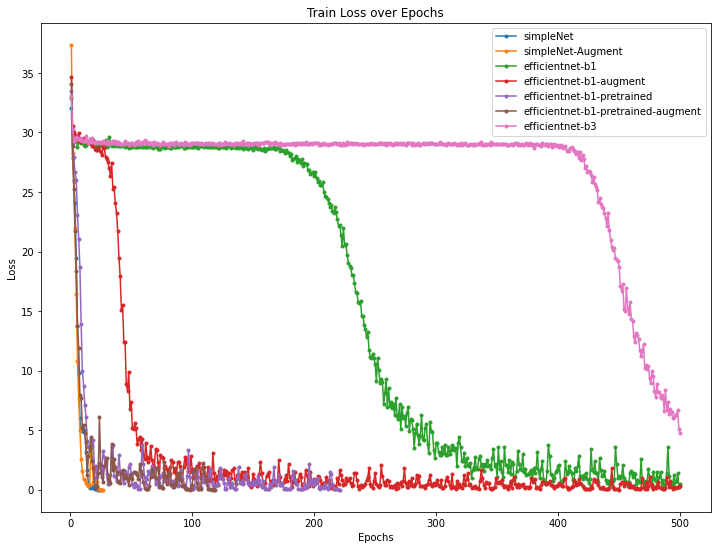

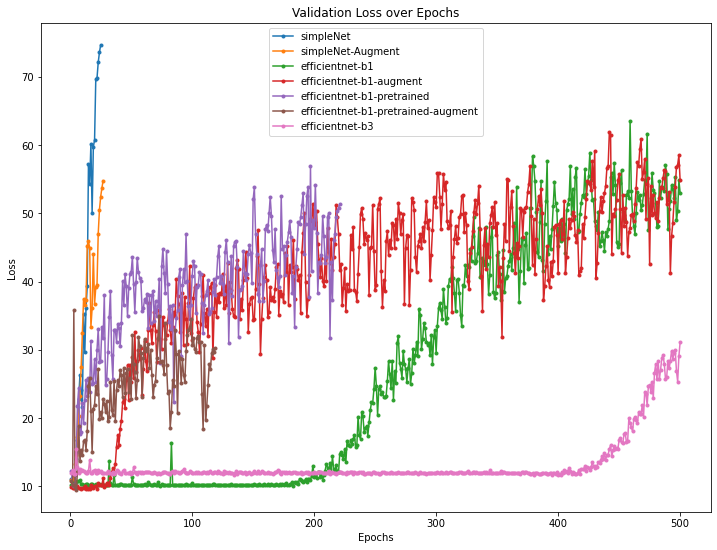

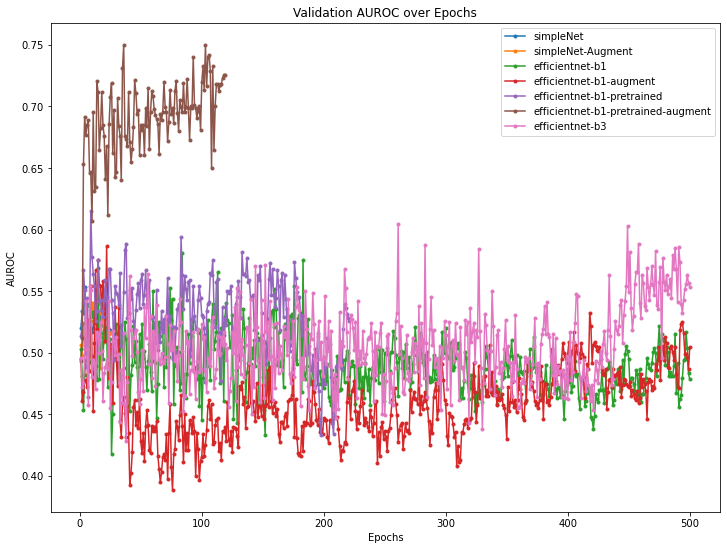

In [24]:
plt.figure(figsize=(12,9))
for i in range(len(models)):
    plt.plot(range(1, epochs[i]+1), train_losses[i], label=names[i], marker=".")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Train Loss over Epochs")
plt.show()

plt.figure(figsize=(12, 9))
for i in range(len(models)):
    plt.plot(range(1, epochs[i]+1), valid_losses[i], label=names[i], marker=".")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Validation Loss over Epochs")
plt.show()

plt.figure(figsize=(12, 9))
for i in range(len(models)):
    plt.plot(range(1, epochs[i]+1), aurocs[i], label=names[i], marker=".")
plt.xlabel("Epochs")
plt.ylabel("AUROC")
plt.legend()
plt.title("Validation AUROC over Epochs")
plt.show()